##### Copyright 2020 The TensorFlow Hub Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup




In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [3]:
!pip install -q tf-models-official

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Sentiment Analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.



In [5]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

    8192/84125825 [..............................] - ETA: 25:35

   24576/84125825 [..............................] - ETA: 17:05

   40960/84125825 [..............................] - ETA: 15:23

   73728/84125825 [..............................] - ETA: 11:23

   90112/84125825 [..............................] - ETA: 11:39

  106496/84125825 [..............................] - ETA: 11:49

  139264/84125825 [..............................] - ETA: 10:33

  172032/84125825 [..............................] - ETA: 9:45 

  204800/84125825 [..............................] - ETA: 9:13

  253952/84125825 [..............................] - ETA: 8:15

  303104/84125825 [..............................] - ETA: 7:36

  352256/84125825 [..............................] - ETA: 7:08

  417792/84125825 [..............................] - ETA: 6:30

  499712/84125825 [..............................] - ETA: 5:51

  565248/84125825 [..............................] - ETA: 5:32

  663552/84125825 [..............................] - ETA: 5:01

  778240/84125825 [..............................] - ETA: 4:33

  892928/84125825 [..............................] - ETA: 4:11

 1040384/84125825 [..............................] - ETA: 3:47

 1187840/84125825 [..............................] - ETA: 3:29

 1384448/84125825 [..............................] - ETA: 3:08

 1613824/84125825 [..............................] - ETA: 2:48

 1843200/84125825 [..............................] - ETA: 2:34

 2105344/84125825 [..............................] - ETA: 2:20

 2416640/84125825 [..............................] - ETA: 2:06

 2809856/84125825 [>.............................] - ETA: 1:52

 3268608/84125825 [>.............................] - ETA: 1:40

 3809280/84125825 [>.............................] - ETA: 1:28

 4497408/84125825 [>.............................] - ETA: 1:17

 5316608/84125825 [>.............................] - ETA: 1:06

 6332416/84125825 [=>............................] - ETA: 57s 

 7610368/84125825 [=>............................] - ETA: 48s

 9248768/84125825 [==>...........................] - ETA: 40s

11214848/84125825 [==>...........................] - ETA: 33s

13590528/84125825 [===>..........................] - ETA: 27s

16277504/84125825 [====>.........................] - ETA: 22s

18882560/84125825 [=====>........................] - ETA: 19s

21536768/84125825 [======>.......................] - ETA: 16s

24453120/84125825 [=======>......................] - ETA: 14s

27205632/84125825 [========>.....................] - ETA: 12s

29876224/84125825 [=========>....................] - ETA: 11s

32628736/84125825 [==========>...................] - ETA: 9s 

35758080/84125825 [===========>..................] - ETA: 8s

38526976/84125825 [============>.................] - ETA: 7s

41230336/84125825 [=============>................] - ETA: 7s

44097536/84125825 [==============>...............] - ETA: 6s

47161344/84125825 [===============>..............] - ETA: 5s

49930240/84125825 [================>.............] - ETA: 4s

52600832/84125825 [=================>............] - ETA: 4s

55353344/84125825 [==================>...........] - ETA: 3s

58236928/84125825 [===================>..........] - ETA: 3s

61349888/84125825 [====================>.........] - ETA: 2s

64020480/84125825 [=====================>........] - ETA: 2s

66969600/84125825 [======================>.......] - ETA: 2s

69705728/84125825 [=======================>......] - ETA: 1s

72474624/84125825 [========================>.....] - ETA: 1s

72491008/84125825 [========================>.....] - ETA: 1s

75177984/84125825 [=========================>....] - ETA: 1s

75194368/84125825 [=========================>....] - ETA: 1s

78094336/84125825 [==========================>...] - ETA: 0s

78110720/84125825 [==========================>...] - ETA: 0s

80535552/84125825 [===========================>..] - ETA: 0s

81223680/84125825 [===========================>..] - ETA: 0s

83419136/84125825 [============================>.] - ETA: 0s

84131840/84125825 [==============================] - 9s 0us/step


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yeld even better accuracy but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [8]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262856  0.9928099  -0.18611813  0.36673817  0.15233694  0.65504444
  0.9681154  -0.9486271   0.00216218 -0.9877732   0.06842685 -0.9763059 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2894628   0.34321272  0.33231506 ...  0.21300802  0.710207
  -0.05771142]
 [-0.2874205   0.31980982 -0.23018603 ...  0.58455056 -0.21329817
   0.7269207 ]
 [-0.6615709   0.68876755 -0.8743301  ...  0.10877277 -0.2617318
   0.47855416]
 ...
 [-0.22561157 -0.2892561  -0.07064444 ...  0.47566032  0.8327708
   0.40025347]
 [-0.2982418  -0.27473187 -0.05450559 ...  0.48849753  1.0955364
   0.18163395]
 [-0.44378245  0.00930751  0.07223723 ...  0.17290156  1.183324
   0.07897998]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` to represent each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can use just follow the model's url for documentation. Here specifically you don't need to worry about it because the preprocessing model will take care of that for you.


In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [14]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.25849003]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

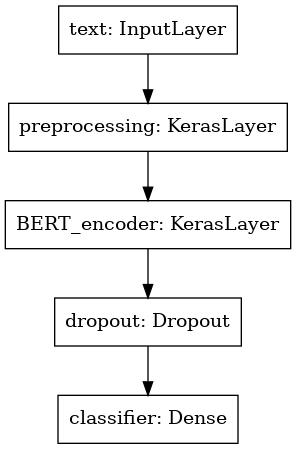

In [15]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), we use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [17]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [18]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [19]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


  1/625 [..............................] - ETA: 0s - loss: 0.6309 - binary_accuracy: 0.7188

  2/625 [..............................] - ETA: 8:49 - loss: 0.8697 - binary_accuracy: 0.5625

  3/625 [..............................] - ETA: 11:39 - loss: 0.9029 - binary_accuracy: 0.5312

  4/625 [..............................] - ETA: 12:58 - loss: 0.8525 - binary_accuracy: 0.5547

  5/625 [..............................] - ETA: 13:45 - loss: 0.8534 - binary_accuracy: 0.5500

  6/625 [..............................] - ETA: 14:20 - loss: 0.8498 - binary_accuracy: 0.5573

  7/625 [..............................] - ETA: 14:40 - loss: 0.8370 - binary_accuracy: 0.5670

  8/625 [..............................] - ETA: 14:53 - loss: 0.8297 - binary_accuracy: 0.5742

  9/625 [..............................] - ETA: 15:05 - loss: 0.8460 - binary_accuracy: 0.5694

 10/625 [..............................] - ETA: 15:12 - loss: 0.8790 - binary_accuracy: 0.5469

 11/625 [..............................] - ETA: 15:19 - loss: 0.8927 - binary_accuracy: 0.5341

 12/625 [..............................] - ETA: 15:26 - loss: 0.9124 - binary_accuracy: 0.5182

 13/625 [..............................] - ETA: 15:30 - loss: 0.9174 - binary_accuracy: 0.5144

 14/625 [..............................] - ETA: 15:33 - loss: 0.9135 - binary_accuracy: 0.5179

 15/625 [..............................] - ETA: 15:34 - loss: 0.9050 - binary_accuracy: 0.5188

 16/625 [..............................] - ETA: 15:37 - loss: 0.8851 - binary_accuracy: 0.5312

 17/625 [..............................] - ETA: 15:38 - loss: 0.8887 - binary_accuracy: 0.5239

 18/625 [..............................] - ETA: 15:40 - loss: 0.8853 - binary_accuracy: 0.5243

 19/625 [..............................] - ETA: 15:40 - loss: 0.8765 - binary_accuracy: 0.5230

 20/625 [..............................] - ETA: 15:39 - loss: 0.8740 - binary_accuracy: 0.5203

 21/625 [>.............................] - ETA: 15:39 - loss: 0.8685 - binary_accuracy: 0.5193

 22/625 [>.............................] - ETA: 15:39 - loss: 0.8686 - binary_accuracy: 0.5170

 23/625 [>.............................] - ETA: 15:40 - loss: 0.8695 - binary_accuracy: 0.5163

 24/625 [>.............................] - ETA: 15:39 - loss: 0.8583 - binary_accuracy: 0.5234

 25/625 [>.............................] - ETA: 15:39 - loss: 0.8614 - binary_accuracy: 0.5188

 26/625 [>.............................] - ETA: 15:39 - loss: 0.8593 - binary_accuracy: 0.5168

 27/625 [>.............................] - ETA: 15:39 - loss: 0.8583 - binary_accuracy: 0.5104

 28/625 [>.............................] - ETA: 15:38 - loss: 0.8533 - binary_accuracy: 0.5123

 29/625 [>.............................] - ETA: 15:38 - loss: 0.8515 - binary_accuracy: 0.5097

 30/625 [>.............................] - ETA: 15:37 - loss: 0.8471 - binary_accuracy: 0.5073

 31/625 [>.............................] - ETA: 15:37 - loss: 0.8410 - binary_accuracy: 0.5121

 32/625 [>.............................] - ETA: 15:36 - loss: 0.8379 - binary_accuracy: 0.5127

 33/625 [>.............................] - ETA: 15:34 - loss: 0.8322 - binary_accuracy: 0.5180

 34/625 [>.............................] - ETA: 15:33 - loss: 0.8282 - binary_accuracy: 0.5165

 35/625 [>.............................] - ETA: 15:31 - loss: 0.8247 - binary_accuracy: 0.5188

 36/625 [>.............................] - ETA: 15:30 - loss: 0.8215 - binary_accuracy: 0.5182

 37/625 [>.............................] - ETA: 15:28 - loss: 0.8191 - binary_accuracy: 0.5152

 38/625 [>.............................] - ETA: 15:28 - loss: 0.8168 - binary_accuracy: 0.5132

 39/625 [>.............................] - ETA: 15:26 - loss: 0.8134 - binary_accuracy: 0.5184

 40/625 [>.............................] - ETA: 15:24 - loss: 0.8104 - binary_accuracy: 0.5180

 41/625 [>.............................] - ETA: 15:22 - loss: 0.8090 - binary_accuracy: 0.5183

 42/625 [=>............................] - ETA: 15:21 - loss: 0.8066 - binary_accuracy: 0.5201

 43/625 [=>............................] - ETA: 15:19 - loss: 0.8045 - binary_accuracy: 0.5218

 44/625 [=>............................] - ETA: 15:18 - loss: 0.8030 - binary_accuracy: 0.5185

 45/625 [=>............................] - ETA: 15:17 - loss: 0.7992 - binary_accuracy: 0.5194

 46/625 [=>............................] - ETA: 15:14 - loss: 0.7948 - binary_accuracy: 0.5224

 47/625 [=>............................] - ETA: 15:13 - loss: 0.7926 - binary_accuracy: 0.5206

 48/625 [=>............................] - ETA: 15:11 - loss: 0.7907 - binary_accuracy: 0.5234

 49/625 [=>............................] - ETA: 15:10 - loss: 0.7887 - binary_accuracy: 0.5230

 50/625 [=>............................] - ETA: 15:08 - loss: 0.7862 - binary_accuracy: 0.5256

 51/625 [=>............................] - ETA: 15:07 - loss: 0.7841 - binary_accuracy: 0.5270

 52/625 [=>............................] - ETA: 15:05 - loss: 0.7814 - binary_accuracy: 0.5276

 53/625 [=>............................] - ETA: 15:03 - loss: 0.7793 - binary_accuracy: 0.5277

 54/625 [=>............................] - ETA: 15:02 - loss: 0.7777 - binary_accuracy: 0.5295

 55/625 [=>............................] - ETA: 15:00 - loss: 0.7743 - binary_accuracy: 0.5301

 56/625 [=>............................] - ETA: 14:59 - loss: 0.7728 - binary_accuracy: 0.5301

 57/625 [=>............................] - ETA: 14:57 - loss: 0.7708 - binary_accuracy: 0.5312

 58/625 [=>............................] - ETA: 14:56 - loss: 0.7689 - binary_accuracy: 0.5307

 59/625 [=>............................] - ETA: 14:54 - loss: 0.7675 - binary_accuracy: 0.5318

 60/625 [=>............................] - ETA: 14:53 - loss: 0.7655 - binary_accuracy: 0.5339

 61/625 [=>............................] - ETA: 14:52 - loss: 0.7639 - binary_accuracy: 0.5369

 62/625 [=>............................] - ETA: 14:51 - loss: 0.7628 - binary_accuracy: 0.5373

 63/625 [==>...........................] - ETA: 14:50 - loss: 0.7610 - binary_accuracy: 0.5382

 64/625 [==>...........................] - ETA: 14:49 - loss: 0.7592 - binary_accuracy: 0.5386

 65/625 [==>...........................] - ETA: 14:48 - loss: 0.7575 - binary_accuracy: 0.5399

 66/625 [==>...........................] - ETA: 14:47 - loss: 0.7557 - binary_accuracy: 0.5407

 67/625 [==>...........................] - ETA: 14:45 - loss: 0.7539 - binary_accuracy: 0.5406

 68/625 [==>...........................] - ETA: 14:44 - loss: 0.7528 - binary_accuracy: 0.5404

 69/625 [==>...........................] - ETA: 14:43 - loss: 0.7510 - binary_accuracy: 0.5408

 70/625 [==>...........................] - ETA: 14:41 - loss: 0.7495 - binary_accuracy: 0.5415

 71/625 [==>...........................] - ETA: 14:40 - loss: 0.7481 - binary_accuracy: 0.5436

 72/625 [==>...........................] - ETA: 14:38 - loss: 0.7471 - binary_accuracy: 0.5430

 73/625 [==>...........................] - ETA: 14:36 - loss: 0.7456 - binary_accuracy: 0.5428

 74/625 [==>...........................] - ETA: 14:34 - loss: 0.7443 - binary_accuracy: 0.5422

 75/625 [==>...........................] - ETA: 14:33 - loss: 0.7427 - binary_accuracy: 0.5412

 76/625 [==>...........................] - ETA: 14:32 - loss: 0.7414 - binary_accuracy: 0.5407

 77/625 [==>...........................] - ETA: 14:31 - loss: 0.7403 - binary_accuracy: 0.5402

 78/625 [==>...........................] - ETA: 14:29 - loss: 0.7390 - binary_accuracy: 0.5397

 79/625 [==>...........................] - ETA: 14:28 - loss: 0.7371 - binary_accuracy: 0.5411

 80/625 [==>...........................] - ETA: 14:26 - loss: 0.7358 - binary_accuracy: 0.5414

 81/625 [==>...........................] - ETA: 14:24 - loss: 0.7352 - binary_accuracy: 0.5417

 82/625 [==>...........................] - ETA: 14:23 - loss: 0.7340 - binary_accuracy: 0.5427

 83/625 [==>...........................] - ETA: 14:21 - loss: 0.7329 - binary_accuracy: 0.5441

 84/625 [===>..........................] - ETA: 14:20 - loss: 0.7318 - binary_accuracy: 0.5443

 85/625 [===>..........................] - ETA: 14:19 - loss: 0.7305 - binary_accuracy: 0.5467

 86/625 [===>..........................] - ETA: 14:17 - loss: 0.7293 - binary_accuracy: 0.5483

 87/625 [===>..........................] - ETA: 14:16 - loss: 0.7274 - binary_accuracy: 0.5492

 88/625 [===>..........................] - ETA: 14:14 - loss: 0.7260 - binary_accuracy: 0.5501

 89/625 [===>..........................] - ETA: 14:13 - loss: 0.7252 - binary_accuracy: 0.5506

 90/625 [===>..........................] - ETA: 14:11 - loss: 0.7243 - binary_accuracy: 0.5503

 91/625 [===>..........................] - ETA: 14:10 - loss: 0.7233 - binary_accuracy: 0.5515

 92/625 [===>..........................] - ETA: 14:08 - loss: 0.7214 - binary_accuracy: 0.5537

 93/625 [===>..........................] - ETA: 14:07 - loss: 0.7199 - binary_accuracy: 0.5548

 94/625 [===>..........................] - ETA: 14:05 - loss: 0.7190 - binary_accuracy: 0.5555

 95/625 [===>..........................] - ETA: 14:03 - loss: 0.7181 - binary_accuracy: 0.5553

 96/625 [===>..........................] - ETA: 14:02 - loss: 0.7169 - binary_accuracy: 0.5566

 97/625 [===>..........................] - ETA: 14:01 - loss: 0.7156 - binary_accuracy: 0.5580

 98/625 [===>..........................] - ETA: 13:59 - loss: 0.7144 - binary_accuracy: 0.5587

 99/625 [===>..........................] - ETA: 13:58 - loss: 0.7136 - binary_accuracy: 0.5600

100/625 [===>..........................] - ETA: 13:56 - loss: 0.7124 - binary_accuracy: 0.5603

101/625 [===>..........................] - ETA: 13:55 - loss: 0.7119 - binary_accuracy: 0.5606

102/625 [===>..........................] - ETA: 13:53 - loss: 0.7112 - binary_accuracy: 0.5600

103/625 [===>..........................] - ETA: 13:52 - loss: 0.7098 - binary_accuracy: 0.5610

104/625 [===>..........................] - ETA: 13:50 - loss: 0.7081 - binary_accuracy: 0.5631

105/625 [====>.........................] - ETA: 13:49 - loss: 0.7070 - binary_accuracy: 0.5643

106/625 [====>.........................] - ETA: 13:47 - loss: 0.7063 - binary_accuracy: 0.5646

107/625 [====>.........................] - ETA: 13:46 - loss: 0.7056 - binary_accuracy: 0.5643

108/625 [====>.........................] - ETA: 13:44 - loss: 0.7041 - binary_accuracy: 0.5651

109/625 [====>.........................] - ETA: 13:43 - loss: 0.7036 - binary_accuracy: 0.5648

110/625 [====>.........................] - ETA: 13:41 - loss: 0.7035 - binary_accuracy: 0.5648

111/625 [====>.........................] - ETA: 13:39 - loss: 0.7016 - binary_accuracy: 0.5659

112/625 [====>.........................] - ETA: 13:38 - loss: 0.7002 - binary_accuracy: 0.5672

113/625 [====>.........................] - ETA: 13:36 - loss: 0.6994 - binary_accuracy: 0.5686

114/625 [====>.........................] - ETA: 13:34 - loss: 0.6985 - binary_accuracy: 0.5704

115/625 [====>.........................] - ETA: 13:33 - loss: 0.6973 - binary_accuracy: 0.5723

116/625 [====>.........................] - ETA: 13:31 - loss: 0.6973 - binary_accuracy: 0.5714

117/625 [====>.........................] - ETA: 13:29 - loss: 0.6966 - binary_accuracy: 0.5708

118/625 [====>.........................] - ETA: 13:28 - loss: 0.6957 - binary_accuracy: 0.5720

119/625 [====>.........................] - ETA: 13:26 - loss: 0.6943 - binary_accuracy: 0.5741

120/625 [====>.........................] - ETA: 13:25 - loss: 0.6933 - binary_accuracy: 0.5758

121/625 [====>.........................] - ETA: 13:23 - loss: 0.6926 - binary_accuracy: 0.5752

122/625 [====>.........................] - ETA: 13:21 - loss: 0.6921 - binary_accuracy: 0.5753

123/625 [====>.........................] - ETA: 13:20 - loss: 0.6917 - binary_accuracy: 0.5760

124/625 [====>.........................] - ETA: 13:18 - loss: 0.6898 - binary_accuracy: 0.5779

125/625 [=====>........................] - ETA: 13:17 - loss: 0.6886 - binary_accuracy: 0.5795

126/625 [=====>........................] - ETA: 13:15 - loss: 0.6875 - binary_accuracy: 0.5801

127/625 [=====>........................] - ETA: 13:14 - loss: 0.6862 - binary_accuracy: 0.5812

128/625 [=====>........................] - ETA: 13:12 - loss: 0.6843 - binary_accuracy: 0.5833

129/625 [=====>........................] - ETA: 13:11 - loss: 0.6838 - binary_accuracy: 0.5843

130/625 [=====>........................] - ETA: 13:09 - loss: 0.6833 - binary_accuracy: 0.5841

131/625 [=====>........................] - ETA: 13:08 - loss: 0.6821 - binary_accuracy: 0.5854

132/625 [=====>........................] - ETA: 13:06 - loss: 0.6809 - binary_accuracy: 0.5866

133/625 [=====>........................] - ETA: 13:05 - loss: 0.6797 - binary_accuracy: 0.5881

134/625 [=====>........................] - ETA: 13:03 - loss: 0.6790 - binary_accuracy: 0.5889

135/625 [=====>........................] - ETA: 13:01 - loss: 0.6782 - binary_accuracy: 0.5898

136/625 [=====>........................] - ETA: 13:00 - loss: 0.6770 - binary_accuracy: 0.5915

137/625 [=====>........................] - ETA: 12:58 - loss: 0.6756 - binary_accuracy: 0.5926

138/625 [=====>........................] - ETA: 12:57 - loss: 0.6747 - binary_accuracy: 0.5928

139/625 [=====>........................] - ETA: 12:55 - loss: 0.6730 - binary_accuracy: 0.5940

140/625 [=====>........................] - ETA: 12:54 - loss: 0.6724 - binary_accuracy: 0.5946

141/625 [=====>........................] - ETA: 12:52 - loss: 0.6712 - binary_accuracy: 0.5951

142/625 [=====>........................] - ETA: 12:51 - loss: 0.6703 - binary_accuracy: 0.5957

143/625 [=====>........................] - ETA: 12:49 - loss: 0.6702 - binary_accuracy: 0.5964

144/625 [=====>........................] - ETA: 12:47 - loss: 0.6692 - binary_accuracy: 0.5974

145/625 [=====>........................] - ETA: 12:46 - loss: 0.6681 - binary_accuracy: 0.5983

146/625 [======>.......................] - ETA: 12:44 - loss: 0.6671 - binary_accuracy: 0.5997

147/625 [======>.......................] - ETA: 12:43 - loss: 0.6659 - binary_accuracy: 0.6006

148/625 [======>.......................] - ETA: 12:41 - loss: 0.6650 - binary_accuracy: 0.6007

149/625 [======>.......................] - ETA: 12:39 - loss: 0.6640 - binary_accuracy: 0.6023

150/625 [======>.......................] - ETA: 12:38 - loss: 0.6641 - binary_accuracy: 0.6019

151/625 [======>.......................] - ETA: 12:36 - loss: 0.6630 - binary_accuracy: 0.6029

152/625 [======>.......................] - ETA: 12:34 - loss: 0.6624 - binary_accuracy: 0.6038

153/625 [======>.......................] - ETA: 12:33 - loss: 0.6610 - binary_accuracy: 0.6042

154/625 [======>.......................] - ETA: 12:31 - loss: 0.6603 - binary_accuracy: 0.6049

155/625 [======>.......................] - ETA: 12:29 - loss: 0.6595 - binary_accuracy: 0.6046

156/625 [======>.......................] - ETA: 12:28 - loss: 0.6583 - binary_accuracy: 0.6062

157/625 [======>.......................] - ETA: 12:26 - loss: 0.6581 - binary_accuracy: 0.6061

158/625 [======>.......................] - ETA: 12:25 - loss: 0.6585 - binary_accuracy: 0.6068

159/625 [======>.......................] - ETA: 12:23 - loss: 0.6576 - binary_accuracy: 0.6081

160/625 [======>.......................] - ETA: 12:21 - loss: 0.6565 - binary_accuracy: 0.6090

161/625 [======>.......................] - ETA: 12:20 - loss: 0.6553 - binary_accuracy: 0.6099

162/625 [======>.......................] - ETA: 12:18 - loss: 0.6545 - binary_accuracy: 0.6101

163/625 [======>.......................] - ETA: 12:16 - loss: 0.6532 - binary_accuracy: 0.6110

164/625 [======>.......................] - ETA: 12:15 - loss: 0.6529 - binary_accuracy: 0.6109

165/625 [======>.......................] - ETA: 12:13 - loss: 0.6519 - binary_accuracy: 0.6117

166/625 [======>.......................] - ETA: 12:11 - loss: 0.6510 - binary_accuracy: 0.6128

167/625 [=======>......................] - ETA: 12:10 - loss: 0.6502 - binary_accuracy: 0.6128

168/625 [=======>......................] - ETA: 12:08 - loss: 0.6495 - binary_accuracy: 0.6137

169/625 [=======>......................] - ETA: 12:07 - loss: 0.6482 - binary_accuracy: 0.6146

170/625 [=======>......................] - ETA: 12:05 - loss: 0.6475 - binary_accuracy: 0.6158

171/625 [=======>......................] - ETA: 12:03 - loss: 0.6469 - binary_accuracy: 0.6162

172/625 [=======>......................] - ETA: 12:02 - loss: 0.6451 - binary_accuracy: 0.6179

173/625 [=======>......................] - ETA: 12:00 - loss: 0.6442 - binary_accuracy: 0.6192

174/625 [=======>......................] - ETA: 11:59 - loss: 0.6427 - binary_accuracy: 0.6207

175/625 [=======>......................] - ETA: 11:57 - loss: 0.6413 - binary_accuracy: 0.6220

176/625 [=======>......................] - ETA: 11:55 - loss: 0.6413 - binary_accuracy: 0.6218

177/625 [=======>......................] - ETA: 11:54 - loss: 0.6407 - binary_accuracy: 0.6220

178/625 [=======>......................] - ETA: 11:52 - loss: 0.6398 - binary_accuracy: 0.6224

179/625 [=======>......................] - ETA: 11:51 - loss: 0.6387 - binary_accuracy: 0.6229

180/625 [=======>......................] - ETA: 11:49 - loss: 0.6377 - binary_accuracy: 0.6238

181/625 [=======>......................] - ETA: 11:47 - loss: 0.6364 - binary_accuracy: 0.6250

182/625 [=======>......................] - ETA: 11:46 - loss: 0.6362 - binary_accuracy: 0.6255

183/625 [=======>......................] - ETA: 11:44 - loss: 0.6363 - binary_accuracy: 0.6257

184/625 [=======>......................] - ETA: 11:43 - loss: 0.6357 - binary_accuracy: 0.6262

185/625 [=======>......................] - ETA: 11:41 - loss: 0.6340 - binary_accuracy: 0.6274

186/625 [=======>......................] - ETA: 11:39 - loss: 0.6334 - binary_accuracy: 0.6282

187/625 [=======>......................] - ETA: 11:38 - loss: 0.6320 - binary_accuracy: 0.6292

188/625 [========>.....................] - ETA: 11:36 - loss: 0.6302 - binary_accuracy: 0.6307

189/625 [========>.....................] - ETA: 11:35 - loss: 0.6290 - binary_accuracy: 0.6314

190/625 [========>.....................] - ETA: 11:33 - loss: 0.6288 - binary_accuracy: 0.6314

191/625 [========>.....................] - ETA: 11:31 - loss: 0.6279 - binary_accuracy: 0.6322

192/625 [========>.....................] - ETA: 11:30 - loss: 0.6271 - binary_accuracy: 0.6326

193/625 [========>.....................] - ETA: 11:28 - loss: 0.6267 - binary_accuracy: 0.6326

194/625 [========>.....................] - ETA: 11:26 - loss: 0.6267 - binary_accuracy: 0.6332

195/625 [========>.....................] - ETA: 11:25 - loss: 0.6262 - binary_accuracy: 0.6335

196/625 [========>.....................] - ETA: 11:23 - loss: 0.6265 - binary_accuracy: 0.6336

197/625 [========>.....................] - ETA: 11:22 - loss: 0.6260 - binary_accuracy: 0.6344

198/625 [========>.....................] - ETA: 11:20 - loss: 0.6250 - binary_accuracy: 0.6349

199/625 [========>.....................] - ETA: 11:18 - loss: 0.6248 - binary_accuracy: 0.6352

200/625 [========>.....................] - ETA: 11:17 - loss: 0.6238 - binary_accuracy: 0.6363

201/625 [========>.....................] - ETA: 11:15 - loss: 0.6237 - binary_accuracy: 0.6362

202/625 [========>.....................] - ETA: 11:14 - loss: 0.6224 - binary_accuracy: 0.6372

203/625 [========>.....................] - ETA: 11:12 - loss: 0.6219 - binary_accuracy: 0.6376

204/625 [========>.....................] - ETA: 11:11 - loss: 0.6214 - binary_accuracy: 0.6383

205/625 [========>.....................] - ETA: 11:09 - loss: 0.6205 - binary_accuracy: 0.6387

206/625 [========>.....................] - ETA: 11:07 - loss: 0.6196 - binary_accuracy: 0.6393

207/625 [========>.....................] - ETA: 11:06 - loss: 0.6193 - binary_accuracy: 0.6399

208/625 [========>.....................] - ETA: 11:04 - loss: 0.6188 - binary_accuracy: 0.6400

209/625 [=========>....................] - ETA: 11:02 - loss: 0.6175 - binary_accuracy: 0.6413

210/625 [=========>....................] - ETA: 11:01 - loss: 0.6175 - binary_accuracy: 0.6412

211/625 [=========>....................] - ETA: 10:59 - loss: 0.6162 - binary_accuracy: 0.6417

212/625 [=========>....................] - ETA: 10:57 - loss: 0.6157 - binary_accuracy: 0.6424

213/625 [=========>....................] - ETA: 10:56 - loss: 0.6147 - binary_accuracy: 0.6430

214/625 [=========>....................] - ETA: 10:54 - loss: 0.6137 - binary_accuracy: 0.6434

215/625 [=========>....................] - ETA: 10:53 - loss: 0.6130 - binary_accuracy: 0.6436

216/625 [=========>....................] - ETA: 10:51 - loss: 0.6127 - binary_accuracy: 0.6440

217/625 [=========>....................] - ETA: 10:50 - loss: 0.6116 - binary_accuracy: 0.6450

218/625 [=========>....................] - ETA: 10:48 - loss: 0.6102 - binary_accuracy: 0.6458

219/625 [=========>....................] - ETA: 10:46 - loss: 0.6096 - binary_accuracy: 0.6467

220/625 [=========>....................] - ETA: 10:45 - loss: 0.6090 - binary_accuracy: 0.6472

221/625 [=========>....................] - ETA: 10:43 - loss: 0.6079 - binary_accuracy: 0.6476

222/625 [=========>....................] - ETA: 10:41 - loss: 0.6067 - binary_accuracy: 0.6488

223/625 [=========>....................] - ETA: 10:40 - loss: 0.6058 - binary_accuracy: 0.6495

224/625 [=========>....................] - ETA: 10:38 - loss: 0.6057 - binary_accuracy: 0.6498

225/625 [=========>....................] - ETA: 10:37 - loss: 0.6055 - binary_accuracy: 0.6503

226/625 [=========>....................] - ETA: 10:35 - loss: 0.6042 - binary_accuracy: 0.6513

227/625 [=========>....................] - ETA: 10:33 - loss: 0.6031 - binary_accuracy: 0.6521

228/625 [=========>....................] - ETA: 10:32 - loss: 0.6021 - binary_accuracy: 0.6532

229/625 [=========>....................] - ETA: 10:30 - loss: 0.6017 - binary_accuracy: 0.6535

230/625 [==========>...................] - ETA: 10:29 - loss: 0.6012 - binary_accuracy: 0.6541

231/625 [==========>...................] - ETA: 10:27 - loss: 0.6002 - binary_accuracy: 0.6550

232/625 [==========>...................] - ETA: 10:25 - loss: 0.5991 - binary_accuracy: 0.6558

233/625 [==========>...................] - ETA: 10:24 - loss: 0.5982 - binary_accuracy: 0.6567

234/625 [==========>...................] - ETA: 10:22 - loss: 0.5976 - binary_accuracy: 0.6573

235/625 [==========>...................] - ETA: 10:20 - loss: 0.5968 - binary_accuracy: 0.6581

236/625 [==========>...................] - ETA: 10:19 - loss: 0.5969 - binary_accuracy: 0.6580

237/625 [==========>...................] - ETA: 10:17 - loss: 0.5960 - binary_accuracy: 0.6588

238/625 [==========>...................] - ETA: 10:15 - loss: 0.5946 - binary_accuracy: 0.6598

239/625 [==========>...................] - ETA: 10:14 - loss: 0.5947 - binary_accuracy: 0.6595

240/625 [==========>...................] - ETA: 10:12 - loss: 0.5937 - binary_accuracy: 0.6604

241/625 [==========>...................] - ETA: 10:10 - loss: 0.5934 - binary_accuracy: 0.6605

242/625 [==========>...................] - ETA: 10:09 - loss: 0.5919 - binary_accuracy: 0.6617

243/625 [==========>...................] - ETA: 10:07 - loss: 0.5915 - binary_accuracy: 0.6619

244/625 [==========>...................] - ETA: 10:06 - loss: 0.5910 - binary_accuracy: 0.6620

245/625 [==========>...................] - ETA: 10:04 - loss: 0.5906 - binary_accuracy: 0.6626

246/625 [==========>...................] - ETA: 10:02 - loss: 0.5897 - binary_accuracy: 0.6634

247/625 [==========>...................] - ETA: 10:01 - loss: 0.5889 - binary_accuracy: 0.6640

248/625 [==========>...................] - ETA: 9:59 - loss: 0.5889 - binary_accuracy: 0.6642 

249/625 [==========>...................] - ETA: 9:57 - loss: 0.5881 - binary_accuracy: 0.6644

250/625 [===========>..................] - ETA: 9:56 - loss: 0.5874 - binary_accuracy: 0.6650

251/625 [===========>..................] - ETA: 9:54 - loss: 0.5874 - binary_accuracy: 0.6652

252/625 [===========>..................] - ETA: 9:52 - loss: 0.5862 - binary_accuracy: 0.6662

253/625 [===========>..................] - ETA: 9:51 - loss: 0.5856 - binary_accuracy: 0.6670

254/625 [===========>..................] - ETA: 9:49 - loss: 0.5851 - binary_accuracy: 0.6676

255/625 [===========>..................] - ETA: 9:48 - loss: 0.5843 - binary_accuracy: 0.6683

256/625 [===========>..................] - ETA: 9:46 - loss: 0.5844 - binary_accuracy: 0.6681

257/625 [===========>..................] - ETA: 9:45 - loss: 0.5839 - binary_accuracy: 0.6683

258/625 [===========>..................] - ETA: 9:43 - loss: 0.5836 - binary_accuracy: 0.6687

259/625 [===========>..................] - ETA: 9:42 - loss: 0.5831 - binary_accuracy: 0.6689

260/625 [===========>..................] - ETA: 9:40 - loss: 0.5827 - binary_accuracy: 0.6692

261/625 [===========>..................] - ETA: 9:38 - loss: 0.5819 - binary_accuracy: 0.6698

262/625 [===========>..................] - ETA: 9:37 - loss: 0.5808 - binary_accuracy: 0.6703

263/625 [===========>..................] - ETA: 9:35 - loss: 0.5810 - binary_accuracy: 0.6702

264/625 [===========>..................] - ETA: 9:34 - loss: 0.5808 - binary_accuracy: 0.6706

265/625 [===========>..................] - ETA: 9:32 - loss: 0.5794 - binary_accuracy: 0.6715

266/625 [===========>..................] - ETA: 9:30 - loss: 0.5786 - binary_accuracy: 0.6723

267/625 [===========>..................] - ETA: 9:29 - loss: 0.5783 - binary_accuracy: 0.6726

268/625 [===========>..................] - ETA: 9:27 - loss: 0.5774 - binary_accuracy: 0.6735

269/625 [===========>..................] - ETA: 9:25 - loss: 0.5770 - binary_accuracy: 0.6741

270/625 [===========>..................] - ETA: 9:24 - loss: 0.5764 - binary_accuracy: 0.6743

271/625 [============>.................] - ETA: 9:22 - loss: 0.5763 - binary_accuracy: 0.6744

272/625 [============>.................] - ETA: 9:20 - loss: 0.5759 - binary_accuracy: 0.6745

273/625 [============>.................] - ETA: 9:19 - loss: 0.5766 - binary_accuracy: 0.6740

274/625 [============>.................] - ETA: 9:17 - loss: 0.5761 - binary_accuracy: 0.6744

275/625 [============>.................] - ETA: 9:15 - loss: 0.5758 - binary_accuracy: 0.6747

276/625 [============>.................] - ETA: 9:14 - loss: 0.5758 - binary_accuracy: 0.6750

277/625 [============>.................] - ETA: 9:12 - loss: 0.5750 - binary_accuracy: 0.6758

278/625 [============>.................] - ETA: 9:11 - loss: 0.5742 - binary_accuracy: 0.6763

279/625 [============>.................] - ETA: 9:09 - loss: 0.5736 - binary_accuracy: 0.6769

280/625 [============>.................] - ETA: 9:08 - loss: 0.5733 - binary_accuracy: 0.6772

281/625 [============>.................] - ETA: 9:06 - loss: 0.5728 - binary_accuracy: 0.6777

282/625 [============>.................] - ETA: 9:04 - loss: 0.5733 - binary_accuracy: 0.6775

283/625 [============>.................] - ETA: 9:03 - loss: 0.5728 - binary_accuracy: 0.6778

284/625 [============>.................] - ETA: 9:01 - loss: 0.5720 - binary_accuracy: 0.6785

285/625 [============>.................] - ETA: 8:59 - loss: 0.5720 - binary_accuracy: 0.6786

286/625 [============>.................] - ETA: 8:58 - loss: 0.5723 - binary_accuracy: 0.6786

287/625 [============>.................] - ETA: 8:56 - loss: 0.5721 - binary_accuracy: 0.6790

288/625 [============>.................] - ETA: 8:55 - loss: 0.5725 - binary_accuracy: 0.6788

289/625 [============>.................] - ETA: 8:53 - loss: 0.5721 - binary_accuracy: 0.6792

290/625 [============>.................] - ETA: 8:51 - loss: 0.5717 - binary_accuracy: 0.6795

291/625 [============>.................] - ETA: 8:50 - loss: 0.5713 - binary_accuracy: 0.6801

292/625 [=============>................] - ETA: 8:48 - loss: 0.5709 - binary_accuracy: 0.6805

293/625 [=============>................] - ETA: 8:47 - loss: 0.5707 - binary_accuracy: 0.6808

294/625 [=============>................] - ETA: 8:45 - loss: 0.5705 - binary_accuracy: 0.6811

295/625 [=============>................] - ETA: 8:43 - loss: 0.5704 - binary_accuracy: 0.6812

296/625 [=============>................] - ETA: 8:42 - loss: 0.5700 - binary_accuracy: 0.6817

297/625 [=============>................] - ETA: 8:40 - loss: 0.5693 - binary_accuracy: 0.6820

298/625 [=============>................] - ETA: 8:39 - loss: 0.5689 - binary_accuracy: 0.6822

299/625 [=============>................] - ETA: 8:37 - loss: 0.5685 - binary_accuracy: 0.6825

300/625 [=============>................] - ETA: 8:35 - loss: 0.5681 - binary_accuracy: 0.6826

301/625 [=============>................] - ETA: 8:34 - loss: 0.5676 - binary_accuracy: 0.6829

302/625 [=============>................] - ETA: 8:32 - loss: 0.5673 - binary_accuracy: 0.6833

303/625 [=============>................] - ETA: 8:31 - loss: 0.5671 - binary_accuracy: 0.6834

304/625 [=============>................] - ETA: 8:29 - loss: 0.5663 - binary_accuracy: 0.6839

305/625 [=============>................] - ETA: 8:27 - loss: 0.5662 - binary_accuracy: 0.6841

306/625 [=============>................] - ETA: 8:26 - loss: 0.5663 - binary_accuracy: 0.6841

307/625 [=============>................] - ETA: 8:24 - loss: 0.5657 - binary_accuracy: 0.6845

308/625 [=============>................] - ETA: 8:23 - loss: 0.5658 - binary_accuracy: 0.6846

309/625 [=============>................] - ETA: 8:21 - loss: 0.5654 - binary_accuracy: 0.6849

310/625 [=============>................] - ETA: 8:19 - loss: 0.5646 - binary_accuracy: 0.6854

311/625 [=============>................] - ETA: 8:18 - loss: 0.5644 - binary_accuracy: 0.6857

312/625 [=============>................] - ETA: 8:16 - loss: 0.5640 - binary_accuracy: 0.6858

313/625 [==============>...............] - ETA: 8:15 - loss: 0.5633 - binary_accuracy: 0.6863

314/625 [==============>...............] - ETA: 8:13 - loss: 0.5626 - binary_accuracy: 0.6869

315/625 [==============>...............] - ETA: 8:11 - loss: 0.5619 - binary_accuracy: 0.6874

316/625 [==============>...............] - ETA: 8:10 - loss: 0.5616 - binary_accuracy: 0.6877

317/625 [==============>...............] - ETA: 8:08 - loss: 0.5608 - binary_accuracy: 0.6884

318/625 [==============>...............] - ETA: 8:07 - loss: 0.5601 - binary_accuracy: 0.6889

319/625 [==============>...............] - ETA: 8:05 - loss: 0.5596 - binary_accuracy: 0.6894

320/625 [==============>...............] - ETA: 8:03 - loss: 0.5594 - binary_accuracy: 0.6896

321/625 [==============>...............] - ETA: 8:02 - loss: 0.5591 - binary_accuracy: 0.6900

322/625 [==============>...............] - ETA: 8:00 - loss: 0.5590 - binary_accuracy: 0.6901

323/625 [==============>...............] - ETA: 7:59 - loss: 0.5582 - binary_accuracy: 0.6905

324/625 [==============>...............] - ETA: 7:57 - loss: 0.5575 - binary_accuracy: 0.6909

325/625 [==============>...............] - ETA: 7:56 - loss: 0.5574 - binary_accuracy: 0.6911

326/625 [==============>...............] - ETA: 7:54 - loss: 0.5571 - binary_accuracy: 0.6913

327/625 [==============>...............] - ETA: 7:52 - loss: 0.5566 - binary_accuracy: 0.6916

328/625 [==============>...............] - ETA: 7:51 - loss: 0.5563 - binary_accuracy: 0.6917

329/625 [==============>...............] - ETA: 7:49 - loss: 0.5561 - binary_accuracy: 0.6920

330/625 [==============>...............] - ETA: 7:48 - loss: 0.5553 - binary_accuracy: 0.6925

331/625 [==============>...............] - ETA: 7:46 - loss: 0.5553 - binary_accuracy: 0.6924

332/625 [==============>...............] - ETA: 7:45 - loss: 0.5549 - binary_accuracy: 0.6925

333/625 [==============>...............] - ETA: 7:43 - loss: 0.5555 - binary_accuracy: 0.6923

334/625 [===============>..............] - ETA: 7:41 - loss: 0.5553 - binary_accuracy: 0.6923

335/625 [===============>..............] - ETA: 7:40 - loss: 0.5549 - binary_accuracy: 0.6925

336/625 [===============>..............] - ETA: 7:38 - loss: 0.5544 - binary_accuracy: 0.6928

337/625 [===============>..............] - ETA: 7:37 - loss: 0.5543 - binary_accuracy: 0.6928

338/625 [===============>..............] - ETA: 7:35 - loss: 0.5542 - binary_accuracy: 0.6929

339/625 [===============>..............] - ETA: 7:33 - loss: 0.5541 - binary_accuracy: 0.6931

340/625 [===============>..............] - ETA: 7:32 - loss: 0.5535 - binary_accuracy: 0.6938

341/625 [===============>..............] - ETA: 7:30 - loss: 0.5535 - binary_accuracy: 0.6941

342/625 [===============>..............] - ETA: 7:29 - loss: 0.5530 - binary_accuracy: 0.6944

343/625 [===============>..............] - ETA: 7:27 - loss: 0.5526 - binary_accuracy: 0.6947

344/625 [===============>..............] - ETA: 7:25 - loss: 0.5519 - binary_accuracy: 0.6949

345/625 [===============>..............] - ETA: 7:24 - loss: 0.5519 - binary_accuracy: 0.6948

346/625 [===============>..............] - ETA: 7:22 - loss: 0.5524 - binary_accuracy: 0.6945

347/625 [===============>..............] - ETA: 7:21 - loss: 0.5517 - binary_accuracy: 0.6949

348/625 [===============>..............] - ETA: 7:19 - loss: 0.5516 - binary_accuracy: 0.6951

349/625 [===============>..............] - ETA: 7:17 - loss: 0.5514 - binary_accuracy: 0.6955

350/625 [===============>..............] - ETA: 7:16 - loss: 0.5509 - binary_accuracy: 0.6959

351/625 [===============>..............] - ETA: 7:14 - loss: 0.5502 - binary_accuracy: 0.6966

352/625 [===============>..............] - ETA: 7:13 - loss: 0.5501 - binary_accuracy: 0.6967

353/625 [===============>..............] - ETA: 7:11 - loss: 0.5504 - binary_accuracy: 0.6968

354/625 [===============>..............] - ETA: 7:09 - loss: 0.5496 - binary_accuracy: 0.6973

355/625 [================>.............] - ETA: 7:08 - loss: 0.5492 - binary_accuracy: 0.6976

356/625 [================>.............] - ETA: 7:06 - loss: 0.5488 - binary_accuracy: 0.6982

357/625 [================>.............] - ETA: 7:05 - loss: 0.5482 - binary_accuracy: 0.6984

358/625 [================>.............] - ETA: 7:03 - loss: 0.5474 - binary_accuracy: 0.6989

359/625 [================>.............] - ETA: 7:01 - loss: 0.5468 - binary_accuracy: 0.6993

360/625 [================>.............] - ETA: 7:00 - loss: 0.5466 - binary_accuracy: 0.6996

361/625 [================>.............] - ETA: 6:58 - loss: 0.5465 - binary_accuracy: 0.6995

362/625 [================>.............] - ETA: 6:57 - loss: 0.5461 - binary_accuracy: 0.6998

363/625 [================>.............] - ETA: 6:55 - loss: 0.5456 - binary_accuracy: 0.7003

364/625 [================>.............] - ETA: 6:54 - loss: 0.5454 - binary_accuracy: 0.7005

365/625 [================>.............] - ETA: 6:52 - loss: 0.5448 - binary_accuracy: 0.7011

366/625 [================>.............] - ETA: 6:50 - loss: 0.5442 - binary_accuracy: 0.7015

367/625 [================>.............] - ETA: 6:49 - loss: 0.5434 - binary_accuracy: 0.7020

368/625 [================>.............] - ETA: 6:47 - loss: 0.5432 - binary_accuracy: 0.7019

369/625 [================>.............] - ETA: 6:46 - loss: 0.5427 - binary_accuracy: 0.7022

370/625 [================>.............] - ETA: 6:44 - loss: 0.5423 - binary_accuracy: 0.7027

371/625 [================>.............] - ETA: 6:42 - loss: 0.5418 - binary_accuracy: 0.7030

372/625 [================>.............] - ETA: 6:41 - loss: 0.5412 - binary_accuracy: 0.7035

373/625 [================>.............] - ETA: 6:39 - loss: 0.5407 - binary_accuracy: 0.7039

374/625 [================>.............] - ETA: 6:38 - loss: 0.5408 - binary_accuracy: 0.7041

375/625 [=================>............] - ETA: 6:36 - loss: 0.5403 - binary_accuracy: 0.7045

376/625 [=================>............] - ETA: 6:34 - loss: 0.5401 - binary_accuracy: 0.7048

377/625 [=================>............] - ETA: 6:33 - loss: 0.5402 - binary_accuracy: 0.7047

378/625 [=================>............] - ETA: 6:31 - loss: 0.5398 - binary_accuracy: 0.7047

379/625 [=================>............] - ETA: 6:30 - loss: 0.5392 - binary_accuracy: 0.7051

380/625 [=================>............] - ETA: 6:28 - loss: 0.5389 - binary_accuracy: 0.7054

381/625 [=================>............] - ETA: 6:27 - loss: 0.5380 - binary_accuracy: 0.7060

382/625 [=================>............] - ETA: 6:25 - loss: 0.5375 - binary_accuracy: 0.7064

383/625 [=================>............] - ETA: 6:23 - loss: 0.5368 - binary_accuracy: 0.7068

384/625 [=================>............] - ETA: 6:22 - loss: 0.5370 - binary_accuracy: 0.7070

385/625 [=================>............] - ETA: 6:20 - loss: 0.5372 - binary_accuracy: 0.7071

386/625 [=================>............] - ETA: 6:19 - loss: 0.5368 - binary_accuracy: 0.7076

387/625 [=================>............] - ETA: 6:17 - loss: 0.5364 - binary_accuracy: 0.7080

388/625 [=================>............] - ETA: 6:16 - loss: 0.5358 - binary_accuracy: 0.7084

389/625 [=================>............] - ETA: 6:14 - loss: 0.5348 - binary_accuracy: 0.7090

390/625 [=================>............] - ETA: 6:12 - loss: 0.5344 - binary_accuracy: 0.7091

391/625 [=================>............] - ETA: 6:11 - loss: 0.5338 - binary_accuracy: 0.7093

392/625 [=================>............] - ETA: 6:09 - loss: 0.5338 - binary_accuracy: 0.7095

393/625 [=================>............] - ETA: 6:08 - loss: 0.5340 - binary_accuracy: 0.7094

394/625 [=================>............] - ETA: 6:06 - loss: 0.5333 - binary_accuracy: 0.7099

395/625 [=================>............] - ETA: 6:05 - loss: 0.5331 - binary_accuracy: 0.7102

396/625 [==================>...........] - ETA: 6:03 - loss: 0.5331 - binary_accuracy: 0.7101

397/625 [==================>...........] - ETA: 6:01 - loss: 0.5326 - binary_accuracy: 0.7103

398/625 [==================>...........] - ETA: 6:00 - loss: 0.5322 - binary_accuracy: 0.7107

399/625 [==================>...........] - ETA: 5:58 - loss: 0.5319 - binary_accuracy: 0.7109

400/625 [==================>...........] - ETA: 5:57 - loss: 0.5318 - binary_accuracy: 0.7112

401/625 [==================>...........] - ETA: 5:55 - loss: 0.5312 - binary_accuracy: 0.7116

402/625 [==================>...........] - ETA: 5:54 - loss: 0.5315 - binary_accuracy: 0.7116

403/625 [==================>...........] - ETA: 5:52 - loss: 0.5310 - binary_accuracy: 0.7118

404/625 [==================>...........] - ETA: 5:50 - loss: 0.5310 - binary_accuracy: 0.7117

405/625 [==================>...........] - ETA: 5:49 - loss: 0.5304 - binary_accuracy: 0.7120

406/625 [==================>...........] - ETA: 5:47 - loss: 0.5303 - binary_accuracy: 0.7121

407/625 [==================>...........] - ETA: 5:46 - loss: 0.5301 - binary_accuracy: 0.7121

408/625 [==================>...........] - ETA: 5:44 - loss: 0.5298 - binary_accuracy: 0.7123

409/625 [==================>...........] - ETA: 5:43 - loss: 0.5294 - binary_accuracy: 0.7126

410/625 [==================>...........] - ETA: 5:41 - loss: 0.5292 - binary_accuracy: 0.7127

411/625 [==================>...........] - ETA: 5:39 - loss: 0.5288 - binary_accuracy: 0.7128

412/625 [==================>...........] - ETA: 5:38 - loss: 0.5284 - binary_accuracy: 0.7131

413/625 [==================>...........] - ETA: 5:36 - loss: 0.5282 - binary_accuracy: 0.7132

414/625 [==================>...........] - ETA: 5:35 - loss: 0.5289 - binary_accuracy: 0.7130

415/625 [==================>...........] - ETA: 5:33 - loss: 0.5285 - binary_accuracy: 0.7134

416/625 [==================>...........] - ETA: 5:31 - loss: 0.5279 - binary_accuracy: 0.7139

417/625 [===================>..........] - ETA: 5:30 - loss: 0.5277 - binary_accuracy: 0.7142

418/625 [===================>..........] - ETA: 5:28 - loss: 0.5274 - binary_accuracy: 0.7144

419/625 [===================>..........] - ETA: 5:27 - loss: 0.5275 - binary_accuracy: 0.7146

420/625 [===================>..........] - ETA: 5:25 - loss: 0.5272 - binary_accuracy: 0.7150

421/625 [===================>..........] - ETA: 5:24 - loss: 0.5269 - binary_accuracy: 0.7153

422/625 [===================>..........] - ETA: 5:22 - loss: 0.5265 - binary_accuracy: 0.7156

423/625 [===================>..........] - ETA: 5:20 - loss: 0.5263 - binary_accuracy: 0.7156

424/625 [===================>..........] - ETA: 5:19 - loss: 0.5260 - binary_accuracy: 0.7159

425/625 [===================>..........] - ETA: 5:17 - loss: 0.5257 - binary_accuracy: 0.7160

426/625 [===================>..........] - ETA: 5:16 - loss: 0.5262 - binary_accuracy: 0.7157

427/625 [===================>..........] - ETA: 5:14 - loss: 0.5261 - binary_accuracy: 0.7156

428/625 [===================>..........] - ETA: 5:12 - loss: 0.5256 - binary_accuracy: 0.7159

429/625 [===================>..........] - ETA: 5:11 - loss: 0.5252 - binary_accuracy: 0.7161

430/625 [===================>..........] - ETA: 5:09 - loss: 0.5246 - binary_accuracy: 0.7166

431/625 [===================>..........] - ETA: 5:08 - loss: 0.5242 - binary_accuracy: 0.7169

432/625 [===================>..........] - ETA: 5:06 - loss: 0.5242 - binary_accuracy: 0.7169

433/625 [===================>..........] - ETA: 5:05 - loss: 0.5241 - binary_accuracy: 0.7170

434/625 [===================>..........] - ETA: 5:03 - loss: 0.5240 - binary_accuracy: 0.7173

435/625 [===================>..........] - ETA: 5:01 - loss: 0.5237 - binary_accuracy: 0.7175

436/625 [===================>..........] - ETA: 5:00 - loss: 0.5233 - binary_accuracy: 0.7180

437/625 [===================>..........] - ETA: 4:58 - loss: 0.5229 - binary_accuracy: 0.7182

438/625 [====================>.........] - ETA: 4:57 - loss: 0.5226 - binary_accuracy: 0.7185

439/625 [====================>.........] - ETA: 4:55 - loss: 0.5221 - binary_accuracy: 0.7188

440/625 [====================>.........] - ETA: 4:53 - loss: 0.5219 - binary_accuracy: 0.7188

441/625 [====================>.........] - ETA: 4:52 - loss: 0.5213 - binary_accuracy: 0.7192

442/625 [====================>.........] - ETA: 4:50 - loss: 0.5214 - binary_accuracy: 0.7191

443/625 [====================>.........] - ETA: 4:49 - loss: 0.5211 - binary_accuracy: 0.7194

444/625 [====================>.........] - ETA: 4:47 - loss: 0.5208 - binary_accuracy: 0.7197

445/625 [====================>.........] - ETA: 4:46 - loss: 0.5204 - binary_accuracy: 0.7199

446/625 [====================>.........] - ETA: 4:44 - loss: 0.5202 - binary_accuracy: 0.7201

447/625 [====================>.........] - ETA: 4:43 - loss: 0.5199 - binary_accuracy: 0.7204

448/625 [====================>.........] - ETA: 4:41 - loss: 0.5195 - binary_accuracy: 0.7206

449/625 [====================>.........] - ETA: 4:40 - loss: 0.5192 - binary_accuracy: 0.7208

450/625 [====================>.........] - ETA: 4:38 - loss: 0.5193 - binary_accuracy: 0.7210

451/625 [====================>.........] - ETA: 4:37 - loss: 0.5190 - binary_accuracy: 0.7213

452/625 [====================>.........] - ETA: 4:35 - loss: 0.5187 - binary_accuracy: 0.7215

453/625 [====================>.........] - ETA: 4:34 - loss: 0.5181 - binary_accuracy: 0.7219

454/625 [====================>.........] - ETA: 4:32 - loss: 0.5178 - binary_accuracy: 0.7221

455/625 [====================>.........] - ETA: 4:30 - loss: 0.5176 - binary_accuracy: 0.7222

456/625 [====================>.........] - ETA: 4:29 - loss: 0.5177 - binary_accuracy: 0.7222

457/625 [====================>.........] - ETA: 4:27 - loss: 0.5179 - binary_accuracy: 0.7223

458/625 [====================>.........] - ETA: 4:26 - loss: 0.5175 - binary_accuracy: 0.7227

459/625 [=====================>........] - ETA: 4:24 - loss: 0.5175 - binary_accuracy: 0.7228

460/625 [=====================>........] - ETA: 4:23 - loss: 0.5170 - binary_accuracy: 0.7230

461/625 [=====================>........] - ETA: 4:21 - loss: 0.5168 - binary_accuracy: 0.7232

462/625 [=====================>........] - ETA: 4:19 - loss: 0.5166 - binary_accuracy: 0.7235

463/625 [=====================>........] - ETA: 4:18 - loss: 0.5163 - binary_accuracy: 0.7237

464/625 [=====================>........] - ETA: 4:16 - loss: 0.5164 - binary_accuracy: 0.7239

465/625 [=====================>........] - ETA: 4:15 - loss: 0.5161 - binary_accuracy: 0.7241

466/625 [=====================>........] - ETA: 4:13 - loss: 0.5160 - binary_accuracy: 0.7240

467/625 [=====================>........] - ETA: 4:11 - loss: 0.5160 - binary_accuracy: 0.7242

468/625 [=====================>........] - ETA: 4:10 - loss: 0.5157 - binary_accuracy: 0.7244

469/625 [=====================>........] - ETA: 4:08 - loss: 0.5153 - binary_accuracy: 0.7245

470/625 [=====================>........] - ETA: 4:07 - loss: 0.5151 - binary_accuracy: 0.7246

471/625 [=====================>........] - ETA: 4:05 - loss: 0.5146 - binary_accuracy: 0.7249

472/625 [=====================>........] - ETA: 4:04 - loss: 0.5145 - binary_accuracy: 0.7249

473/625 [=====================>........] - ETA: 4:02 - loss: 0.5143 - binary_accuracy: 0.7250

474/625 [=====================>........] - ETA: 4:00 - loss: 0.5139 - binary_accuracy: 0.7251

475/625 [=====================>........] - ETA: 3:59 - loss: 0.5137 - binary_accuracy: 0.7252

476/625 [=====================>........] - ETA: 3:57 - loss: 0.5131 - binary_accuracy: 0.7256

477/625 [=====================>........] - ETA: 3:56 - loss: 0.5128 - binary_accuracy: 0.7256

478/625 [=====================>........] - ETA: 3:54 - loss: 0.5127 - binary_accuracy: 0.7257

479/625 [=====================>........] - ETA: 3:52 - loss: 0.5126 - binary_accuracy: 0.7259

480/625 [======================>.......] - ETA: 3:51 - loss: 0.5122 - binary_accuracy: 0.7263

481/625 [======================>.......] - ETA: 3:49 - loss: 0.5122 - binary_accuracy: 0.7264

482/625 [======================>.......] - ETA: 3:48 - loss: 0.5121 - binary_accuracy: 0.7265

483/625 [======================>.......] - ETA: 3:46 - loss: 0.5118 - binary_accuracy: 0.7266

484/625 [======================>.......] - ETA: 3:45 - loss: 0.5113 - binary_accuracy: 0.7268

485/625 [======================>.......] - ETA: 3:43 - loss: 0.5111 - binary_accuracy: 0.7268

486/625 [======================>.......] - ETA: 3:41 - loss: 0.5105 - binary_accuracy: 0.7273

487/625 [======================>.......] - ETA: 3:40 - loss: 0.5100 - binary_accuracy: 0.7275

488/625 [======================>.......] - ETA: 3:38 - loss: 0.5094 - binary_accuracy: 0.7280

489/625 [======================>.......] - ETA: 3:37 - loss: 0.5088 - binary_accuracy: 0.7283

490/625 [======================>.......] - ETA: 3:35 - loss: 0.5084 - binary_accuracy: 0.7286

491/625 [======================>.......] - ETA: 3:34 - loss: 0.5080 - binary_accuracy: 0.7289

492/625 [======================>.......] - ETA: 3:32 - loss: 0.5074 - binary_accuracy: 0.7293

493/625 [======================>.......] - ETA: 3:30 - loss: 0.5071 - binary_accuracy: 0.7296

494/625 [======================>.......] - ETA: 3:29 - loss: 0.5067 - binary_accuracy: 0.7299

495/625 [======================>.......] - ETA: 3:27 - loss: 0.5063 - binary_accuracy: 0.7302

496/625 [======================>.......] - ETA: 3:26 - loss: 0.5058 - binary_accuracy: 0.7305

497/625 [======================>.......] - ETA: 3:24 - loss: 0.5056 - binary_accuracy: 0.7307

498/625 [======================>.......] - ETA: 3:22 - loss: 0.5056 - binary_accuracy: 0.7305

499/625 [======================>.......] - ETA: 3:21 - loss: 0.5052 - binary_accuracy: 0.7308

500/625 [=======================>......] - ETA: 3:19 - loss: 0.5049 - binary_accuracy: 0.7311

501/625 [=======================>......] - ETA: 3:18 - loss: 0.5046 - binary_accuracy: 0.7312

502/625 [=======================>......] - ETA: 3:16 - loss: 0.5042 - binary_accuracy: 0.7313

503/625 [=======================>......] - ETA: 3:14 - loss: 0.5041 - binary_accuracy: 0.7315

504/625 [=======================>......] - ETA: 3:13 - loss: 0.5036 - binary_accuracy: 0.7318

505/625 [=======================>......] - ETA: 3:11 - loss: 0.5033 - binary_accuracy: 0.7320

506/625 [=======================>......] - ETA: 3:10 - loss: 0.5033 - binary_accuracy: 0.7320

507/625 [=======================>......] - ETA: 3:08 - loss: 0.5031 - binary_accuracy: 0.7321

508/625 [=======================>......] - ETA: 3:06 - loss: 0.5028 - binary_accuracy: 0.7323

509/625 [=======================>......] - ETA: 3:05 - loss: 0.5026 - binary_accuracy: 0.7326

510/625 [=======================>......] - ETA: 3:03 - loss: 0.5023 - binary_accuracy: 0.7327

511/625 [=======================>......] - ETA: 3:02 - loss: 0.5018 - binary_accuracy: 0.7330

512/625 [=======================>......] - ETA: 3:00 - loss: 0.5016 - binary_accuracy: 0.7333

513/625 [=======================>......] - ETA: 2:59 - loss: 0.5012 - binary_accuracy: 0.7335

514/625 [=======================>......] - ETA: 2:57 - loss: 0.5014 - binary_accuracy: 0.7333

515/625 [=======================>......] - ETA: 2:55 - loss: 0.5011 - binary_accuracy: 0.7334

516/625 [=======================>......] - ETA: 2:54 - loss: 0.5007 - binary_accuracy: 0.7336

517/625 [=======================>......] - ETA: 2:52 - loss: 0.5007 - binary_accuracy: 0.7335

518/625 [=======================>......] - ETA: 2:51 - loss: 0.5006 - binary_accuracy: 0.7335

519/625 [=======================>......] - ETA: 2:49 - loss: 0.5003 - binary_accuracy: 0.7337

520/625 [=======================>......] - ETA: 2:47 - loss: 0.5001 - binary_accuracy: 0.7337

521/625 [========================>.....] - ETA: 2:46 - loss: 0.4998 - binary_accuracy: 0.7339

522/625 [========================>.....] - ETA: 2:44 - loss: 0.4997 - binary_accuracy: 0.7340

523/625 [========================>.....] - ETA: 2:43 - loss: 0.4995 - binary_accuracy: 0.7340

524/625 [========================>.....] - ETA: 2:41 - loss: 0.4992 - binary_accuracy: 0.7342

525/625 [========================>.....] - ETA: 2:40 - loss: 0.4993 - binary_accuracy: 0.7343

526/625 [========================>.....] - ETA: 2:38 - loss: 0.4991 - binary_accuracy: 0.7346

527/625 [========================>.....] - ETA: 2:36 - loss: 0.4988 - binary_accuracy: 0.7348

528/625 [========================>.....] - ETA: 2:35 - loss: 0.4990 - binary_accuracy: 0.7349

529/625 [========================>.....] - ETA: 2:33 - loss: 0.4986 - binary_accuracy: 0.7349

530/625 [========================>.....] - ETA: 2:32 - loss: 0.4983 - binary_accuracy: 0.7348

531/625 [========================>.....] - ETA: 2:30 - loss: 0.4983 - binary_accuracy: 0.7348

532/625 [========================>.....] - ETA: 2:28 - loss: 0.4983 - binary_accuracy: 0.7348

533/625 [========================>.....] - ETA: 2:27 - loss: 0.4981 - binary_accuracy: 0.7349

534/625 [========================>.....] - ETA: 2:25 - loss: 0.4981 - binary_accuracy: 0.7349

535/625 [========================>.....] - ETA: 2:24 - loss: 0.4978 - binary_accuracy: 0.7350

536/625 [========================>.....] - ETA: 2:22 - loss: 0.4976 - binary_accuracy: 0.7352

537/625 [========================>.....] - ETA: 2:20 - loss: 0.4974 - binary_accuracy: 0.7356

538/625 [========================>.....] - ETA: 2:19 - loss: 0.4975 - binary_accuracy: 0.7357

539/625 [========================>.....] - ETA: 2:17 - loss: 0.4971 - binary_accuracy: 0.7359

540/625 [========================>.....] - ETA: 2:16 - loss: 0.4969 - binary_accuracy: 0.7360

541/625 [========================>.....] - ETA: 2:14 - loss: 0.4967 - binary_accuracy: 0.7361

542/625 [=========================>....] - ETA: 2:12 - loss: 0.4963 - binary_accuracy: 0.7364

543/625 [=========================>....] - ETA: 2:11 - loss: 0.4961 - binary_accuracy: 0.7366

544/625 [=========================>....] - ETA: 2:09 - loss: 0.4961 - binary_accuracy: 0.7366

545/625 [=========================>....] - ETA: 2:08 - loss: 0.4957 - binary_accuracy: 0.7368

546/625 [=========================>....] - ETA: 2:06 - loss: 0.4955 - binary_accuracy: 0.7369

547/625 [=========================>....] - ETA: 2:04 - loss: 0.4954 - binary_accuracy: 0.7370

548/625 [=========================>....] - ETA: 2:03 - loss: 0.4955 - binary_accuracy: 0.7370

549/625 [=========================>....] - ETA: 2:01 - loss: 0.4951 - binary_accuracy: 0.7371

550/625 [=========================>....] - ETA: 2:00 - loss: 0.4951 - binary_accuracy: 0.7372

551/625 [=========================>....] - ETA: 1:58 - loss: 0.4949 - binary_accuracy: 0.7372

552/625 [=========================>....] - ETA: 1:56 - loss: 0.4949 - binary_accuracy: 0.7373

553/625 [=========================>....] - ETA: 1:55 - loss: 0.4947 - binary_accuracy: 0.7375

554/625 [=========================>....] - ETA: 1:53 - loss: 0.4944 - binary_accuracy: 0.7376

555/625 [=========================>....] - ETA: 1:52 - loss: 0.4940 - binary_accuracy: 0.7378

556/625 [=========================>....] - ETA: 1:50 - loss: 0.4940 - binary_accuracy: 0.7377

557/625 [=========================>....] - ETA: 1:48 - loss: 0.4936 - binary_accuracy: 0.7378

558/625 [=========================>....] - ETA: 1:47 - loss: 0.4936 - binary_accuracy: 0.7378

559/625 [=========================>....] - ETA: 1:45 - loss: 0.4933 - binary_accuracy: 0.7378

560/625 [=========================>....] - ETA: 1:44 - loss: 0.4930 - binary_accuracy: 0.7381

561/625 [=========================>....] - ETA: 1:42 - loss: 0.4930 - binary_accuracy: 0.7381

562/625 [=========================>....] - ETA: 1:40 - loss: 0.4929 - binary_accuracy: 0.7383

563/625 [==========================>...] - ETA: 1:39 - loss: 0.4927 - binary_accuracy: 0.7384

564/625 [==========================>...] - ETA: 1:37 - loss: 0.4926 - binary_accuracy: 0.7385

565/625 [==========================>...] - ETA: 1:36 - loss: 0.4924 - binary_accuracy: 0.7387

566/625 [==========================>...] - ETA: 1:34 - loss: 0.4922 - binary_accuracy: 0.7389

567/625 [==========================>...] - ETA: 1:32 - loss: 0.4924 - binary_accuracy: 0.7387

568/625 [==========================>...] - ETA: 1:31 - loss: 0.4922 - binary_accuracy: 0.7388

569/625 [==========================>...] - ETA: 1:29 - loss: 0.4919 - binary_accuracy: 0.7390

570/625 [==========================>...] - ETA: 1:28 - loss: 0.4919 - binary_accuracy: 0.7390

571/625 [==========================>...] - ETA: 1:26 - loss: 0.4920 - binary_accuracy: 0.7388

572/625 [==========================>...] - ETA: 1:25 - loss: 0.4916 - binary_accuracy: 0.7391

573/625 [==========================>...] - ETA: 1:23 - loss: 0.4914 - binary_accuracy: 0.7391

574/625 [==========================>...] - ETA: 1:21 - loss: 0.4911 - binary_accuracy: 0.7393

575/625 [==========================>...] - ETA: 1:20 - loss: 0.4914 - binary_accuracy: 0.7393

576/625 [==========================>...] - ETA: 1:18 - loss: 0.4917 - binary_accuracy: 0.7392

577/625 [==========================>...] - ETA: 1:17 - loss: 0.4917 - binary_accuracy: 0.7392

578/625 [==========================>...] - ETA: 1:15 - loss: 0.4916 - binary_accuracy: 0.7393

579/625 [==========================>...] - ETA: 1:13 - loss: 0.4919 - binary_accuracy: 0.7393

580/625 [==========================>...] - ETA: 1:12 - loss: 0.4918 - binary_accuracy: 0.7394

581/625 [==========================>...] - ETA: 1:10 - loss: 0.4917 - binary_accuracy: 0.7396

582/625 [==========================>...] - ETA: 1:09 - loss: 0.4917 - binary_accuracy: 0.7396

583/625 [==========================>...] - ETA: 1:07 - loss: 0.4916 - binary_accuracy: 0.7398

584/625 [===========================>..] - ETA: 1:05 - loss: 0.4915 - binary_accuracy: 0.7397

585/625 [===========================>..] - ETA: 1:04 - loss: 0.4912 - binary_accuracy: 0.7397

586/625 [===========================>..] - ETA: 1:02 - loss: 0.4912 - binary_accuracy: 0.7397

587/625 [===========================>..] - ETA: 1:01 - loss: 0.4912 - binary_accuracy: 0.7396

588/625 [===========================>..] - ETA: 59s - loss: 0.4907 - binary_accuracy: 0.7400 

589/625 [===========================>..] - ETA: 57s - loss: 0.4902 - binary_accuracy: 0.7403

590/625 [===========================>..] - ETA: 56s - loss: 0.4901 - binary_accuracy: 0.7405

591/625 [===========================>..] - ETA: 54s - loss: 0.4898 - binary_accuracy: 0.7407

592/625 [===========================>..] - ETA: 52s - loss: 0.4895 - binary_accuracy: 0.7409

593/625 [===========================>..] - ETA: 51s - loss: 0.4893 - binary_accuracy: 0.7411

594/625 [===========================>..] - ETA: 49s - loss: 0.4892 - binary_accuracy: 0.7412

595/625 [===========================>..] - ETA: 48s - loss: 0.4888 - binary_accuracy: 0.7416

596/625 [===========================>..] - ETA: 46s - loss: 0.4887 - binary_accuracy: 0.7416

597/625 [===========================>..] - ETA: 44s - loss: 0.4884 - binary_accuracy: 0.7415

598/625 [===========================>..] - ETA: 43s - loss: 0.4881 - binary_accuracy: 0.7417

599/625 [===========================>..] - ETA: 41s - loss: 0.4882 - binary_accuracy: 0.7417

600/625 [===========================>..] - ETA: 40s - loss: 0.4880 - binary_accuracy: 0.7418

601/625 [===========================>..] - ETA: 38s - loss: 0.4877 - binary_accuracy: 0.7420

602/625 [===========================>..] - ETA: 36s - loss: 0.4875 - binary_accuracy: 0.7420

603/625 [===========================>..] - ETA: 35s - loss: 0.4872 - binary_accuracy: 0.7421

604/625 [===========================>..] - ETA: 33s - loss: 0.4872 - binary_accuracy: 0.7421

605/625 [============================>.] - ETA: 32s - loss: 0.4872 - binary_accuracy: 0.7421

606/625 [============================>.] - ETA: 30s - loss: 0.4872 - binary_accuracy: 0.7422

607/625 [============================>.] - ETA: 28s - loss: 0.4868 - binary_accuracy: 0.7425

608/625 [============================>.] - ETA: 27s - loss: 0.4868 - binary_accuracy: 0.7426

609/625 [============================>.] - ETA: 25s - loss: 0.4863 - binary_accuracy: 0.7429

610/625 [============================>.] - ETA: 24s - loss: 0.4860 - binary_accuracy: 0.7431

611/625 [============================>.] - ETA: 22s - loss: 0.4858 - binary_accuracy: 0.7432

612/625 [============================>.] - ETA: 20s - loss: 0.4854 - binary_accuracy: 0.7435

613/625 [============================>.] - ETA: 19s - loss: 0.4858 - binary_accuracy: 0.7434

614/625 [============================>.] - ETA: 17s - loss: 0.4854 - binary_accuracy: 0.7435

615/625 [============================>.] - ETA: 16s - loss: 0.4854 - binary_accuracy: 0.7435

616/625 [============================>.] - ETA: 14s - loss: 0.4850 - binary_accuracy: 0.7439

617/625 [============================>.] - ETA: 12s - loss: 0.4850 - binary_accuracy: 0.7439

618/625 [============================>.] - ETA: 11s - loss: 0.4849 - binary_accuracy: 0.7439

619/625 [============================>.] - ETA: 9s - loss: 0.4845 - binary_accuracy: 0.7441 

620/625 [============================>.] - ETA: 8s - loss: 0.4844 - binary_accuracy: 0.7441

621/625 [============================>.] - ETA: 6s - loss: 0.4848 - binary_accuracy: 0.7439

622/625 [============================>.] - ETA: 4s - loss: 0.4847 - binary_accuracy: 0.7440

623/625 [============================>.] - ETA: 3s - loss: 0.4844 - binary_accuracy: 0.7442

624/625 [============================>.] - ETA: 1s - loss: 0.4841 - binary_accuracy: 0.7445

625/625 [==============================] - ETA: 0s - loss: 0.4838 - binary_accuracy: 0.7448

625/625 [==============================] - 1074s 2s/step - loss: 0.4838 - binary_accuracy: 0.7448 - val_loss: 0.3694 - val_binary_accuracy: 0.8414


Epoch 2/5


  1/625 [..............................] - ETA: 0s - loss: 0.6018 - binary_accuracy: 0.7500

  2/625 [..............................] - ETA: 8:46 - loss: 0.4974 - binary_accuracy: 0.7969

  3/625 [..............................] - ETA: 11:39 - loss: 0.4572 - binary_accuracy: 0.8125

  4/625 [..............................] - ETA: 12:57 - loss: 0.4225 - binary_accuracy: 0.8203

  5/625 [..............................] - ETA: 13:39 - loss: 0.4034 - binary_accuracy: 0.8250

  6/625 [..............................] - ETA: 14:02 - loss: 0.4133 - binary_accuracy: 0.8177

  7/625 [..............................] - ETA: 14:26 - loss: 0.4057 - binary_accuracy: 0.8170

  8/625 [..............................] - ETA: 14:42 - loss: 0.4174 - binary_accuracy: 0.8047

  9/625 [..............................] - ETA: 14:54 - loss: 0.4430 - binary_accuracy: 0.7882

 10/625 [..............................] - ETA: 15:05 - loss: 0.4489 - binary_accuracy: 0.7844

 11/625 [..............................] - ETA: 15:10 - loss: 0.4541 - binary_accuracy: 0.7812

 12/625 [..............................] - ETA: 15:14 - loss: 0.4445 - binary_accuracy: 0.7839

 13/625 [..............................] - ETA: 15:16 - loss: 0.4398 - binary_accuracy: 0.7885

 14/625 [..............................] - ETA: 15:20 - loss: 0.4328 - binary_accuracy: 0.7969

 15/625 [..............................] - ETA: 15:21 - loss: 0.4266 - binary_accuracy: 0.7979

 16/625 [..............................] - ETA: 15:25 - loss: 0.4300 - binary_accuracy: 0.8027

 17/625 [..............................] - ETA: 15:28 - loss: 0.4229 - binary_accuracy: 0.8070

 18/625 [..............................] - ETA: 15:29 - loss: 0.4317 - binary_accuracy: 0.8021

 19/625 [..............................] - ETA: 15:30 - loss: 0.4381 - binary_accuracy: 0.8026

 20/625 [..............................] - ETA: 15:32 - loss: 0.4343 - binary_accuracy: 0.8031

 21/625 [>.............................] - ETA: 15:34 - loss: 0.4317 - binary_accuracy: 0.8021

 22/625 [>.............................] - ETA: 15:35 - loss: 0.4355 - binary_accuracy: 0.7969

 23/625 [>.............................] - ETA: 15:35 - loss: 0.4293 - binary_accuracy: 0.7989

 24/625 [>.............................] - ETA: 15:36 - loss: 0.4181 - binary_accuracy: 0.8047

 25/625 [>.............................] - ETA: 15:35 - loss: 0.4165 - binary_accuracy: 0.8062

 26/625 [>.............................] - ETA: 15:34 - loss: 0.4235 - binary_accuracy: 0.8029

 27/625 [>.............................] - ETA: 15:35 - loss: 0.4180 - binary_accuracy: 0.8044

 28/625 [>.............................] - ETA: 15:34 - loss: 0.4178 - binary_accuracy: 0.8047

 29/625 [>.............................] - ETA: 15:36 - loss: 0.4157 - binary_accuracy: 0.8050

 30/625 [>.............................] - ETA: 15:36 - loss: 0.4134 - binary_accuracy: 0.8052

 31/625 [>.............................] - ETA: 15:36 - loss: 0.4117 - binary_accuracy: 0.8065

 32/625 [>.............................] - ETA: 15:35 - loss: 0.4096 - binary_accuracy: 0.8076

 33/625 [>.............................] - ETA: 15:34 - loss: 0.4058 - binary_accuracy: 0.8097

 34/625 [>.............................] - ETA: 15:32 - loss: 0.4053 - binary_accuracy: 0.8097

 35/625 [>.............................] - ETA: 15:31 - loss: 0.4044 - binary_accuracy: 0.8116

 36/625 [>.............................] - ETA: 15:29 - loss: 0.4026 - binary_accuracy: 0.8108

 37/625 [>.............................] - ETA: 15:28 - loss: 0.3991 - binary_accuracy: 0.8125

 38/625 [>.............................] - ETA: 15:27 - loss: 0.3966 - binary_accuracy: 0.8125

 39/625 [>.............................] - ETA: 15:26 - loss: 0.3977 - binary_accuracy: 0.8117

 40/625 [>.............................] - ETA: 15:25 - loss: 0.3928 - binary_accuracy: 0.8141

 41/625 [>.............................] - ETA: 15:24 - loss: 0.3930 - binary_accuracy: 0.8148

 42/625 [=>............................] - ETA: 15:22 - loss: 0.3934 - binary_accuracy: 0.8140

 43/625 [=>............................] - ETA: 15:21 - loss: 0.3945 - binary_accuracy: 0.8132

 44/625 [=>............................] - ETA: 15:20 - loss: 0.3983 - binary_accuracy: 0.8097

 45/625 [=>............................] - ETA: 15:19 - loss: 0.3959 - binary_accuracy: 0.8125

 46/625 [=>............................] - ETA: 15:18 - loss: 0.3932 - binary_accuracy: 0.8152

 47/625 [=>............................] - ETA: 15:17 - loss: 0.3911 - binary_accuracy: 0.8158

 48/625 [=>............................] - ETA: 15:15 - loss: 0.3914 - binary_accuracy: 0.8164

 49/625 [=>............................] - ETA: 15:13 - loss: 0.3892 - binary_accuracy: 0.8163

 50/625 [=>............................] - ETA: 15:13 - loss: 0.3874 - binary_accuracy: 0.8175

 51/625 [=>............................] - ETA: 15:12 - loss: 0.3887 - binary_accuracy: 0.8180

 52/625 [=>............................] - ETA: 15:11 - loss: 0.3863 - binary_accuracy: 0.8191

 53/625 [=>............................] - ETA: 15:09 - loss: 0.3871 - binary_accuracy: 0.8190

 54/625 [=>............................] - ETA: 15:08 - loss: 0.3863 - binary_accuracy: 0.8177

 55/625 [=>............................] - ETA: 15:07 - loss: 0.3852 - binary_accuracy: 0.8188

 56/625 [=>............................] - ETA: 15:05 - loss: 0.3874 - binary_accuracy: 0.8181

 57/625 [=>............................] - ETA: 15:05 - loss: 0.3851 - binary_accuracy: 0.8191

 58/625 [=>............................] - ETA: 15:04 - loss: 0.3828 - binary_accuracy: 0.8206

 59/625 [=>............................] - ETA: 15:03 - loss: 0.3836 - binary_accuracy: 0.8204

 60/625 [=>............................] - ETA: 15:02 - loss: 0.3849 - binary_accuracy: 0.8188

 61/625 [=>............................] - ETA: 15:01 - loss: 0.3833 - binary_accuracy: 0.8197

 62/625 [=>............................] - ETA: 14:59 - loss: 0.3828 - binary_accuracy: 0.8191

 63/625 [==>...........................] - ETA: 14:58 - loss: 0.3821 - binary_accuracy: 0.8199

 64/625 [==>...........................] - ETA: 14:57 - loss: 0.3824 - binary_accuracy: 0.8198

 65/625 [==>...........................] - ETA: 14:55 - loss: 0.3804 - binary_accuracy: 0.8212

 66/625 [==>...........................] - ETA: 14:54 - loss: 0.3833 - binary_accuracy: 0.8196

 67/625 [==>...........................] - ETA: 14:52 - loss: 0.3836 - binary_accuracy: 0.8186

 68/625 [==>...........................] - ETA: 14:50 - loss: 0.3830 - binary_accuracy: 0.8189

 69/625 [==>...........................] - ETA: 14:49 - loss: 0.3837 - binary_accuracy: 0.8184

 70/625 [==>...........................] - ETA: 14:48 - loss: 0.3815 - binary_accuracy: 0.8188

 71/625 [==>...........................] - ETA: 14:47 - loss: 0.3806 - binary_accuracy: 0.8187

 72/625 [==>...........................] - ETA: 14:45 - loss: 0.3799 - binary_accuracy: 0.8199

 73/625 [==>...........................] - ETA: 14:44 - loss: 0.3796 - binary_accuracy: 0.8198

 74/625 [==>...........................] - ETA: 14:42 - loss: 0.3790 - binary_accuracy: 0.8201

 75/625 [==>...........................] - ETA: 14:41 - loss: 0.3790 - binary_accuracy: 0.8204

 76/625 [==>...........................] - ETA: 14:39 - loss: 0.3771 - binary_accuracy: 0.8224

 77/625 [==>...........................] - ETA: 14:38 - loss: 0.3775 - binary_accuracy: 0.8231

 78/625 [==>...........................] - ETA: 14:36 - loss: 0.3778 - binary_accuracy: 0.8241

 79/625 [==>...........................] - ETA: 14:35 - loss: 0.3768 - binary_accuracy: 0.8248

 80/625 [==>...........................] - ETA: 14:34 - loss: 0.3744 - binary_accuracy: 0.8266

 81/625 [==>...........................] - ETA: 14:32 - loss: 0.3722 - binary_accuracy: 0.8279

 82/625 [==>...........................] - ETA: 14:31 - loss: 0.3723 - binary_accuracy: 0.8277

 83/625 [==>...........................] - ETA: 14:29 - loss: 0.3729 - binary_accuracy: 0.8276

 84/625 [===>..........................] - ETA: 14:27 - loss: 0.3724 - binary_accuracy: 0.8278

 85/625 [===>..........................] - ETA: 14:25 - loss: 0.3714 - binary_accuracy: 0.8287

 86/625 [===>..........................] - ETA: 14:24 - loss: 0.3704 - binary_accuracy: 0.8292

 87/625 [===>..........................] - ETA: 14:22 - loss: 0.3698 - binary_accuracy: 0.8287

 88/625 [===>..........................] - ETA: 14:21 - loss: 0.3708 - binary_accuracy: 0.8281

 89/625 [===>..........................] - ETA: 14:19 - loss: 0.3715 - binary_accuracy: 0.8269

 90/625 [===>..........................] - ETA: 14:17 - loss: 0.3703 - binary_accuracy: 0.8264

 91/625 [===>..........................] - ETA: 14:16 - loss: 0.3713 - binary_accuracy: 0.8262

 92/625 [===>..........................] - ETA: 14:14 - loss: 0.3696 - binary_accuracy: 0.8274

 93/625 [===>..........................] - ETA: 14:13 - loss: 0.3684 - binary_accuracy: 0.8280

 94/625 [===>..........................] - ETA: 14:11 - loss: 0.3692 - binary_accuracy: 0.8268

 95/625 [===>..........................] - ETA: 14:09 - loss: 0.3711 - binary_accuracy: 0.8257

 96/625 [===>..........................] - ETA: 14:08 - loss: 0.3712 - binary_accuracy: 0.8262

 97/625 [===>..........................] - ETA: 14:06 - loss: 0.3717 - binary_accuracy: 0.8257

 98/625 [===>..........................] - ETA: 14:05 - loss: 0.3699 - binary_accuracy: 0.8268

 99/625 [===>..........................] - ETA: 14:04 - loss: 0.3689 - binary_accuracy: 0.8277

100/625 [===>..........................] - ETA: 14:03 - loss: 0.3694 - binary_accuracy: 0.8269

101/625 [===>..........................] - ETA: 14:01 - loss: 0.3701 - binary_accuracy: 0.8264

102/625 [===>..........................] - ETA: 14:00 - loss: 0.3700 - binary_accuracy: 0.8260

103/625 [===>..........................] - ETA: 13:58 - loss: 0.3695 - binary_accuracy: 0.8258

104/625 [===>..........................] - ETA: 13:56 - loss: 0.3696 - binary_accuracy: 0.8260

105/625 [====>.........................] - ETA: 13:55 - loss: 0.3702 - binary_accuracy: 0.8250

106/625 [====>.........................] - ETA: 13:53 - loss: 0.3698 - binary_accuracy: 0.8255

107/625 [====>.........................] - ETA: 13:52 - loss: 0.3694 - binary_accuracy: 0.8254

108/625 [====>.........................] - ETA: 13:51 - loss: 0.3677 - binary_accuracy: 0.8261

109/625 [====>.........................] - ETA: 13:49 - loss: 0.3690 - binary_accuracy: 0.8260

110/625 [====>.........................] - ETA: 13:47 - loss: 0.3689 - binary_accuracy: 0.8259

111/625 [====>.........................] - ETA: 13:46 - loss: 0.3677 - binary_accuracy: 0.8269

112/625 [====>.........................] - ETA: 13:44 - loss: 0.3680 - binary_accuracy: 0.8270

113/625 [====>.........................] - ETA: 13:43 - loss: 0.3682 - binary_accuracy: 0.8266

114/625 [====>.........................] - ETA: 13:41 - loss: 0.3675 - binary_accuracy: 0.8270

115/625 [====>.........................] - ETA: 13:39 - loss: 0.3670 - binary_accuracy: 0.8272

116/625 [====>.........................] - ETA: 13:38 - loss: 0.3673 - binary_accuracy: 0.8273

117/625 [====>.........................] - ETA: 13:36 - loss: 0.3676 - binary_accuracy: 0.8272

118/625 [====>.........................] - ETA: 13:35 - loss: 0.3672 - binary_accuracy: 0.8271

119/625 [====>.........................] - ETA: 13:34 - loss: 0.3671 - binary_accuracy: 0.8269

120/625 [====>.........................] - ETA: 13:32 - loss: 0.3670 - binary_accuracy: 0.8276

121/625 [====>.........................] - ETA: 13:31 - loss: 0.3680 - binary_accuracy: 0.8264

122/625 [====>.........................] - ETA: 13:29 - loss: 0.3699 - binary_accuracy: 0.8253

123/625 [====>.........................] - ETA: 13:28 - loss: 0.3700 - binary_accuracy: 0.8249

124/625 [====>.........................] - ETA: 13:26 - loss: 0.3692 - binary_accuracy: 0.8251

125/625 [=====>........................] - ETA: 13:24 - loss: 0.3682 - binary_accuracy: 0.8257

126/625 [=====>........................] - ETA: 13:23 - loss: 0.3677 - binary_accuracy: 0.8261

127/625 [=====>........................] - ETA: 13:21 - loss: 0.3663 - binary_accuracy: 0.8273

128/625 [=====>........................] - ETA: 13:20 - loss: 0.3658 - binary_accuracy: 0.8279

129/625 [=====>........................] - ETA: 13:18 - loss: 0.3650 - binary_accuracy: 0.8287

130/625 [=====>........................] - ETA: 13:17 - loss: 0.3660 - binary_accuracy: 0.8286

131/625 [=====>........................] - ETA: 13:15 - loss: 0.3651 - binary_accuracy: 0.8294

132/625 [=====>........................] - ETA: 13:13 - loss: 0.3656 - binary_accuracy: 0.8291

133/625 [=====>........................] - ETA: 13:12 - loss: 0.3645 - binary_accuracy: 0.8297

134/625 [=====>........................] - ETA: 13:10 - loss: 0.3661 - binary_accuracy: 0.8293

135/625 [=====>........................] - ETA: 13:09 - loss: 0.3657 - binary_accuracy: 0.8294

136/625 [=====>........................] - ETA: 13:07 - loss: 0.3643 - binary_accuracy: 0.8307

137/625 [=====>........................] - ETA: 13:06 - loss: 0.3631 - binary_accuracy: 0.8317

138/625 [=====>........................] - ETA: 13:04 - loss: 0.3635 - binary_accuracy: 0.8308

139/625 [=====>........................] - ETA: 13:03 - loss: 0.3626 - binary_accuracy: 0.8309

140/625 [=====>........................] - ETA: 13:01 - loss: 0.3625 - binary_accuracy: 0.8308

141/625 [=====>........................] - ETA: 13:00 - loss: 0.3615 - binary_accuracy: 0.8313

142/625 [=====>........................] - ETA: 12:58 - loss: 0.3610 - binary_accuracy: 0.8316

143/625 [=====>........................] - ETA: 12:57 - loss: 0.3624 - binary_accuracy: 0.8311

144/625 [=====>........................] - ETA: 12:55 - loss: 0.3640 - binary_accuracy: 0.8301

145/625 [=====>........................] - ETA: 12:53 - loss: 0.3643 - binary_accuracy: 0.8295

146/625 [======>.......................] - ETA: 12:52 - loss: 0.3640 - binary_accuracy: 0.8298

147/625 [======>.......................] - ETA: 12:50 - loss: 0.3642 - binary_accuracy: 0.8297

148/625 [======>.......................] - ETA: 12:49 - loss: 0.3639 - binary_accuracy: 0.8298

149/625 [======>.......................] - ETA: 12:47 - loss: 0.3637 - binary_accuracy: 0.8299

150/625 [======>.......................] - ETA: 12:45 - loss: 0.3649 - binary_accuracy: 0.8294

151/625 [======>.......................] - ETA: 12:44 - loss: 0.3641 - binary_accuracy: 0.8297

152/625 [======>.......................] - ETA: 12:42 - loss: 0.3650 - binary_accuracy: 0.8296

153/625 [======>.......................] - ETA: 12:40 - loss: 0.3644 - binary_accuracy: 0.8299

154/625 [======>.......................] - ETA: 12:39 - loss: 0.3644 - binary_accuracy: 0.8297

155/625 [======>.......................] - ETA: 12:37 - loss: 0.3646 - binary_accuracy: 0.8300

156/625 [======>.......................] - ETA: 12:36 - loss: 0.3633 - binary_accuracy: 0.8309

157/625 [======>.......................] - ETA: 12:34 - loss: 0.3642 - binary_accuracy: 0.8306

158/625 [======>.......................] - ETA: 12:33 - loss: 0.3643 - binary_accuracy: 0.8307

159/625 [======>.......................] - ETA: 12:31 - loss: 0.3635 - binary_accuracy: 0.8314

160/625 [======>.......................] - ETA: 12:30 - loss: 0.3632 - binary_accuracy: 0.8313

161/625 [======>.......................] - ETA: 12:28 - loss: 0.3623 - binary_accuracy: 0.8319

162/625 [======>.......................] - ETA: 12:26 - loss: 0.3613 - binary_accuracy: 0.8326

163/625 [======>.......................] - ETA: 12:25 - loss: 0.3606 - binary_accuracy: 0.8326

164/625 [======>.......................] - ETA: 12:23 - loss: 0.3606 - binary_accuracy: 0.8325

165/625 [======>.......................] - ETA: 12:22 - loss: 0.3606 - binary_accuracy: 0.8330

166/625 [======>.......................] - ETA: 12:20 - loss: 0.3603 - binary_accuracy: 0.8328

167/625 [=======>......................] - ETA: 12:19 - loss: 0.3606 - binary_accuracy: 0.8323

168/625 [=======>......................] - ETA: 12:17 - loss: 0.3602 - binary_accuracy: 0.8326

169/625 [=======>......................] - ETA: 12:16 - loss: 0.3591 - binary_accuracy: 0.8332

170/625 [=======>......................] - ETA: 12:14 - loss: 0.3592 - binary_accuracy: 0.8335

171/625 [=======>......................] - ETA: 12:13 - loss: 0.3594 - binary_accuracy: 0.8337

172/625 [=======>......................] - ETA: 12:11 - loss: 0.3582 - binary_accuracy: 0.8345

173/625 [=======>......................] - ETA: 12:09 - loss: 0.3583 - binary_accuracy: 0.8349

174/625 [=======>......................] - ETA: 12:08 - loss: 0.3580 - binary_accuracy: 0.8348

175/625 [=======>......................] - ETA: 12:06 - loss: 0.3579 - binary_accuracy: 0.8352

176/625 [=======>......................] - ETA: 12:04 - loss: 0.3586 - binary_accuracy: 0.8354

177/625 [=======>......................] - ETA: 12:03 - loss: 0.3584 - binary_accuracy: 0.8351

178/625 [=======>......................] - ETA: 12:01 - loss: 0.3592 - binary_accuracy: 0.8344

179/625 [=======>......................] - ETA: 11:59 - loss: 0.3593 - binary_accuracy: 0.8341

180/625 [=======>......................] - ETA: 11:58 - loss: 0.3596 - binary_accuracy: 0.8335

181/625 [=======>......................] - ETA: 11:56 - loss: 0.3591 - binary_accuracy: 0.8334

182/625 [=======>......................] - ETA: 11:55 - loss: 0.3588 - binary_accuracy: 0.8333

183/625 [=======>......................] - ETA: 11:53 - loss: 0.3586 - binary_accuracy: 0.8335

184/625 [=======>......................] - ETA: 11:51 - loss: 0.3588 - binary_accuracy: 0.8334

185/625 [=======>......................] - ETA: 11:50 - loss: 0.3581 - binary_accuracy: 0.8340

186/625 [=======>......................] - ETA: 11:48 - loss: 0.3578 - binary_accuracy: 0.8343

187/625 [=======>......................] - ETA: 11:46 - loss: 0.3568 - binary_accuracy: 0.8347

188/625 [========>.....................] - ETA: 11:45 - loss: 0.3566 - binary_accuracy: 0.8349

189/625 [========>.....................] - ETA: 11:43 - loss: 0.3566 - binary_accuracy: 0.8352

190/625 [========>.....................] - ETA: 11:41 - loss: 0.3576 - binary_accuracy: 0.8352

191/625 [========>.....................] - ETA: 11:40 - loss: 0.3570 - binary_accuracy: 0.8354

192/625 [========>.....................] - ETA: 11:38 - loss: 0.3565 - binary_accuracy: 0.8356

193/625 [========>.....................] - ETA: 11:36 - loss: 0.3569 - binary_accuracy: 0.8355

194/625 [========>.....................] - ETA: 11:35 - loss: 0.3571 - binary_accuracy: 0.8354

195/625 [========>.....................] - ETA: 11:33 - loss: 0.3575 - binary_accuracy: 0.8351

196/625 [========>.....................] - ETA: 11:32 - loss: 0.3586 - binary_accuracy: 0.8345

197/625 [========>.....................] - ETA: 11:30 - loss: 0.3590 - binary_accuracy: 0.8342

198/625 [========>.....................] - ETA: 11:28 - loss: 0.3588 - binary_accuracy: 0.8344

199/625 [========>.....................] - ETA: 11:27 - loss: 0.3590 - binary_accuracy: 0.8340

200/625 [========>.....................] - ETA: 11:25 - loss: 0.3579 - binary_accuracy: 0.8347

201/625 [========>.....................] - ETA: 11:23 - loss: 0.3587 - binary_accuracy: 0.8343

202/625 [========>.....................] - ETA: 11:22 - loss: 0.3583 - binary_accuracy: 0.8345

203/625 [========>.....................] - ETA: 11:20 - loss: 0.3579 - binary_accuracy: 0.8347

204/625 [========>.....................] - ETA: 11:19 - loss: 0.3573 - binary_accuracy: 0.8352

205/625 [========>.....................] - ETA: 11:17 - loss: 0.3570 - binary_accuracy: 0.8352

206/625 [========>.....................] - ETA: 11:16 - loss: 0.3573 - binary_accuracy: 0.8353

207/625 [========>.....................] - ETA: 11:14 - loss: 0.3585 - binary_accuracy: 0.8348

208/625 [========>.....................] - ETA: 11:12 - loss: 0.3593 - binary_accuracy: 0.8344

209/625 [=========>....................] - ETA: 11:11 - loss: 0.3588 - binary_accuracy: 0.8351

210/625 [=========>....................] - ETA: 11:09 - loss: 0.3592 - binary_accuracy: 0.8350

211/625 [=========>....................] - ETA: 11:07 - loss: 0.3586 - binary_accuracy: 0.8355

212/625 [=========>....................] - ETA: 11:06 - loss: 0.3586 - binary_accuracy: 0.8356

213/625 [=========>....................] - ETA: 11:04 - loss: 0.3580 - binary_accuracy: 0.8360

214/625 [=========>....................] - ETA: 11:02 - loss: 0.3575 - binary_accuracy: 0.8359

215/625 [=========>....................] - ETA: 11:01 - loss: 0.3577 - binary_accuracy: 0.8356

216/625 [=========>....................] - ETA: 11:00 - loss: 0.3572 - binary_accuracy: 0.8358

217/625 [=========>....................] - ETA: 10:58 - loss: 0.3570 - binary_accuracy: 0.8360

218/625 [=========>....................] - ETA: 10:57 - loss: 0.3568 - binary_accuracy: 0.8360

219/625 [=========>....................] - ETA: 10:55 - loss: 0.3564 - binary_accuracy: 0.8363

220/625 [=========>....................] - ETA: 10:53 - loss: 0.3564 - binary_accuracy: 0.8365

221/625 [=========>....................] - ETA: 10:52 - loss: 0.3559 - binary_accuracy: 0.8365

222/625 [=========>....................] - ETA: 10:50 - loss: 0.3553 - binary_accuracy: 0.8371

223/625 [=========>....................] - ETA: 10:48 - loss: 0.3549 - binary_accuracy: 0.8374

224/625 [=========>....................] - ETA: 10:47 - loss: 0.3561 - binary_accuracy: 0.8369

225/625 [=========>....................] - ETA: 10:45 - loss: 0.3566 - binary_accuracy: 0.8367

226/625 [=========>....................] - ETA: 10:43 - loss: 0.3561 - binary_accuracy: 0.8370

227/625 [=========>....................] - ETA: 10:42 - loss: 0.3555 - binary_accuracy: 0.8371

228/625 [=========>....................] - ETA: 10:40 - loss: 0.3552 - binary_accuracy: 0.8373

229/625 [=========>....................] - ETA: 10:39 - loss: 0.3551 - binary_accuracy: 0.8375

230/625 [==========>...................] - ETA: 10:37 - loss: 0.3551 - binary_accuracy: 0.8375

231/625 [==========>...................] - ETA: 10:35 - loss: 0.3551 - binary_accuracy: 0.8374

232/625 [==========>...................] - ETA: 10:34 - loss: 0.3545 - binary_accuracy: 0.8378

233/625 [==========>...................] - ETA: 10:32 - loss: 0.3542 - binary_accuracy: 0.8380

234/625 [==========>...................] - ETA: 10:31 - loss: 0.3540 - binary_accuracy: 0.8377

235/625 [==========>...................] - ETA: 10:29 - loss: 0.3537 - binary_accuracy: 0.8380

236/625 [==========>...................] - ETA: 10:27 - loss: 0.3542 - binary_accuracy: 0.8377

237/625 [==========>...................] - ETA: 10:26 - loss: 0.3537 - binary_accuracy: 0.8378

238/625 [==========>...................] - ETA: 10:24 - loss: 0.3526 - binary_accuracy: 0.8385

239/625 [==========>...................] - ETA: 10:23 - loss: 0.3528 - binary_accuracy: 0.8384

240/625 [==========>...................] - ETA: 10:21 - loss: 0.3520 - binary_accuracy: 0.8389

241/625 [==========>...................] - ETA: 10:19 - loss: 0.3518 - binary_accuracy: 0.8388

242/625 [==========>...................] - ETA: 10:18 - loss: 0.3510 - binary_accuracy: 0.8394

243/625 [==========>...................] - ETA: 10:16 - loss: 0.3507 - binary_accuracy: 0.8394

244/625 [==========>...................] - ETA: 10:15 - loss: 0.3506 - binary_accuracy: 0.8393

245/625 [==========>...................] - ETA: 10:13 - loss: 0.3507 - binary_accuracy: 0.8393

246/625 [==========>...................] - ETA: 10:11 - loss: 0.3503 - binary_accuracy: 0.8397

247/625 [==========>...................] - ETA: 10:10 - loss: 0.3502 - binary_accuracy: 0.8401

248/625 [==========>...................] - ETA: 10:08 - loss: 0.3503 - binary_accuracy: 0.8401

249/625 [==========>...................] - ETA: 10:07 - loss: 0.3498 - binary_accuracy: 0.8402

250/625 [===========>..................] - ETA: 10:05 - loss: 0.3500 - binary_accuracy: 0.8400

251/625 [===========>..................] - ETA: 10:03 - loss: 0.3507 - binary_accuracy: 0.8398

252/625 [===========>..................] - ETA: 10:02 - loss: 0.3499 - binary_accuracy: 0.8403

253/625 [===========>..................] - ETA: 10:00 - loss: 0.3497 - binary_accuracy: 0.8403

254/625 [===========>..................] - ETA: 9:59 - loss: 0.3491 - binary_accuracy: 0.8407 

255/625 [===========>..................] - ETA: 9:57 - loss: 0.3490 - binary_accuracy: 0.8406

256/625 [===========>..................] - ETA: 9:56 - loss: 0.3496 - binary_accuracy: 0.8401

257/625 [===========>..................] - ETA: 9:54 - loss: 0.3498 - binary_accuracy: 0.8402

258/625 [===========>..................] - ETA: 9:52 - loss: 0.3494 - binary_accuracy: 0.8405

259/625 [===========>..................] - ETA: 9:51 - loss: 0.3490 - binary_accuracy: 0.8407

260/625 [===========>..................] - ETA: 9:49 - loss: 0.3497 - binary_accuracy: 0.8405

261/625 [===========>..................] - ETA: 9:48 - loss: 0.3491 - binary_accuracy: 0.8409

262/625 [===========>..................] - ETA: 9:46 - loss: 0.3487 - binary_accuracy: 0.8409

263/625 [===========>..................] - ETA: 9:45 - loss: 0.3492 - binary_accuracy: 0.8405

264/625 [===========>..................] - ETA: 9:43 - loss: 0.3496 - binary_accuracy: 0.8404

265/625 [===========>..................] - ETA: 9:41 - loss: 0.3489 - binary_accuracy: 0.8408

266/625 [===========>..................] - ETA: 9:40 - loss: 0.3482 - binary_accuracy: 0.8413

267/625 [===========>..................] - ETA: 9:38 - loss: 0.3477 - binary_accuracy: 0.8418

268/625 [===========>..................] - ETA: 9:36 - loss: 0.3473 - binary_accuracy: 0.8421

269/625 [===========>..................] - ETA: 9:35 - loss: 0.3471 - binary_accuracy: 0.8425

270/625 [===========>..................] - ETA: 9:33 - loss: 0.3471 - binary_accuracy: 0.8426

271/625 [============>.................] - ETA: 9:32 - loss: 0.3470 - binary_accuracy: 0.8426

272/625 [============>.................] - ETA: 9:30 - loss: 0.3468 - binary_accuracy: 0.8426

273/625 [============>.................] - ETA: 9:28 - loss: 0.3474 - binary_accuracy: 0.8424

274/625 [============>.................] - ETA: 9:27 - loss: 0.3476 - binary_accuracy: 0.8423

275/625 [============>.................] - ETA: 9:25 - loss: 0.3480 - binary_accuracy: 0.8420

276/625 [============>.................] - ETA: 9:23 - loss: 0.3475 - binary_accuracy: 0.8425

277/625 [============>.................] - ETA: 9:22 - loss: 0.3469 - binary_accuracy: 0.8427

278/625 [============>.................] - ETA: 9:20 - loss: 0.3465 - binary_accuracy: 0.8430

279/625 [============>.................] - ETA: 9:19 - loss: 0.3463 - binary_accuracy: 0.8427

280/625 [============>.................] - ETA: 9:17 - loss: 0.3460 - binary_accuracy: 0.8431

281/625 [============>.................] - ETA: 9:15 - loss: 0.3459 - binary_accuracy: 0.8432

282/625 [============>.................] - ETA: 9:14 - loss: 0.3467 - binary_accuracy: 0.8430

283/625 [============>.................] - ETA: 9:12 - loss: 0.3463 - binary_accuracy: 0.8430

284/625 [============>.................] - ETA: 9:11 - loss: 0.3455 - binary_accuracy: 0.8434

285/625 [============>.................] - ETA: 9:09 - loss: 0.3457 - binary_accuracy: 0.8434

286/625 [============>.................] - ETA: 9:07 - loss: 0.3462 - binary_accuracy: 0.8432

287/625 [============>.................] - ETA: 9:06 - loss: 0.3464 - binary_accuracy: 0.8430

288/625 [============>.................] - ETA: 9:04 - loss: 0.3469 - binary_accuracy: 0.8426

289/625 [============>.................] - ETA: 9:03 - loss: 0.3467 - binary_accuracy: 0.8428

290/625 [============>.................] - ETA: 9:01 - loss: 0.3464 - binary_accuracy: 0.8429

291/625 [============>.................] - ETA: 9:00 - loss: 0.3464 - binary_accuracy: 0.8428

292/625 [=============>................] - ETA: 8:58 - loss: 0.3461 - binary_accuracy: 0.8429

293/625 [=============>................] - ETA: 8:56 - loss: 0.3458 - binary_accuracy: 0.8431

294/625 [=============>................] - ETA: 8:55 - loss: 0.3458 - binary_accuracy: 0.8432

295/625 [=============>................] - ETA: 8:53 - loss: 0.3456 - binary_accuracy: 0.8433

296/625 [=============>................] - ETA: 8:52 - loss: 0.3458 - binary_accuracy: 0.8434

297/625 [=============>................] - ETA: 8:50 - loss: 0.3453 - binary_accuracy: 0.8436

298/625 [=============>................] - ETA: 8:49 - loss: 0.3448 - binary_accuracy: 0.8439

299/625 [=============>................] - ETA: 8:47 - loss: 0.3448 - binary_accuracy: 0.8439

300/625 [=============>................] - ETA: 8:45 - loss: 0.3449 - binary_accuracy: 0.8436

301/625 [=============>................] - ETA: 8:44 - loss: 0.3444 - binary_accuracy: 0.8440

302/625 [=============>................] - ETA: 8:42 - loss: 0.3447 - binary_accuracy: 0.8440

303/625 [=============>................] - ETA: 8:40 - loss: 0.3454 - binary_accuracy: 0.8438

304/625 [=============>................] - ETA: 8:39 - loss: 0.3448 - binary_accuracy: 0.8441

305/625 [=============>................] - ETA: 8:37 - loss: 0.3449 - binary_accuracy: 0.8440

306/625 [=============>................] - ETA: 8:35 - loss: 0.3450 - binary_accuracy: 0.8439

307/625 [=============>................] - ETA: 8:34 - loss: 0.3447 - binary_accuracy: 0.8440

308/625 [=============>................] - ETA: 8:32 - loss: 0.3449 - binary_accuracy: 0.8439

309/625 [=============>................] - ETA: 8:30 - loss: 0.3449 - binary_accuracy: 0.8442

310/625 [=============>................] - ETA: 8:29 - loss: 0.3444 - binary_accuracy: 0.8444

311/625 [=============>................] - ETA: 8:27 - loss: 0.3445 - binary_accuracy: 0.8443

312/625 [=============>................] - ETA: 8:26 - loss: 0.3441 - binary_accuracy: 0.8441

313/625 [==============>...............] - ETA: 8:24 - loss: 0.3439 - binary_accuracy: 0.8443

314/625 [==============>...............] - ETA: 8:22 - loss: 0.3438 - binary_accuracy: 0.8443

315/625 [==============>...............] - ETA: 8:21 - loss: 0.3435 - binary_accuracy: 0.8445

316/625 [==============>...............] - ETA: 8:19 - loss: 0.3431 - binary_accuracy: 0.8448

317/625 [==============>...............] - ETA: 8:17 - loss: 0.3425 - binary_accuracy: 0.8451

318/625 [==============>...............] - ETA: 8:16 - loss: 0.3421 - binary_accuracy: 0.8454

319/625 [==============>...............] - ETA: 8:14 - loss: 0.3419 - binary_accuracy: 0.8454

320/625 [==============>...............] - ETA: 8:13 - loss: 0.3421 - binary_accuracy: 0.8453

321/625 [==============>...............] - ETA: 8:11 - loss: 0.3424 - binary_accuracy: 0.8454

322/625 [==============>...............] - ETA: 8:09 - loss: 0.3425 - binary_accuracy: 0.8455

323/625 [==============>...............] - ETA: 8:08 - loss: 0.3418 - binary_accuracy: 0.8458

324/625 [==============>...............] - ETA: 8:06 - loss: 0.3417 - binary_accuracy: 0.8459

325/625 [==============>...............] - ETA: 8:04 - loss: 0.3422 - binary_accuracy: 0.8458

326/625 [==============>...............] - ETA: 8:03 - loss: 0.3420 - binary_accuracy: 0.8461

327/625 [==============>...............] - ETA: 8:01 - loss: 0.3419 - binary_accuracy: 0.8460

328/625 [==============>...............] - ETA: 7:59 - loss: 0.3423 - binary_accuracy: 0.8459

329/625 [==============>...............] - ETA: 7:58 - loss: 0.3425 - binary_accuracy: 0.8457

330/625 [==============>...............] - ETA: 7:56 - loss: 0.3422 - binary_accuracy: 0.8459

331/625 [==============>...............] - ETA: 7:55 - loss: 0.3425 - binary_accuracy: 0.8455

332/625 [==============>...............] - ETA: 7:53 - loss: 0.3422 - binary_accuracy: 0.8458

333/625 [==============>...............] - ETA: 7:51 - loss: 0.3428 - binary_accuracy: 0.8456

334/625 [===============>..............] - ETA: 7:50 - loss: 0.3431 - binary_accuracy: 0.8452

335/625 [===============>..............] - ETA: 7:48 - loss: 0.3431 - binary_accuracy: 0.8451

336/625 [===============>..............] - ETA: 7:47 - loss: 0.3429 - binary_accuracy: 0.8453

337/625 [===============>..............] - ETA: 7:45 - loss: 0.3428 - binary_accuracy: 0.8452

338/625 [===============>..............] - ETA: 7:43 - loss: 0.3428 - binary_accuracy: 0.8452

339/625 [===============>..............] - ETA: 7:42 - loss: 0.3426 - binary_accuracy: 0.8452

340/625 [===============>..............] - ETA: 7:40 - loss: 0.3425 - binary_accuracy: 0.8454

341/625 [===============>..............] - ETA: 7:38 - loss: 0.3425 - binary_accuracy: 0.8455

342/625 [===============>..............] - ETA: 7:37 - loss: 0.3425 - binary_accuracy: 0.8456

343/625 [===============>..............] - ETA: 7:35 - loss: 0.3424 - binary_accuracy: 0.8457

344/625 [===============>..............] - ETA: 7:34 - loss: 0.3419 - binary_accuracy: 0.8459

345/625 [===============>..............] - ETA: 7:32 - loss: 0.3423 - binary_accuracy: 0.8458

346/625 [===============>..............] - ETA: 7:30 - loss: 0.3427 - binary_accuracy: 0.8458

347/625 [===============>..............] - ETA: 7:29 - loss: 0.3422 - binary_accuracy: 0.8461

348/625 [===============>..............] - ETA: 7:27 - loss: 0.3421 - binary_accuracy: 0.8463

349/625 [===============>..............] - ETA: 7:25 - loss: 0.3422 - binary_accuracy: 0.8462

350/625 [===============>..............] - ETA: 7:24 - loss: 0.3419 - binary_accuracy: 0.8463

351/625 [===============>..............] - ETA: 7:22 - loss: 0.3416 - binary_accuracy: 0.8465

352/625 [===============>..............] - ETA: 7:21 - loss: 0.3416 - binary_accuracy: 0.8465

353/625 [===============>..............] - ETA: 7:19 - loss: 0.3420 - binary_accuracy: 0.8462

354/625 [===============>..............] - ETA: 7:17 - loss: 0.3416 - binary_accuracy: 0.8465

355/625 [================>.............] - ETA: 7:16 - loss: 0.3415 - binary_accuracy: 0.8466

356/625 [================>.............] - ETA: 7:14 - loss: 0.3416 - binary_accuracy: 0.8466

357/625 [================>.............] - ETA: 7:13 - loss: 0.3410 - binary_accuracy: 0.8468

358/625 [================>.............] - ETA: 7:11 - loss: 0.3406 - binary_accuracy: 0.8470

359/625 [================>.............] - ETA: 7:10 - loss: 0.3403 - binary_accuracy: 0.8471

360/625 [================>.............] - ETA: 7:08 - loss: 0.3402 - binary_accuracy: 0.8472

361/625 [================>.............] - ETA: 7:06 - loss: 0.3402 - binary_accuracy: 0.8470

362/625 [================>.............] - ETA: 7:05 - loss: 0.3399 - binary_accuracy: 0.8470

363/625 [================>.............] - ETA: 7:03 - loss: 0.3396 - binary_accuracy: 0.8472

364/625 [================>.............] - ETA: 7:02 - loss: 0.3396 - binary_accuracy: 0.8474

365/625 [================>.............] - ETA: 7:00 - loss: 0.3394 - binary_accuracy: 0.8473

366/625 [================>.............] - ETA: 6:58 - loss: 0.3388 - binary_accuracy: 0.8475

367/625 [================>.............] - ETA: 6:57 - loss: 0.3383 - binary_accuracy: 0.8477

368/625 [================>.............] - ETA: 6:55 - loss: 0.3382 - binary_accuracy: 0.8478

369/625 [================>.............] - ETA: 6:53 - loss: 0.3380 - binary_accuracy: 0.8477

370/625 [================>.............] - ETA: 6:52 - loss: 0.3379 - binary_accuracy: 0.8479

371/625 [================>.............] - ETA: 6:50 - loss: 0.3378 - binary_accuracy: 0.8479

372/625 [================>.............] - ETA: 6:49 - loss: 0.3378 - binary_accuracy: 0.8481

373/625 [================>.............] - ETA: 6:47 - loss: 0.3373 - binary_accuracy: 0.8484

374/625 [================>.............] - ETA: 6:45 - loss: 0.3372 - binary_accuracy: 0.8485

375/625 [=================>............] - ETA: 6:44 - loss: 0.3369 - binary_accuracy: 0.8487

376/625 [=================>............] - ETA: 6:42 - loss: 0.3367 - binary_accuracy: 0.8489

377/625 [=================>............] - ETA: 6:40 - loss: 0.3368 - binary_accuracy: 0.8489

378/625 [=================>............] - ETA: 6:39 - loss: 0.3364 - binary_accuracy: 0.8491

379/625 [=================>............] - ETA: 6:37 - loss: 0.3359 - binary_accuracy: 0.8492

380/625 [=================>............] - ETA: 6:36 - loss: 0.3360 - binary_accuracy: 0.8493

381/625 [=================>............] - ETA: 6:34 - loss: 0.3354 - binary_accuracy: 0.8496

382/625 [=================>............] - ETA: 6:32 - loss: 0.3351 - binary_accuracy: 0.8497

383/625 [=================>............] - ETA: 6:31 - loss: 0.3352 - binary_accuracy: 0.8497

384/625 [=================>............] - ETA: 6:29 - loss: 0.3352 - binary_accuracy: 0.8497

385/625 [=================>............] - ETA: 6:27 - loss: 0.3352 - binary_accuracy: 0.8496

386/625 [=================>............] - ETA: 6:26 - loss: 0.3350 - binary_accuracy: 0.8497

387/625 [=================>............] - ETA: 6:24 - loss: 0.3348 - binary_accuracy: 0.8497

388/625 [=================>............] - ETA: 6:23 - loss: 0.3342 - binary_accuracy: 0.8500

389/625 [=================>............] - ETA: 6:21 - loss: 0.3338 - binary_accuracy: 0.8503

390/625 [=================>............] - ETA: 6:19 - loss: 0.3338 - binary_accuracy: 0.8503

391/625 [=================>............] - ETA: 6:18 - loss: 0.3333 - binary_accuracy: 0.8505

392/625 [=================>............] - ETA: 6:16 - loss: 0.3335 - binary_accuracy: 0.8504

393/625 [=================>............] - ETA: 6:14 - loss: 0.3337 - binary_accuracy: 0.8503

394/625 [=================>............] - ETA: 6:13 - loss: 0.3333 - binary_accuracy: 0.8504

395/625 [=================>............] - ETA: 6:11 - loss: 0.3333 - binary_accuracy: 0.8505

396/625 [==================>...........] - ETA: 6:10 - loss: 0.3335 - binary_accuracy: 0.8503

397/625 [==================>...........] - ETA: 6:08 - loss: 0.3338 - binary_accuracy: 0.8502

398/625 [==================>...........] - ETA: 6:06 - loss: 0.3337 - binary_accuracy: 0.8503

399/625 [==================>...........] - ETA: 6:05 - loss: 0.3334 - binary_accuracy: 0.8503

400/625 [==================>...........] - ETA: 6:03 - loss: 0.3333 - binary_accuracy: 0.8502

401/625 [==================>...........] - ETA: 6:01 - loss: 0.3331 - binary_accuracy: 0.8502

402/625 [==================>...........] - ETA: 6:00 - loss: 0.3332 - binary_accuracy: 0.8502

403/625 [==================>...........] - ETA: 5:58 - loss: 0.3331 - binary_accuracy: 0.8503

404/625 [==================>...........] - ETA: 5:57 - loss: 0.3331 - binary_accuracy: 0.8502

405/625 [==================>...........] - ETA: 5:55 - loss: 0.3327 - binary_accuracy: 0.8504

406/625 [==================>...........] - ETA: 5:53 - loss: 0.3331 - binary_accuracy: 0.8503

407/625 [==================>...........] - ETA: 5:52 - loss: 0.3333 - binary_accuracy: 0.8502

408/625 [==================>...........] - ETA: 5:50 - loss: 0.3332 - binary_accuracy: 0.8501

409/625 [==================>...........] - ETA: 5:49 - loss: 0.3328 - binary_accuracy: 0.8503

410/625 [==================>...........] - ETA: 5:47 - loss: 0.3329 - binary_accuracy: 0.8503

411/625 [==================>...........] - ETA: 5:45 - loss: 0.3326 - binary_accuracy: 0.8504

412/625 [==================>...........] - ETA: 5:44 - loss: 0.3326 - binary_accuracy: 0.8501

413/625 [==================>...........] - ETA: 5:42 - loss: 0.3327 - binary_accuracy: 0.8502

414/625 [==================>...........] - ETA: 5:41 - loss: 0.3335 - binary_accuracy: 0.8499

415/625 [==================>...........] - ETA: 5:39 - loss: 0.3333 - binary_accuracy: 0.8499

416/625 [==================>...........] - ETA: 5:37 - loss: 0.3330 - binary_accuracy: 0.8500

417/625 [===================>..........] - ETA: 5:36 - loss: 0.3329 - binary_accuracy: 0.8500

418/625 [===================>..........] - ETA: 5:34 - loss: 0.3326 - binary_accuracy: 0.8500

419/625 [===================>..........] - ETA: 5:32 - loss: 0.3326 - binary_accuracy: 0.8500

420/625 [===================>..........] - ETA: 5:31 - loss: 0.3325 - binary_accuracy: 0.8501

421/625 [===================>..........] - ETA: 5:29 - loss: 0.3324 - binary_accuracy: 0.8502

422/625 [===================>..........] - ETA: 5:28 - loss: 0.3325 - binary_accuracy: 0.8503

423/625 [===================>..........] - ETA: 5:26 - loss: 0.3324 - binary_accuracy: 0.8503

424/625 [===================>..........] - ETA: 5:24 - loss: 0.3324 - binary_accuracy: 0.8505

425/625 [===================>..........] - ETA: 5:23 - loss: 0.3322 - binary_accuracy: 0.8506

426/625 [===================>..........] - ETA: 5:21 - loss: 0.3324 - binary_accuracy: 0.8504

427/625 [===================>..........] - ETA: 5:20 - loss: 0.3324 - binary_accuracy: 0.8503

428/625 [===================>..........] - ETA: 5:18 - loss: 0.3322 - binary_accuracy: 0.8504

429/625 [===================>..........] - ETA: 5:16 - loss: 0.3319 - binary_accuracy: 0.8507

430/625 [===================>..........] - ETA: 5:15 - loss: 0.3315 - binary_accuracy: 0.8509

431/625 [===================>..........] - ETA: 5:13 - loss: 0.3315 - binary_accuracy: 0.8508

432/625 [===================>..........] - ETA: 5:11 - loss: 0.3317 - binary_accuracy: 0.8506

433/625 [===================>..........] - ETA: 5:10 - loss: 0.3315 - binary_accuracy: 0.8506

434/625 [===================>..........] - ETA: 5:08 - loss: 0.3315 - binary_accuracy: 0.8507

435/625 [===================>..........] - ETA: 5:07 - loss: 0.3312 - binary_accuracy: 0.8509

436/625 [===================>..........] - ETA: 5:05 - loss: 0.3310 - binary_accuracy: 0.8511

437/625 [===================>..........] - ETA: 5:03 - loss: 0.3310 - binary_accuracy: 0.8510

438/625 [====================>.........] - ETA: 5:02 - loss: 0.3310 - binary_accuracy: 0.8510

439/625 [====================>.........] - ETA: 5:00 - loss: 0.3307 - binary_accuracy: 0.8512

440/625 [====================>.........] - ETA: 4:58 - loss: 0.3306 - binary_accuracy: 0.8512

441/625 [====================>.........] - ETA: 4:57 - loss: 0.3305 - binary_accuracy: 0.8513

442/625 [====================>.........] - ETA: 4:55 - loss: 0.3306 - binary_accuracy: 0.8511

443/625 [====================>.........] - ETA: 4:54 - loss: 0.3304 - binary_accuracy: 0.8512

444/625 [====================>.........] - ETA: 4:52 - loss: 0.3304 - binary_accuracy: 0.8511

445/625 [====================>.........] - ETA: 4:50 - loss: 0.3301 - binary_accuracy: 0.8512

446/625 [====================>.........] - ETA: 4:49 - loss: 0.3299 - binary_accuracy: 0.8512

447/625 [====================>.........] - ETA: 4:47 - loss: 0.3296 - binary_accuracy: 0.8515

448/625 [====================>.........] - ETA: 4:46 - loss: 0.3293 - binary_accuracy: 0.8515

449/625 [====================>.........] - ETA: 4:44 - loss: 0.3291 - binary_accuracy: 0.8517

450/625 [====================>.........] - ETA: 4:42 - loss: 0.3295 - binary_accuracy: 0.8516

451/625 [====================>.........] - ETA: 4:41 - loss: 0.3294 - binary_accuracy: 0.8517

452/625 [====================>.........] - ETA: 4:39 - loss: 0.3292 - binary_accuracy: 0.8518

453/625 [====================>.........] - ETA: 4:37 - loss: 0.3289 - binary_accuracy: 0.8518

454/625 [====================>.........] - ETA: 4:36 - loss: 0.3288 - binary_accuracy: 0.8519

455/625 [====================>.........] - ETA: 4:34 - loss: 0.3288 - binary_accuracy: 0.8521

456/625 [====================>.........] - ETA: 4:33 - loss: 0.3285 - binary_accuracy: 0.8522

457/625 [====================>.........] - ETA: 4:31 - loss: 0.3285 - binary_accuracy: 0.8522

458/625 [====================>.........] - ETA: 4:29 - loss: 0.3281 - binary_accuracy: 0.8523

459/625 [=====================>........] - ETA: 4:28 - loss: 0.3278 - binary_accuracy: 0.8524

460/625 [=====================>........] - ETA: 4:26 - loss: 0.3276 - binary_accuracy: 0.8524

461/625 [=====================>........] - ETA: 4:25 - loss: 0.3277 - binary_accuracy: 0.8524

462/625 [=====================>........] - ETA: 4:23 - loss: 0.3277 - binary_accuracy: 0.8525

463/625 [=====================>........] - ETA: 4:21 - loss: 0.3280 - binary_accuracy: 0.8525

464/625 [=====================>........] - ETA: 4:20 - loss: 0.3280 - binary_accuracy: 0.8526

465/625 [=====================>........] - ETA: 4:18 - loss: 0.3277 - binary_accuracy: 0.8527

466/625 [=====================>........] - ETA: 4:16 - loss: 0.3276 - binary_accuracy: 0.8528

467/625 [=====================>........] - ETA: 4:15 - loss: 0.3275 - binary_accuracy: 0.8529

468/625 [=====================>........] - ETA: 4:13 - loss: 0.3274 - binary_accuracy: 0.8529

469/625 [=====================>........] - ETA: 4:12 - loss: 0.3272 - binary_accuracy: 0.8531

470/625 [=====================>........] - ETA: 4:10 - loss: 0.3270 - binary_accuracy: 0.8532

471/625 [=====================>........] - ETA: 4:08 - loss: 0.3268 - binary_accuracy: 0.8532

472/625 [=====================>........] - ETA: 4:07 - loss: 0.3269 - binary_accuracy: 0.8532

473/625 [=====================>........] - ETA: 4:05 - loss: 0.3267 - binary_accuracy: 0.8534

474/625 [=====================>........] - ETA: 4:04 - loss: 0.3264 - binary_accuracy: 0.8536

475/625 [=====================>........] - ETA: 4:02 - loss: 0.3266 - binary_accuracy: 0.8534

476/625 [=====================>........] - ETA: 4:00 - loss: 0.3261 - binary_accuracy: 0.8537

477/625 [=====================>........] - ETA: 3:59 - loss: 0.3261 - binary_accuracy: 0.8536

478/625 [=====================>........] - ETA: 3:57 - loss: 0.3260 - binary_accuracy: 0.8536

479/625 [=====================>........] - ETA: 3:55 - loss: 0.3263 - binary_accuracy: 0.8535

480/625 [======================>.......] - ETA: 3:54 - loss: 0.3259 - binary_accuracy: 0.8537

481/625 [======================>.......] - ETA: 3:52 - loss: 0.3259 - binary_accuracy: 0.8539

482/625 [======================>.......] - ETA: 3:51 - loss: 0.3261 - binary_accuracy: 0.8537

483/625 [======================>.......] - ETA: 3:49 - loss: 0.3263 - binary_accuracy: 0.8535

484/625 [======================>.......] - ETA: 3:47 - loss: 0.3261 - binary_accuracy: 0.8536

485/625 [======================>.......] - ETA: 3:46 - loss: 0.3260 - binary_accuracy: 0.8535

486/625 [======================>.......] - ETA: 3:44 - loss: 0.3257 - binary_accuracy: 0.8537

487/625 [======================>.......] - ETA: 3:43 - loss: 0.3255 - binary_accuracy: 0.8537

488/625 [======================>.......] - ETA: 3:41 - loss: 0.3252 - binary_accuracy: 0.8538

489/625 [======================>.......] - ETA: 3:39 - loss: 0.3249 - binary_accuracy: 0.8540

490/625 [======================>.......] - ETA: 3:38 - loss: 0.3246 - binary_accuracy: 0.8541

491/625 [======================>.......] - ETA: 3:36 - loss: 0.3243 - binary_accuracy: 0.8543

492/625 [======================>.......] - ETA: 3:34 - loss: 0.3240 - binary_accuracy: 0.8545

493/625 [======================>.......] - ETA: 3:33 - loss: 0.3238 - binary_accuracy: 0.8545

494/625 [======================>.......] - ETA: 3:31 - loss: 0.3237 - binary_accuracy: 0.8546

495/625 [======================>.......] - ETA: 3:30 - loss: 0.3235 - binary_accuracy: 0.8547

496/625 [======================>.......] - ETA: 3:28 - loss: 0.3235 - binary_accuracy: 0.8546

497/625 [======================>.......] - ETA: 3:26 - loss: 0.3236 - binary_accuracy: 0.8546

498/625 [======================>.......] - ETA: 3:25 - loss: 0.3237 - binary_accuracy: 0.8545

499/625 [======================>.......] - ETA: 3:23 - loss: 0.3233 - binary_accuracy: 0.8548

500/625 [=======================>......] - ETA: 3:21 - loss: 0.3232 - binary_accuracy: 0.8549

501/625 [=======================>......] - ETA: 3:20 - loss: 0.3233 - binary_accuracy: 0.8549

502/625 [=======================>......] - ETA: 3:18 - loss: 0.3231 - binary_accuracy: 0.8549

503/625 [=======================>......] - ETA: 3:17 - loss: 0.3231 - binary_accuracy: 0.8548

504/625 [=======================>......] - ETA: 3:15 - loss: 0.3227 - binary_accuracy: 0.8551

505/625 [=======================>......] - ETA: 3:13 - loss: 0.3224 - binary_accuracy: 0.8552

506/625 [=======================>......] - ETA: 3:12 - loss: 0.3224 - binary_accuracy: 0.8552

507/625 [=======================>......] - ETA: 3:10 - loss: 0.3221 - binary_accuracy: 0.8553

508/625 [=======================>......] - ETA: 3:09 - loss: 0.3222 - binary_accuracy: 0.8553

509/625 [=======================>......] - ETA: 3:07 - loss: 0.3221 - binary_accuracy: 0.8553

510/625 [=======================>......] - ETA: 3:05 - loss: 0.3220 - binary_accuracy: 0.8554

511/625 [=======================>......] - ETA: 3:04 - loss: 0.3218 - binary_accuracy: 0.8556

512/625 [=======================>......] - ETA: 3:02 - loss: 0.3216 - binary_accuracy: 0.8557

513/625 [=======================>......] - ETA: 3:00 - loss: 0.3213 - binary_accuracy: 0.8560

514/625 [=======================>......] - ETA: 2:59 - loss: 0.3217 - binary_accuracy: 0.8558

515/625 [=======================>......] - ETA: 2:57 - loss: 0.3213 - binary_accuracy: 0.8560

516/625 [=======================>......] - ETA: 2:56 - loss: 0.3212 - binary_accuracy: 0.8561

517/625 [=======================>......] - ETA: 2:54 - loss: 0.3211 - binary_accuracy: 0.8561

518/625 [=======================>......] - ETA: 2:52 - loss: 0.3213 - binary_accuracy: 0.8561

519/625 [=======================>......] - ETA: 2:51 - loss: 0.3210 - binary_accuracy: 0.8562

520/625 [=======================>......] - ETA: 2:49 - loss: 0.3211 - binary_accuracy: 0.8562

521/625 [========================>.....] - ETA: 2:48 - loss: 0.3212 - binary_accuracy: 0.8561

522/625 [========================>.....] - ETA: 2:46 - loss: 0.3211 - binary_accuracy: 0.8561

523/625 [========================>.....] - ETA: 2:44 - loss: 0.3209 - binary_accuracy: 0.8561

524/625 [========================>.....] - ETA: 2:43 - loss: 0.3209 - binary_accuracy: 0.8559

525/625 [========================>.....] - ETA: 2:41 - loss: 0.3210 - binary_accuracy: 0.8561

526/625 [========================>.....] - ETA: 2:39 - loss: 0.3208 - binary_accuracy: 0.8562

527/625 [========================>.....] - ETA: 2:38 - loss: 0.3209 - binary_accuracy: 0.8562

528/625 [========================>.....] - ETA: 2:36 - loss: 0.3214 - binary_accuracy: 0.8562

529/625 [========================>.....] - ETA: 2:35 - loss: 0.3213 - binary_accuracy: 0.8562

530/625 [========================>.....] - ETA: 2:33 - loss: 0.3211 - binary_accuracy: 0.8562

531/625 [========================>.....] - ETA: 2:31 - loss: 0.3211 - binary_accuracy: 0.8562

532/625 [========================>.....] - ETA: 2:30 - loss: 0.3212 - binary_accuracy: 0.8561

533/625 [========================>.....] - ETA: 2:28 - loss: 0.3214 - binary_accuracy: 0.8561

534/625 [========================>.....] - ETA: 2:26 - loss: 0.3214 - binary_accuracy: 0.8560

535/625 [========================>.....] - ETA: 2:25 - loss: 0.3213 - binary_accuracy: 0.8561

536/625 [========================>.....] - ETA: 2:23 - loss: 0.3212 - binary_accuracy: 0.8561

537/625 [========================>.....] - ETA: 2:22 - loss: 0.3212 - binary_accuracy: 0.8561

538/625 [========================>.....] - ETA: 2:20 - loss: 0.3213 - binary_accuracy: 0.8560

539/625 [========================>.....] - ETA: 2:18 - loss: 0.3213 - binary_accuracy: 0.8560

540/625 [========================>.....] - ETA: 2:17 - loss: 0.3212 - binary_accuracy: 0.8561

541/625 [========================>.....] - ETA: 2:15 - loss: 0.3210 - binary_accuracy: 0.8562

542/625 [=========================>....] - ETA: 2:14 - loss: 0.3208 - binary_accuracy: 0.8562

543/625 [=========================>....] - ETA: 2:12 - loss: 0.3208 - binary_accuracy: 0.8562

544/625 [=========================>....] - ETA: 2:10 - loss: 0.3211 - binary_accuracy: 0.8562

545/625 [=========================>....] - ETA: 2:09 - loss: 0.3208 - binary_accuracy: 0.8564

546/625 [=========================>....] - ETA: 2:07 - loss: 0.3208 - binary_accuracy: 0.8564

547/625 [=========================>....] - ETA: 2:05 - loss: 0.3208 - binary_accuracy: 0.8563

548/625 [=========================>....] - ETA: 2:04 - loss: 0.3209 - binary_accuracy: 0.8564

549/625 [=========================>....] - ETA: 2:02 - loss: 0.3208 - binary_accuracy: 0.8563

550/625 [=========================>....] - ETA: 2:01 - loss: 0.3209 - binary_accuracy: 0.8562

551/625 [=========================>....] - ETA: 1:59 - loss: 0.3206 - binary_accuracy: 0.8565

552/625 [=========================>....] - ETA: 1:57 - loss: 0.3207 - binary_accuracy: 0.8564

553/625 [=========================>....] - ETA: 1:56 - loss: 0.3207 - binary_accuracy: 0.8565

554/625 [=========================>....] - ETA: 1:54 - loss: 0.3206 - binary_accuracy: 0.8567

555/625 [=========================>....] - ETA: 1:53 - loss: 0.3203 - binary_accuracy: 0.8568

556/625 [=========================>....] - ETA: 1:51 - loss: 0.3205 - binary_accuracy: 0.8567

557/625 [=========================>....] - ETA: 1:49 - loss: 0.3204 - binary_accuracy: 0.8567

558/625 [=========================>....] - ETA: 1:48 - loss: 0.3203 - binary_accuracy: 0.8567

559/625 [=========================>....] - ETA: 1:46 - loss: 0.3201 - binary_accuracy: 0.8568

560/625 [=========================>....] - ETA: 1:44 - loss: 0.3200 - binary_accuracy: 0.8570

561/625 [=========================>....] - ETA: 1:43 - loss: 0.3201 - binary_accuracy: 0.8570

562/625 [=========================>....] - ETA: 1:41 - loss: 0.3203 - binary_accuracy: 0.8569

563/625 [==========================>...] - ETA: 1:40 - loss: 0.3202 - binary_accuracy: 0.8568

564/625 [==========================>...] - ETA: 1:38 - loss: 0.3201 - binary_accuracy: 0.8569

565/625 [==========================>...] - ETA: 1:36 - loss: 0.3202 - binary_accuracy: 0.8570

566/625 [==========================>...] - ETA: 1:35 - loss: 0.3200 - binary_accuracy: 0.8571

567/625 [==========================>...] - ETA: 1:33 - loss: 0.3202 - binary_accuracy: 0.8570

568/625 [==========================>...] - ETA: 1:32 - loss: 0.3200 - binary_accuracy: 0.8570

569/625 [==========================>...] - ETA: 1:30 - loss: 0.3199 - binary_accuracy: 0.8570

570/625 [==========================>...] - ETA: 1:28 - loss: 0.3199 - binary_accuracy: 0.8569

571/625 [==========================>...] - ETA: 1:27 - loss: 0.3202 - binary_accuracy: 0.8566

572/625 [==========================>...] - ETA: 1:25 - loss: 0.3200 - binary_accuracy: 0.8566

573/625 [==========================>...] - ETA: 1:23 - loss: 0.3198 - binary_accuracy: 0.8567

574/625 [==========================>...] - ETA: 1:22 - loss: 0.3198 - binary_accuracy: 0.8567

575/625 [==========================>...] - ETA: 1:20 - loss: 0.3201 - binary_accuracy: 0.8566

576/625 [==========================>...] - ETA: 1:19 - loss: 0.3205 - binary_accuracy: 0.8563

577/625 [==========================>...] - ETA: 1:17 - loss: 0.3208 - binary_accuracy: 0.8560

578/625 [==========================>...] - ETA: 1:15 - loss: 0.3206 - binary_accuracy: 0.8561

579/625 [==========================>...] - ETA: 1:14 - loss: 0.3209 - binary_accuracy: 0.8560

580/625 [==========================>...] - ETA: 1:12 - loss: 0.3208 - binary_accuracy: 0.8561

581/625 [==========================>...] - ETA: 1:11 - loss: 0.3207 - binary_accuracy: 0.8562

582/625 [==========================>...] - ETA: 1:09 - loss: 0.3208 - binary_accuracy: 0.8561

583/625 [==========================>...] - ETA: 1:07 - loss: 0.3208 - binary_accuracy: 0.8560

584/625 [===========================>..] - ETA: 1:06 - loss: 0.3206 - binary_accuracy: 0.8561

585/625 [===========================>..] - ETA: 1:04 - loss: 0.3207 - binary_accuracy: 0.8559

586/625 [===========================>..] - ETA: 1:02 - loss: 0.3210 - binary_accuracy: 0.8559

587/625 [===========================>..] - ETA: 1:01 - loss: 0.3212 - binary_accuracy: 0.8558

588/625 [===========================>..] - ETA: 59s - loss: 0.3209 - binary_accuracy: 0.8559 

589/625 [===========================>..] - ETA: 58s - loss: 0.3208 - binary_accuracy: 0.8560

590/625 [===========================>..] - ETA: 56s - loss: 0.3207 - binary_accuracy: 0.8560

591/625 [===========================>..] - ETA: 54s - loss: 0.3206 - binary_accuracy: 0.8560

592/625 [===========================>..] - ETA: 53s - loss: 0.3204 - binary_accuracy: 0.8561

593/625 [===========================>..] - ETA: 51s - loss: 0.3201 - binary_accuracy: 0.8562

594/625 [===========================>..] - ETA: 50s - loss: 0.3204 - binary_accuracy: 0.8563

595/625 [===========================>..] - ETA: 48s - loss: 0.3201 - binary_accuracy: 0.8565

596/625 [===========================>..] - ETA: 46s - loss: 0.3202 - binary_accuracy: 0.8564

597/625 [===========================>..] - ETA: 45s - loss: 0.3200 - binary_accuracy: 0.8564

598/625 [===========================>..] - ETA: 43s - loss: 0.3199 - binary_accuracy: 0.8565

599/625 [===========================>..] - ETA: 41s - loss: 0.3199 - binary_accuracy: 0.8565

600/625 [===========================>..] - ETA: 40s - loss: 0.3200 - binary_accuracy: 0.8565

601/625 [===========================>..] - ETA: 38s - loss: 0.3197 - binary_accuracy: 0.8566

602/625 [===========================>..] - ETA: 37s - loss: 0.3197 - binary_accuracy: 0.8566

603/625 [===========================>..] - ETA: 35s - loss: 0.3195 - binary_accuracy: 0.8567

604/625 [===========================>..] - ETA: 33s - loss: 0.3198 - binary_accuracy: 0.8565

605/625 [============================>.] - ETA: 32s - loss: 0.3198 - binary_accuracy: 0.8565

606/625 [============================>.] - ETA: 30s - loss: 0.3200 - binary_accuracy: 0.8565

607/625 [============================>.] - ETA: 29s - loss: 0.3198 - binary_accuracy: 0.8567

608/625 [============================>.] - ETA: 27s - loss: 0.3202 - binary_accuracy: 0.8565

609/625 [============================>.] - ETA: 25s - loss: 0.3200 - binary_accuracy: 0.8566

610/625 [============================>.] - ETA: 24s - loss: 0.3198 - binary_accuracy: 0.8568

611/625 [============================>.] - ETA: 22s - loss: 0.3196 - binary_accuracy: 0.8568

612/625 [============================>.] - ETA: 20s - loss: 0.3194 - binary_accuracy: 0.8570

613/625 [============================>.] - ETA: 19s - loss: 0.3198 - binary_accuracy: 0.8567

614/625 [============================>.] - ETA: 17s - loss: 0.3195 - binary_accuracy: 0.8569

615/625 [============================>.] - ETA: 16s - loss: 0.3195 - binary_accuracy: 0.8570

616/625 [============================>.] - ETA: 14s - loss: 0.3194 - binary_accuracy: 0.8571

617/625 [============================>.] - ETA: 12s - loss: 0.3195 - binary_accuracy: 0.8571

618/625 [============================>.] - ETA: 11s - loss: 0.3195 - binary_accuracy: 0.8570

619/625 [============================>.] - ETA: 9s - loss: 0.3192 - binary_accuracy: 0.8572 

620/625 [============================>.] - ETA: 8s - loss: 0.3193 - binary_accuracy: 0.8571

621/625 [============================>.] - ETA: 6s - loss: 0.3195 - binary_accuracy: 0.8570

622/625 [============================>.] - ETA: 4s - loss: 0.3194 - binary_accuracy: 0.8570

623/625 [============================>.] - ETA: 3s - loss: 0.3192 - binary_accuracy: 0.8571

624/625 [============================>.] - ETA: 1s - loss: 0.3190 - binary_accuracy: 0.8572

625/625 [==============================] - ETA: 0s - loss: 0.3190 - binary_accuracy: 0.8572

625/625 [==============================] - 1077s 2s/step - loss: 0.3190 - binary_accuracy: 0.8572 - val_loss: 0.3803 - val_binary_accuracy: 0.8494


Epoch 3/5


  1/625 [..............................] - ETA: 0s - loss: 0.5750 - binary_accuracy: 0.7500

  2/625 [..............................] - ETA: 8:17 - loss: 0.4538 - binary_accuracy: 0.8281

  3/625 [..............................] - ETA: 10:52 - loss: 0.4064 - binary_accuracy: 0.8438

  4/625 [..............................] - ETA: 12:12 - loss: 0.3531 - binary_accuracy: 0.8594

  5/625 [..............................] - ETA: 13:06 - loss: 0.3042 - binary_accuracy: 0.8813

  6/625 [..............................] - ETA: 13:35 - loss: 0.3045 - binary_accuracy: 0.8750

  7/625 [..............................] - ETA: 13:53 - loss: 0.2932 - binary_accuracy: 0.8795

  8/625 [..............................] - ETA: 14:09 - loss: 0.3045 - binary_accuracy: 0.8711

  9/625 [..............................] - ETA: 14:23 - loss: 0.3181 - binary_accuracy: 0.8646

 10/625 [..............................] - ETA: 14:34 - loss: 0.3239 - binary_accuracy: 0.8625

 11/625 [..............................] - ETA: 14:41 - loss: 0.3240 - binary_accuracy: 0.8580

 12/625 [..............................] - ETA: 14:48 - loss: 0.3106 - binary_accuracy: 0.8646

 13/625 [..............................] - ETA: 14:55 - loss: 0.3126 - binary_accuracy: 0.8678

 14/625 [..............................] - ETA: 14:58 - loss: 0.3087 - binary_accuracy: 0.8638

 15/625 [..............................] - ETA: 15:02 - loss: 0.3040 - binary_accuracy: 0.8625

 16/625 [..............................] - ETA: 15:04 - loss: 0.3007 - binary_accuracy: 0.8672

 17/625 [..............................] - ETA: 15:06 - loss: 0.2921 - binary_accuracy: 0.8695

 18/625 [..............................] - ETA: 15:06 - loss: 0.2966 - binary_accuracy: 0.8681

 19/625 [..............................] - ETA: 15:07 - loss: 0.3143 - binary_accuracy: 0.8618

 20/625 [..............................] - ETA: 15:07 - loss: 0.3091 - binary_accuracy: 0.8672

 21/625 [>.............................] - ETA: 15:08 - loss: 0.3063 - binary_accuracy: 0.8676

 22/625 [>.............................] - ETA: 15:08 - loss: 0.3081 - binary_accuracy: 0.8651

 23/625 [>.............................] - ETA: 15:09 - loss: 0.3024 - binary_accuracy: 0.8682

 24/625 [>.............................] - ETA: 15:10 - loss: 0.2930 - binary_accuracy: 0.8737

 25/625 [>.............................] - ETA: 15:10 - loss: 0.2891 - binary_accuracy: 0.8763

 26/625 [>.............................] - ETA: 15:10 - loss: 0.2984 - binary_accuracy: 0.8750

 27/625 [>.............................] - ETA: 15:11 - loss: 0.2933 - binary_accuracy: 0.8773

 28/625 [>.............................] - ETA: 15:11 - loss: 0.2938 - binary_accuracy: 0.8772

 29/625 [>.............................] - ETA: 15:10 - loss: 0.2953 - binary_accuracy: 0.8750

 30/625 [>.............................] - ETA: 15:11 - loss: 0.2973 - binary_accuracy: 0.8750

 31/625 [>.............................] - ETA: 15:10 - loss: 0.3009 - binary_accuracy: 0.8740

 32/625 [>.............................] - ETA: 15:09 - loss: 0.2994 - binary_accuracy: 0.8750

 33/625 [>.............................] - ETA: 15:09 - loss: 0.2968 - binary_accuracy: 0.8759

 34/625 [>.............................] - ETA: 15:09 - loss: 0.2945 - binary_accuracy: 0.8759

 35/625 [>.............................] - ETA: 15:09 - loss: 0.2963 - binary_accuracy: 0.8759

 36/625 [>.............................] - ETA: 15:09 - loss: 0.2940 - binary_accuracy: 0.8776

 37/625 [>.............................] - ETA: 15:08 - loss: 0.2944 - binary_accuracy: 0.8775

 38/625 [>.............................] - ETA: 15:08 - loss: 0.2910 - binary_accuracy: 0.8799

 39/625 [>.............................] - ETA: 15:08 - loss: 0.2928 - binary_accuracy: 0.8790

 40/625 [>.............................] - ETA: 15:07 - loss: 0.2885 - binary_accuracy: 0.8813

 41/625 [>.............................] - ETA: 15:07 - loss: 0.2877 - binary_accuracy: 0.8826

 42/625 [=>............................] - ETA: 15:05 - loss: 0.2866 - binary_accuracy: 0.8817

 43/625 [=>............................] - ETA: 15:04 - loss: 0.2914 - binary_accuracy: 0.8801

 44/625 [=>............................] - ETA: 15:02 - loss: 0.2935 - binary_accuracy: 0.8786

 45/625 [=>............................] - ETA: 15:01 - loss: 0.2904 - binary_accuracy: 0.8785

 46/625 [=>............................] - ETA: 15:01 - loss: 0.2897 - binary_accuracy: 0.8784

 47/625 [=>............................] - ETA: 14:59 - loss: 0.2876 - binary_accuracy: 0.8790

 48/625 [=>............................] - ETA: 14:58 - loss: 0.2892 - binary_accuracy: 0.8776

 49/625 [=>............................] - ETA: 14:56 - loss: 0.2916 - binary_accuracy: 0.8750

 50/625 [=>............................] - ETA: 14:55 - loss: 0.2925 - binary_accuracy: 0.8756

 51/625 [=>............................] - ETA: 14:54 - loss: 0.2927 - binary_accuracy: 0.8762

 52/625 [=>............................] - ETA: 14:53 - loss: 0.2912 - binary_accuracy: 0.8774

 53/625 [=>............................] - ETA: 14:52 - loss: 0.2924 - binary_accuracy: 0.8774

 54/625 [=>............................] - ETA: 14:51 - loss: 0.2903 - binary_accuracy: 0.8779

 55/625 [=>............................] - ETA: 14:50 - loss: 0.2885 - binary_accuracy: 0.8784

 56/625 [=>............................] - ETA: 14:49 - loss: 0.2901 - binary_accuracy: 0.8772

 57/625 [=>............................] - ETA: 14:47 - loss: 0.2895 - binary_accuracy: 0.8777

 58/625 [=>............................] - ETA: 14:46 - loss: 0.2869 - binary_accuracy: 0.8793

 59/625 [=>............................] - ETA: 14:44 - loss: 0.2864 - binary_accuracy: 0.8782

 60/625 [=>............................] - ETA: 14:43 - loss: 0.2883 - binary_accuracy: 0.8766

 61/625 [=>............................] - ETA: 14:42 - loss: 0.2863 - binary_accuracy: 0.8781

 62/625 [=>............................] - ETA: 14:40 - loss: 0.2864 - binary_accuracy: 0.8775

 63/625 [==>...........................] - ETA: 14:39 - loss: 0.2861 - binary_accuracy: 0.8775

 64/625 [==>...........................] - ETA: 14:38 - loss: 0.2877 - binary_accuracy: 0.8770

 65/625 [==>...........................] - ETA: 14:37 - loss: 0.2873 - binary_accuracy: 0.8774

 66/625 [==>...........................] - ETA: 14:36 - loss: 0.2900 - binary_accuracy: 0.8759

 67/625 [==>...........................] - ETA: 14:35 - loss: 0.2896 - binary_accuracy: 0.8755

 68/625 [==>...........................] - ETA: 14:33 - loss: 0.2884 - binary_accuracy: 0.8764

 69/625 [==>...........................] - ETA: 14:31 - loss: 0.2888 - binary_accuracy: 0.8750

 70/625 [==>...........................] - ETA: 14:30 - loss: 0.2883 - binary_accuracy: 0.8746

 71/625 [==>...........................] - ETA: 14:29 - loss: 0.2880 - binary_accuracy: 0.8741

 72/625 [==>...........................] - ETA: 14:28 - loss: 0.2863 - binary_accuracy: 0.8750

 73/625 [==>...........................] - ETA: 14:26 - loss: 0.2858 - binary_accuracy: 0.8754

 74/625 [==>...........................] - ETA: 14:25 - loss: 0.2859 - binary_accuracy: 0.8746

 75/625 [==>...........................] - ETA: 14:25 - loss: 0.2876 - binary_accuracy: 0.8742

 76/625 [==>...........................] - ETA: 14:24 - loss: 0.2863 - binary_accuracy: 0.8754

 77/625 [==>...........................] - ETA: 14:23 - loss: 0.2872 - binary_accuracy: 0.8754

 78/625 [==>...........................] - ETA: 14:22 - loss: 0.2881 - binary_accuracy: 0.8758

 79/625 [==>...........................] - ETA: 14:21 - loss: 0.2875 - binary_accuracy: 0.8754

 80/625 [==>...........................] - ETA: 14:20 - loss: 0.2856 - binary_accuracy: 0.8766

 81/625 [==>...........................] - ETA: 14:18 - loss: 0.2836 - binary_accuracy: 0.8777

 82/625 [==>...........................] - ETA: 14:17 - loss: 0.2825 - binary_accuracy: 0.8780

 83/625 [==>...........................] - ETA: 14:16 - loss: 0.2831 - binary_accuracy: 0.8788

 84/625 [===>..........................] - ETA: 14:15 - loss: 0.2824 - binary_accuracy: 0.8798

 85/625 [===>..........................] - ETA: 14:13 - loss: 0.2818 - binary_accuracy: 0.8801

 86/625 [===>..........................] - ETA: 14:11 - loss: 0.2809 - binary_accuracy: 0.8808

 87/625 [===>..........................] - ETA: 14:10 - loss: 0.2809 - binary_accuracy: 0.8807

 88/625 [===>..........................] - ETA: 14:08 - loss: 0.2818 - binary_accuracy: 0.8800

 89/625 [===>..........................] - ETA: 14:07 - loss: 0.2815 - binary_accuracy: 0.8803

 90/625 [===>..........................] - ETA: 14:06 - loss: 0.2803 - binary_accuracy: 0.8799

 91/625 [===>..........................] - ETA: 14:05 - loss: 0.2799 - binary_accuracy: 0.8798

 92/625 [===>..........................] - ETA: 14:04 - loss: 0.2790 - binary_accuracy: 0.8804

 93/625 [===>..........................] - ETA: 14:02 - loss: 0.2777 - binary_accuracy: 0.8807

 94/625 [===>..........................] - ETA: 14:01 - loss: 0.2777 - binary_accuracy: 0.8807

 95/625 [===>..........................] - ETA: 13:59 - loss: 0.2777 - binary_accuracy: 0.8809

 96/625 [===>..........................] - ETA: 13:58 - loss: 0.2772 - binary_accuracy: 0.8815

 97/625 [===>..........................] - ETA: 13:56 - loss: 0.2781 - binary_accuracy: 0.8814

 98/625 [===>..........................] - ETA: 13:55 - loss: 0.2771 - binary_accuracy: 0.8820

 99/625 [===>..........................] - ETA: 13:53 - loss: 0.2765 - binary_accuracy: 0.8819

100/625 [===>..........................] - ETA: 13:52 - loss: 0.2769 - binary_accuracy: 0.8819

101/625 [===>..........................] - ETA: 13:50 - loss: 0.2767 - binary_accuracy: 0.8824

102/625 [===>..........................] - ETA: 13:49 - loss: 0.2780 - binary_accuracy: 0.8820

103/625 [===>..........................] - ETA: 13:47 - loss: 0.2770 - binary_accuracy: 0.8826

104/625 [===>..........................] - ETA: 13:46 - loss: 0.2777 - binary_accuracy: 0.8819

105/625 [====>.........................] - ETA: 13:44 - loss: 0.2778 - binary_accuracy: 0.8815

106/625 [====>.........................] - ETA: 13:43 - loss: 0.2769 - binary_accuracy: 0.8815

107/625 [====>.........................] - ETA: 13:42 - loss: 0.2766 - binary_accuracy: 0.8817

108/625 [====>.........................] - ETA: 13:40 - loss: 0.2750 - binary_accuracy: 0.8825

109/625 [====>.........................] - ETA: 13:38 - loss: 0.2754 - binary_accuracy: 0.8816

110/625 [====>.........................] - ETA: 13:37 - loss: 0.2768 - binary_accuracy: 0.8813

111/625 [====>.........................] - ETA: 13:35 - loss: 0.2751 - binary_accuracy: 0.8820

112/625 [====>.........................] - ETA: 13:34 - loss: 0.2763 - binary_accuracy: 0.8817

113/625 [====>.........................] - ETA: 13:33 - loss: 0.2765 - binary_accuracy: 0.8819

114/625 [====>.........................] - ETA: 13:31 - loss: 0.2759 - binary_accuracy: 0.8824

115/625 [====>.........................] - ETA: 13:29 - loss: 0.2751 - binary_accuracy: 0.8829

116/625 [====>.........................] - ETA: 13:28 - loss: 0.2753 - binary_accuracy: 0.8834

117/625 [====>.........................] - ETA: 13:26 - loss: 0.2752 - binary_accuracy: 0.8830

118/625 [====>.........................] - ETA: 13:25 - loss: 0.2749 - binary_accuracy: 0.8829

119/625 [====>.........................] - ETA: 13:23 - loss: 0.2738 - binary_accuracy: 0.8834

120/625 [====>.........................] - ETA: 13:21 - loss: 0.2734 - binary_accuracy: 0.8836

121/625 [====>.........................] - ETA: 13:20 - loss: 0.2741 - binary_accuracy: 0.8838

122/625 [====>.........................] - ETA: 13:18 - loss: 0.2756 - binary_accuracy: 0.8832

123/625 [====>.........................] - ETA: 13:17 - loss: 0.2750 - binary_accuracy: 0.8834

124/625 [====>.........................] - ETA: 13:15 - loss: 0.2740 - binary_accuracy: 0.8836

125/625 [=====>........................] - ETA: 13:13 - loss: 0.2738 - binary_accuracy: 0.8838

126/625 [=====>........................] - ETA: 13:12 - loss: 0.2738 - binary_accuracy: 0.8837

127/625 [=====>........................] - ETA: 13:10 - loss: 0.2727 - binary_accuracy: 0.8841

128/625 [=====>........................] - ETA: 13:09 - loss: 0.2724 - binary_accuracy: 0.8843

129/625 [=====>........................] - ETA: 13:07 - loss: 0.2715 - binary_accuracy: 0.8849

130/625 [=====>........................] - ETA: 13:05 - loss: 0.2733 - binary_accuracy: 0.8837

131/625 [=====>........................] - ETA: 13:04 - loss: 0.2729 - binary_accuracy: 0.8843

132/625 [=====>........................] - ETA: 13:02 - loss: 0.2735 - binary_accuracy: 0.8840

133/625 [=====>........................] - ETA: 13:01 - loss: 0.2725 - binary_accuracy: 0.8846

134/625 [=====>........................] - ETA: 12:59 - loss: 0.2740 - binary_accuracy: 0.8841

135/625 [=====>........................] - ETA: 12:57 - loss: 0.2733 - binary_accuracy: 0.8843

136/625 [=====>........................] - ETA: 12:56 - loss: 0.2722 - binary_accuracy: 0.8844

137/625 [=====>........................] - ETA: 12:54 - loss: 0.2716 - binary_accuracy: 0.8848

138/625 [=====>........................] - ETA: 12:53 - loss: 0.2716 - binary_accuracy: 0.8845

139/625 [=====>........................] - ETA: 12:51 - loss: 0.2708 - binary_accuracy: 0.8847

140/625 [=====>........................] - ETA: 12:50 - loss: 0.2704 - binary_accuracy: 0.8848

141/625 [=====>........................] - ETA: 12:48 - loss: 0.2702 - binary_accuracy: 0.8850

142/625 [=====>........................] - ETA: 12:47 - loss: 0.2700 - binary_accuracy: 0.8849

143/625 [=====>........................] - ETA: 12:45 - loss: 0.2712 - binary_accuracy: 0.8846

144/625 [=====>........................] - ETA: 12:43 - loss: 0.2726 - binary_accuracy: 0.8839

145/625 [=====>........................] - ETA: 12:42 - loss: 0.2727 - binary_accuracy: 0.8836

146/625 [======>.......................] - ETA: 12:41 - loss: 0.2726 - binary_accuracy: 0.8836

147/625 [======>.......................] - ETA: 12:39 - loss: 0.2732 - binary_accuracy: 0.8835

148/625 [======>.......................] - ETA: 12:38 - loss: 0.2726 - binary_accuracy: 0.8837

149/625 [======>.......................] - ETA: 12:36 - loss: 0.2725 - binary_accuracy: 0.8836

150/625 [======>.......................] - ETA: 12:35 - loss: 0.2739 - binary_accuracy: 0.8829

151/625 [======>.......................] - ETA: 12:33 - loss: 0.2731 - binary_accuracy: 0.8835

152/625 [======>.......................] - ETA: 12:32 - loss: 0.2741 - binary_accuracy: 0.8830

153/625 [======>.......................] - ETA: 12:30 - loss: 0.2734 - binary_accuracy: 0.8832

154/625 [======>.......................] - ETA: 12:29 - loss: 0.2733 - binary_accuracy: 0.8831

155/625 [======>.......................] - ETA: 12:27 - loss: 0.2737 - binary_accuracy: 0.8831

156/625 [======>.......................] - ETA: 12:26 - loss: 0.2727 - binary_accuracy: 0.8838

157/625 [======>.......................] - ETA: 12:24 - loss: 0.2735 - binary_accuracy: 0.8836

158/625 [======>.......................] - ETA: 12:23 - loss: 0.2735 - binary_accuracy: 0.8839

159/625 [======>.......................] - ETA: 12:21 - loss: 0.2732 - binary_accuracy: 0.8842

160/625 [======>.......................] - ETA: 12:20 - loss: 0.2729 - binary_accuracy: 0.8846

161/625 [======>.......................] - ETA: 12:18 - loss: 0.2728 - binary_accuracy: 0.8845

162/625 [======>.......................] - ETA: 12:16 - loss: 0.2720 - binary_accuracy: 0.8852

163/625 [======>.......................] - ETA: 12:15 - loss: 0.2710 - binary_accuracy: 0.8855

164/625 [======>.......................] - ETA: 12:13 - loss: 0.2706 - binary_accuracy: 0.8859

165/625 [======>.......................] - ETA: 12:11 - loss: 0.2700 - binary_accuracy: 0.8864

166/625 [======>.......................] - ETA: 12:10 - loss: 0.2696 - binary_accuracy: 0.8867

167/625 [=======>......................] - ETA: 12:08 - loss: 0.2696 - binary_accuracy: 0.8862

168/625 [=======>......................] - ETA: 12:07 - loss: 0.2694 - binary_accuracy: 0.8860

169/625 [=======>......................] - ETA: 12:05 - loss: 0.2685 - binary_accuracy: 0.8863

170/625 [=======>......................] - ETA: 12:03 - loss: 0.2686 - binary_accuracy: 0.8860

171/625 [=======>......................] - ETA: 12:02 - loss: 0.2687 - binary_accuracy: 0.8863

172/625 [=======>......................] - ETA: 12:00 - loss: 0.2680 - binary_accuracy: 0.8864

173/625 [=======>......................] - ETA: 11:59 - loss: 0.2678 - binary_accuracy: 0.8866

174/625 [=======>......................] - ETA: 11:57 - loss: 0.2676 - binary_accuracy: 0.8867

175/625 [=======>......................] - ETA: 11:55 - loss: 0.2679 - binary_accuracy: 0.8870

176/625 [=======>......................] - ETA: 11:54 - loss: 0.2682 - binary_accuracy: 0.8871

177/625 [=======>......................] - ETA: 11:52 - loss: 0.2679 - binary_accuracy: 0.8874

178/625 [=======>......................] - ETA: 11:51 - loss: 0.2684 - binary_accuracy: 0.8871

179/625 [=======>......................] - ETA: 11:49 - loss: 0.2676 - binary_accuracy: 0.8872

180/625 [=======>......................] - ETA: 11:48 - loss: 0.2668 - binary_accuracy: 0.8877

181/625 [=======>......................] - ETA: 11:46 - loss: 0.2669 - binary_accuracy: 0.8876

182/625 [=======>......................] - ETA: 11:44 - loss: 0.2662 - binary_accuracy: 0.8879

183/625 [=======>......................] - ETA: 11:43 - loss: 0.2657 - binary_accuracy: 0.8880

184/625 [=======>......................] - ETA: 11:41 - loss: 0.2659 - binary_accuracy: 0.8877

185/625 [=======>......................] - ETA: 11:40 - loss: 0.2662 - binary_accuracy: 0.8880

186/625 [=======>......................] - ETA: 11:38 - loss: 0.2655 - binary_accuracy: 0.8883

187/625 [=======>......................] - ETA: 11:36 - loss: 0.2652 - binary_accuracy: 0.8882

188/625 [========>.....................] - ETA: 11:35 - loss: 0.2643 - binary_accuracy: 0.8886

189/625 [========>.....................] - ETA: 11:33 - loss: 0.2638 - binary_accuracy: 0.8889

190/625 [========>.....................] - ETA: 11:32 - loss: 0.2648 - binary_accuracy: 0.8888

191/625 [========>.....................] - ETA: 11:30 - loss: 0.2645 - binary_accuracy: 0.8891

192/625 [========>.....................] - ETA: 11:28 - loss: 0.2643 - binary_accuracy: 0.8892

193/625 [========>.....................] - ETA: 11:27 - loss: 0.2653 - binary_accuracy: 0.8889

194/625 [========>.....................] - ETA: 11:25 - loss: 0.2651 - binary_accuracy: 0.8887

195/625 [========>.....................] - ETA: 11:24 - loss: 0.2654 - binary_accuracy: 0.8888

196/625 [========>.....................] - ETA: 11:22 - loss: 0.2678 - binary_accuracy: 0.8882

197/625 [========>.....................] - ETA: 11:21 - loss: 0.2676 - binary_accuracy: 0.8883

198/625 [========>.....................] - ETA: 11:19 - loss: 0.2675 - binary_accuracy: 0.8881

199/625 [========>.....................] - ETA: 11:17 - loss: 0.2673 - binary_accuracy: 0.8880

200/625 [========>.....................] - ETA: 11:16 - loss: 0.2668 - binary_accuracy: 0.8883

201/625 [========>.....................] - ETA: 11:14 - loss: 0.2674 - binary_accuracy: 0.8877

202/625 [========>.....................] - ETA: 11:12 - loss: 0.2669 - binary_accuracy: 0.8881

203/625 [========>.....................] - ETA: 11:11 - loss: 0.2666 - binary_accuracy: 0.8879

204/625 [========>.....................] - ETA: 11:09 - loss: 0.2666 - binary_accuracy: 0.8877

205/625 [========>.....................] - ETA: 11:07 - loss: 0.2669 - binary_accuracy: 0.8877

206/625 [========>.....................] - ETA: 11:06 - loss: 0.2671 - binary_accuracy: 0.8879

207/625 [========>.....................] - ETA: 11:04 - loss: 0.2682 - binary_accuracy: 0.8877

208/625 [========>.....................] - ETA: 11:02 - loss: 0.2688 - binary_accuracy: 0.8875

209/625 [=========>....................] - ETA: 11:01 - loss: 0.2682 - binary_accuracy: 0.8877

210/625 [=========>....................] - ETA: 10:59 - loss: 0.2684 - binary_accuracy: 0.8872

211/625 [=========>....................] - ETA: 10:58 - loss: 0.2677 - binary_accuracy: 0.8877

212/625 [=========>....................] - ETA: 10:56 - loss: 0.2678 - binary_accuracy: 0.8877

213/625 [=========>....................] - ETA: 10:54 - loss: 0.2672 - binary_accuracy: 0.8879

214/625 [=========>....................] - ETA: 10:53 - loss: 0.2666 - binary_accuracy: 0.8881

215/625 [=========>....................] - ETA: 10:51 - loss: 0.2670 - binary_accuracy: 0.8876

216/625 [=========>....................] - ETA: 10:50 - loss: 0.2667 - binary_accuracy: 0.8876

217/625 [=========>....................] - ETA: 10:48 - loss: 0.2664 - binary_accuracy: 0.8875

218/625 [=========>....................] - ETA: 10:47 - loss: 0.2662 - binary_accuracy: 0.8876

219/625 [=========>....................] - ETA: 10:45 - loss: 0.2656 - binary_accuracy: 0.8880

220/625 [=========>....................] - ETA: 10:43 - loss: 0.2662 - binary_accuracy: 0.8879

221/625 [=========>....................] - ETA: 10:42 - loss: 0.2660 - binary_accuracy: 0.8879

222/625 [=========>....................] - ETA: 10:40 - loss: 0.2658 - binary_accuracy: 0.8880

223/625 [=========>....................] - ETA: 10:38 - loss: 0.2661 - binary_accuracy: 0.8879

224/625 [=========>....................] - ETA: 10:37 - loss: 0.2672 - binary_accuracy: 0.8876

225/625 [=========>....................] - ETA: 10:35 - loss: 0.2673 - binary_accuracy: 0.8875

226/625 [=========>....................] - ETA: 10:33 - loss: 0.2669 - binary_accuracy: 0.8876

227/625 [=========>....................] - ETA: 10:32 - loss: 0.2664 - binary_accuracy: 0.8878

228/625 [=========>....................] - ETA: 10:30 - loss: 0.2663 - binary_accuracy: 0.8879

229/625 [=========>....................] - ETA: 10:28 - loss: 0.2663 - binary_accuracy: 0.8878

230/625 [==========>...................] - ETA: 10:27 - loss: 0.2660 - binary_accuracy: 0.8876

231/625 [==========>...................] - ETA: 10:25 - loss: 0.2657 - binary_accuracy: 0.8880

232/625 [==========>...................] - ETA: 10:24 - loss: 0.2654 - binary_accuracy: 0.8882

233/625 [==========>...................] - ETA: 10:22 - loss: 0.2651 - binary_accuracy: 0.8884

234/625 [==========>...................] - ETA: 10:20 - loss: 0.2649 - binary_accuracy: 0.8886

235/625 [==========>...................] - ETA: 10:19 - loss: 0.2644 - binary_accuracy: 0.8890

236/625 [==========>...................] - ETA: 10:17 - loss: 0.2648 - binary_accuracy: 0.8889

237/625 [==========>...................] - ETA: 10:16 - loss: 0.2648 - binary_accuracy: 0.8887

238/625 [==========>...................] - ETA: 10:14 - loss: 0.2641 - binary_accuracy: 0.8890

239/625 [==========>...................] - ETA: 10:12 - loss: 0.2644 - binary_accuracy: 0.8886

240/625 [==========>...................] - ETA: 10:11 - loss: 0.2637 - binary_accuracy: 0.8891

241/625 [==========>...................] - ETA: 10:09 - loss: 0.2637 - binary_accuracy: 0.8890

242/625 [==========>...................] - ETA: 10:08 - loss: 0.2633 - binary_accuracy: 0.8892

243/625 [==========>...................] - ETA: 10:06 - loss: 0.2631 - binary_accuracy: 0.8890

244/625 [==========>...................] - ETA: 10:04 - loss: 0.2630 - binary_accuracy: 0.8890

245/625 [==========>...................] - ETA: 10:03 - loss: 0.2628 - binary_accuracy: 0.8889

246/625 [==========>...................] - ETA: 10:01 - loss: 0.2625 - binary_accuracy: 0.8890

247/625 [==========>...................] - ETA: 9:59 - loss: 0.2625 - binary_accuracy: 0.8889 

248/625 [==========>...................] - ETA: 9:58 - loss: 0.2627 - binary_accuracy: 0.8886

249/625 [==========>...................] - ETA: 9:56 - loss: 0.2622 - binary_accuracy: 0.8887

250/625 [===========>..................] - ETA: 9:55 - loss: 0.2621 - binary_accuracy: 0.8886

251/625 [===========>..................] - ETA: 9:53 - loss: 0.2630 - binary_accuracy: 0.8882

252/625 [===========>..................] - ETA: 9:51 - loss: 0.2623 - binary_accuracy: 0.8885

253/625 [===========>..................] - ETA: 9:50 - loss: 0.2622 - binary_accuracy: 0.8886

254/625 [===========>..................] - ETA: 9:48 - loss: 0.2621 - binary_accuracy: 0.8887

255/625 [===========>..................] - ETA: 9:47 - loss: 0.2622 - binary_accuracy: 0.8885

256/625 [===========>..................] - ETA: 9:45 - loss: 0.2632 - binary_accuracy: 0.8884

257/625 [===========>..................] - ETA: 9:43 - loss: 0.2635 - binary_accuracy: 0.8884

258/625 [===========>..................] - ETA: 9:42 - loss: 0.2631 - binary_accuracy: 0.8887

259/625 [===========>..................] - ETA: 9:40 - loss: 0.2628 - binary_accuracy: 0.8890

260/625 [===========>..................] - ETA: 9:39 - loss: 0.2636 - binary_accuracy: 0.8886

261/625 [===========>..................] - ETA: 9:37 - loss: 0.2633 - binary_accuracy: 0.8886

262/625 [===========>..................] - ETA: 9:35 - loss: 0.2632 - binary_accuracy: 0.8885

263/625 [===========>..................] - ETA: 9:34 - loss: 0.2633 - binary_accuracy: 0.8883

264/625 [===========>..................] - ETA: 9:32 - loss: 0.2634 - binary_accuracy: 0.8881

265/625 [===========>..................] - ETA: 9:31 - loss: 0.2633 - binary_accuracy: 0.8881

266/625 [===========>..................] - ETA: 9:29 - loss: 0.2628 - binary_accuracy: 0.8883

267/625 [===========>..................] - ETA: 9:27 - loss: 0.2620 - binary_accuracy: 0.8887

268/625 [===========>..................] - ETA: 9:26 - loss: 0.2614 - binary_accuracy: 0.8889

269/625 [===========>..................] - ETA: 9:24 - loss: 0.2611 - binary_accuracy: 0.8892

270/625 [===========>..................] - ETA: 9:23 - loss: 0.2611 - binary_accuracy: 0.8892

271/625 [============>.................] - ETA: 9:21 - loss: 0.2608 - binary_accuracy: 0.8894

272/625 [============>.................] - ETA: 9:20 - loss: 0.2606 - binary_accuracy: 0.8895

273/625 [============>.................] - ETA: 9:18 - loss: 0.2605 - binary_accuracy: 0.8897

274/625 [============>.................] - ETA: 9:16 - loss: 0.2610 - binary_accuracy: 0.8894

275/625 [============>.................] - ETA: 9:15 - loss: 0.2610 - binary_accuracy: 0.8894

276/625 [============>.................] - ETA: 9:13 - loss: 0.2606 - binary_accuracy: 0.8898

277/625 [============>.................] - ETA: 9:12 - loss: 0.2603 - binary_accuracy: 0.8900

278/625 [============>.................] - ETA: 9:10 - loss: 0.2598 - binary_accuracy: 0.8903

279/625 [============>.................] - ETA: 9:09 - loss: 0.2595 - binary_accuracy: 0.8903

280/625 [============>.................] - ETA: 9:07 - loss: 0.2593 - binary_accuracy: 0.8905

281/625 [============>.................] - ETA: 9:05 - loss: 0.2592 - binary_accuracy: 0.8906

282/625 [============>.................] - ETA: 9:04 - loss: 0.2597 - binary_accuracy: 0.8905

283/625 [============>.................] - ETA: 9:02 - loss: 0.2595 - binary_accuracy: 0.8907

284/625 [============>.................] - ETA: 9:01 - loss: 0.2587 - binary_accuracy: 0.8911

285/625 [============>.................] - ETA: 8:59 - loss: 0.2593 - binary_accuracy: 0.8909

286/625 [============>.................] - ETA: 8:57 - loss: 0.2590 - binary_accuracy: 0.8910

287/625 [============>.................] - ETA: 8:56 - loss: 0.2590 - binary_accuracy: 0.8909

288/625 [============>.................] - ETA: 8:54 - loss: 0.2595 - binary_accuracy: 0.8906

289/625 [============>.................] - ETA: 8:53 - loss: 0.2590 - binary_accuracy: 0.8907

290/625 [============>.................] - ETA: 8:51 - loss: 0.2589 - binary_accuracy: 0.8906

291/625 [============>.................] - ETA: 8:49 - loss: 0.2589 - binary_accuracy: 0.8906

292/625 [=============>................] - ETA: 8:48 - loss: 0.2585 - binary_accuracy: 0.8905

293/625 [=============>................] - ETA: 8:46 - loss: 0.2582 - binary_accuracy: 0.8907

294/625 [=============>................] - ETA: 8:45 - loss: 0.2585 - binary_accuracy: 0.8907

295/625 [=============>................] - ETA: 8:43 - loss: 0.2585 - binary_accuracy: 0.8909

296/625 [=============>................] - ETA: 8:42 - loss: 0.2588 - binary_accuracy: 0.8909

297/625 [=============>................] - ETA: 8:40 - loss: 0.2583 - binary_accuracy: 0.8911

298/625 [=============>................] - ETA: 8:38 - loss: 0.2579 - binary_accuracy: 0.8914

299/625 [=============>................] - ETA: 8:37 - loss: 0.2579 - binary_accuracy: 0.8914

300/625 [=============>................] - ETA: 8:35 - loss: 0.2576 - binary_accuracy: 0.8915

301/625 [=============>................] - ETA: 8:34 - loss: 0.2576 - binary_accuracy: 0.8916

302/625 [=============>................] - ETA: 8:32 - loss: 0.2579 - binary_accuracy: 0.8916

303/625 [=============>................] - ETA: 8:30 - loss: 0.2579 - binary_accuracy: 0.8915

304/625 [=============>................] - ETA: 8:29 - loss: 0.2573 - binary_accuracy: 0.8919

305/625 [=============>................] - ETA: 8:27 - loss: 0.2577 - binary_accuracy: 0.8915

306/625 [=============>................] - ETA: 8:26 - loss: 0.2578 - binary_accuracy: 0.8912

307/625 [=============>................] - ETA: 8:24 - loss: 0.2576 - binary_accuracy: 0.8912

308/625 [=============>................] - ETA: 8:22 - loss: 0.2575 - binary_accuracy: 0.8912

309/625 [=============>................] - ETA: 8:21 - loss: 0.2574 - binary_accuracy: 0.8913

310/625 [=============>................] - ETA: 8:19 - loss: 0.2570 - binary_accuracy: 0.8913

311/625 [=============>................] - ETA: 8:18 - loss: 0.2569 - binary_accuracy: 0.8915

312/625 [=============>................] - ETA: 8:16 - loss: 0.2568 - binary_accuracy: 0.8913

313/625 [==============>...............] - ETA: 8:14 - loss: 0.2567 - binary_accuracy: 0.8915

314/625 [==============>...............] - ETA: 8:13 - loss: 0.2566 - binary_accuracy: 0.8915

315/625 [==============>...............] - ETA: 8:11 - loss: 0.2567 - binary_accuracy: 0.8917

316/625 [==============>...............] - ETA: 8:10 - loss: 0.2564 - binary_accuracy: 0.8918

317/625 [==============>...............] - ETA: 8:08 - loss: 0.2559 - binary_accuracy: 0.8922

318/625 [==============>...............] - ETA: 8:06 - loss: 0.2557 - binary_accuracy: 0.8922

319/625 [==============>...............] - ETA: 8:05 - loss: 0.2554 - binary_accuracy: 0.8924

320/625 [==============>...............] - ETA: 8:03 - loss: 0.2551 - binary_accuracy: 0.8926

321/625 [==============>...............] - ETA: 8:01 - loss: 0.2560 - binary_accuracy: 0.8924

322/625 [==============>...............] - ETA: 8:00 - loss: 0.2559 - binary_accuracy: 0.8925

323/625 [==============>...............] - ETA: 7:58 - loss: 0.2554 - binary_accuracy: 0.8927

324/625 [==============>...............] - ETA: 7:57 - loss: 0.2553 - binary_accuracy: 0.8928

325/625 [==============>...............] - ETA: 7:55 - loss: 0.2555 - binary_accuracy: 0.8927

326/625 [==============>...............] - ETA: 7:53 - loss: 0.2552 - binary_accuracy: 0.8928

327/625 [==============>...............] - ETA: 7:52 - loss: 0.2550 - binary_accuracy: 0.8929

328/625 [==============>...............] - ETA: 7:50 - loss: 0.2547 - binary_accuracy: 0.8931

329/625 [==============>...............] - ETA: 7:49 - loss: 0.2553 - binary_accuracy: 0.8930

330/625 [==============>...............] - ETA: 7:47 - loss: 0.2549 - binary_accuracy: 0.8932

331/625 [==============>...............] - ETA: 7:45 - loss: 0.2549 - binary_accuracy: 0.8931

332/625 [==============>...............] - ETA: 7:44 - loss: 0.2552 - binary_accuracy: 0.8931

333/625 [==============>...............] - ETA: 7:42 - loss: 0.2559 - binary_accuracy: 0.8928

334/625 [===============>..............] - ETA: 7:40 - loss: 0.2558 - binary_accuracy: 0.8926

335/625 [===============>..............] - ETA: 7:39 - loss: 0.2555 - binary_accuracy: 0.8927

336/625 [===============>..............] - ETA: 7:37 - loss: 0.2555 - binary_accuracy: 0.8927

337/625 [===============>..............] - ETA: 7:36 - loss: 0.2553 - binary_accuracy: 0.8925

338/625 [===============>..............] - ETA: 7:34 - loss: 0.2558 - binary_accuracy: 0.8923

339/625 [===============>..............] - ETA: 7:33 - loss: 0.2558 - binary_accuracy: 0.8923

340/625 [===============>..............] - ETA: 7:31 - loss: 0.2557 - binary_accuracy: 0.8924

341/625 [===============>..............] - ETA: 7:29 - loss: 0.2555 - binary_accuracy: 0.8924

342/625 [===============>..............] - ETA: 7:28 - loss: 0.2553 - binary_accuracy: 0.8925

343/625 [===============>..............] - ETA: 7:26 - loss: 0.2552 - binary_accuracy: 0.8925

344/625 [===============>..............] - ETA: 7:25 - loss: 0.2548 - binary_accuracy: 0.8928

345/625 [===============>..............] - ETA: 7:23 - loss: 0.2550 - binary_accuracy: 0.8928

346/625 [===============>..............] - ETA: 7:21 - loss: 0.2556 - binary_accuracy: 0.8927

347/625 [===============>..............] - ETA: 7:20 - loss: 0.2551 - binary_accuracy: 0.8930

348/625 [===============>..............] - ETA: 7:18 - loss: 0.2552 - binary_accuracy: 0.8930

349/625 [===============>..............] - ETA: 7:17 - loss: 0.2549 - binary_accuracy: 0.8932

350/625 [===============>..............] - ETA: 7:15 - loss: 0.2546 - binary_accuracy: 0.8933

351/625 [===============>..............] - ETA: 7:14 - loss: 0.2543 - binary_accuracy: 0.8934

352/625 [===============>..............] - ETA: 7:12 - loss: 0.2544 - binary_accuracy: 0.8934

353/625 [===============>..............] - ETA: 7:11 - loss: 0.2546 - binary_accuracy: 0.8933

354/625 [===============>..............] - ETA: 7:09 - loss: 0.2543 - binary_accuracy: 0.8935

355/625 [================>.............] - ETA: 7:07 - loss: 0.2543 - binary_accuracy: 0.8935

356/625 [================>.............] - ETA: 7:06 - loss: 0.2544 - binary_accuracy: 0.8936

357/625 [================>.............] - ETA: 7:04 - loss: 0.2540 - binary_accuracy: 0.8937

358/625 [================>.............] - ETA: 7:03 - loss: 0.2537 - binary_accuracy: 0.8939

359/625 [================>.............] - ETA: 7:01 - loss: 0.2533 - binary_accuracy: 0.8940

360/625 [================>.............] - ETA: 7:00 - loss: 0.2535 - binary_accuracy: 0.8940

361/625 [================>.............] - ETA: 6:58 - loss: 0.2535 - binary_accuracy: 0.8939

362/625 [================>.............] - ETA: 6:57 - loss: 0.2534 - binary_accuracy: 0.8938

363/625 [================>.............] - ETA: 6:55 - loss: 0.2534 - binary_accuracy: 0.8937

364/625 [================>.............] - ETA: 6:53 - loss: 0.2533 - binary_accuracy: 0.8938

365/625 [================>.............] - ETA: 6:52 - loss: 0.2534 - binary_accuracy: 0.8938

366/625 [================>.............] - ETA: 6:50 - loss: 0.2531 - binary_accuracy: 0.8939

367/625 [================>.............] - ETA: 6:48 - loss: 0.2527 - binary_accuracy: 0.8941

368/625 [================>.............] - ETA: 6:47 - loss: 0.2523 - binary_accuracy: 0.8943

369/625 [================>.............] - ETA: 6:45 - loss: 0.2524 - binary_accuracy: 0.8942

370/625 [================>.............] - ETA: 6:44 - loss: 0.2522 - binary_accuracy: 0.8942

371/625 [================>.............] - ETA: 6:42 - loss: 0.2519 - binary_accuracy: 0.8943

372/625 [================>.............] - ETA: 6:41 - loss: 0.2518 - binary_accuracy: 0.8942

373/625 [================>.............] - ETA: 6:39 - loss: 0.2515 - binary_accuracy: 0.8945

374/625 [================>.............] - ETA: 6:37 - loss: 0.2518 - binary_accuracy: 0.8945

375/625 [=================>............] - ETA: 6:36 - loss: 0.2516 - binary_accuracy: 0.8946

376/625 [=================>............] - ETA: 6:34 - loss: 0.2516 - binary_accuracy: 0.8946

377/625 [=================>............] - ETA: 6:33 - loss: 0.2518 - binary_accuracy: 0.8946

378/625 [=================>............] - ETA: 6:31 - loss: 0.2514 - binary_accuracy: 0.8948

379/625 [=================>............] - ETA: 6:30 - loss: 0.2511 - binary_accuracy: 0.8950

380/625 [=================>............] - ETA: 6:28 - loss: 0.2510 - binary_accuracy: 0.8951

381/625 [=================>............] - ETA: 6:26 - loss: 0.2506 - binary_accuracy: 0.8952

382/625 [=================>............] - ETA: 6:25 - loss: 0.2503 - binary_accuracy: 0.8952

383/625 [=================>............] - ETA: 6:23 - loss: 0.2501 - binary_accuracy: 0.8951

384/625 [=================>............] - ETA: 6:22 - loss: 0.2500 - binary_accuracy: 0.8952

385/625 [=================>............] - ETA: 6:20 - loss: 0.2498 - binary_accuracy: 0.8953

386/625 [=================>............] - ETA: 6:18 - loss: 0.2495 - binary_accuracy: 0.8956

387/625 [=================>............] - ETA: 6:17 - loss: 0.2492 - binary_accuracy: 0.8957

388/625 [=================>............] - ETA: 6:15 - loss: 0.2488 - binary_accuracy: 0.8959

389/625 [=================>............] - ETA: 6:14 - loss: 0.2484 - binary_accuracy: 0.8960

390/625 [=================>............] - ETA: 6:12 - loss: 0.2482 - binary_accuracy: 0.8961

391/625 [=================>............] - ETA: 6:10 - loss: 0.2481 - binary_accuracy: 0.8961

392/625 [=================>............] - ETA: 6:09 - loss: 0.2480 - binary_accuracy: 0.8961

393/625 [=================>............] - ETA: 6:07 - loss: 0.2489 - binary_accuracy: 0.8958

394/625 [=================>............] - ETA: 6:06 - loss: 0.2486 - binary_accuracy: 0.8960

395/625 [=================>............] - ETA: 6:04 - loss: 0.2483 - binary_accuracy: 0.8962

396/625 [==================>...........] - ETA: 6:03 - loss: 0.2485 - binary_accuracy: 0.8961

397/625 [==================>...........] - ETA: 6:01 - loss: 0.2485 - binary_accuracy: 0.8962

398/625 [==================>...........] - ETA: 5:59 - loss: 0.2485 - binary_accuracy: 0.8963

399/625 [==================>...........] - ETA: 5:58 - loss: 0.2482 - binary_accuracy: 0.8964

400/625 [==================>...........] - ETA: 5:56 - loss: 0.2481 - binary_accuracy: 0.8964

401/625 [==================>...........] - ETA: 5:55 - loss: 0.2478 - binary_accuracy: 0.8964

402/625 [==================>...........] - ETA: 5:53 - loss: 0.2478 - binary_accuracy: 0.8965

403/625 [==================>...........] - ETA: 5:51 - loss: 0.2476 - binary_accuracy: 0.8966

404/625 [==================>...........] - ETA: 5:50 - loss: 0.2478 - binary_accuracy: 0.8965

405/625 [==================>...........] - ETA: 5:48 - loss: 0.2477 - binary_accuracy: 0.8965

406/625 [==================>...........] - ETA: 5:47 - loss: 0.2477 - binary_accuracy: 0.8965

407/625 [==================>...........] - ETA: 5:45 - loss: 0.2479 - binary_accuracy: 0.8964

408/625 [==================>...........] - ETA: 5:43 - loss: 0.2475 - binary_accuracy: 0.8966

409/625 [==================>...........] - ETA: 5:42 - loss: 0.2472 - binary_accuracy: 0.8967

410/625 [==================>...........] - ETA: 5:40 - loss: 0.2471 - binary_accuracy: 0.8967

411/625 [==================>...........] - ETA: 5:38 - loss: 0.2469 - binary_accuracy: 0.8969

412/625 [==================>...........] - ETA: 5:37 - loss: 0.2467 - binary_accuracy: 0.8969

413/625 [==================>...........] - ETA: 5:35 - loss: 0.2466 - binary_accuracy: 0.8970

414/625 [==================>...........] - ETA: 5:34 - loss: 0.2472 - binary_accuracy: 0.8967

415/625 [==================>...........] - ETA: 5:32 - loss: 0.2469 - binary_accuracy: 0.8968

416/625 [==================>...........] - ETA: 5:31 - loss: 0.2466 - binary_accuracy: 0.8970

417/625 [===================>..........] - ETA: 5:29 - loss: 0.2463 - binary_accuracy: 0.8972

418/625 [===================>..........] - ETA: 5:27 - loss: 0.2462 - binary_accuracy: 0.8972

419/625 [===================>..........] - ETA: 5:26 - loss: 0.2460 - binary_accuracy: 0.8973

420/625 [===================>..........] - ETA: 5:24 - loss: 0.2457 - binary_accuracy: 0.8975

421/625 [===================>..........] - ETA: 5:23 - loss: 0.2461 - binary_accuracy: 0.8973

422/625 [===================>..........] - ETA: 5:21 - loss: 0.2459 - binary_accuracy: 0.8974

423/625 [===================>..........] - ETA: 5:19 - loss: 0.2459 - binary_accuracy: 0.8974

424/625 [===================>..........] - ETA: 5:18 - loss: 0.2459 - binary_accuracy: 0.8973

425/625 [===================>..........] - ETA: 5:16 - loss: 0.2455 - binary_accuracy: 0.8974

426/625 [===================>..........] - ETA: 5:15 - loss: 0.2457 - binary_accuracy: 0.8973

427/625 [===================>..........] - ETA: 5:13 - loss: 0.2456 - binary_accuracy: 0.8972

428/625 [===================>..........] - ETA: 5:12 - loss: 0.2454 - binary_accuracy: 0.8973

429/625 [===================>..........] - ETA: 5:10 - loss: 0.2451 - binary_accuracy: 0.8974

430/625 [===================>..........] - ETA: 5:08 - loss: 0.2446 - binary_accuracy: 0.8976

431/625 [===================>..........] - ETA: 5:07 - loss: 0.2444 - binary_accuracy: 0.8977

432/625 [===================>..........] - ETA: 5:05 - loss: 0.2446 - binary_accuracy: 0.8976

433/625 [===================>..........] - ETA: 5:04 - loss: 0.2445 - binary_accuracy: 0.8977

434/625 [===================>..........] - ETA: 5:02 - loss: 0.2448 - binary_accuracy: 0.8977

435/625 [===================>..........] - ETA: 5:00 - loss: 0.2446 - binary_accuracy: 0.8978

436/625 [===================>..........] - ETA: 4:59 - loss: 0.2443 - binary_accuracy: 0.8979

437/625 [===================>..........] - ETA: 4:57 - loss: 0.2445 - binary_accuracy: 0.8978

438/625 [====================>.........] - ETA: 4:56 - loss: 0.2445 - binary_accuracy: 0.8978

439/625 [====================>.........] - ETA: 4:54 - loss: 0.2441 - binary_accuracy: 0.8981

440/625 [====================>.........] - ETA: 4:52 - loss: 0.2440 - binary_accuracy: 0.8981

441/625 [====================>.........] - ETA: 4:51 - loss: 0.2438 - binary_accuracy: 0.8982

442/625 [====================>.........] - ETA: 4:49 - loss: 0.2439 - binary_accuracy: 0.8981

443/625 [====================>.........] - ETA: 4:48 - loss: 0.2436 - binary_accuracy: 0.8982

444/625 [====================>.........] - ETA: 4:46 - loss: 0.2435 - binary_accuracy: 0.8983

445/625 [====================>.........] - ETA: 4:44 - loss: 0.2432 - binary_accuracy: 0.8983

446/625 [====================>.........] - ETA: 4:43 - loss: 0.2430 - binary_accuracy: 0.8984

447/625 [====================>.........] - ETA: 4:41 - loss: 0.2427 - binary_accuracy: 0.8986

448/625 [====================>.........] - ETA: 4:40 - loss: 0.2425 - binary_accuracy: 0.8988

449/625 [====================>.........] - ETA: 4:38 - loss: 0.2423 - binary_accuracy: 0.8989

450/625 [====================>.........] - ETA: 4:37 - loss: 0.2430 - binary_accuracy: 0.8988

451/625 [====================>.........] - ETA: 4:35 - loss: 0.2433 - binary_accuracy: 0.8986

452/625 [====================>.........] - ETA: 4:33 - loss: 0.2434 - binary_accuracy: 0.8986

453/625 [====================>.........] - ETA: 4:32 - loss: 0.2431 - binary_accuracy: 0.8989

454/625 [====================>.........] - ETA: 4:30 - loss: 0.2429 - binary_accuracy: 0.8990

455/625 [====================>.........] - ETA: 4:29 - loss: 0.2428 - binary_accuracy: 0.8990

456/625 [====================>.........] - ETA: 4:27 - loss: 0.2426 - binary_accuracy: 0.8991

457/625 [====================>.........] - ETA: 4:26 - loss: 0.2424 - binary_accuracy: 0.8991

458/625 [====================>.........] - ETA: 4:24 - loss: 0.2420 - binary_accuracy: 0.8994

459/625 [=====================>........] - ETA: 4:22 - loss: 0.2422 - binary_accuracy: 0.8993

460/625 [=====================>........] - ETA: 4:21 - loss: 0.2420 - binary_accuracy: 0.8994

461/625 [=====================>........] - ETA: 4:19 - loss: 0.2424 - binary_accuracy: 0.8992

462/625 [=====================>........] - ETA: 4:18 - loss: 0.2422 - binary_accuracy: 0.8993

463/625 [=====================>........] - ETA: 4:16 - loss: 0.2423 - binary_accuracy: 0.8992

464/625 [=====================>........] - ETA: 4:14 - loss: 0.2421 - binary_accuracy: 0.8992

465/625 [=====================>........] - ETA: 4:13 - loss: 0.2418 - binary_accuracy: 0.8994

466/625 [=====================>........] - ETA: 4:11 - loss: 0.2418 - binary_accuracy: 0.8993

467/625 [=====================>........] - ETA: 4:10 - loss: 0.2419 - binary_accuracy: 0.8993

468/625 [=====================>........] - ETA: 4:08 - loss: 0.2419 - binary_accuracy: 0.8992

469/625 [=====================>........] - ETA: 4:07 - loss: 0.2418 - binary_accuracy: 0.8993

470/625 [=====================>........] - ETA: 4:05 - loss: 0.2415 - binary_accuracy: 0.8995

471/625 [=====================>........] - ETA: 4:03 - loss: 0.2412 - binary_accuracy: 0.8996

472/625 [=====================>........] - ETA: 4:02 - loss: 0.2414 - binary_accuracy: 0.8995

473/625 [=====================>........] - ETA: 4:00 - loss: 0.2413 - binary_accuracy: 0.8994

474/625 [=====================>........] - ETA: 3:59 - loss: 0.2411 - binary_accuracy: 0.8995

475/625 [=====================>........] - ETA: 3:57 - loss: 0.2411 - binary_accuracy: 0.8994

476/625 [=====================>........] - ETA: 3:56 - loss: 0.2409 - binary_accuracy: 0.8996

477/625 [=====================>........] - ETA: 3:54 - loss: 0.2407 - binary_accuracy: 0.8996

478/625 [=====================>........] - ETA: 3:52 - loss: 0.2404 - binary_accuracy: 0.8996

479/625 [=====================>........] - ETA: 3:51 - loss: 0.2409 - binary_accuracy: 0.8995

480/625 [======================>.......] - ETA: 3:49 - loss: 0.2407 - binary_accuracy: 0.8996

481/625 [======================>.......] - ETA: 3:48 - loss: 0.2409 - binary_accuracy: 0.8996

482/625 [======================>.......] - ETA: 3:46 - loss: 0.2409 - binary_accuracy: 0.8996

483/625 [======================>.......] - ETA: 3:44 - loss: 0.2410 - binary_accuracy: 0.8994

484/625 [======================>.......] - ETA: 3:43 - loss: 0.2408 - binary_accuracy: 0.8994

485/625 [======================>.......] - ETA: 3:41 - loss: 0.2406 - binary_accuracy: 0.8995

486/625 [======================>.......] - ETA: 3:40 - loss: 0.2404 - binary_accuracy: 0.8996

487/625 [======================>.......] - ETA: 3:38 - loss: 0.2403 - binary_accuracy: 0.8996

488/625 [======================>.......] - ETA: 3:37 - loss: 0.2401 - binary_accuracy: 0.8997

489/625 [======================>.......] - ETA: 3:35 - loss: 0.2402 - binary_accuracy: 0.8997

490/625 [======================>.......] - ETA: 3:33 - loss: 0.2399 - binary_accuracy: 0.8997

491/625 [======================>.......] - ETA: 3:32 - loss: 0.2398 - binary_accuracy: 0.8998

492/625 [======================>.......] - ETA: 3:30 - loss: 0.2394 - binary_accuracy: 0.9000

493/625 [======================>.......] - ETA: 3:29 - loss: 0.2394 - binary_accuracy: 0.8998

494/625 [======================>.......] - ETA: 3:27 - loss: 0.2392 - binary_accuracy: 0.8999

495/625 [======================>.......] - ETA: 3:26 - loss: 0.2392 - binary_accuracy: 0.8998

496/625 [======================>.......] - ETA: 3:24 - loss: 0.2390 - binary_accuracy: 0.8999

497/625 [======================>.......] - ETA: 3:22 - loss: 0.2390 - binary_accuracy: 0.9000

498/625 [======================>.......] - ETA: 3:21 - loss: 0.2391 - binary_accuracy: 0.8999

499/625 [======================>.......] - ETA: 3:19 - loss: 0.2389 - binary_accuracy: 0.9001

500/625 [=======================>......] - ETA: 3:18 - loss: 0.2388 - binary_accuracy: 0.9002

501/625 [=======================>......] - ETA: 3:16 - loss: 0.2389 - binary_accuracy: 0.9003

502/625 [=======================>......] - ETA: 3:14 - loss: 0.2387 - binary_accuracy: 0.9003

503/625 [=======================>......] - ETA: 3:13 - loss: 0.2385 - binary_accuracy: 0.9005

504/625 [=======================>......] - ETA: 3:11 - loss: 0.2381 - binary_accuracy: 0.9007

505/625 [=======================>......] - ETA: 3:10 - loss: 0.2380 - binary_accuracy: 0.9007

506/625 [=======================>......] - ETA: 3:08 - loss: 0.2379 - binary_accuracy: 0.9008

507/625 [=======================>......] - ETA: 3:06 - loss: 0.2377 - binary_accuracy: 0.9009

508/625 [=======================>......] - ETA: 3:05 - loss: 0.2378 - binary_accuracy: 0.9008

509/625 [=======================>......] - ETA: 3:03 - loss: 0.2378 - binary_accuracy: 0.9008

510/625 [=======================>......] - ETA: 3:02 - loss: 0.2375 - binary_accuracy: 0.9010

511/625 [=======================>......] - ETA: 3:00 - loss: 0.2373 - binary_accuracy: 0.9011

512/625 [=======================>......] - ETA: 2:59 - loss: 0.2372 - binary_accuracy: 0.9011

513/625 [=======================>......] - ETA: 2:57 - loss: 0.2369 - binary_accuracy: 0.9013

514/625 [=======================>......] - ETA: 2:55 - loss: 0.2374 - binary_accuracy: 0.9010

515/625 [=======================>......] - ETA: 2:54 - loss: 0.2370 - binary_accuracy: 0.9012

516/625 [=======================>......] - ETA: 2:52 - loss: 0.2369 - binary_accuracy: 0.9012

517/625 [=======================>......] - ETA: 2:51 - loss: 0.2368 - binary_accuracy: 0.9012

518/625 [=======================>......] - ETA: 2:49 - loss: 0.2369 - binary_accuracy: 0.9012

519/625 [=======================>......] - ETA: 2:47 - loss: 0.2367 - binary_accuracy: 0.9014

520/625 [=======================>......] - ETA: 2:46 - loss: 0.2367 - binary_accuracy: 0.9013

521/625 [========================>.....] - ETA: 2:44 - loss: 0.2367 - binary_accuracy: 0.9013

522/625 [========================>.....] - ETA: 2:43 - loss: 0.2367 - binary_accuracy: 0.9013

523/625 [========================>.....] - ETA: 2:41 - loss: 0.2368 - binary_accuracy: 0.9012

524/625 [========================>.....] - ETA: 2:39 - loss: 0.2367 - binary_accuracy: 0.9012

525/625 [========================>.....] - ETA: 2:38 - loss: 0.2370 - binary_accuracy: 0.9012

526/625 [========================>.....] - ETA: 2:36 - loss: 0.2368 - binary_accuracy: 0.9013

527/625 [========================>.....] - ETA: 2:35 - loss: 0.2366 - binary_accuracy: 0.9013

528/625 [========================>.....] - ETA: 2:33 - loss: 0.2368 - binary_accuracy: 0.9013

529/625 [========================>.....] - ETA: 2:32 - loss: 0.2368 - binary_accuracy: 0.9012

530/625 [========================>.....] - ETA: 2:30 - loss: 0.2366 - binary_accuracy: 0.9012

531/625 [========================>.....] - ETA: 2:28 - loss: 0.2367 - binary_accuracy: 0.9012

532/625 [========================>.....] - ETA: 2:27 - loss: 0.2369 - binary_accuracy: 0.9013

533/625 [========================>.....] - ETA: 2:25 - loss: 0.2370 - binary_accuracy: 0.9013

534/625 [========================>.....] - ETA: 2:24 - loss: 0.2369 - binary_accuracy: 0.9013

535/625 [========================>.....] - ETA: 2:22 - loss: 0.2369 - binary_accuracy: 0.9013

536/625 [========================>.....] - ETA: 2:20 - loss: 0.2372 - binary_accuracy: 0.9013

537/625 [========================>.....] - ETA: 2:19 - loss: 0.2373 - binary_accuracy: 0.9012

538/625 [========================>.....] - ETA: 2:17 - loss: 0.2374 - binary_accuracy: 0.9012

539/625 [========================>.....] - ETA: 2:16 - loss: 0.2372 - binary_accuracy: 0.9013

540/625 [========================>.....] - ETA: 2:14 - loss: 0.2372 - binary_accuracy: 0.9013

541/625 [========================>.....] - ETA: 2:13 - loss: 0.2371 - binary_accuracy: 0.9013

542/625 [=========================>....] - ETA: 2:11 - loss: 0.2371 - binary_accuracy: 0.9012

543/625 [=========================>....] - ETA: 2:09 - loss: 0.2371 - binary_accuracy: 0.9012

544/625 [=========================>....] - ETA: 2:08 - loss: 0.2373 - binary_accuracy: 0.9011

545/625 [=========================>....] - ETA: 2:06 - loss: 0.2371 - binary_accuracy: 0.9012

546/625 [=========================>....] - ETA: 2:05 - loss: 0.2369 - binary_accuracy: 0.9012

547/625 [=========================>....] - ETA: 2:03 - loss: 0.2369 - binary_accuracy: 0.9013

548/625 [=========================>....] - ETA: 2:01 - loss: 0.2371 - binary_accuracy: 0.9011

549/625 [=========================>....] - ETA: 2:00 - loss: 0.2369 - binary_accuracy: 0.9011

550/625 [=========================>....] - ETA: 1:58 - loss: 0.2369 - binary_accuracy: 0.9011

551/625 [=========================>....] - ETA: 1:57 - loss: 0.2367 - binary_accuracy: 0.9011

552/625 [=========================>....] - ETA: 1:55 - loss: 0.2370 - binary_accuracy: 0.9012

553/625 [=========================>....] - ETA: 1:54 - loss: 0.2370 - binary_accuracy: 0.9012

554/625 [=========================>....] - ETA: 1:52 - loss: 0.2369 - binary_accuracy: 0.9011

555/625 [=========================>....] - ETA: 1:50 - loss: 0.2368 - binary_accuracy: 0.9012

556/625 [=========================>....] - ETA: 1:49 - loss: 0.2368 - binary_accuracy: 0.9012

557/625 [=========================>....] - ETA: 1:47 - loss: 0.2367 - binary_accuracy: 0.9011

558/625 [=========================>....] - ETA: 1:46 - loss: 0.2367 - binary_accuracy: 0.9012

559/625 [=========================>....] - ETA: 1:44 - loss: 0.2365 - binary_accuracy: 0.9013

560/625 [=========================>....] - ETA: 1:42 - loss: 0.2365 - binary_accuracy: 0.9013

561/625 [=========================>....] - ETA: 1:41 - loss: 0.2367 - binary_accuracy: 0.9012

562/625 [=========================>....] - ETA: 1:39 - loss: 0.2367 - binary_accuracy: 0.9011

563/625 [==========================>...] - ETA: 1:38 - loss: 0.2365 - binary_accuracy: 0.9013

564/625 [==========================>...] - ETA: 1:36 - loss: 0.2364 - binary_accuracy: 0.9013

565/625 [==========================>...] - ETA: 1:35 - loss: 0.2363 - binary_accuracy: 0.9013

566/625 [==========================>...] - ETA: 1:33 - loss: 0.2363 - binary_accuracy: 0.9013

567/625 [==========================>...] - ETA: 1:31 - loss: 0.2363 - binary_accuracy: 0.9013

568/625 [==========================>...] - ETA: 1:30 - loss: 0.2363 - binary_accuracy: 0.9014

569/625 [==========================>...] - ETA: 1:28 - loss: 0.2361 - binary_accuracy: 0.9015

570/625 [==========================>...] - ETA: 1:27 - loss: 0.2359 - binary_accuracy: 0.9016

571/625 [==========================>...] - ETA: 1:25 - loss: 0.2362 - binary_accuracy: 0.9015

572/625 [==========================>...] - ETA: 1:23 - loss: 0.2360 - binary_accuracy: 0.9016

573/625 [==========================>...] - ETA: 1:22 - loss: 0.2360 - binary_accuracy: 0.9016

574/625 [==========================>...] - ETA: 1:20 - loss: 0.2360 - binary_accuracy: 0.9016

575/625 [==========================>...] - ETA: 1:19 - loss: 0.2364 - binary_accuracy: 0.9015

576/625 [==========================>...] - ETA: 1:17 - loss: 0.2368 - binary_accuracy: 0.9013

577/625 [==========================>...] - ETA: 1:16 - loss: 0.2370 - binary_accuracy: 0.9011

578/625 [==========================>...] - ETA: 1:14 - loss: 0.2369 - binary_accuracy: 0.9012

579/625 [==========================>...] - ETA: 1:12 - loss: 0.2374 - binary_accuracy: 0.9010

580/625 [==========================>...] - ETA: 1:11 - loss: 0.2372 - binary_accuracy: 0.9010

581/625 [==========================>...] - ETA: 1:09 - loss: 0.2371 - binary_accuracy: 0.9011

582/625 [==========================>...] - ETA: 1:08 - loss: 0.2373 - binary_accuracy: 0.9010

583/625 [==========================>...] - ETA: 1:06 - loss: 0.2374 - binary_accuracy: 0.9009

584/625 [===========================>..] - ETA: 1:04 - loss: 0.2372 - binary_accuracy: 0.9010

585/625 [===========================>..] - ETA: 1:03 - loss: 0.2370 - binary_accuracy: 0.9011

586/625 [===========================>..] - ETA: 1:01 - loss: 0.2372 - binary_accuracy: 0.9011

587/625 [===========================>..] - ETA: 1:00 - loss: 0.2373 - binary_accuracy: 0.9010

588/625 [===========================>..] - ETA: 58s - loss: 0.2372 - binary_accuracy: 0.9011 

589/625 [===========================>..] - ETA: 57s - loss: 0.2372 - binary_accuracy: 0.9012

590/625 [===========================>..] - ETA: 55s - loss: 0.2370 - binary_accuracy: 0.9012

591/625 [===========================>..] - ETA: 53s - loss: 0.2369 - binary_accuracy: 0.9013

592/625 [===========================>..] - ETA: 52s - loss: 0.2367 - binary_accuracy: 0.9014

593/625 [===========================>..] - ETA: 50s - loss: 0.2366 - binary_accuracy: 0.9015

594/625 [===========================>..] - ETA: 49s - loss: 0.2369 - binary_accuracy: 0.9014

595/625 [===========================>..] - ETA: 47s - loss: 0.2367 - binary_accuracy: 0.9015

596/625 [===========================>..] - ETA: 45s - loss: 0.2369 - binary_accuracy: 0.9014

597/625 [===========================>..] - ETA: 44s - loss: 0.2367 - binary_accuracy: 0.9014

598/625 [===========================>..] - ETA: 42s - loss: 0.2367 - binary_accuracy: 0.9014

599/625 [===========================>..] - ETA: 41s - loss: 0.2368 - binary_accuracy: 0.9014

600/625 [===========================>..] - ETA: 39s - loss: 0.2369 - binary_accuracy: 0.9013

601/625 [===========================>..] - ETA: 38s - loss: 0.2368 - binary_accuracy: 0.9013

602/625 [===========================>..] - ETA: 36s - loss: 0.2367 - binary_accuracy: 0.9013

603/625 [===========================>..] - ETA: 34s - loss: 0.2365 - binary_accuracy: 0.9013

604/625 [===========================>..] - ETA: 33s - loss: 0.2366 - binary_accuracy: 0.9012

605/625 [============================>.] - ETA: 31s - loss: 0.2367 - binary_accuracy: 0.9012

606/625 [============================>.] - ETA: 30s - loss: 0.2368 - binary_accuracy: 0.9010

607/625 [============================>.] - ETA: 28s - loss: 0.2367 - binary_accuracy: 0.9011

608/625 [============================>.] - ETA: 26s - loss: 0.2369 - binary_accuracy: 0.9011

609/625 [============================>.] - ETA: 25s - loss: 0.2365 - binary_accuracy: 0.9013

610/625 [============================>.] - ETA: 23s - loss: 0.2364 - binary_accuracy: 0.9013

611/625 [============================>.] - ETA: 22s - loss: 0.2362 - binary_accuracy: 0.9014

612/625 [============================>.] - ETA: 20s - loss: 0.2361 - binary_accuracy: 0.9015

613/625 [============================>.] - ETA: 19s - loss: 0.2363 - binary_accuracy: 0.9015

614/625 [============================>.] - ETA: 17s - loss: 0.2363 - binary_accuracy: 0.9015

615/625 [============================>.] - ETA: 15s - loss: 0.2362 - binary_accuracy: 0.9016

616/625 [============================>.] - ETA: 14s - loss: 0.2363 - binary_accuracy: 0.9016

617/625 [============================>.] - ETA: 12s - loss: 0.2365 - binary_accuracy: 0.9016

618/625 [============================>.] - ETA: 11s - loss: 0.2365 - binary_accuracy: 0.9016

619/625 [============================>.] - ETA: 9s - loss: 0.2362 - binary_accuracy: 0.9017 

620/625 [============================>.] - ETA: 7s - loss: 0.2362 - binary_accuracy: 0.9017

621/625 [============================>.] - ETA: 6s - loss: 0.2366 - binary_accuracy: 0.9015

622/625 [============================>.] - ETA: 4s - loss: 0.2365 - binary_accuracy: 0.9015

623/625 [============================>.] - ETA: 3s - loss: 0.2365 - binary_accuracy: 0.9015

624/625 [============================>.] - ETA: 1s - loss: 0.2364 - binary_accuracy: 0.9015

625/625 [==============================] - ETA: 0s - loss: 0.2364 - binary_accuracy: 0.9015

625/625 [==============================] - 1059s 2s/step - loss: 0.2364 - binary_accuracy: 0.9015 - val_loss: 0.3743 - val_binary_accuracy: 0.8440


Epoch 4/5


  1/625 [..............................] - ETA: 0s - loss: 0.3060 - binary_accuracy: 0.9062

  2/625 [..............................] - ETA: 8:36 - loss: 0.2847 - binary_accuracy: 0.9375

  3/625 [..............................] - ETA: 11:15 - loss: 0.2596 - binary_accuracy: 0.9167

  4/625 [..............................] - ETA: 12:35 - loss: 0.2173 - binary_accuracy: 0.9219

  5/625 [..............................] - ETA: 13:21 - loss: 0.1827 - binary_accuracy: 0.9375

  6/625 [..............................] - ETA: 13:51 - loss: 0.1947 - binary_accuracy: 0.9219

  7/625 [..............................] - ETA: 14:18 - loss: 0.1969 - binary_accuracy: 0.9152

  8/625 [..............................] - ETA: 14:35 - loss: 0.2037 - binary_accuracy: 0.9102

  9/625 [..............................] - ETA: 14:51 - loss: 0.2109 - binary_accuracy: 0.8993

 10/625 [..............................] - ETA: 14:59 - loss: 0.2110 - binary_accuracy: 0.9000

 11/625 [..............................] - ETA: 15:04 - loss: 0.2084 - binary_accuracy: 0.9006

 12/625 [..............................] - ETA: 15:10 - loss: 0.2034 - binary_accuracy: 0.9036

 13/625 [..............................] - ETA: 15:15 - loss: 0.2063 - binary_accuracy: 0.9014

 14/625 [..............................] - ETA: 15:18 - loss: 0.2049 - binary_accuracy: 0.9018

 15/625 [..............................] - ETA: 15:19 - loss: 0.2074 - binary_accuracy: 0.9021

 16/625 [..............................] - ETA: 15:20 - loss: 0.2076 - binary_accuracy: 0.9043

 17/625 [..............................] - ETA: 15:21 - loss: 0.2046 - binary_accuracy: 0.9026

 18/625 [..............................] - ETA: 15:26 - loss: 0.2077 - binary_accuracy: 0.9010

 19/625 [..............................] - ETA: 15:28 - loss: 0.2320 - binary_accuracy: 0.8898

 20/625 [..............................] - ETA: 15:29 - loss: 0.2299 - binary_accuracy: 0.8906

 21/625 [>.............................] - ETA: 15:31 - loss: 0.2307 - binary_accuracy: 0.8899

 22/625 [>.............................] - ETA: 15:31 - loss: 0.2301 - binary_accuracy: 0.8920

 23/625 [>.............................] - ETA: 15:31 - loss: 0.2270 - binary_accuracy: 0.8954

 24/625 [>.............................] - ETA: 15:31 - loss: 0.2199 - binary_accuracy: 0.8984

 25/625 [>.............................] - ETA: 15:30 - loss: 0.2171 - binary_accuracy: 0.9000

 26/625 [>.............................] - ETA: 15:30 - loss: 0.2323 - binary_accuracy: 0.8954

 27/625 [>.............................] - ETA: 15:30 - loss: 0.2292 - binary_accuracy: 0.8958

 28/625 [>.............................] - ETA: 15:30 - loss: 0.2302 - binary_accuracy: 0.8962

 29/625 [>.............................] - ETA: 15:30 - loss: 0.2254 - binary_accuracy: 0.8998

 30/625 [>.............................] - ETA: 15:30 - loss: 0.2278 - binary_accuracy: 0.8990

 31/625 [>.............................] - ETA: 15:29 - loss: 0.2300 - binary_accuracy: 0.8982

 32/625 [>.............................] - ETA: 15:28 - loss: 0.2263 - binary_accuracy: 0.9004

 33/625 [>.............................] - ETA: 15:28 - loss: 0.2233 - binary_accuracy: 0.9015

 34/625 [>.............................] - ETA: 15:27 - loss: 0.2207 - binary_accuracy: 0.9026

 35/625 [>.............................] - ETA: 15:27 - loss: 0.2219 - binary_accuracy: 0.9018

 36/625 [>.............................] - ETA: 15:25 - loss: 0.2213 - binary_accuracy: 0.9019

 37/625 [>.............................] - ETA: 15:24 - loss: 0.2184 - binary_accuracy: 0.9037

 38/625 [>.............................] - ETA: 15:23 - loss: 0.2184 - binary_accuracy: 0.9054

 39/625 [>.............................] - ETA: 15:22 - loss: 0.2224 - binary_accuracy: 0.9030

 40/625 [>.............................] - ETA: 15:21 - loss: 0.2184 - binary_accuracy: 0.9055

 41/625 [>.............................] - ETA: 15:20 - loss: 0.2160 - binary_accuracy: 0.9070

 42/625 [=>............................] - ETA: 15:18 - loss: 0.2146 - binary_accuracy: 0.9085

 43/625 [=>............................] - ETA: 15:18 - loss: 0.2135 - binary_accuracy: 0.9092

 44/625 [=>............................] - ETA: 15:17 - loss: 0.2164 - binary_accuracy: 0.9077

 45/625 [=>............................] - ETA: 15:15 - loss: 0.2132 - binary_accuracy: 0.9097

 46/625 [=>............................] - ETA: 15:14 - loss: 0.2112 - binary_accuracy: 0.9117

 47/625 [=>............................] - ETA: 15:13 - loss: 0.2089 - binary_accuracy: 0.9129

 48/625 [=>............................] - ETA: 15:12 - loss: 0.2116 - binary_accuracy: 0.9115

 49/625 [=>............................] - ETA: 15:10 - loss: 0.2107 - binary_accuracy: 0.9114

 50/625 [=>............................] - ETA: 15:08 - loss: 0.2096 - binary_accuracy: 0.9119

 51/625 [=>............................] - ETA: 15:07 - loss: 0.2132 - binary_accuracy: 0.9105

 52/625 [=>............................] - ETA: 15:06 - loss: 0.2116 - binary_accuracy: 0.9117

 53/625 [=>............................] - ETA: 15:05 - loss: 0.2120 - binary_accuracy: 0.9098

 54/625 [=>............................] - ETA: 15:03 - loss: 0.2117 - binary_accuracy: 0.9097

 55/625 [=>............................] - ETA: 15:02 - loss: 0.2110 - binary_accuracy: 0.9102

 56/625 [=>............................] - ETA: 15:00 - loss: 0.2130 - binary_accuracy: 0.9085

 57/625 [=>............................] - ETA: 14:58 - loss: 0.2122 - binary_accuracy: 0.9084

 58/625 [=>............................] - ETA: 14:57 - loss: 0.2101 - binary_accuracy: 0.9095

 59/625 [=>............................] - ETA: 14:55 - loss: 0.2105 - binary_accuracy: 0.9089

 60/625 [=>............................] - ETA: 14:54 - loss: 0.2102 - binary_accuracy: 0.9089

 61/625 [=>............................] - ETA: 14:53 - loss: 0.2084 - binary_accuracy: 0.9098

 62/625 [=>............................] - ETA: 14:51 - loss: 0.2090 - binary_accuracy: 0.9093

 63/625 [==>...........................] - ETA: 14:49 - loss: 0.2078 - binary_accuracy: 0.9097

 64/625 [==>...........................] - ETA: 14:48 - loss: 0.2102 - binary_accuracy: 0.9082

 65/625 [==>...........................] - ETA: 14:47 - loss: 0.2127 - binary_accuracy: 0.9077

 66/625 [==>...........................] - ETA: 14:45 - loss: 0.2158 - binary_accuracy: 0.9072

 67/625 [==>...........................] - ETA: 14:44 - loss: 0.2159 - binary_accuracy: 0.9076

 68/625 [==>...........................] - ETA: 14:43 - loss: 0.2156 - binary_accuracy: 0.9081

 69/625 [==>...........................] - ETA: 14:42 - loss: 0.2152 - binary_accuracy: 0.9076

 70/625 [==>...........................] - ETA: 14:40 - loss: 0.2137 - binary_accuracy: 0.9085

 71/625 [==>...........................] - ETA: 14:39 - loss: 0.2119 - binary_accuracy: 0.9093

 72/625 [==>...........................] - ETA: 14:37 - loss: 0.2107 - binary_accuracy: 0.9102

 73/625 [==>...........................] - ETA: 14:36 - loss: 0.2110 - binary_accuracy: 0.9101

 74/625 [==>...........................] - ETA: 14:34 - loss: 0.2114 - binary_accuracy: 0.9088

 75/625 [==>...........................] - ETA: 14:33 - loss: 0.2157 - binary_accuracy: 0.9075

 76/625 [==>...........................] - ETA: 14:31 - loss: 0.2164 - binary_accuracy: 0.9071

 77/625 [==>...........................] - ETA: 14:30 - loss: 0.2175 - binary_accuracy: 0.9071

 78/625 [==>...........................] - ETA: 14:28 - loss: 0.2173 - binary_accuracy: 0.9071

 79/625 [==>...........................] - ETA: 14:27 - loss: 0.2172 - binary_accuracy: 0.9070

 80/625 [==>...........................] - ETA: 14:25 - loss: 0.2157 - binary_accuracy: 0.9078

 81/625 [==>...........................] - ETA: 14:24 - loss: 0.2147 - binary_accuracy: 0.9078

 82/625 [==>...........................] - ETA: 14:22 - loss: 0.2131 - binary_accuracy: 0.9089

 83/625 [==>...........................] - ETA: 14:21 - loss: 0.2131 - binary_accuracy: 0.9089

 84/625 [===>..........................] - ETA: 14:20 - loss: 0.2124 - binary_accuracy: 0.9096

 85/625 [===>..........................] - ETA: 14:18 - loss: 0.2125 - binary_accuracy: 0.9103

 86/625 [===>..........................] - ETA: 14:17 - loss: 0.2126 - binary_accuracy: 0.9106

 87/625 [===>..........................] - ETA: 14:15 - loss: 0.2122 - binary_accuracy: 0.9113

 88/625 [===>..........................] - ETA: 14:14 - loss: 0.2114 - binary_accuracy: 0.9116

 89/625 [===>..........................] - ETA: 14:12 - loss: 0.2107 - binary_accuracy: 0.9119

 90/625 [===>..........................] - ETA: 14:10 - loss: 0.2091 - binary_accuracy: 0.9128

 91/625 [===>..........................] - ETA: 14:09 - loss: 0.2092 - binary_accuracy: 0.9128

 92/625 [===>..........................] - ETA: 14:07 - loss: 0.2083 - binary_accuracy: 0.9137

 93/625 [===>..........................] - ETA: 14:06 - loss: 0.2068 - binary_accuracy: 0.9147

 94/625 [===>..........................] - ETA: 14:04 - loss: 0.2058 - binary_accuracy: 0.9149

 95/625 [===>..........................] - ETA: 14:03 - loss: 0.2068 - binary_accuracy: 0.9141

 96/625 [===>..........................] - ETA: 14:01 - loss: 0.2066 - binary_accuracy: 0.9144

 97/625 [===>..........................] - ETA: 14:00 - loss: 0.2080 - binary_accuracy: 0.9146

 98/625 [===>..........................] - ETA: 13:58 - loss: 0.2077 - binary_accuracy: 0.9145

 99/625 [===>..........................] - ETA: 13:57 - loss: 0.2071 - binary_accuracy: 0.9148

100/625 [===>..........................] - ETA: 13:55 - loss: 0.2073 - binary_accuracy: 0.9150

101/625 [===>..........................] - ETA: 13:54 - loss: 0.2069 - binary_accuracy: 0.9155

102/625 [===>..........................] - ETA: 13:52 - loss: 0.2073 - binary_accuracy: 0.9157

103/625 [===>..........................] - ETA: 13:51 - loss: 0.2067 - binary_accuracy: 0.9163

104/625 [===>..........................] - ETA: 13:49 - loss: 0.2077 - binary_accuracy: 0.9159

105/625 [====>.........................] - ETA: 13:47 - loss: 0.2070 - binary_accuracy: 0.9158

106/625 [====>.........................] - ETA: 13:46 - loss: 0.2067 - binary_accuracy: 0.9154

107/625 [====>.........................] - ETA: 13:45 - loss: 0.2066 - binary_accuracy: 0.9156

108/625 [====>.........................] - ETA: 13:43 - loss: 0.2053 - binary_accuracy: 0.9164

109/625 [====>.........................] - ETA: 13:41 - loss: 0.2045 - binary_accuracy: 0.9169

110/625 [====>.........................] - ETA: 13:40 - loss: 0.2054 - binary_accuracy: 0.9168

111/625 [====>.........................] - ETA: 13:38 - loss: 0.2041 - binary_accuracy: 0.9175

112/625 [====>.........................] - ETA: 13:37 - loss: 0.2053 - binary_accuracy: 0.9174

113/625 [====>.........................] - ETA: 13:35 - loss: 0.2052 - binary_accuracy: 0.9173

114/625 [====>.........................] - ETA: 13:34 - loss: 0.2058 - binary_accuracy: 0.9169

115/625 [====>.........................] - ETA: 13:32 - loss: 0.2059 - binary_accuracy: 0.9171

116/625 [====>.........................] - ETA: 13:30 - loss: 0.2072 - binary_accuracy: 0.9170

117/625 [====>.........................] - ETA: 13:29 - loss: 0.2066 - binary_accuracy: 0.9172

118/625 [====>.........................] - ETA: 13:28 - loss: 0.2063 - binary_accuracy: 0.9168

119/625 [====>.........................] - ETA: 13:26 - loss: 0.2060 - binary_accuracy: 0.9168

120/625 [====>.........................] - ETA: 13:24 - loss: 0.2050 - binary_accuracy: 0.9172

121/625 [====>.........................] - ETA: 13:23 - loss: 0.2055 - binary_accuracy: 0.9168

122/625 [====>.........................] - ETA: 13:22 - loss: 0.2066 - binary_accuracy: 0.9165

123/625 [====>.........................] - ETA: 13:20 - loss: 0.2069 - binary_accuracy: 0.9162

124/625 [====>.........................] - ETA: 13:19 - loss: 0.2067 - binary_accuracy: 0.9161

125/625 [=====>........................] - ETA: 13:17 - loss: 0.2067 - binary_accuracy: 0.9160

126/625 [=====>........................] - ETA: 13:16 - loss: 0.2073 - binary_accuracy: 0.9154

127/625 [=====>........................] - ETA: 13:14 - loss: 0.2062 - binary_accuracy: 0.9161

128/625 [=====>........................] - ETA: 13:12 - loss: 0.2065 - binary_accuracy: 0.9158

129/625 [=====>........................] - ETA: 13:11 - loss: 0.2056 - binary_accuracy: 0.9164

130/625 [=====>........................] - ETA: 13:09 - loss: 0.2070 - binary_accuracy: 0.9154

131/625 [=====>........................] - ETA: 13:08 - loss: 0.2063 - binary_accuracy: 0.9158

132/625 [=====>........................] - ETA: 13:06 - loss: 0.2062 - binary_accuracy: 0.9160

133/625 [=====>........................] - ETA: 13:05 - loss: 0.2054 - binary_accuracy: 0.9164

134/625 [=====>........................] - ETA: 13:03 - loss: 0.2063 - binary_accuracy: 0.9160

135/625 [=====>........................] - ETA: 13:01 - loss: 0.2057 - binary_accuracy: 0.9162

136/625 [=====>........................] - ETA: 13:00 - loss: 0.2046 - binary_accuracy: 0.9168

137/625 [=====>........................] - ETA: 12:58 - loss: 0.2038 - binary_accuracy: 0.9170

138/625 [=====>........................] - ETA: 12:57 - loss: 0.2031 - binary_accuracy: 0.9171

139/625 [=====>........................] - ETA: 12:55 - loss: 0.2024 - binary_accuracy: 0.9173

140/625 [=====>........................] - ETA: 12:54 - loss: 0.2020 - binary_accuracy: 0.9174

141/625 [=====>........................] - ETA: 12:52 - loss: 0.2017 - binary_accuracy: 0.9176

142/625 [=====>........................] - ETA: 12:51 - loss: 0.2015 - binary_accuracy: 0.9175

143/625 [=====>........................] - ETA: 12:49 - loss: 0.2036 - binary_accuracy: 0.9170

144/625 [=====>........................] - ETA: 12:48 - loss: 0.2052 - binary_accuracy: 0.9162

145/625 [=====>........................] - ETA: 12:46 - loss: 0.2052 - binary_accuracy: 0.9159

146/625 [======>.......................] - ETA: 12:45 - loss: 0.2051 - binary_accuracy: 0.9161

147/625 [======>.......................] - ETA: 12:43 - loss: 0.2052 - binary_accuracy: 0.9165

148/625 [======>.......................] - ETA: 12:42 - loss: 0.2052 - binary_accuracy: 0.9162

149/625 [======>.......................] - ETA: 12:40 - loss: 0.2054 - binary_accuracy: 0.9155

150/625 [======>.......................] - ETA: 12:38 - loss: 0.2064 - binary_accuracy: 0.9148

151/625 [======>.......................] - ETA: 12:37 - loss: 0.2054 - binary_accuracy: 0.9154

152/625 [======>.......................] - ETA: 12:36 - loss: 0.2059 - binary_accuracy: 0.9151

153/625 [======>.......................] - ETA: 12:34 - loss: 0.2058 - binary_accuracy: 0.9150

154/625 [======>.......................] - ETA: 12:33 - loss: 0.2053 - binary_accuracy: 0.9154

155/625 [======>.......................] - ETA: 12:31 - loss: 0.2052 - binary_accuracy: 0.9155

156/625 [======>.......................] - ETA: 12:29 - loss: 0.2046 - binary_accuracy: 0.9157

157/625 [======>.......................] - ETA: 12:28 - loss: 0.2054 - binary_accuracy: 0.9154

158/625 [======>.......................] - ETA: 12:27 - loss: 0.2057 - binary_accuracy: 0.9153

159/625 [======>.......................] - ETA: 12:25 - loss: 0.2057 - binary_accuracy: 0.9155

160/625 [======>.......................] - ETA: 12:23 - loss: 0.2064 - binary_accuracy: 0.9154

161/625 [======>.......................] - ETA: 12:22 - loss: 0.2061 - binary_accuracy: 0.9156

162/625 [======>.......................] - ETA: 12:20 - loss: 0.2058 - binary_accuracy: 0.9159

163/625 [======>.......................] - ETA: 12:19 - loss: 0.2053 - binary_accuracy: 0.9160

164/625 [======>.......................] - ETA: 12:17 - loss: 0.2050 - binary_accuracy: 0.9163

165/625 [======>.......................] - ETA: 12:16 - loss: 0.2048 - binary_accuracy: 0.9167

166/625 [======>.......................] - ETA: 12:14 - loss: 0.2044 - binary_accuracy: 0.9170

167/625 [=======>......................] - ETA: 12:12 - loss: 0.2050 - binary_accuracy: 0.9165

168/625 [=======>......................] - ETA: 12:11 - loss: 0.2043 - binary_accuracy: 0.9170

169/625 [=======>......................] - ETA: 12:09 - loss: 0.2036 - binary_accuracy: 0.9173

170/625 [=======>......................] - ETA: 12:08 - loss: 0.2029 - binary_accuracy: 0.9178

171/625 [=======>......................] - ETA: 12:06 - loss: 0.2029 - binary_accuracy: 0.9179

172/625 [=======>......................] - ETA: 12:04 - loss: 0.2021 - binary_accuracy: 0.9182

173/625 [=======>......................] - ETA: 12:03 - loss: 0.2016 - binary_accuracy: 0.9185

174/625 [=======>......................] - ETA: 12:01 - loss: 0.2013 - binary_accuracy: 0.9183

175/625 [=======>......................] - ETA: 11:59 - loss: 0.2005 - binary_accuracy: 0.9186

176/625 [=======>......................] - ETA: 11:58 - loss: 0.2011 - binary_accuracy: 0.9185

177/625 [=======>......................] - ETA: 11:56 - loss: 0.2007 - binary_accuracy: 0.9188

178/625 [=======>......................] - ETA: 11:55 - loss: 0.2007 - binary_accuracy: 0.9187

179/625 [=======>......................] - ETA: 11:53 - loss: 0.2003 - binary_accuracy: 0.9188

180/625 [=======>......................] - ETA: 11:51 - loss: 0.1998 - binary_accuracy: 0.9191

181/625 [=======>......................] - ETA: 11:50 - loss: 0.1992 - binary_accuracy: 0.9195

182/625 [=======>......................] - ETA: 11:48 - loss: 0.1986 - binary_accuracy: 0.9198

183/625 [=======>......................] - ETA: 11:47 - loss: 0.1983 - binary_accuracy: 0.9199

184/625 [=======>......................] - ETA: 11:45 - loss: 0.1987 - binary_accuracy: 0.9197

185/625 [=======>......................] - ETA: 11:44 - loss: 0.1992 - binary_accuracy: 0.9196

186/625 [=======>......................] - ETA: 11:43 - loss: 0.1986 - binary_accuracy: 0.9200

187/625 [=======>......................] - ETA: 11:41 - loss: 0.1985 - binary_accuracy: 0.9201

188/625 [========>.....................] - ETA: 11:40 - loss: 0.1978 - binary_accuracy: 0.9205

189/625 [========>.....................] - ETA: 11:38 - loss: 0.1975 - binary_accuracy: 0.9206

190/625 [========>.....................] - ETA: 11:37 - loss: 0.1969 - binary_accuracy: 0.9209

191/625 [========>.....................] - ETA: 11:35 - loss: 0.1965 - binary_accuracy: 0.9211

192/625 [========>.....................] - ETA: 11:34 - loss: 0.1963 - binary_accuracy: 0.9212

193/625 [========>.....................] - ETA: 11:33 - loss: 0.1970 - binary_accuracy: 0.9211

194/625 [========>.....................] - ETA: 11:31 - loss: 0.1970 - binary_accuracy: 0.9211

195/625 [========>.....................] - ETA: 11:30 - loss: 0.1970 - binary_accuracy: 0.9212

196/625 [========>.....................] - ETA: 11:28 - loss: 0.1986 - binary_accuracy: 0.9204

197/625 [========>.....................] - ETA: 11:26 - loss: 0.1981 - binary_accuracy: 0.9208

198/625 [========>.....................] - ETA: 11:25 - loss: 0.1981 - binary_accuracy: 0.9208

199/625 [========>.....................] - ETA: 11:23 - loss: 0.1973 - binary_accuracy: 0.9212

200/625 [========>.....................] - ETA: 11:22 - loss: 0.1972 - binary_accuracy: 0.9211

201/625 [========>.....................] - ETA: 11:20 - loss: 0.1975 - binary_accuracy: 0.9210

202/625 [========>.....................] - ETA: 11:18 - loss: 0.1971 - binary_accuracy: 0.9211

203/625 [========>.....................] - ETA: 11:17 - loss: 0.1966 - binary_accuracy: 0.9212

204/625 [========>.....................] - ETA: 11:15 - loss: 0.1964 - binary_accuracy: 0.9211

205/625 [========>.....................] - ETA: 11:14 - loss: 0.1966 - binary_accuracy: 0.9210

206/625 [========>.....................] - ETA: 11:12 - loss: 0.1975 - binary_accuracy: 0.9210

207/625 [========>.....................] - ETA: 11:10 - loss: 0.1984 - binary_accuracy: 0.9204

208/625 [========>.....................] - ETA: 11:09 - loss: 0.1997 - binary_accuracy: 0.9198

209/625 [=========>....................] - ETA: 11:07 - loss: 0.1991 - binary_accuracy: 0.9199

210/625 [=========>....................] - ETA: 11:06 - loss: 0.1995 - binary_accuracy: 0.9195

211/625 [=========>....................] - ETA: 11:04 - loss: 0.1996 - binary_accuracy: 0.9197

212/625 [=========>....................] - ETA: 11:03 - loss: 0.1992 - binary_accuracy: 0.9200

213/625 [=========>....................] - ETA: 11:01 - loss: 0.1992 - binary_accuracy: 0.9197

214/625 [=========>....................] - ETA: 10:59 - loss: 0.1989 - binary_accuracy: 0.9197

215/625 [=========>....................] - ETA: 10:58 - loss: 0.1987 - binary_accuracy: 0.9196

216/625 [=========>....................] - ETA: 10:56 - loss: 0.1991 - binary_accuracy: 0.9194

217/625 [=========>....................] - ETA: 10:54 - loss: 0.1990 - binary_accuracy: 0.9195

218/625 [=========>....................] - ETA: 10:53 - loss: 0.1986 - binary_accuracy: 0.9197

219/625 [=========>....................] - ETA: 10:51 - loss: 0.1984 - binary_accuracy: 0.9199

220/625 [=========>....................] - ETA: 10:50 - loss: 0.1995 - binary_accuracy: 0.9196

221/625 [=========>....................] - ETA: 10:48 - loss: 0.1992 - binary_accuracy: 0.9197

222/625 [=========>....................] - ETA: 10:46 - loss: 0.1986 - binary_accuracy: 0.9199

223/625 [=========>....................] - ETA: 10:45 - loss: 0.1990 - binary_accuracy: 0.9200

224/625 [=========>....................] - ETA: 10:43 - loss: 0.1998 - binary_accuracy: 0.9195

225/625 [=========>....................] - ETA: 10:42 - loss: 0.1999 - binary_accuracy: 0.9194

226/625 [=========>....................] - ETA: 10:40 - loss: 0.1998 - binary_accuracy: 0.9194

227/625 [=========>....................] - ETA: 10:39 - loss: 0.1994 - binary_accuracy: 0.9196

228/625 [=========>....................] - ETA: 10:37 - loss: 0.1995 - binary_accuracy: 0.9194

229/625 [=========>....................] - ETA: 10:35 - loss: 0.1996 - binary_accuracy: 0.9194

230/625 [==========>...................] - ETA: 10:34 - loss: 0.1993 - binary_accuracy: 0.9194

231/625 [==========>...................] - ETA: 10:32 - loss: 0.1989 - binary_accuracy: 0.9196

232/625 [==========>...................] - ETA: 10:31 - loss: 0.1987 - binary_accuracy: 0.9197

233/625 [==========>...................] - ETA: 10:29 - loss: 0.1984 - binary_accuracy: 0.9199

234/625 [==========>...................] - ETA: 10:28 - loss: 0.1983 - binary_accuracy: 0.9199

235/625 [==========>...................] - ETA: 10:26 - loss: 0.1983 - binary_accuracy: 0.9199

236/625 [==========>...................] - ETA: 10:25 - loss: 0.1986 - binary_accuracy: 0.9200

237/625 [==========>...................] - ETA: 10:23 - loss: 0.1984 - binary_accuracy: 0.9201

238/625 [==========>...................] - ETA: 10:22 - loss: 0.1980 - binary_accuracy: 0.9203

239/625 [==========>...................] - ETA: 10:20 - loss: 0.1981 - binary_accuracy: 0.9200

240/625 [==========>...................] - ETA: 10:18 - loss: 0.1975 - binary_accuracy: 0.9203

241/625 [==========>...................] - ETA: 10:17 - loss: 0.1973 - binary_accuracy: 0.9204

242/625 [==========>...................] - ETA: 10:15 - loss: 0.1972 - binary_accuracy: 0.9205

243/625 [==========>...................] - ETA: 10:14 - loss: 0.1970 - binary_accuracy: 0.9207

244/625 [==========>...................] - ETA: 10:12 - loss: 0.1974 - binary_accuracy: 0.9205

245/625 [==========>...................] - ETA: 10:11 - loss: 0.1980 - binary_accuracy: 0.9204

246/625 [==========>...................] - ETA: 10:09 - loss: 0.1978 - binary_accuracy: 0.9205

247/625 [==========>...................] - ETA: 10:07 - loss: 0.1979 - binary_accuracy: 0.9207

248/625 [==========>...................] - ETA: 10:06 - loss: 0.1981 - binary_accuracy: 0.9206

249/625 [==========>...................] - ETA: 10:04 - loss: 0.1979 - binary_accuracy: 0.9207

250/625 [===========>..................] - ETA: 10:03 - loss: 0.1977 - binary_accuracy: 0.9208

251/625 [===========>..................] - ETA: 10:01 - loss: 0.1983 - binary_accuracy: 0.9206

252/625 [===========>..................] - ETA: 9:59 - loss: 0.1977 - binary_accuracy: 0.9209 

253/625 [===========>..................] - ETA: 9:58 - loss: 0.1973 - binary_accuracy: 0.9211

254/625 [===========>..................] - ETA: 9:56 - loss: 0.1970 - binary_accuracy: 0.9213

255/625 [===========>..................] - ETA: 9:55 - loss: 0.1972 - binary_accuracy: 0.9212

256/625 [===========>..................] - ETA: 9:53 - loss: 0.1981 - binary_accuracy: 0.9208

257/625 [===========>..................] - ETA: 9:51 - loss: 0.1982 - binary_accuracy: 0.9207

258/625 [===========>..................] - ETA: 9:50 - loss: 0.1978 - binary_accuracy: 0.9209

259/625 [===========>..................] - ETA: 9:48 - loss: 0.1974 - binary_accuracy: 0.9212

260/625 [===========>..................] - ETA: 9:47 - loss: 0.1984 - binary_accuracy: 0.9208

261/625 [===========>..................] - ETA: 9:45 - loss: 0.1983 - binary_accuracy: 0.9209

262/625 [===========>..................] - ETA: 9:43 - loss: 0.1980 - binary_accuracy: 0.9209

263/625 [===========>..................] - ETA: 9:42 - loss: 0.1979 - binary_accuracy: 0.9209

264/625 [===========>..................] - ETA: 9:40 - loss: 0.1981 - binary_accuracy: 0.9208

265/625 [===========>..................] - ETA: 9:38 - loss: 0.1977 - binary_accuracy: 0.9209

266/625 [===========>..................] - ETA: 9:37 - loss: 0.1972 - binary_accuracy: 0.9212

267/625 [===========>..................] - ETA: 9:35 - loss: 0.1968 - binary_accuracy: 0.9213

268/625 [===========>..................] - ETA: 9:34 - loss: 0.1964 - binary_accuracy: 0.9216

269/625 [===========>..................] - ETA: 9:32 - loss: 0.1961 - binary_accuracy: 0.9219

270/625 [===========>..................] - ETA: 9:31 - loss: 0.1959 - binary_accuracy: 0.9221

271/625 [============>.................] - ETA: 9:29 - loss: 0.1956 - binary_accuracy: 0.9222

272/625 [============>.................] - ETA: 9:27 - loss: 0.1953 - binary_accuracy: 0.9223

273/625 [============>.................] - ETA: 9:26 - loss: 0.1955 - binary_accuracy: 0.9223

274/625 [============>.................] - ETA: 9:24 - loss: 0.1959 - binary_accuracy: 0.9221

275/625 [============>.................] - ETA: 9:22 - loss: 0.1962 - binary_accuracy: 0.9218

276/625 [============>.................] - ETA: 9:21 - loss: 0.1959 - binary_accuracy: 0.9220

277/625 [============>.................] - ETA: 9:19 - loss: 0.1957 - binary_accuracy: 0.9220

278/625 [============>.................] - ETA: 9:18 - loss: 0.1953 - binary_accuracy: 0.9222

279/625 [============>.................] - ETA: 9:16 - loss: 0.1951 - binary_accuracy: 0.9223

280/625 [============>.................] - ETA: 9:14 - loss: 0.1953 - binary_accuracy: 0.9222

281/625 [============>.................] - ETA: 9:13 - loss: 0.1958 - binary_accuracy: 0.9218

282/625 [============>.................] - ETA: 9:11 - loss: 0.1958 - binary_accuracy: 0.9219

283/625 [============>.................] - ETA: 9:10 - loss: 0.1955 - binary_accuracy: 0.9220

284/625 [============>.................] - ETA: 9:08 - loss: 0.1951 - binary_accuracy: 0.9222

285/625 [============>.................] - ETA: 9:06 - loss: 0.1952 - binary_accuracy: 0.9220

286/625 [============>.................] - ETA: 9:05 - loss: 0.1952 - binary_accuracy: 0.9222

287/625 [============>.................] - ETA: 9:03 - loss: 0.1949 - binary_accuracy: 0.9223

288/625 [============>.................] - ETA: 9:02 - loss: 0.1950 - binary_accuracy: 0.9222

289/625 [============>.................] - ETA: 9:00 - loss: 0.1947 - binary_accuracy: 0.9224

290/625 [============>.................] - ETA: 8:59 - loss: 0.1945 - binary_accuracy: 0.9223

291/625 [============>.................] - ETA: 8:57 - loss: 0.1941 - binary_accuracy: 0.9225

292/625 [=============>................] - ETA: 8:55 - loss: 0.1937 - binary_accuracy: 0.9226

293/625 [=============>................] - ETA: 8:54 - loss: 0.1934 - binary_accuracy: 0.9228

294/625 [=============>................] - ETA: 8:52 - loss: 0.1934 - binary_accuracy: 0.9228

295/625 [=============>................] - ETA: 8:50 - loss: 0.1933 - binary_accuracy: 0.9229

296/625 [=============>................] - ETA: 8:49 - loss: 0.1936 - binary_accuracy: 0.9229

297/625 [=============>................] - ETA: 8:47 - loss: 0.1932 - binary_accuracy: 0.9231

298/625 [=============>................] - ETA: 8:46 - loss: 0.1927 - binary_accuracy: 0.9233

299/625 [=============>................] - ETA: 8:44 - loss: 0.1929 - binary_accuracy: 0.9233

300/625 [=============>................] - ETA: 8:42 - loss: 0.1928 - binary_accuracy: 0.9232

301/625 [=============>................] - ETA: 8:41 - loss: 0.1925 - binary_accuracy: 0.9234

302/625 [=============>................] - ETA: 8:39 - loss: 0.1928 - binary_accuracy: 0.9232

303/625 [=============>................] - ETA: 8:38 - loss: 0.1930 - binary_accuracy: 0.9232

304/625 [=============>................] - ETA: 8:36 - loss: 0.1925 - binary_accuracy: 0.9234

305/625 [=============>................] - ETA: 8:34 - loss: 0.1926 - binary_accuracy: 0.9234

306/625 [=============>................] - ETA: 8:33 - loss: 0.1926 - binary_accuracy: 0.9233

307/625 [=============>................] - ETA: 8:31 - loss: 0.1923 - binary_accuracy: 0.9234

308/625 [=============>................] - ETA: 8:29 - loss: 0.1922 - binary_accuracy: 0.9232

309/625 [=============>................] - ETA: 8:28 - loss: 0.1919 - binary_accuracy: 0.9233

310/625 [=============>................] - ETA: 8:26 - loss: 0.1915 - binary_accuracy: 0.9236

311/625 [=============>................] - ETA: 8:25 - loss: 0.1914 - binary_accuracy: 0.9235

312/625 [=============>................] - ETA: 8:23 - loss: 0.1912 - binary_accuracy: 0.9236

313/625 [==============>...............] - ETA: 8:21 - loss: 0.1912 - binary_accuracy: 0.9236

314/625 [==============>...............] - ETA: 8:20 - loss: 0.1912 - binary_accuracy: 0.9237

315/625 [==============>...............] - ETA: 8:18 - loss: 0.1912 - binary_accuracy: 0.9238

316/625 [==============>...............] - ETA: 8:17 - loss: 0.1910 - binary_accuracy: 0.9240

317/625 [==============>...............] - ETA: 8:15 - loss: 0.1906 - binary_accuracy: 0.9241

318/625 [==============>...............] - ETA: 8:13 - loss: 0.1904 - binary_accuracy: 0.9241

319/625 [==============>...............] - ETA: 8:12 - loss: 0.1903 - binary_accuracy: 0.9243

320/625 [==============>...............] - ETA: 8:10 - loss: 0.1898 - binary_accuracy: 0.9245

321/625 [==============>...............] - ETA: 8:09 - loss: 0.1907 - binary_accuracy: 0.9244

322/625 [==============>...............] - ETA: 8:07 - loss: 0.1905 - binary_accuracy: 0.9245

323/625 [==============>...............] - ETA: 8:05 - loss: 0.1901 - binary_accuracy: 0.9246

324/625 [==============>...............] - ETA: 8:04 - loss: 0.1900 - binary_accuracy: 0.9248

325/625 [==============>...............] - ETA: 8:02 - loss: 0.1901 - binary_accuracy: 0.9247

326/625 [==============>...............] - ETA: 8:00 - loss: 0.1898 - binary_accuracy: 0.9249

327/625 [==============>...............] - ETA: 7:59 - loss: 0.1895 - binary_accuracy: 0.9251

328/625 [==============>...............] - ETA: 7:57 - loss: 0.1894 - binary_accuracy: 0.9250

329/625 [==============>...............] - ETA: 7:56 - loss: 0.1892 - binary_accuracy: 0.9252

330/625 [==============>...............] - ETA: 7:54 - loss: 0.1888 - binary_accuracy: 0.9254

331/625 [==============>...............] - ETA: 7:53 - loss: 0.1887 - binary_accuracy: 0.9255

332/625 [==============>...............] - ETA: 7:51 - loss: 0.1885 - binary_accuracy: 0.9256

333/625 [==============>...............] - ETA: 7:49 - loss: 0.1891 - binary_accuracy: 0.9256

334/625 [===============>..............] - ETA: 7:48 - loss: 0.1890 - binary_accuracy: 0.9256

335/625 [===============>..............] - ETA: 7:46 - loss: 0.1888 - binary_accuracy: 0.9257

336/625 [===============>..............] - ETA: 7:45 - loss: 0.1889 - binary_accuracy: 0.9255

337/625 [===============>..............] - ETA: 7:43 - loss: 0.1886 - binary_accuracy: 0.9254

338/625 [===============>..............] - ETA: 7:41 - loss: 0.1889 - binary_accuracy: 0.9255

339/625 [===============>..............] - ETA: 7:40 - loss: 0.1891 - binary_accuracy: 0.9254

340/625 [===============>..............] - ETA: 7:38 - loss: 0.1894 - binary_accuracy: 0.9253

341/625 [===============>..............] - ETA: 7:37 - loss: 0.1890 - binary_accuracy: 0.9255

342/625 [===============>..............] - ETA: 7:35 - loss: 0.1890 - binary_accuracy: 0.9255

343/625 [===============>..............] - ETA: 7:33 - loss: 0.1887 - binary_accuracy: 0.9257

344/625 [===============>..............] - ETA: 7:32 - loss: 0.1886 - binary_accuracy: 0.9258

345/625 [===============>..............] - ETA: 7:30 - loss: 0.1887 - binary_accuracy: 0.9256

346/625 [===============>..............] - ETA: 7:29 - loss: 0.1891 - binary_accuracy: 0.9256

347/625 [===============>..............] - ETA: 7:27 - loss: 0.1888 - binary_accuracy: 0.9257

348/625 [===============>..............] - ETA: 7:25 - loss: 0.1889 - binary_accuracy: 0.9256

349/625 [===============>..............] - ETA: 7:24 - loss: 0.1886 - binary_accuracy: 0.9257

350/625 [===============>..............] - ETA: 7:22 - loss: 0.1885 - binary_accuracy: 0.9257

351/625 [===============>..............] - ETA: 7:20 - loss: 0.1882 - binary_accuracy: 0.9259

352/625 [===============>..............] - ETA: 7:19 - loss: 0.1885 - binary_accuracy: 0.9258

353/625 [===============>..............] - ETA: 7:17 - loss: 0.1888 - binary_accuracy: 0.9255

354/625 [===============>..............] - ETA: 7:16 - loss: 0.1887 - binary_accuracy: 0.9255

355/625 [================>.............] - ETA: 7:14 - loss: 0.1888 - binary_accuracy: 0.9254

356/625 [================>.............] - ETA: 7:13 - loss: 0.1887 - binary_accuracy: 0.9256

357/625 [================>.............] - ETA: 7:11 - loss: 0.1883 - binary_accuracy: 0.9257

358/625 [================>.............] - ETA: 7:09 - loss: 0.1882 - binary_accuracy: 0.9258

359/625 [================>.............] - ETA: 7:08 - loss: 0.1879 - binary_accuracy: 0.9260

360/625 [================>.............] - ETA: 7:06 - loss: 0.1879 - binary_accuracy: 0.9260

361/625 [================>.............] - ETA: 7:04 - loss: 0.1878 - binary_accuracy: 0.9260

362/625 [================>.............] - ETA: 7:03 - loss: 0.1875 - binary_accuracy: 0.9262

363/625 [================>.............] - ETA: 7:01 - loss: 0.1872 - binary_accuracy: 0.9263

364/625 [================>.............] - ETA: 7:00 - loss: 0.1871 - binary_accuracy: 0.9263

365/625 [================>.............] - ETA: 6:58 - loss: 0.1872 - binary_accuracy: 0.9263

366/625 [================>.............] - ETA: 6:56 - loss: 0.1870 - binary_accuracy: 0.9264

367/625 [================>.............] - ETA: 6:55 - loss: 0.1867 - binary_accuracy: 0.9266

368/625 [================>.............] - ETA: 6:53 - loss: 0.1866 - binary_accuracy: 0.9265

369/625 [================>.............] - ETA: 6:51 - loss: 0.1864 - binary_accuracy: 0.9267

370/625 [================>.............] - ETA: 6:50 - loss: 0.1862 - binary_accuracy: 0.9269

371/625 [================>.............] - ETA: 6:48 - loss: 0.1860 - binary_accuracy: 0.9269

372/625 [================>.............] - ETA: 6:47 - loss: 0.1860 - binary_accuracy: 0.9269

373/625 [================>.............] - ETA: 6:45 - loss: 0.1856 - binary_accuracy: 0.9271

374/625 [================>.............] - ETA: 6:43 - loss: 0.1856 - binary_accuracy: 0.9272

375/625 [=================>............] - ETA: 6:42 - loss: 0.1856 - binary_accuracy: 0.9273

376/625 [=================>............] - ETA: 6:40 - loss: 0.1856 - binary_accuracy: 0.9274

377/625 [=================>............] - ETA: 6:39 - loss: 0.1857 - binary_accuracy: 0.9275

378/625 [=================>............] - ETA: 6:37 - loss: 0.1854 - binary_accuracy: 0.9276

379/625 [=================>............] - ETA: 6:35 - loss: 0.1852 - binary_accuracy: 0.9277

380/625 [=================>............] - ETA: 6:34 - loss: 0.1852 - binary_accuracy: 0.9278

381/625 [=================>............] - ETA: 6:32 - loss: 0.1849 - binary_accuracy: 0.9280

382/625 [=================>............] - ETA: 6:31 - loss: 0.1846 - binary_accuracy: 0.9281

383/625 [=================>............] - ETA: 6:29 - loss: 0.1844 - binary_accuracy: 0.9282

384/625 [=================>............] - ETA: 6:28 - loss: 0.1845 - binary_accuracy: 0.9281

385/625 [=================>............] - ETA: 6:26 - loss: 0.1844 - binary_accuracy: 0.9282

386/625 [=================>............] - ETA: 6:24 - loss: 0.1841 - binary_accuracy: 0.9283

387/625 [=================>............] - ETA: 6:23 - loss: 0.1839 - binary_accuracy: 0.9284

388/625 [=================>............] - ETA: 6:21 - loss: 0.1836 - binary_accuracy: 0.9286

389/625 [=================>............] - ETA: 6:20 - loss: 0.1832 - binary_accuracy: 0.9287

390/625 [=================>............] - ETA: 6:18 - loss: 0.1830 - binary_accuracy: 0.9288

391/625 [=================>............] - ETA: 6:16 - loss: 0.1828 - binary_accuracy: 0.9289

392/625 [=================>............] - ETA: 6:15 - loss: 0.1828 - binary_accuracy: 0.9289

393/625 [=================>............] - ETA: 6:13 - loss: 0.1830 - binary_accuracy: 0.9289

394/625 [=================>............] - ETA: 6:12 - loss: 0.1828 - binary_accuracy: 0.9290

395/625 [=================>............] - ETA: 6:10 - loss: 0.1825 - binary_accuracy: 0.9291

396/625 [==================>...........] - ETA: 6:08 - loss: 0.1825 - binary_accuracy: 0.9291

397/625 [==================>...........] - ETA: 6:07 - loss: 0.1823 - binary_accuracy: 0.9292

398/625 [==================>...........] - ETA: 6:05 - loss: 0.1826 - binary_accuracy: 0.9292

399/625 [==================>...........] - ETA: 6:04 - loss: 0.1823 - binary_accuracy: 0.9294

400/625 [==================>...........] - ETA: 6:02 - loss: 0.1822 - binary_accuracy: 0.9295

401/625 [==================>...........] - ETA: 6:00 - loss: 0.1822 - binary_accuracy: 0.9293

402/625 [==================>...........] - ETA: 5:59 - loss: 0.1821 - binary_accuracy: 0.9293

403/625 [==================>...........] - ETA: 5:57 - loss: 0.1820 - binary_accuracy: 0.9294

404/625 [==================>...........] - ETA: 5:56 - loss: 0.1818 - binary_accuracy: 0.9294

405/625 [==================>...........] - ETA: 5:54 - loss: 0.1818 - binary_accuracy: 0.9293

406/625 [==================>...........] - ETA: 5:52 - loss: 0.1820 - binary_accuracy: 0.9293

407/625 [==================>...........] - ETA: 5:51 - loss: 0.1818 - binary_accuracy: 0.9294

408/625 [==================>...........] - ETA: 5:49 - loss: 0.1815 - binary_accuracy: 0.9296

409/625 [==================>...........] - ETA: 5:47 - loss: 0.1813 - binary_accuracy: 0.9296

410/625 [==================>...........] - ETA: 5:46 - loss: 0.1813 - binary_accuracy: 0.9296

411/625 [==================>...........] - ETA: 5:44 - loss: 0.1812 - binary_accuracy: 0.9297

412/625 [==================>...........] - ETA: 5:43 - loss: 0.1810 - binary_accuracy: 0.9298

413/625 [==================>...........] - ETA: 5:41 - loss: 0.1811 - binary_accuracy: 0.9297

414/625 [==================>...........] - ETA: 5:39 - loss: 0.1818 - binary_accuracy: 0.9293

415/625 [==================>...........] - ETA: 5:38 - loss: 0.1818 - binary_accuracy: 0.9294

416/625 [==================>...........] - ETA: 5:36 - loss: 0.1815 - binary_accuracy: 0.9296

417/625 [===================>..........] - ETA: 5:34 - loss: 0.1812 - binary_accuracy: 0.9298

418/625 [===================>..........] - ETA: 5:33 - loss: 0.1813 - binary_accuracy: 0.9298

419/625 [===================>..........] - ETA: 5:31 - loss: 0.1812 - binary_accuracy: 0.9299

420/625 [===================>..........] - ETA: 5:30 - loss: 0.1810 - binary_accuracy: 0.9298

421/625 [===================>..........] - ETA: 5:28 - loss: 0.1812 - binary_accuracy: 0.9298

422/625 [===================>..........] - ETA: 5:26 - loss: 0.1812 - binary_accuracy: 0.9298

423/625 [===================>..........] - ETA: 5:25 - loss: 0.1811 - binary_accuracy: 0.9298

424/625 [===================>..........] - ETA: 5:23 - loss: 0.1810 - binary_accuracy: 0.9299

425/625 [===================>..........] - ETA: 5:22 - loss: 0.1808 - binary_accuracy: 0.9298

426/625 [===================>..........] - ETA: 5:20 - loss: 0.1811 - binary_accuracy: 0.9295

427/625 [===================>..........] - ETA: 5:18 - loss: 0.1812 - binary_accuracy: 0.9294

428/625 [===================>..........] - ETA: 5:17 - loss: 0.1809 - binary_accuracy: 0.9295

429/625 [===================>..........] - ETA: 5:15 - loss: 0.1806 - binary_accuracy: 0.9296

430/625 [===================>..........] - ETA: 5:14 - loss: 0.1803 - binary_accuracy: 0.9298

431/625 [===================>..........] - ETA: 5:12 - loss: 0.1801 - binary_accuracy: 0.9299

432/625 [===================>..........] - ETA: 5:10 - loss: 0.1802 - binary_accuracy: 0.9298

433/625 [===================>..........] - ETA: 5:09 - loss: 0.1800 - binary_accuracy: 0.9298

434/625 [===================>..........] - ETA: 5:07 - loss: 0.1800 - binary_accuracy: 0.9299

435/625 [===================>..........] - ETA: 5:06 - loss: 0.1799 - binary_accuracy: 0.9300

436/625 [===================>..........] - ETA: 5:04 - loss: 0.1797 - binary_accuracy: 0.9301

437/625 [===================>..........] - ETA: 5:02 - loss: 0.1798 - binary_accuracy: 0.9301

438/625 [====================>.........] - ETA: 5:01 - loss: 0.1797 - binary_accuracy: 0.9301

439/625 [====================>.........] - ETA: 4:59 - loss: 0.1797 - binary_accuracy: 0.9300

440/625 [====================>.........] - ETA: 4:58 - loss: 0.1796 - binary_accuracy: 0.9300

441/625 [====================>.........] - ETA: 4:56 - loss: 0.1795 - binary_accuracy: 0.9301

442/625 [====================>.........] - ETA: 4:54 - loss: 0.1794 - binary_accuracy: 0.9301

443/625 [====================>.........] - ETA: 4:53 - loss: 0.1792 - binary_accuracy: 0.9302

444/625 [====================>.........] - ETA: 4:51 - loss: 0.1791 - binary_accuracy: 0.9302

445/625 [====================>.........] - ETA: 4:50 - loss: 0.1788 - binary_accuracy: 0.9303

446/625 [====================>.........] - ETA: 4:48 - loss: 0.1788 - binary_accuracy: 0.9304

447/625 [====================>.........] - ETA: 4:46 - loss: 0.1786 - binary_accuracy: 0.9304

448/625 [====================>.........] - ETA: 4:45 - loss: 0.1785 - binary_accuracy: 0.9305

449/625 [====================>.........] - ETA: 4:43 - loss: 0.1784 - binary_accuracy: 0.9305

450/625 [====================>.........] - ETA: 4:42 - loss: 0.1786 - binary_accuracy: 0.9305

451/625 [====================>.........] - ETA: 4:40 - loss: 0.1788 - binary_accuracy: 0.9306

452/625 [====================>.........] - ETA: 4:38 - loss: 0.1789 - binary_accuracy: 0.9306

453/625 [====================>.........] - ETA: 4:37 - loss: 0.1786 - binary_accuracy: 0.9307

454/625 [====================>.........] - ETA: 4:35 - loss: 0.1785 - binary_accuracy: 0.9309

455/625 [====================>.........] - ETA: 4:34 - loss: 0.1787 - binary_accuracy: 0.9308

456/625 [====================>.........] - ETA: 4:32 - loss: 0.1784 - binary_accuracy: 0.9309

457/625 [====================>.........] - ETA: 4:30 - loss: 0.1782 - binary_accuracy: 0.9311

458/625 [====================>.........] - ETA: 4:29 - loss: 0.1779 - binary_accuracy: 0.9312

459/625 [=====================>........] - ETA: 4:27 - loss: 0.1778 - binary_accuracy: 0.9312

460/625 [=====================>........] - ETA: 4:26 - loss: 0.1777 - binary_accuracy: 0.9313

461/625 [=====================>........] - ETA: 4:24 - loss: 0.1778 - binary_accuracy: 0.9312

462/625 [=====================>........] - ETA: 4:22 - loss: 0.1777 - binary_accuracy: 0.9313

463/625 [=====================>........] - ETA: 4:21 - loss: 0.1776 - binary_accuracy: 0.9314

464/625 [=====================>........] - ETA: 4:19 - loss: 0.1776 - binary_accuracy: 0.9314

465/625 [=====================>........] - ETA: 4:18 - loss: 0.1776 - binary_accuracy: 0.9312

466/625 [=====================>........] - ETA: 4:16 - loss: 0.1778 - binary_accuracy: 0.9309

467/625 [=====================>........] - ETA: 4:14 - loss: 0.1782 - binary_accuracy: 0.9309

468/625 [=====================>........] - ETA: 4:13 - loss: 0.1783 - binary_accuracy: 0.9309

469/625 [=====================>........] - ETA: 4:11 - loss: 0.1781 - binary_accuracy: 0.9310

470/625 [=====================>........] - ETA: 4:10 - loss: 0.1779 - binary_accuracy: 0.9309

471/625 [=====================>........] - ETA: 4:08 - loss: 0.1779 - binary_accuracy: 0.9308

472/625 [=====================>........] - ETA: 4:06 - loss: 0.1782 - binary_accuracy: 0.9305

473/625 [=====================>........] - ETA: 4:05 - loss: 0.1782 - binary_accuracy: 0.9305

474/625 [=====================>........] - ETA: 4:03 - loss: 0.1783 - binary_accuracy: 0.9305

475/625 [=====================>........] - ETA: 4:02 - loss: 0.1783 - binary_accuracy: 0.9304

476/625 [=====================>........] - ETA: 4:00 - loss: 0.1781 - binary_accuracy: 0.9304

477/625 [=====================>........] - ETA: 3:58 - loss: 0.1780 - binary_accuracy: 0.9305

478/625 [=====================>........] - ETA: 3:57 - loss: 0.1778 - binary_accuracy: 0.9304

479/625 [=====================>........] - ETA: 3:55 - loss: 0.1778 - binary_accuracy: 0.9304

480/625 [======================>.......] - ETA: 3:54 - loss: 0.1778 - binary_accuracy: 0.9304

481/625 [======================>.......] - ETA: 3:52 - loss: 0.1780 - binary_accuracy: 0.9304

482/625 [======================>.......] - ETA: 3:51 - loss: 0.1779 - binary_accuracy: 0.9305

483/625 [======================>.......] - ETA: 3:49 - loss: 0.1779 - binary_accuracy: 0.9306

484/625 [======================>.......] - ETA: 3:47 - loss: 0.1778 - binary_accuracy: 0.9307

485/625 [======================>.......] - ETA: 3:46 - loss: 0.1777 - binary_accuracy: 0.9307

486/625 [======================>.......] - ETA: 3:44 - loss: 0.1776 - binary_accuracy: 0.9307

487/625 [======================>.......] - ETA: 3:43 - loss: 0.1776 - binary_accuracy: 0.9307

488/625 [======================>.......] - ETA: 3:41 - loss: 0.1775 - binary_accuracy: 0.9307

489/625 [======================>.......] - ETA: 3:39 - loss: 0.1774 - binary_accuracy: 0.9307

490/625 [======================>.......] - ETA: 3:38 - loss: 0.1771 - binary_accuracy: 0.9309

491/625 [======================>.......] - ETA: 3:36 - loss: 0.1769 - binary_accuracy: 0.9309

492/625 [======================>.......] - ETA: 3:35 - loss: 0.1767 - binary_accuracy: 0.9309

493/625 [======================>.......] - ETA: 3:33 - loss: 0.1767 - binary_accuracy: 0.9308

494/625 [======================>.......] - ETA: 3:31 - loss: 0.1764 - binary_accuracy: 0.9309

495/625 [======================>.......] - ETA: 3:30 - loss: 0.1763 - binary_accuracy: 0.9309

496/625 [======================>.......] - ETA: 3:28 - loss: 0.1763 - binary_accuracy: 0.9309

497/625 [======================>.......] - ETA: 3:27 - loss: 0.1762 - binary_accuracy: 0.9309

498/625 [======================>.......] - ETA: 3:25 - loss: 0.1763 - binary_accuracy: 0.9307

499/625 [======================>.......] - ETA: 3:23 - loss: 0.1763 - binary_accuracy: 0.9307

500/625 [=======================>......] - ETA: 3:22 - loss: 0.1764 - binary_accuracy: 0.9307

501/625 [=======================>......] - ETA: 3:20 - loss: 0.1766 - binary_accuracy: 0.9307

502/625 [=======================>......] - ETA: 3:19 - loss: 0.1763 - binary_accuracy: 0.9308

503/625 [=======================>......] - ETA: 3:17 - loss: 0.1761 - binary_accuracy: 0.9309

504/625 [=======================>......] - ETA: 3:15 - loss: 0.1759 - binary_accuracy: 0.9311

505/625 [=======================>......] - ETA: 3:14 - loss: 0.1757 - binary_accuracy: 0.9312

506/625 [=======================>......] - ETA: 3:12 - loss: 0.1755 - binary_accuracy: 0.9313

507/625 [=======================>......] - ETA: 3:10 - loss: 0.1753 - binary_accuracy: 0.9313

508/625 [=======================>......] - ETA: 3:09 - loss: 0.1754 - binary_accuracy: 0.9312

509/625 [=======================>......] - ETA: 3:07 - loss: 0.1754 - binary_accuracy: 0.9312

510/625 [=======================>......] - ETA: 3:06 - loss: 0.1753 - binary_accuracy: 0.9313

511/625 [=======================>......] - ETA: 3:04 - loss: 0.1752 - binary_accuracy: 0.9314

512/625 [=======================>......] - ETA: 3:02 - loss: 0.1753 - binary_accuracy: 0.9314

513/625 [=======================>......] - ETA: 3:01 - loss: 0.1751 - binary_accuracy: 0.9315

514/625 [=======================>......] - ETA: 2:59 - loss: 0.1756 - binary_accuracy: 0.9315

515/625 [=======================>......] - ETA: 2:58 - loss: 0.1754 - binary_accuracy: 0.9316

516/625 [=======================>......] - ETA: 2:56 - loss: 0.1752 - binary_accuracy: 0.9316

517/625 [=======================>......] - ETA: 2:54 - loss: 0.1751 - binary_accuracy: 0.9316

518/625 [=======================>......] - ETA: 2:53 - loss: 0.1752 - binary_accuracy: 0.9316

519/625 [=======================>......] - ETA: 2:51 - loss: 0.1750 - binary_accuracy: 0.9318

520/625 [=======================>......] - ETA: 2:50 - loss: 0.1749 - binary_accuracy: 0.9317

521/625 [========================>.....] - ETA: 2:48 - loss: 0.1748 - binary_accuracy: 0.9317

522/625 [========================>.....] - ETA: 2:46 - loss: 0.1747 - binary_accuracy: 0.9317

523/625 [========================>.....] - ETA: 2:45 - loss: 0.1748 - binary_accuracy: 0.9315

524/625 [========================>.....] - ETA: 2:43 - loss: 0.1746 - binary_accuracy: 0.9316

525/625 [========================>.....] - ETA: 2:42 - loss: 0.1749 - binary_accuracy: 0.9315

526/625 [========================>.....] - ETA: 2:40 - loss: 0.1748 - binary_accuracy: 0.9316

527/625 [========================>.....] - ETA: 2:38 - loss: 0.1747 - binary_accuracy: 0.9316

528/625 [========================>.....] - ETA: 2:37 - loss: 0.1750 - binary_accuracy: 0.9314

529/625 [========================>.....] - ETA: 2:35 - loss: 0.1751 - binary_accuracy: 0.9314

530/625 [========================>.....] - ETA: 2:33 - loss: 0.1750 - binary_accuracy: 0.9314

531/625 [========================>.....] - ETA: 2:32 - loss: 0.1751 - binary_accuracy: 0.9313

532/625 [========================>.....] - ETA: 2:30 - loss: 0.1754 - binary_accuracy: 0.9312

533/625 [========================>.....] - ETA: 2:29 - loss: 0.1754 - binary_accuracy: 0.9312

534/625 [========================>.....] - ETA: 2:27 - loss: 0.1754 - binary_accuracy: 0.9312

535/625 [========================>.....] - ETA: 2:25 - loss: 0.1753 - binary_accuracy: 0.9312

536/625 [========================>.....] - ETA: 2:24 - loss: 0.1753 - binary_accuracy: 0.9313

537/625 [========================>.....] - ETA: 2:22 - loss: 0.1756 - binary_accuracy: 0.9312

538/625 [========================>.....] - ETA: 2:21 - loss: 0.1755 - binary_accuracy: 0.9312

539/625 [========================>.....] - ETA: 2:19 - loss: 0.1754 - binary_accuracy: 0.9312

540/625 [========================>.....] - ETA: 2:17 - loss: 0.1754 - binary_accuracy: 0.9312

541/625 [========================>.....] - ETA: 2:16 - loss: 0.1755 - binary_accuracy: 0.9313

542/625 [=========================>....] - ETA: 2:14 - loss: 0.1754 - binary_accuracy: 0.9313

543/625 [=========================>....] - ETA: 2:12 - loss: 0.1757 - binary_accuracy: 0.9312

544/625 [=========================>....] - ETA: 2:11 - loss: 0.1758 - binary_accuracy: 0.9312

545/625 [=========================>....] - ETA: 2:09 - loss: 0.1757 - binary_accuracy: 0.9312

546/625 [=========================>....] - ETA: 2:08 - loss: 0.1757 - binary_accuracy: 0.9311

547/625 [=========================>....] - ETA: 2:06 - loss: 0.1756 - binary_accuracy: 0.9313

548/625 [=========================>....] - ETA: 2:04 - loss: 0.1756 - binary_accuracy: 0.9312

549/625 [=========================>....] - ETA: 2:03 - loss: 0.1756 - binary_accuracy: 0.9312

550/625 [=========================>....] - ETA: 2:01 - loss: 0.1759 - binary_accuracy: 0.9312

551/625 [=========================>....] - ETA: 2:00 - loss: 0.1757 - binary_accuracy: 0.9313

552/625 [=========================>....] - ETA: 1:58 - loss: 0.1759 - binary_accuracy: 0.9312

553/625 [=========================>....] - ETA: 1:56 - loss: 0.1761 - binary_accuracy: 0.9312

554/625 [=========================>....] - ETA: 1:55 - loss: 0.1762 - binary_accuracy: 0.9312

555/625 [=========================>....] - ETA: 1:53 - loss: 0.1761 - binary_accuracy: 0.9312

556/625 [=========================>....] - ETA: 1:51 - loss: 0.1764 - binary_accuracy: 0.9311

557/625 [=========================>....] - ETA: 1:50 - loss: 0.1764 - binary_accuracy: 0.9310

558/625 [=========================>....] - ETA: 1:48 - loss: 0.1765 - binary_accuracy: 0.9309

559/625 [=========================>....] - ETA: 1:47 - loss: 0.1765 - binary_accuracy: 0.9307

560/625 [=========================>....] - ETA: 1:45 - loss: 0.1764 - binary_accuracy: 0.9307

561/625 [=========================>....] - ETA: 1:43 - loss: 0.1765 - binary_accuracy: 0.9306

562/625 [=========================>....] - ETA: 1:42 - loss: 0.1764 - binary_accuracy: 0.9306

563/625 [==========================>...] - ETA: 1:40 - loss: 0.1764 - binary_accuracy: 0.9306

564/625 [==========================>...] - ETA: 1:39 - loss: 0.1762 - binary_accuracy: 0.9306

565/625 [==========================>...] - ETA: 1:37 - loss: 0.1762 - binary_accuracy: 0.9306

566/625 [==========================>...] - ETA: 1:35 - loss: 0.1761 - binary_accuracy: 0.9307

567/625 [==========================>...] - ETA: 1:34 - loss: 0.1761 - binary_accuracy: 0.9306

568/625 [==========================>...] - ETA: 1:32 - loss: 0.1761 - binary_accuracy: 0.9306

569/625 [==========================>...] - ETA: 1:30 - loss: 0.1759 - binary_accuracy: 0.9306

570/625 [==========================>...] - ETA: 1:29 - loss: 0.1758 - binary_accuracy: 0.9306

571/625 [==========================>...] - ETA: 1:27 - loss: 0.1762 - binary_accuracy: 0.9306

572/625 [==========================>...] - ETA: 1:26 - loss: 0.1761 - binary_accuracy: 0.9306

573/625 [==========================>...] - ETA: 1:24 - loss: 0.1760 - binary_accuracy: 0.9306

574/625 [==========================>...] - ETA: 1:22 - loss: 0.1762 - binary_accuracy: 0.9306

575/625 [==========================>...] - ETA: 1:21 - loss: 0.1765 - binary_accuracy: 0.9305

576/625 [==========================>...] - ETA: 1:19 - loss: 0.1768 - binary_accuracy: 0.9303

577/625 [==========================>...] - ETA: 1:17 - loss: 0.1768 - binary_accuracy: 0.9304

578/625 [==========================>...] - ETA: 1:16 - loss: 0.1767 - binary_accuracy: 0.9304

579/625 [==========================>...] - ETA: 1:14 - loss: 0.1770 - binary_accuracy: 0.9303

580/625 [==========================>...] - ETA: 1:13 - loss: 0.1769 - binary_accuracy: 0.9304

581/625 [==========================>...] - ETA: 1:11 - loss: 0.1768 - binary_accuracy: 0.9304

582/625 [==========================>...] - ETA: 1:09 - loss: 0.1771 - binary_accuracy: 0.9303

583/625 [==========================>...] - ETA: 1:08 - loss: 0.1771 - binary_accuracy: 0.9302

584/625 [===========================>..] - ETA: 1:06 - loss: 0.1771 - binary_accuracy: 0.9302

585/625 [===========================>..] - ETA: 1:05 - loss: 0.1769 - binary_accuracy: 0.9302

586/625 [===========================>..] - ETA: 1:03 - loss: 0.1771 - binary_accuracy: 0.9301

587/625 [===========================>..] - ETA: 1:01 - loss: 0.1772 - binary_accuracy: 0.9299

588/625 [===========================>..] - ETA: 1:00 - loss: 0.1771 - binary_accuracy: 0.9300

589/625 [===========================>..] - ETA: 58s - loss: 0.1769 - binary_accuracy: 0.9301 

590/625 [===========================>..] - ETA: 56s - loss: 0.1768 - binary_accuracy: 0.9302

591/625 [===========================>..] - ETA: 55s - loss: 0.1769 - binary_accuracy: 0.9302

592/625 [===========================>..] - ETA: 53s - loss: 0.1767 - binary_accuracy: 0.9302

593/625 [===========================>..] - ETA: 52s - loss: 0.1766 - binary_accuracy: 0.9302

594/625 [===========================>..] - ETA: 50s - loss: 0.1769 - binary_accuracy: 0.9301

595/625 [===========================>..] - ETA: 48s - loss: 0.1772 - binary_accuracy: 0.9301

596/625 [===========================>..] - ETA: 47s - loss: 0.1772 - binary_accuracy: 0.9301

597/625 [===========================>..] - ETA: 45s - loss: 0.1771 - binary_accuracy: 0.9302

598/625 [===========================>..] - ETA: 43s - loss: 0.1770 - binary_accuracy: 0.9301

599/625 [===========================>..] - ETA: 42s - loss: 0.1770 - binary_accuracy: 0.9301

600/625 [===========================>..] - ETA: 40s - loss: 0.1769 - binary_accuracy: 0.9302

601/625 [===========================>..] - ETA: 39s - loss: 0.1768 - binary_accuracy: 0.9303

602/625 [===========================>..] - ETA: 37s - loss: 0.1768 - binary_accuracy: 0.9303

603/625 [===========================>..] - ETA: 35s - loss: 0.1766 - binary_accuracy: 0.9304

604/625 [===========================>..] - ETA: 34s - loss: 0.1768 - binary_accuracy: 0.9303

605/625 [============================>.] - ETA: 32s - loss: 0.1768 - binary_accuracy: 0.9302

606/625 [============================>.] - ETA: 30s - loss: 0.1768 - binary_accuracy: 0.9301

607/625 [============================>.] - ETA: 29s - loss: 0.1766 - binary_accuracy: 0.9302

608/625 [============================>.] - ETA: 27s - loss: 0.1768 - binary_accuracy: 0.9302

609/625 [============================>.] - ETA: 26s - loss: 0.1766 - binary_accuracy: 0.9303

610/625 [============================>.] - ETA: 24s - loss: 0.1764 - binary_accuracy: 0.9304

611/625 [============================>.] - ETA: 22s - loss: 0.1763 - binary_accuracy: 0.9304

612/625 [============================>.] - ETA: 21s - loss: 0.1761 - binary_accuracy: 0.9305

613/625 [============================>.] - ETA: 19s - loss: 0.1763 - binary_accuracy: 0.9304

614/625 [============================>.] - ETA: 17s - loss: 0.1762 - binary_accuracy: 0.9305

615/625 [============================>.] - ETA: 16s - loss: 0.1760 - binary_accuracy: 0.9306

616/625 [============================>.] - ETA: 14s - loss: 0.1761 - binary_accuracy: 0.9307

617/625 [============================>.] - ETA: 13s - loss: 0.1761 - binary_accuracy: 0.9307

618/625 [============================>.] - ETA: 11s - loss: 0.1759 - binary_accuracy: 0.9308

619/625 [============================>.] - ETA: 9s - loss: 0.1757 - binary_accuracy: 0.9309 

620/625 [============================>.] - ETA: 8s - loss: 0.1757 - binary_accuracy: 0.9309

621/625 [============================>.] - ETA: 6s - loss: 0.1756 - binary_accuracy: 0.9309

622/625 [============================>.] - ETA: 4s - loss: 0.1755 - binary_accuracy: 0.9309

623/625 [============================>.] - ETA: 3s - loss: 0.1754 - binary_accuracy: 0.9310

624/625 [============================>.] - ETA: 1s - loss: 0.1754 - binary_accuracy: 0.9310

625/625 [==============================] - ETA: 0s - loss: 0.1754 - binary_accuracy: 0.9311

625/625 [==============================] - 1090s 2s/step - loss: 0.1754 - binary_accuracy: 0.9311 - val_loss: 0.4048 - val_binary_accuracy: 0.8528


Epoch 5/5


  1/625 [..............................] - ETA: 0s - loss: 0.2679 - binary_accuracy: 0.9375

  2/625 [..............................] - ETA: 8:55 - loss: 0.2447 - binary_accuracy: 0.9531

  3/625 [..............................] - ETA: 11:41 - loss: 0.1941 - binary_accuracy: 0.9583

  4/625 [..............................] - ETA: 13:04 - loss: 0.1726 - binary_accuracy: 0.9531

  5/625 [..............................] - ETA: 13:56 - loss: 0.1482 - binary_accuracy: 0.9625

  6/625 [..............................] - ETA: 14:36 - loss: 0.1528 - binary_accuracy: 0.9583

  7/625 [..............................] - ETA: 14:58 - loss: 0.1406 - binary_accuracy: 0.9643

  8/625 [..............................] - ETA: 15:14 - loss: 0.1420 - binary_accuracy: 0.9609

  9/625 [..............................] - ETA: 15:29 - loss: 0.1496 - binary_accuracy: 0.9549

 10/625 [..............................] - ETA: 15:38 - loss: 0.1599 - binary_accuracy: 0.9469

 11/625 [..............................] - ETA: 15:45 - loss: 0.1547 - binary_accuracy: 0.9489

 12/625 [..............................] - ETA: 15:55 - loss: 0.1456 - binary_accuracy: 0.9531

 13/625 [..............................] - ETA: 16:02 - loss: 0.1451 - binary_accuracy: 0.9519

 14/625 [..............................] - ETA: 16:09 - loss: 0.1411 - binary_accuracy: 0.9509

 15/625 [..............................] - ETA: 16:11 - loss: 0.1422 - binary_accuracy: 0.9500

 16/625 [..............................] - ETA: 16:11 - loss: 0.1404 - binary_accuracy: 0.9492

 17/625 [..............................] - ETA: 16:13 - loss: 0.1365 - binary_accuracy: 0.9522

 18/625 [..............................] - ETA: 16:15 - loss: 0.1378 - binary_accuracy: 0.9497

 19/625 [..............................] - ETA: 16:15 - loss: 0.1555 - binary_accuracy: 0.9424

 20/625 [..............................] - ETA: 16:14 - loss: 0.1544 - binary_accuracy: 0.9406

 21/625 [>.............................] - ETA: 16:14 - loss: 0.1558 - binary_accuracy: 0.9390

 22/625 [>.............................] - ETA: 16:13 - loss: 0.1587 - binary_accuracy: 0.9389

 23/625 [>.............................] - ETA: 16:12 - loss: 0.1579 - binary_accuracy: 0.9402

 24/625 [>.............................] - ETA: 16:11 - loss: 0.1529 - binary_accuracy: 0.9427

 25/625 [>.............................] - ETA: 16:09 - loss: 0.1522 - binary_accuracy: 0.9450

 26/625 [>.............................] - ETA: 16:08 - loss: 0.1653 - binary_accuracy: 0.9411

 27/625 [>.............................] - ETA: 16:07 - loss: 0.1629 - binary_accuracy: 0.9410

 28/625 [>.............................] - ETA: 16:06 - loss: 0.1733 - binary_accuracy: 0.9397

 29/625 [>.............................] - ETA: 16:04 - loss: 0.1699 - binary_accuracy: 0.9407

 30/625 [>.............................] - ETA: 16:03 - loss: 0.1716 - binary_accuracy: 0.9396

 31/625 [>.............................] - ETA: 16:04 - loss: 0.1711 - binary_accuracy: 0.9385

 32/625 [>.............................] - ETA: 16:02 - loss: 0.1681 - binary_accuracy: 0.9385

 33/625 [>.............................] - ETA: 16:03 - loss: 0.1671 - binary_accuracy: 0.9384

 34/625 [>.............................] - ETA: 16:03 - loss: 0.1645 - binary_accuracy: 0.9393

 35/625 [>.............................] - ETA: 16:04 - loss: 0.1669 - binary_accuracy: 0.9393

 36/625 [>.............................] - ETA: 16:04 - loss: 0.1669 - binary_accuracy: 0.9375

 37/625 [>.............................] - ETA: 16:04 - loss: 0.1664 - binary_accuracy: 0.9375

 38/625 [>.............................] - ETA: 16:04 - loss: 0.1668 - binary_accuracy: 0.9375

 39/625 [>.............................] - ETA: 16:04 - loss: 0.1668 - binary_accuracy: 0.9367

 40/625 [>.............................] - ETA: 16:03 - loss: 0.1640 - binary_accuracy: 0.9375

 41/625 [>.............................] - ETA: 16:03 - loss: 0.1644 - binary_accuracy: 0.9367

 42/625 [=>............................] - ETA: 16:01 - loss: 0.1618 - binary_accuracy: 0.9382

 43/625 [=>............................] - ETA: 16:01 - loss: 0.1640 - binary_accuracy: 0.9368

 44/625 [=>............................] - ETA: 16:01 - loss: 0.1659 - binary_accuracy: 0.9368

 45/625 [=>............................] - ETA: 16:01 - loss: 0.1640 - binary_accuracy: 0.9375

 46/625 [=>............................] - ETA: 15:59 - loss: 0.1624 - binary_accuracy: 0.9389

 47/625 [=>............................] - ETA: 15:58 - loss: 0.1609 - binary_accuracy: 0.9388

 48/625 [=>............................] - ETA: 15:56 - loss: 0.1622 - binary_accuracy: 0.9382

 49/625 [=>............................] - ETA: 15:54 - loss: 0.1621 - binary_accuracy: 0.9375

 50/625 [=>............................] - ETA: 15:53 - loss: 0.1617 - binary_accuracy: 0.9381

 51/625 [=>............................] - ETA: 15:52 - loss: 0.1629 - binary_accuracy: 0.9381

 52/625 [=>............................] - ETA: 15:50 - loss: 0.1616 - binary_accuracy: 0.9387

 53/625 [=>............................] - ETA: 15:48 - loss: 0.1623 - binary_accuracy: 0.9387

 54/625 [=>............................] - ETA: 15:47 - loss: 0.1609 - binary_accuracy: 0.9387

 55/625 [=>............................] - ETA: 15:46 - loss: 0.1603 - binary_accuracy: 0.9392

 56/625 [=>............................] - ETA: 15:44 - loss: 0.1621 - binary_accuracy: 0.9381

 57/625 [=>............................] - ETA: 15:43 - loss: 0.1609 - binary_accuracy: 0.9380

 58/625 [=>............................] - ETA: 15:41 - loss: 0.1593 - binary_accuracy: 0.9386

 59/625 [=>............................] - ETA: 15:39 - loss: 0.1591 - binary_accuracy: 0.9391

 60/625 [=>............................] - ETA: 15:37 - loss: 0.1583 - binary_accuracy: 0.9391

 61/625 [=>............................] - ETA: 15:36 - loss: 0.1569 - binary_accuracy: 0.9401

 62/625 [=>............................] - ETA: 15:35 - loss: 0.1589 - binary_accuracy: 0.9390

 63/625 [==>...........................] - ETA: 15:35 - loss: 0.1572 - binary_accuracy: 0.9400

 64/625 [==>...........................] - ETA: 15:34 - loss: 0.1600 - binary_accuracy: 0.9390

 65/625 [==>...........................] - ETA: 15:33 - loss: 0.1585 - binary_accuracy: 0.9399

 66/625 [==>...........................] - ETA: 15:32 - loss: 0.1600 - binary_accuracy: 0.9403

 67/625 [==>...........................] - ETA: 15:32 - loss: 0.1601 - binary_accuracy: 0.9398

 68/625 [==>...........................] - ETA: 15:31 - loss: 0.1592 - binary_accuracy: 0.9403

 69/625 [==>...........................] - ETA: 15:30 - loss: 0.1591 - binary_accuracy: 0.9407

 70/625 [==>...........................] - ETA: 15:29 - loss: 0.1587 - binary_accuracy: 0.9411

 71/625 [==>...........................] - ETA: 15:28 - loss: 0.1572 - binary_accuracy: 0.9419

 72/625 [==>...........................] - ETA: 15:26 - loss: 0.1575 - binary_accuracy: 0.9414

 73/625 [==>...........................] - ETA: 15:25 - loss: 0.1575 - binary_accuracy: 0.9409

 74/625 [==>...........................] - ETA: 15:23 - loss: 0.1566 - binary_accuracy: 0.9409

 75/625 [==>...........................] - ETA: 15:22 - loss: 0.1574 - binary_accuracy: 0.9404

 76/625 [==>...........................] - ETA: 15:21 - loss: 0.1571 - binary_accuracy: 0.9404

 77/625 [==>...........................] - ETA: 15:20 - loss: 0.1570 - binary_accuracy: 0.9407

 78/625 [==>...........................] - ETA: 15:19 - loss: 0.1559 - binary_accuracy: 0.9411

 79/625 [==>...........................] - ETA: 15:18 - loss: 0.1558 - binary_accuracy: 0.9411

 80/625 [==>...........................] - ETA: 15:17 - loss: 0.1544 - binary_accuracy: 0.9418

 81/625 [==>...........................] - ETA: 15:16 - loss: 0.1531 - binary_accuracy: 0.9421

 82/625 [==>...........................] - ETA: 15:14 - loss: 0.1536 - binary_accuracy: 0.9417

 83/625 [==>...........................] - ETA: 15:13 - loss: 0.1556 - binary_accuracy: 0.9413

 84/625 [===>..........................] - ETA: 15:12 - loss: 0.1570 - binary_accuracy: 0.9408

 85/625 [===>..........................] - ETA: 15:11 - loss: 0.1558 - binary_accuracy: 0.9415

 86/625 [===>..........................] - ETA: 15:10 - loss: 0.1548 - binary_accuracy: 0.9422

 87/625 [===>..........................] - ETA: 15:09 - loss: 0.1538 - binary_accuracy: 0.9425

 88/625 [===>..........................] - ETA: 15:08 - loss: 0.1529 - binary_accuracy: 0.9428

 89/625 [===>..........................] - ETA: 15:07 - loss: 0.1529 - binary_accuracy: 0.9428

 90/625 [===>..........................] - ETA: 15:06 - loss: 0.1532 - binary_accuracy: 0.9427

 91/625 [===>..........................] - ETA: 15:05 - loss: 0.1530 - binary_accuracy: 0.9423

 92/625 [===>..........................] - ETA: 15:03 - loss: 0.1523 - binary_accuracy: 0.9426

 93/625 [===>..........................] - ETA: 15:02 - loss: 0.1512 - binary_accuracy: 0.9432

 94/625 [===>..........................] - ETA: 15:01 - loss: 0.1511 - binary_accuracy: 0.9432

 95/625 [===>..........................] - ETA: 14:59 - loss: 0.1524 - binary_accuracy: 0.9421

 96/625 [===>..........................] - ETA: 14:58 - loss: 0.1530 - binary_accuracy: 0.9424

 97/625 [===>..........................] - ETA: 14:57 - loss: 0.1534 - binary_accuracy: 0.9427

 98/625 [===>..........................] - ETA: 14:55 - loss: 0.1535 - binary_accuracy: 0.9423

 99/625 [===>..........................] - ETA: 14:54 - loss: 0.1528 - binary_accuracy: 0.9426

100/625 [===>..........................] - ETA: 14:53 - loss: 0.1530 - binary_accuracy: 0.9425

101/625 [===>..........................] - ETA: 14:52 - loss: 0.1530 - binary_accuracy: 0.9428

102/625 [===>..........................] - ETA: 14:51 - loss: 0.1541 - binary_accuracy: 0.9427

103/625 [===>..........................] - ETA: 14:49 - loss: 0.1544 - binary_accuracy: 0.9427

104/625 [===>..........................] - ETA: 14:48 - loss: 0.1553 - binary_accuracy: 0.9420

105/625 [====>.........................] - ETA: 14:46 - loss: 0.1547 - binary_accuracy: 0.9420

106/625 [====>.........................] - ETA: 14:44 - loss: 0.1540 - binary_accuracy: 0.9419

107/625 [====>.........................] - ETA: 14:43 - loss: 0.1561 - binary_accuracy: 0.9410

108/625 [====>.........................] - ETA: 14:41 - loss: 0.1554 - binary_accuracy: 0.9413

109/625 [====>.........................] - ETA: 14:39 - loss: 0.1563 - binary_accuracy: 0.9409

110/625 [====>.........................] - ETA: 14:38 - loss: 0.1572 - binary_accuracy: 0.9409

111/625 [====>.........................] - ETA: 14:37 - loss: 0.1567 - binary_accuracy: 0.9412

112/625 [====>.........................] - ETA: 14:35 - loss: 0.1576 - binary_accuracy: 0.9406

113/625 [====>.........................] - ETA: 14:34 - loss: 0.1578 - binary_accuracy: 0.9405

114/625 [====>.........................] - ETA: 14:32 - loss: 0.1572 - binary_accuracy: 0.9408

115/625 [====>.........................] - ETA: 14:31 - loss: 0.1568 - binary_accuracy: 0.9408

116/625 [====>.........................] - ETA: 14:29 - loss: 0.1580 - binary_accuracy: 0.9402

117/625 [====>.........................] - ETA: 14:27 - loss: 0.1586 - binary_accuracy: 0.9396

118/625 [====>.........................] - ETA: 14:25 - loss: 0.1578 - binary_accuracy: 0.9399

119/625 [====>.........................] - ETA: 14:24 - loss: 0.1573 - binary_accuracy: 0.9399

120/625 [====>.........................] - ETA: 14:22 - loss: 0.1571 - binary_accuracy: 0.9398

121/625 [====>.........................] - ETA: 14:20 - loss: 0.1571 - binary_accuracy: 0.9398

122/625 [====>.........................] - ETA: 14:19 - loss: 0.1577 - binary_accuracy: 0.9398

123/625 [====>.........................] - ETA: 14:17 - loss: 0.1577 - binary_accuracy: 0.9398

124/625 [====>.........................] - ETA: 14:16 - loss: 0.1570 - binary_accuracy: 0.9400

125/625 [=====>........................] - ETA: 14:14 - loss: 0.1571 - binary_accuracy: 0.9398

126/625 [=====>........................] - ETA: 14:13 - loss: 0.1568 - binary_accuracy: 0.9400

127/625 [=====>........................] - ETA: 14:11 - loss: 0.1560 - binary_accuracy: 0.9405

128/625 [=====>........................] - ETA: 14:10 - loss: 0.1554 - binary_accuracy: 0.9404

129/625 [=====>........................] - ETA: 14:08 - loss: 0.1545 - binary_accuracy: 0.9409

130/625 [=====>........................] - ETA: 14:06 - loss: 0.1546 - binary_accuracy: 0.9409

131/625 [=====>........................] - ETA: 14:04 - loss: 0.1539 - binary_accuracy: 0.9411

132/625 [=====>........................] - ETA: 14:03 - loss: 0.1541 - binary_accuracy: 0.9411

133/625 [=====>........................] - ETA: 14:01 - loss: 0.1534 - binary_accuracy: 0.9413

134/625 [=====>........................] - ETA: 14:00 - loss: 0.1551 - binary_accuracy: 0.9401

135/625 [=====>........................] - ETA: 13:58 - loss: 0.1552 - binary_accuracy: 0.9398

136/625 [=====>........................] - ETA: 13:57 - loss: 0.1546 - binary_accuracy: 0.9403

137/625 [=====>........................] - ETA: 13:55 - loss: 0.1541 - binary_accuracy: 0.9405

138/625 [=====>........................] - ETA: 13:53 - loss: 0.1537 - binary_accuracy: 0.9404

139/625 [=====>........................] - ETA: 13:52 - loss: 0.1533 - binary_accuracy: 0.9404

140/625 [=====>........................] - ETA: 13:50 - loss: 0.1529 - binary_accuracy: 0.9406

141/625 [=====>........................] - ETA: 13:49 - loss: 0.1526 - binary_accuracy: 0.9408

142/625 [=====>........................] - ETA: 13:47 - loss: 0.1521 - binary_accuracy: 0.9410

143/625 [=====>........................] - ETA: 13:46 - loss: 0.1541 - binary_accuracy: 0.9406

144/625 [=====>........................] - ETA: 13:44 - loss: 0.1565 - binary_accuracy: 0.9397

145/625 [=====>........................] - ETA: 13:43 - loss: 0.1572 - binary_accuracy: 0.9394

146/625 [======>.......................] - ETA: 13:41 - loss: 0.1570 - binary_accuracy: 0.9390

147/625 [======>.......................] - ETA: 13:39 - loss: 0.1579 - binary_accuracy: 0.9390

148/625 [======>.......................] - ETA: 13:37 - loss: 0.1581 - binary_accuracy: 0.9388

149/625 [======>.......................] - ETA: 13:36 - loss: 0.1580 - binary_accuracy: 0.9388

150/625 [======>.......................] - ETA: 13:34 - loss: 0.1594 - binary_accuracy: 0.9383

151/625 [======>.......................] - ETA: 13:33 - loss: 0.1588 - binary_accuracy: 0.9385

152/625 [======>.......................] - ETA: 13:31 - loss: 0.1599 - binary_accuracy: 0.9379

153/625 [======>.......................] - ETA: 13:30 - loss: 0.1599 - binary_accuracy: 0.9377

154/625 [======>.......................] - ETA: 13:28 - loss: 0.1598 - binary_accuracy: 0.9377

155/625 [======>.......................] - ETA: 13:27 - loss: 0.1599 - binary_accuracy: 0.9379

156/625 [======>.......................] - ETA: 13:25 - loss: 0.1591 - binary_accuracy: 0.9383

157/625 [======>.......................] - ETA: 13:23 - loss: 0.1601 - binary_accuracy: 0.9377

158/625 [======>.......................] - ETA: 13:22 - loss: 0.1597 - binary_accuracy: 0.9379

159/625 [======>.......................] - ETA: 13:20 - loss: 0.1595 - binary_accuracy: 0.9379

160/625 [======>.......................] - ETA: 13:18 - loss: 0.1594 - binary_accuracy: 0.9379

161/625 [======>.......................] - ETA: 13:17 - loss: 0.1587 - binary_accuracy: 0.9383

162/625 [======>.......................] - ETA: 13:15 - loss: 0.1587 - binary_accuracy: 0.9385

163/625 [======>.......................] - ETA: 13:13 - loss: 0.1582 - binary_accuracy: 0.9388

164/625 [======>.......................] - ETA: 13:11 - loss: 0.1580 - binary_accuracy: 0.9388

165/625 [======>.......................] - ETA: 13:09 - loss: 0.1583 - binary_accuracy: 0.9388

166/625 [======>.......................] - ETA: 13:08 - loss: 0.1582 - binary_accuracy: 0.9388

167/625 [=======>......................] - ETA: 13:06 - loss: 0.1576 - binary_accuracy: 0.9392

168/625 [=======>......................] - ETA: 13:04 - loss: 0.1573 - binary_accuracy: 0.9392

169/625 [=======>......................] - ETA: 13:02 - loss: 0.1569 - binary_accuracy: 0.9393

170/625 [=======>......................] - ETA: 13:01 - loss: 0.1566 - binary_accuracy: 0.9395

171/625 [=======>......................] - ETA: 12:59 - loss: 0.1565 - binary_accuracy: 0.9397

172/625 [=======>......................] - ETA: 12:57 - loss: 0.1557 - binary_accuracy: 0.9400

173/625 [=======>......................] - ETA: 12:55 - loss: 0.1554 - binary_accuracy: 0.9402

174/625 [=======>......................] - ETA: 12:54 - loss: 0.1553 - binary_accuracy: 0.9402

175/625 [=======>......................] - ETA: 12:52 - loss: 0.1551 - binary_accuracy: 0.9402

176/625 [=======>......................] - ETA: 12:51 - loss: 0.1556 - binary_accuracy: 0.9402

177/625 [=======>......................] - ETA: 12:50 - loss: 0.1552 - binary_accuracy: 0.9403

178/625 [=======>......................] - ETA: 12:48 - loss: 0.1555 - binary_accuracy: 0.9403

179/625 [=======>......................] - ETA: 12:47 - loss: 0.1550 - binary_accuracy: 0.9405

180/625 [=======>......................] - ETA: 12:46 - loss: 0.1544 - binary_accuracy: 0.9408

181/625 [=======>......................] - ETA: 12:45 - loss: 0.1540 - binary_accuracy: 0.9410

182/625 [=======>......................] - ETA: 12:43 - loss: 0.1537 - binary_accuracy: 0.9411

183/625 [=======>......................] - ETA: 12:42 - loss: 0.1532 - binary_accuracy: 0.9413

184/625 [=======>......................] - ETA: 12:41 - loss: 0.1535 - binary_accuracy: 0.9409

185/625 [=======>......................] - ETA: 12:39 - loss: 0.1535 - binary_accuracy: 0.9405

186/625 [=======>......................] - ETA: 12:38 - loss: 0.1531 - binary_accuracy: 0.9407

187/625 [=======>......................] - ETA: 12:36 - loss: 0.1529 - binary_accuracy: 0.9407

188/625 [========>.....................] - ETA: 12:34 - loss: 0.1524 - binary_accuracy: 0.9410

189/625 [========>.....................] - ETA: 12:32 - loss: 0.1522 - binary_accuracy: 0.9411

190/625 [========>.....................] - ETA: 12:31 - loss: 0.1516 - binary_accuracy: 0.9414

191/625 [========>.....................] - ETA: 12:29 - loss: 0.1510 - binary_accuracy: 0.9418

192/625 [========>.....................] - ETA: 12:27 - loss: 0.1507 - binary_accuracy: 0.9419

193/625 [========>.....................] - ETA: 12:25 - loss: 0.1513 - binary_accuracy: 0.9415

194/625 [========>.....................] - ETA: 12:23 - loss: 0.1510 - binary_accuracy: 0.9417

195/625 [========>.....................] - ETA: 12:22 - loss: 0.1507 - binary_accuracy: 0.9420

196/625 [========>.....................] - ETA: 12:20 - loss: 0.1522 - binary_accuracy: 0.9415

197/625 [========>.....................] - ETA: 12:18 - loss: 0.1518 - binary_accuracy: 0.9418

198/625 [========>.....................] - ETA: 12:16 - loss: 0.1516 - binary_accuracy: 0.9418

199/625 [========>.....................] - ETA: 12:15 - loss: 0.1511 - binary_accuracy: 0.9421

200/625 [========>.....................] - ETA: 12:13 - loss: 0.1506 - binary_accuracy: 0.9423

201/625 [========>.....................] - ETA: 12:11 - loss: 0.1506 - binary_accuracy: 0.9425

202/625 [========>.....................] - ETA: 12:09 - loss: 0.1504 - binary_accuracy: 0.9423

203/625 [========>.....................] - ETA: 12:07 - loss: 0.1499 - binary_accuracy: 0.9424

204/625 [========>.....................] - ETA: 12:06 - loss: 0.1498 - binary_accuracy: 0.9422

205/625 [========>.....................] - ETA: 12:04 - loss: 0.1499 - binary_accuracy: 0.9424

206/625 [========>.....................] - ETA: 12:02 - loss: 0.1508 - binary_accuracy: 0.9422

207/625 [========>.....................] - ETA: 12:00 - loss: 0.1514 - binary_accuracy: 0.9420

208/625 [========>.....................] - ETA: 11:59 - loss: 0.1521 - binary_accuracy: 0.9419

209/625 [=========>....................] - ETA: 11:57 - loss: 0.1518 - binary_accuracy: 0.9420

210/625 [=========>....................] - ETA: 11:55 - loss: 0.1526 - binary_accuracy: 0.9414

211/625 [=========>....................] - ETA: 11:53 - loss: 0.1523 - binary_accuracy: 0.9414

212/625 [=========>....................] - ETA: 11:52 - loss: 0.1519 - binary_accuracy: 0.9416

213/625 [=========>....................] - ETA: 11:50 - loss: 0.1514 - binary_accuracy: 0.9419

214/625 [=========>....................] - ETA: 11:48 - loss: 0.1512 - binary_accuracy: 0.9419

215/625 [=========>....................] - ETA: 11:46 - loss: 0.1511 - binary_accuracy: 0.9419

216/625 [=========>....................] - ETA: 11:44 - loss: 0.1509 - binary_accuracy: 0.9418

217/625 [=========>....................] - ETA: 11:43 - loss: 0.1506 - binary_accuracy: 0.9420

218/625 [=========>....................] - ETA: 11:41 - loss: 0.1505 - binary_accuracy: 0.9421

219/625 [=========>....................] - ETA: 11:39 - loss: 0.1502 - binary_accuracy: 0.9424

220/625 [=========>....................] - ETA: 11:37 - loss: 0.1506 - binary_accuracy: 0.9422

221/625 [=========>....................] - ETA: 11:35 - loss: 0.1502 - binary_accuracy: 0.9423

222/625 [=========>....................] - ETA: 11:34 - loss: 0.1501 - binary_accuracy: 0.9424

223/625 [=========>....................] - ETA: 11:32 - loss: 0.1507 - binary_accuracy: 0.9423

224/625 [=========>....................] - ETA: 11:30 - loss: 0.1510 - binary_accuracy: 0.9420

225/625 [=========>....................] - ETA: 11:28 - loss: 0.1509 - binary_accuracy: 0.9419

226/625 [=========>....................] - ETA: 11:27 - loss: 0.1505 - binary_accuracy: 0.9421

227/625 [=========>....................] - ETA: 11:25 - loss: 0.1500 - binary_accuracy: 0.9423

228/625 [=========>....................] - ETA: 11:23 - loss: 0.1496 - binary_accuracy: 0.9426

229/625 [=========>....................] - ETA: 11:21 - loss: 0.1493 - binary_accuracy: 0.9428

230/625 [==========>...................] - ETA: 11:19 - loss: 0.1489 - binary_accuracy: 0.9428

231/625 [==========>...................] - ETA: 11:18 - loss: 0.1486 - binary_accuracy: 0.9430

232/625 [==========>...................] - ETA: 11:16 - loss: 0.1485 - binary_accuracy: 0.9430

233/625 [==========>...................] - ETA: 11:14 - loss: 0.1483 - binary_accuracy: 0.9431

234/625 [==========>...................] - ETA: 11:12 - loss: 0.1482 - binary_accuracy: 0.9431

235/625 [==========>...................] - ETA: 11:10 - loss: 0.1479 - binary_accuracy: 0.9432

236/625 [==========>...................] - ETA: 11:09 - loss: 0.1486 - binary_accuracy: 0.9429

237/625 [==========>...................] - ETA: 11:07 - loss: 0.1483 - binary_accuracy: 0.9430

238/625 [==========>...................] - ETA: 11:05 - loss: 0.1477 - binary_accuracy: 0.9433

239/625 [==========>...................] - ETA: 11:04 - loss: 0.1479 - binary_accuracy: 0.9430

240/625 [==========>...................] - ETA: 11:02 - loss: 0.1474 - binary_accuracy: 0.9432

241/625 [==========>...................] - ETA: 11:00 - loss: 0.1471 - binary_accuracy: 0.9432

242/625 [==========>...................] - ETA: 10:58 - loss: 0.1472 - binary_accuracy: 0.9431

243/625 [==========>...................] - ETA: 10:57 - loss: 0.1471 - binary_accuracy: 0.9432

244/625 [==========>...................] - ETA: 10:55 - loss: 0.1469 - binary_accuracy: 0.9433

245/625 [==========>...................] - ETA: 10:53 - loss: 0.1470 - binary_accuracy: 0.9434

246/625 [==========>...................] - ETA: 10:52 - loss: 0.1471 - binary_accuracy: 0.9431

247/625 [==========>...................] - ETA: 10:50 - loss: 0.1472 - binary_accuracy: 0.9431

248/625 [==========>...................] - ETA: 10:48 - loss: 0.1473 - binary_accuracy: 0.9430

249/625 [==========>...................] - ETA: 10:46 - loss: 0.1474 - binary_accuracy: 0.9428

250/625 [===========>..................] - ETA: 10:45 - loss: 0.1474 - binary_accuracy: 0.9427

251/625 [===========>..................] - ETA: 10:43 - loss: 0.1474 - binary_accuracy: 0.9427

252/625 [===========>..................] - ETA: 10:41 - loss: 0.1469 - binary_accuracy: 0.9430

253/625 [===========>..................] - ETA: 10:40 - loss: 0.1474 - binary_accuracy: 0.9428

254/625 [===========>..................] - ETA: 10:38 - loss: 0.1471 - binary_accuracy: 0.9430

255/625 [===========>..................] - ETA: 10:36 - loss: 0.1476 - binary_accuracy: 0.9429

256/625 [===========>..................] - ETA: 10:35 - loss: 0.1482 - binary_accuracy: 0.9427

257/625 [===========>..................] - ETA: 10:33 - loss: 0.1491 - binary_accuracy: 0.9424

258/625 [===========>..................] - ETA: 10:31 - loss: 0.1488 - binary_accuracy: 0.9425

259/625 [===========>..................] - ETA: 10:29 - loss: 0.1486 - binary_accuracy: 0.9426

260/625 [===========>..................] - ETA: 10:28 - loss: 0.1495 - binary_accuracy: 0.9423

261/625 [===========>..................] - ETA: 10:26 - loss: 0.1493 - binary_accuracy: 0.9424

262/625 [===========>..................] - ETA: 10:25 - loss: 0.1489 - binary_accuracy: 0.9426

263/625 [===========>..................] - ETA: 10:23 - loss: 0.1488 - binary_accuracy: 0.9427

264/625 [===========>..................] - ETA: 10:21 - loss: 0.1491 - binary_accuracy: 0.9426

265/625 [===========>..................] - ETA: 10:20 - loss: 0.1487 - binary_accuracy: 0.9427

266/625 [===========>..................] - ETA: 10:18 - loss: 0.1483 - binary_accuracy: 0.9429

267/625 [===========>..................] - ETA: 10:16 - loss: 0.1481 - binary_accuracy: 0.9430

268/625 [===========>..................] - ETA: 10:15 - loss: 0.1478 - binary_accuracy: 0.9431

269/625 [===========>..................] - ETA: 10:13 - loss: 0.1477 - binary_accuracy: 0.9431

270/625 [===========>..................] - ETA: 10:11 - loss: 0.1476 - binary_accuracy: 0.9429

271/625 [============>.................] - ETA: 10:10 - loss: 0.1479 - binary_accuracy: 0.9427

272/625 [============>.................] - ETA: 10:08 - loss: 0.1475 - binary_accuracy: 0.9429

273/625 [============>.................] - ETA: 10:06 - loss: 0.1479 - binary_accuracy: 0.9427

274/625 [============>.................] - ETA: 10:04 - loss: 0.1486 - binary_accuracy: 0.9423

275/625 [============>.................] - ETA: 10:03 - loss: 0.1486 - binary_accuracy: 0.9423

276/625 [============>.................] - ETA: 10:01 - loss: 0.1483 - binary_accuracy: 0.9425

277/625 [============>.................] - ETA: 9:59 - loss: 0.1480 - binary_accuracy: 0.9425 

278/625 [============>.................] - ETA: 9:57 - loss: 0.1479 - binary_accuracy: 0.9424

279/625 [============>.................] - ETA: 9:56 - loss: 0.1478 - binary_accuracy: 0.9427

280/625 [============>.................] - ETA: 9:54 - loss: 0.1480 - binary_accuracy: 0.9426

281/625 [============>.................] - ETA: 9:52 - loss: 0.1482 - binary_accuracy: 0.9426

282/625 [============>.................] - ETA: 9:50 - loss: 0.1480 - binary_accuracy: 0.9428

283/625 [============>.................] - ETA: 9:49 - loss: 0.1477 - binary_accuracy: 0.9430

284/625 [============>.................] - ETA: 9:47 - loss: 0.1473 - binary_accuracy: 0.9432

285/625 [============>.................] - ETA: 9:45 - loss: 0.1471 - binary_accuracy: 0.9434

286/625 [============>.................] - ETA: 9:43 - loss: 0.1469 - binary_accuracy: 0.9435

287/625 [============>.................] - ETA: 9:42 - loss: 0.1466 - binary_accuracy: 0.9436

288/625 [============>.................] - ETA: 9:40 - loss: 0.1468 - binary_accuracy: 0.9435

289/625 [============>.................] - ETA: 9:38 - loss: 0.1464 - binary_accuracy: 0.9436

290/625 [============>.................] - ETA: 9:37 - loss: 0.1461 - binary_accuracy: 0.9436

291/625 [============>.................] - ETA: 9:35 - loss: 0.1461 - binary_accuracy: 0.9437

292/625 [=============>................] - ETA: 9:33 - loss: 0.1458 - binary_accuracy: 0.9438

293/625 [=============>................] - ETA: 9:31 - loss: 0.1459 - binary_accuracy: 0.9437

294/625 [=============>................] - ETA: 9:30 - loss: 0.1458 - binary_accuracy: 0.9438

295/625 [=============>................] - ETA: 9:28 - loss: 0.1457 - binary_accuracy: 0.9439

296/625 [=============>................] - ETA: 9:26 - loss: 0.1460 - binary_accuracy: 0.9439

297/625 [=============>................] - ETA: 9:25 - loss: 0.1456 - binary_accuracy: 0.9440

298/625 [=============>................] - ETA: 9:23 - loss: 0.1453 - binary_accuracy: 0.9442

299/625 [=============>................] - ETA: 9:21 - loss: 0.1455 - binary_accuracy: 0.9440

300/625 [=============>................] - ETA: 9:19 - loss: 0.1452 - binary_accuracy: 0.9442

301/625 [=============>................] - ETA: 9:18 - loss: 0.1448 - binary_accuracy: 0.9444

302/625 [=============>................] - ETA: 9:16 - loss: 0.1453 - binary_accuracy: 0.9443

303/625 [=============>................] - ETA: 9:14 - loss: 0.1452 - binary_accuracy: 0.9444

304/625 [=============>................] - ETA: 9:12 - loss: 0.1451 - binary_accuracy: 0.9445

305/625 [=============>................] - ETA: 9:11 - loss: 0.1450 - binary_accuracy: 0.9446

306/625 [=============>................] - ETA: 9:09 - loss: 0.1450 - binary_accuracy: 0.9443

307/625 [=============>................] - ETA: 9:07 - loss: 0.1447 - binary_accuracy: 0.9445

308/625 [=============>................] - ETA: 9:05 - loss: 0.1445 - binary_accuracy: 0.9447

309/625 [=============>................] - ETA: 9:04 - loss: 0.1444 - binary_accuracy: 0.9447

310/625 [=============>................] - ETA: 9:02 - loss: 0.1444 - binary_accuracy: 0.9447

311/625 [=============>................] - ETA: 9:00 - loss: 0.1442 - binary_accuracy: 0.9447

312/625 [=============>................] - ETA: 8:58 - loss: 0.1442 - binary_accuracy: 0.9446

313/625 [==============>...............] - ETA: 8:57 - loss: 0.1439 - binary_accuracy: 0.9447

314/625 [==============>...............] - ETA: 8:55 - loss: 0.1439 - binary_accuracy: 0.9447

315/625 [==============>...............] - ETA: 8:53 - loss: 0.1439 - binary_accuracy: 0.9447

316/625 [==============>...............] - ETA: 8:51 - loss: 0.1437 - binary_accuracy: 0.9448

317/625 [==============>...............] - ETA: 8:50 - loss: 0.1435 - binary_accuracy: 0.9449

318/625 [==============>...............] - ETA: 8:48 - loss: 0.1434 - binary_accuracy: 0.9448

319/625 [==============>...............] - ETA: 8:46 - loss: 0.1434 - binary_accuracy: 0.9447

320/625 [==============>...............] - ETA: 8:44 - loss: 0.1431 - binary_accuracy: 0.9448

321/625 [==============>...............] - ETA: 8:43 - loss: 0.1439 - binary_accuracy: 0.9446

322/625 [==============>...............] - ETA: 8:41 - loss: 0.1436 - binary_accuracy: 0.9448

323/625 [==============>...............] - ETA: 8:39 - loss: 0.1433 - binary_accuracy: 0.9449

324/625 [==============>...............] - ETA: 8:37 - loss: 0.1430 - binary_accuracy: 0.9451

325/625 [==============>...............] - ETA: 8:36 - loss: 0.1426 - binary_accuracy: 0.9453

326/625 [==============>...............] - ETA: 8:34 - loss: 0.1425 - binary_accuracy: 0.9454

327/625 [==============>...............] - ETA: 8:32 - loss: 0.1424 - binary_accuracy: 0.9453

328/625 [==============>...............] - ETA: 8:30 - loss: 0.1425 - binary_accuracy: 0.9453

329/625 [==============>...............] - ETA: 8:29 - loss: 0.1424 - binary_accuracy: 0.9454

330/625 [==============>...............] - ETA: 8:27 - loss: 0.1422 - binary_accuracy: 0.9455

331/625 [==============>...............] - ETA: 8:25 - loss: 0.1424 - binary_accuracy: 0.9453

332/625 [==============>...............] - ETA: 8:24 - loss: 0.1424 - binary_accuracy: 0.9454

333/625 [==============>...............] - ETA: 8:22 - loss: 0.1434 - binary_accuracy: 0.9452

334/625 [===============>..............] - ETA: 8:20 - loss: 0.1434 - binary_accuracy: 0.9452

335/625 [===============>..............] - ETA: 8:18 - loss: 0.1434 - binary_accuracy: 0.9452

336/625 [===============>..............] - ETA: 8:17 - loss: 0.1432 - binary_accuracy: 0.9454

337/625 [===============>..............] - ETA: 8:15 - loss: 0.1429 - binary_accuracy: 0.9456

338/625 [===============>..............] - ETA: 8:13 - loss: 0.1433 - binary_accuracy: 0.9455

339/625 [===============>..............] - ETA: 8:11 - loss: 0.1435 - binary_accuracy: 0.9453

340/625 [===============>..............] - ETA: 8:10 - loss: 0.1434 - binary_accuracy: 0.9452

341/625 [===============>..............] - ETA: 8:08 - loss: 0.1431 - binary_accuracy: 0.9454

342/625 [===============>..............] - ETA: 8:06 - loss: 0.1430 - binary_accuracy: 0.9454

343/625 [===============>..............] - ETA: 8:04 - loss: 0.1427 - binary_accuracy: 0.9456

344/625 [===============>..............] - ETA: 8:03 - loss: 0.1425 - binary_accuracy: 0.9457

345/625 [===============>..............] - ETA: 8:01 - loss: 0.1430 - binary_accuracy: 0.9454

346/625 [===============>..............] - ETA: 7:59 - loss: 0.1434 - binary_accuracy: 0.9453

347/625 [===============>..............] - ETA: 7:58 - loss: 0.1432 - binary_accuracy: 0.9452

348/625 [===============>..............] - ETA: 7:56 - loss: 0.1431 - binary_accuracy: 0.9454

349/625 [===============>..............] - ETA: 7:54 - loss: 0.1428 - binary_accuracy: 0.9456

350/625 [===============>..............] - ETA: 7:52 - loss: 0.1426 - binary_accuracy: 0.9457

351/625 [===============>..............] - ETA: 7:51 - loss: 0.1424 - binary_accuracy: 0.9458

352/625 [===============>..............] - ETA: 7:49 - loss: 0.1427 - binary_accuracy: 0.9457

353/625 [===============>..............] - ETA: 7:47 - loss: 0.1427 - binary_accuracy: 0.9456

354/625 [===============>..............] - ETA: 7:46 - loss: 0.1424 - binary_accuracy: 0.9458

355/625 [================>.............] - ETA: 7:44 - loss: 0.1422 - binary_accuracy: 0.9458

356/625 [================>.............] - ETA: 7:42 - loss: 0.1424 - binary_accuracy: 0.9458

357/625 [================>.............] - ETA: 7:40 - loss: 0.1421 - binary_accuracy: 0.9457

358/625 [================>.............] - ETA: 7:39 - loss: 0.1422 - binary_accuracy: 0.9457

359/625 [================>.............] - ETA: 7:37 - loss: 0.1423 - binary_accuracy: 0.9456

360/625 [================>.............] - ETA: 7:35 - loss: 0.1423 - binary_accuracy: 0.9457

361/625 [================>.............] - ETA: 7:33 - loss: 0.1423 - binary_accuracy: 0.9456

362/625 [================>.............] - ETA: 7:32 - loss: 0.1423 - binary_accuracy: 0.9457

363/625 [================>.............] - ETA: 7:30 - loss: 0.1420 - binary_accuracy: 0.9459

364/625 [================>.............] - ETA: 7:28 - loss: 0.1419 - binary_accuracy: 0.9460

365/625 [================>.............] - ETA: 7:27 - loss: 0.1418 - binary_accuracy: 0.9460

366/625 [================>.............] - ETA: 7:25 - loss: 0.1418 - binary_accuracy: 0.9460

367/625 [================>.............] - ETA: 7:23 - loss: 0.1415 - binary_accuracy: 0.9462

368/625 [================>.............] - ETA: 7:21 - loss: 0.1414 - binary_accuracy: 0.9462

369/625 [================>.............] - ETA: 7:20 - loss: 0.1411 - binary_accuracy: 0.9463

370/625 [================>.............] - ETA: 7:18 - loss: 0.1409 - binary_accuracy: 0.9464

371/625 [================>.............] - ETA: 7:16 - loss: 0.1407 - binary_accuracy: 0.9464

372/625 [================>.............] - ETA: 7:14 - loss: 0.1405 - binary_accuracy: 0.9466

373/625 [================>.............] - ETA: 7:13 - loss: 0.1402 - binary_accuracy: 0.9467

374/625 [================>.............] - ETA: 7:11 - loss: 0.1402 - binary_accuracy: 0.9468

375/625 [=================>............] - ETA: 7:09 - loss: 0.1400 - binary_accuracy: 0.9468

376/625 [=================>............] - ETA: 7:07 - loss: 0.1402 - binary_accuracy: 0.9468

377/625 [=================>............] - ETA: 7:06 - loss: 0.1403 - binary_accuracy: 0.9469

378/625 [=================>............] - ETA: 7:04 - loss: 0.1400 - binary_accuracy: 0.9470

379/625 [=================>............] - ETA: 7:02 - loss: 0.1398 - binary_accuracy: 0.9470

380/625 [=================>............] - ETA: 7:01 - loss: 0.1399 - binary_accuracy: 0.9470

381/625 [=================>............] - ETA: 6:59 - loss: 0.1396 - binary_accuracy: 0.9472

382/625 [=================>............] - ETA: 6:57 - loss: 0.1394 - binary_accuracy: 0.9472

383/625 [=================>............] - ETA: 6:55 - loss: 0.1393 - binary_accuracy: 0.9473

384/625 [=================>............] - ETA: 6:54 - loss: 0.1392 - binary_accuracy: 0.9473

385/625 [=================>............] - ETA: 6:52 - loss: 0.1392 - binary_accuracy: 0.9473

386/625 [=================>............] - ETA: 6:50 - loss: 0.1390 - binary_accuracy: 0.9475

387/625 [=================>............] - ETA: 6:48 - loss: 0.1389 - binary_accuracy: 0.9475

388/625 [=================>............] - ETA: 6:47 - loss: 0.1387 - binary_accuracy: 0.9476

389/625 [=================>............] - ETA: 6:45 - loss: 0.1384 - binary_accuracy: 0.9478

390/625 [=================>............] - ETA: 6:43 - loss: 0.1383 - binary_accuracy: 0.9478

391/625 [=================>............] - ETA: 6:42 - loss: 0.1381 - binary_accuracy: 0.9479

392/625 [=================>............] - ETA: 6:40 - loss: 0.1384 - binary_accuracy: 0.9477

393/625 [=================>............] - ETA: 6:38 - loss: 0.1388 - binary_accuracy: 0.9476

394/625 [=================>............] - ETA: 6:36 - loss: 0.1389 - binary_accuracy: 0.9476

395/625 [=================>............] - ETA: 6:35 - loss: 0.1387 - binary_accuracy: 0.9476

396/625 [==================>...........] - ETA: 6:33 - loss: 0.1389 - binary_accuracy: 0.9475

397/625 [==================>...........] - ETA: 6:31 - loss: 0.1388 - binary_accuracy: 0.9475

398/625 [==================>...........] - ETA: 6:29 - loss: 0.1392 - binary_accuracy: 0.9475

399/625 [==================>...........] - ETA: 6:28 - loss: 0.1390 - binary_accuracy: 0.9474

400/625 [==================>...........] - ETA: 6:26 - loss: 0.1390 - binary_accuracy: 0.9474

401/625 [==================>...........] - ETA: 6:24 - loss: 0.1390 - binary_accuracy: 0.9474

402/625 [==================>...........] - ETA: 6:22 - loss: 0.1391 - binary_accuracy: 0.9474

403/625 [==================>...........] - ETA: 6:21 - loss: 0.1389 - binary_accuracy: 0.9474

404/625 [==================>...........] - ETA: 6:19 - loss: 0.1389 - binary_accuracy: 0.9474

405/625 [==================>...........] - ETA: 6:17 - loss: 0.1387 - binary_accuracy: 0.9475

406/625 [==================>...........] - ETA: 6:16 - loss: 0.1388 - binary_accuracy: 0.9474

407/625 [==================>...........] - ETA: 6:14 - loss: 0.1388 - binary_accuracy: 0.9474

408/625 [==================>...........] - ETA: 6:12 - loss: 0.1386 - binary_accuracy: 0.9475

409/625 [==================>...........] - ETA: 6:10 - loss: 0.1383 - binary_accuracy: 0.9476

410/625 [==================>...........] - ETA: 6:09 - loss: 0.1384 - binary_accuracy: 0.9476

411/625 [==================>...........] - ETA: 6:07 - loss: 0.1383 - binary_accuracy: 0.9476

412/625 [==================>...........] - ETA: 6:05 - loss: 0.1381 - binary_accuracy: 0.9477

413/625 [==================>...........] - ETA: 6:03 - loss: 0.1380 - binary_accuracy: 0.9478

414/625 [==================>...........] - ETA: 6:02 - loss: 0.1383 - binary_accuracy: 0.9477

415/625 [==================>...........] - ETA: 6:00 - loss: 0.1381 - binary_accuracy: 0.9478

416/625 [==================>...........] - ETA: 5:58 - loss: 0.1379 - binary_accuracy: 0.9479

417/625 [===================>..........] - ETA: 5:57 - loss: 0.1379 - binary_accuracy: 0.9479

418/625 [===================>..........] - ETA: 5:55 - loss: 0.1379 - binary_accuracy: 0.9479

419/625 [===================>..........] - ETA: 5:53 - loss: 0.1382 - binary_accuracy: 0.9477

420/625 [===================>..........] - ETA: 5:51 - loss: 0.1385 - binary_accuracy: 0.9477

421/625 [===================>..........] - ETA: 5:50 - loss: 0.1389 - binary_accuracy: 0.9476

422/625 [===================>..........] - ETA: 5:48 - loss: 0.1388 - binary_accuracy: 0.9476

423/625 [===================>..........] - ETA: 5:46 - loss: 0.1386 - binary_accuracy: 0.9476

424/625 [===================>..........] - ETA: 5:45 - loss: 0.1387 - binary_accuracy: 0.9476

425/625 [===================>..........] - ETA: 5:43 - loss: 0.1387 - binary_accuracy: 0.9476

426/625 [===================>..........] - ETA: 5:41 - loss: 0.1387 - binary_accuracy: 0.9475

427/625 [===================>..........] - ETA: 5:39 - loss: 0.1385 - binary_accuracy: 0.9475

428/625 [===================>..........] - ETA: 5:38 - loss: 0.1384 - binary_accuracy: 0.9476

429/625 [===================>..........] - ETA: 5:36 - loss: 0.1383 - binary_accuracy: 0.9476

430/625 [===================>..........] - ETA: 5:34 - loss: 0.1382 - binary_accuracy: 0.9477

431/625 [===================>..........] - ETA: 5:32 - loss: 0.1381 - binary_accuracy: 0.9477

432/625 [===================>..........] - ETA: 5:31 - loss: 0.1381 - binary_accuracy: 0.9476

433/625 [===================>..........] - ETA: 5:29 - loss: 0.1379 - binary_accuracy: 0.9477

434/625 [===================>..........] - ETA: 5:27 - loss: 0.1381 - binary_accuracy: 0.9477

435/625 [===================>..........] - ETA: 5:25 - loss: 0.1380 - binary_accuracy: 0.9477

436/625 [===================>..........] - ETA: 5:24 - loss: 0.1377 - binary_accuracy: 0.9478

437/625 [===================>..........] - ETA: 5:22 - loss: 0.1378 - binary_accuracy: 0.9477

438/625 [====================>.........] - ETA: 5:20 - loss: 0.1377 - binary_accuracy: 0.9476

439/625 [====================>.........] - ETA: 5:19 - loss: 0.1376 - binary_accuracy: 0.9477

440/625 [====================>.........] - ETA: 5:17 - loss: 0.1378 - binary_accuracy: 0.9474

441/625 [====================>.........] - ETA: 5:15 - loss: 0.1376 - binary_accuracy: 0.9475

442/625 [====================>.........] - ETA: 5:13 - loss: 0.1377 - binary_accuracy: 0.9473

443/625 [====================>.........] - ETA: 5:12 - loss: 0.1375 - binary_accuracy: 0.9473

444/625 [====================>.........] - ETA: 5:10 - loss: 0.1375 - binary_accuracy: 0.9473

445/625 [====================>.........] - ETA: 5:08 - loss: 0.1375 - binary_accuracy: 0.9472

446/625 [====================>.........] - ETA: 5:07 - loss: 0.1374 - binary_accuracy: 0.9473

447/625 [====================>.........] - ETA: 5:05 - loss: 0.1372 - binary_accuracy: 0.9474

448/625 [====================>.........] - ETA: 5:03 - loss: 0.1370 - binary_accuracy: 0.9474

449/625 [====================>.........] - ETA: 5:01 - loss: 0.1369 - binary_accuracy: 0.9474

450/625 [====================>.........] - ETA: 5:00 - loss: 0.1371 - binary_accuracy: 0.9474

451/625 [====================>.........] - ETA: 4:58 - loss: 0.1372 - binary_accuracy: 0.9474

452/625 [====================>.........] - ETA: 4:56 - loss: 0.1374 - binary_accuracy: 0.9474

453/625 [====================>.........] - ETA: 4:55 - loss: 0.1372 - binary_accuracy: 0.9475

454/625 [====================>.........] - ETA: 4:53 - loss: 0.1370 - binary_accuracy: 0.9476

455/625 [====================>.........] - ETA: 4:51 - loss: 0.1369 - binary_accuracy: 0.9477

456/625 [====================>.........] - ETA: 4:49 - loss: 0.1369 - binary_accuracy: 0.9476

457/625 [====================>.........] - ETA: 4:48 - loss: 0.1367 - binary_accuracy: 0.9476

458/625 [====================>.........] - ETA: 4:46 - loss: 0.1366 - binary_accuracy: 0.9477

459/625 [=====================>........] - ETA: 4:44 - loss: 0.1366 - binary_accuracy: 0.9478

460/625 [=====================>........] - ETA: 4:43 - loss: 0.1364 - binary_accuracy: 0.9479

461/625 [=====================>........] - ETA: 4:41 - loss: 0.1368 - binary_accuracy: 0.9478

462/625 [=====================>........] - ETA: 4:39 - loss: 0.1368 - binary_accuracy: 0.9478

463/625 [=====================>........] - ETA: 4:37 - loss: 0.1367 - binary_accuracy: 0.9479

464/625 [=====================>........] - ETA: 4:36 - loss: 0.1368 - binary_accuracy: 0.9479

465/625 [=====================>........] - ETA: 4:34 - loss: 0.1370 - binary_accuracy: 0.9478

466/625 [=====================>........] - ETA: 4:32 - loss: 0.1368 - binary_accuracy: 0.9479

467/625 [=====================>........] - ETA: 4:31 - loss: 0.1369 - binary_accuracy: 0.9479

468/625 [=====================>........] - ETA: 4:29 - loss: 0.1369 - binary_accuracy: 0.9478

469/625 [=====================>........] - ETA: 4:27 - loss: 0.1367 - binary_accuracy: 0.9480

470/625 [=====================>........] - ETA: 4:25 - loss: 0.1365 - binary_accuracy: 0.9480

471/625 [=====================>........] - ETA: 4:24 - loss: 0.1364 - binary_accuracy: 0.9481

472/625 [=====================>........] - ETA: 4:22 - loss: 0.1366 - binary_accuracy: 0.9481

473/625 [=====================>........] - ETA: 4:20 - loss: 0.1365 - binary_accuracy: 0.9482

474/625 [=====================>........] - ETA: 4:19 - loss: 0.1364 - binary_accuracy: 0.9482

475/625 [=====================>........] - ETA: 4:17 - loss: 0.1364 - binary_accuracy: 0.9482

476/625 [=====================>........] - ETA: 4:15 - loss: 0.1362 - binary_accuracy: 0.9482

477/625 [=====================>........] - ETA: 4:13 - loss: 0.1360 - binary_accuracy: 0.9482

478/625 [=====================>........] - ETA: 4:12 - loss: 0.1358 - binary_accuracy: 0.9483

479/625 [=====================>........] - ETA: 4:10 - loss: 0.1359 - binary_accuracy: 0.9482

480/625 [======================>.......] - ETA: 4:08 - loss: 0.1358 - binary_accuracy: 0.9483

481/625 [======================>.......] - ETA: 4:06 - loss: 0.1356 - binary_accuracy: 0.9483

482/625 [======================>.......] - ETA: 4:05 - loss: 0.1357 - binary_accuracy: 0.9483

483/625 [======================>.......] - ETA: 4:03 - loss: 0.1358 - binary_accuracy: 0.9484

484/625 [======================>.......] - ETA: 4:01 - loss: 0.1357 - binary_accuracy: 0.9484

485/625 [======================>.......] - ETA: 3:59 - loss: 0.1356 - binary_accuracy: 0.9485

486/625 [======================>.......] - ETA: 3:58 - loss: 0.1354 - binary_accuracy: 0.9486

487/625 [======================>.......] - ETA: 3:56 - loss: 0.1353 - binary_accuracy: 0.9486

488/625 [======================>.......] - ETA: 3:54 - loss: 0.1352 - binary_accuracy: 0.9487

489/625 [======================>.......] - ETA: 3:53 - loss: 0.1351 - binary_accuracy: 0.9487

490/625 [======================>.......] - ETA: 3:51 - loss: 0.1351 - binary_accuracy: 0.9487

491/625 [======================>.......] - ETA: 3:49 - loss: 0.1349 - binary_accuracy: 0.9488

492/625 [======================>.......] - ETA: 3:47 - loss: 0.1348 - binary_accuracy: 0.9488

493/625 [======================>.......] - ETA: 3:46 - loss: 0.1347 - binary_accuracy: 0.9488

494/625 [======================>.......] - ETA: 3:44 - loss: 0.1345 - binary_accuracy: 0.9488

495/625 [======================>.......] - ETA: 3:42 - loss: 0.1344 - binary_accuracy: 0.9489

496/625 [======================>.......] - ETA: 3:41 - loss: 0.1342 - binary_accuracy: 0.9490

497/625 [======================>.......] - ETA: 3:39 - loss: 0.1341 - binary_accuracy: 0.9490

498/625 [======================>.......] - ETA: 3:37 - loss: 0.1341 - binary_accuracy: 0.9489

499/625 [======================>.......] - ETA: 3:35 - loss: 0.1340 - binary_accuracy: 0.9489

500/625 [=======================>......] - ETA: 3:34 - loss: 0.1341 - binary_accuracy: 0.9489

501/625 [=======================>......] - ETA: 3:32 - loss: 0.1343 - binary_accuracy: 0.9488

502/625 [=======================>......] - ETA: 3:30 - loss: 0.1342 - binary_accuracy: 0.9488

503/625 [=======================>......] - ETA: 3:28 - loss: 0.1341 - binary_accuracy: 0.9489

504/625 [=======================>......] - ETA: 3:27 - loss: 0.1339 - binary_accuracy: 0.9490

505/625 [=======================>......] - ETA: 3:25 - loss: 0.1340 - binary_accuracy: 0.9489

506/625 [=======================>......] - ETA: 3:23 - loss: 0.1341 - binary_accuracy: 0.9489

507/625 [=======================>......] - ETA: 3:22 - loss: 0.1340 - binary_accuracy: 0.9488

508/625 [=======================>......] - ETA: 3:20 - loss: 0.1342 - binary_accuracy: 0.9488

509/625 [=======================>......] - ETA: 3:18 - loss: 0.1341 - binary_accuracy: 0.9487

510/625 [=======================>......] - ETA: 3:16 - loss: 0.1339 - binary_accuracy: 0.9488

511/625 [=======================>......] - ETA: 3:15 - loss: 0.1338 - binary_accuracy: 0.9488

512/625 [=======================>......] - ETA: 3:13 - loss: 0.1338 - binary_accuracy: 0.9488

513/625 [=======================>......] - ETA: 3:11 - loss: 0.1337 - binary_accuracy: 0.9489

514/625 [=======================>......] - ETA: 3:10 - loss: 0.1339 - binary_accuracy: 0.9488

515/625 [=======================>......] - ETA: 3:08 - loss: 0.1337 - binary_accuracy: 0.9488

516/625 [=======================>......] - ETA: 3:06 - loss: 0.1335 - binary_accuracy: 0.9489

517/625 [=======================>......] - ETA: 3:04 - loss: 0.1335 - binary_accuracy: 0.9489

518/625 [=======================>......] - ETA: 3:03 - loss: 0.1336 - binary_accuracy: 0.9489

519/625 [=======================>......] - ETA: 3:01 - loss: 0.1335 - binary_accuracy: 0.9490

520/625 [=======================>......] - ETA: 2:59 - loss: 0.1334 - binary_accuracy: 0.9490

521/625 [========================>.....] - ETA: 2:57 - loss: 0.1333 - binary_accuracy: 0.9491

522/625 [========================>.....] - ETA: 2:56 - loss: 0.1333 - binary_accuracy: 0.9492

523/625 [========================>.....] - ETA: 2:54 - loss: 0.1332 - binary_accuracy: 0.9493

524/625 [========================>.....] - ETA: 2:52 - loss: 0.1330 - binary_accuracy: 0.9494

525/625 [========================>.....] - ETA: 2:51 - loss: 0.1331 - binary_accuracy: 0.9493

526/625 [========================>.....] - ETA: 2:49 - loss: 0.1330 - binary_accuracy: 0.9494

527/625 [========================>.....] - ETA: 2:47 - loss: 0.1328 - binary_accuracy: 0.9495

528/625 [========================>.....] - ETA: 2:45 - loss: 0.1331 - binary_accuracy: 0.9495

529/625 [========================>.....] - ETA: 2:44 - loss: 0.1330 - binary_accuracy: 0.9495

530/625 [========================>.....] - ETA: 2:42 - loss: 0.1329 - binary_accuracy: 0.9495

531/625 [========================>.....] - ETA: 2:40 - loss: 0.1328 - binary_accuracy: 0.9495

532/625 [========================>.....] - ETA: 2:39 - loss: 0.1328 - binary_accuracy: 0.9494

533/625 [========================>.....] - ETA: 2:37 - loss: 0.1329 - binary_accuracy: 0.9494

534/625 [========================>.....] - ETA: 2:35 - loss: 0.1328 - binary_accuracy: 0.9494

535/625 [========================>.....] - ETA: 2:33 - loss: 0.1329 - binary_accuracy: 0.9494

536/625 [========================>.....] - ETA: 2:32 - loss: 0.1329 - binary_accuracy: 0.9495

537/625 [========================>.....] - ETA: 2:30 - loss: 0.1330 - binary_accuracy: 0.9494

538/625 [========================>.....] - ETA: 2:28 - loss: 0.1330 - binary_accuracy: 0.9493

539/625 [========================>.....] - ETA: 2:27 - loss: 0.1330 - binary_accuracy: 0.9493

540/625 [========================>.....] - ETA: 2:25 - loss: 0.1328 - binary_accuracy: 0.9494

541/625 [========================>.....] - ETA: 2:23 - loss: 0.1328 - binary_accuracy: 0.9493

542/625 [=========================>....] - ETA: 2:21 - loss: 0.1328 - binary_accuracy: 0.9493

543/625 [=========================>....] - ETA: 2:20 - loss: 0.1329 - binary_accuracy: 0.9493

544/625 [=========================>....] - ETA: 2:18 - loss: 0.1331 - binary_accuracy: 0.9493

545/625 [=========================>....] - ETA: 2:16 - loss: 0.1329 - binary_accuracy: 0.9494

546/625 [=========================>....] - ETA: 2:15 - loss: 0.1329 - binary_accuracy: 0.9493

547/625 [=========================>....] - ETA: 2:13 - loss: 0.1329 - binary_accuracy: 0.9493

548/625 [=========================>....] - ETA: 2:11 - loss: 0.1327 - binary_accuracy: 0.9494

549/625 [=========================>....] - ETA: 2:09 - loss: 0.1327 - binary_accuracy: 0.9494

550/625 [=========================>....] - ETA: 2:08 - loss: 0.1329 - binary_accuracy: 0.9494

551/625 [=========================>....] - ETA: 2:06 - loss: 0.1328 - binary_accuracy: 0.9495

552/625 [=========================>....] - ETA: 2:04 - loss: 0.1329 - binary_accuracy: 0.9494

553/625 [=========================>....] - ETA: 2:03 - loss: 0.1331 - binary_accuracy: 0.9494

554/625 [=========================>....] - ETA: 2:01 - loss: 0.1330 - binary_accuracy: 0.9495

555/625 [=========================>....] - ETA: 1:59 - loss: 0.1328 - binary_accuracy: 0.9495

556/625 [=========================>....] - ETA: 1:57 - loss: 0.1328 - binary_accuracy: 0.9496

557/625 [=========================>....] - ETA: 1:56 - loss: 0.1328 - binary_accuracy: 0.9496

558/625 [=========================>....] - ETA: 1:54 - loss: 0.1327 - binary_accuracy: 0.9497

559/625 [=========================>....] - ETA: 1:52 - loss: 0.1326 - binary_accuracy: 0.9497

560/625 [=========================>....] - ETA: 1:51 - loss: 0.1327 - binary_accuracy: 0.9496

561/625 [=========================>....] - ETA: 1:49 - loss: 0.1327 - binary_accuracy: 0.9496

562/625 [=========================>....] - ETA: 1:47 - loss: 0.1328 - binary_accuracy: 0.9496

563/625 [==========================>...] - ETA: 1:46 - loss: 0.1327 - binary_accuracy: 0.9495

564/625 [==========================>...] - ETA: 1:44 - loss: 0.1326 - binary_accuracy: 0.9495

565/625 [==========================>...] - ETA: 1:42 - loss: 0.1326 - binary_accuracy: 0.9495

566/625 [==========================>...] - ETA: 1:40 - loss: 0.1326 - binary_accuracy: 0.9495

567/625 [==========================>...] - ETA: 1:39 - loss: 0.1325 - binary_accuracy: 0.9496

568/625 [==========================>...] - ETA: 1:37 - loss: 0.1324 - binary_accuracy: 0.9496

569/625 [==========================>...] - ETA: 1:35 - loss: 0.1323 - binary_accuracy: 0.9496

570/625 [==========================>...] - ETA: 1:34 - loss: 0.1322 - binary_accuracy: 0.9495

571/625 [==========================>...] - ETA: 1:32 - loss: 0.1326 - binary_accuracy: 0.9494

572/625 [==========================>...] - ETA: 1:30 - loss: 0.1326 - binary_accuracy: 0.9494

573/625 [==========================>...] - ETA: 1:28 - loss: 0.1326 - binary_accuracy: 0.9494

574/625 [==========================>...] - ETA: 1:27 - loss: 0.1328 - binary_accuracy: 0.9494

575/625 [==========================>...] - ETA: 1:25 - loss: 0.1330 - binary_accuracy: 0.9494

576/625 [==========================>...] - ETA: 1:23 - loss: 0.1333 - binary_accuracy: 0.9493

577/625 [==========================>...] - ETA: 1:22 - loss: 0.1333 - binary_accuracy: 0.9493

578/625 [==========================>...] - ETA: 1:20 - loss: 0.1332 - binary_accuracy: 0.9493

579/625 [==========================>...] - ETA: 1:18 - loss: 0.1333 - binary_accuracy: 0.9493

580/625 [==========================>...] - ETA: 1:17 - loss: 0.1333 - binary_accuracy: 0.9493

581/625 [==========================>...] - ETA: 1:15 - loss: 0.1331 - binary_accuracy: 0.9494

582/625 [==========================>...] - ETA: 1:13 - loss: 0.1334 - binary_accuracy: 0.9493

583/625 [==========================>...] - ETA: 1:11 - loss: 0.1335 - binary_accuracy: 0.9492

584/625 [===========================>..] - ETA: 1:10 - loss: 0.1333 - binary_accuracy: 0.9493

585/625 [===========================>..] - ETA: 1:08 - loss: 0.1333 - binary_accuracy: 0.9493

586/625 [===========================>..] - ETA: 1:06 - loss: 0.1334 - binary_accuracy: 0.9493

587/625 [===========================>..] - ETA: 1:05 - loss: 0.1333 - binary_accuracy: 0.9493

588/625 [===========================>..] - ETA: 1:03 - loss: 0.1332 - binary_accuracy: 0.9493

589/625 [===========================>..] - ETA: 1:01 - loss: 0.1331 - binary_accuracy: 0.9494

590/625 [===========================>..] - ETA: 59s - loss: 0.1330 - binary_accuracy: 0.9494 

591/625 [===========================>..] - ETA: 58s - loss: 0.1330 - binary_accuracy: 0.9494

592/625 [===========================>..] - ETA: 56s - loss: 0.1328 - binary_accuracy: 0.9494

593/625 [===========================>..] - ETA: 54s - loss: 0.1328 - binary_accuracy: 0.9494

594/625 [===========================>..] - ETA: 53s - loss: 0.1330 - binary_accuracy: 0.9492

595/625 [===========================>..] - ETA: 51s - loss: 0.1329 - binary_accuracy: 0.9493

596/625 [===========================>..] - ETA: 49s - loss: 0.1330 - binary_accuracy: 0.9493

597/625 [===========================>..] - ETA: 47s - loss: 0.1328 - binary_accuracy: 0.9493

598/625 [===========================>..] - ETA: 46s - loss: 0.1327 - binary_accuracy: 0.9494

599/625 [===========================>..] - ETA: 44s - loss: 0.1327 - binary_accuracy: 0.9493

600/625 [===========================>..] - ETA: 42s - loss: 0.1327 - binary_accuracy: 0.9494

601/625 [===========================>..] - ETA: 41s - loss: 0.1326 - binary_accuracy: 0.9494

602/625 [===========================>..] - ETA: 39s - loss: 0.1325 - binary_accuracy: 0.9494

603/625 [===========================>..] - ETA: 37s - loss: 0.1325 - binary_accuracy: 0.9494

604/625 [===========================>..] - ETA: 35s - loss: 0.1326 - binary_accuracy: 0.9493

605/625 [============================>.] - ETA: 34s - loss: 0.1327 - binary_accuracy: 0.9492

606/625 [============================>.] - ETA: 32s - loss: 0.1325 - binary_accuracy: 0.9493

607/625 [============================>.] - ETA: 30s - loss: 0.1324 - binary_accuracy: 0.9493

608/625 [============================>.] - ETA: 29s - loss: 0.1327 - binary_accuracy: 0.9492

609/625 [============================>.] - ETA: 27s - loss: 0.1325 - binary_accuracy: 0.9493

610/625 [============================>.] - ETA: 25s - loss: 0.1324 - binary_accuracy: 0.9493

611/625 [============================>.] - ETA: 23s - loss: 0.1324 - binary_accuracy: 0.9493

612/625 [============================>.] - ETA: 22s - loss: 0.1322 - binary_accuracy: 0.9493

613/625 [============================>.] - ETA: 20s - loss: 0.1326 - binary_accuracy: 0.9491

614/625 [============================>.] - ETA: 18s - loss: 0.1324 - binary_accuracy: 0.9492

615/625 [============================>.] - ETA: 17s - loss: 0.1323 - binary_accuracy: 0.9492

616/625 [============================>.] - ETA: 15s - loss: 0.1325 - binary_accuracy: 0.9492

617/625 [============================>.] - ETA: 13s - loss: 0.1326 - binary_accuracy: 0.9491

618/625 [============================>.] - ETA: 11s - loss: 0.1325 - binary_accuracy: 0.9492

619/625 [============================>.] - ETA: 10s - loss: 0.1323 - binary_accuracy: 0.9493

620/625 [============================>.] - ETA: 8s - loss: 0.1324 - binary_accuracy: 0.9492 

621/625 [============================>.] - ETA: 6s - loss: 0.1323 - binary_accuracy: 0.9493

622/625 [============================>.] - ETA: 5s - loss: 0.1324 - binary_accuracy: 0.9492

623/625 [============================>.] - ETA: 3s - loss: 0.1323 - binary_accuracy: 0.9491

624/625 [============================>.] - ETA: 1s - loss: 0.1324 - binary_accuracy: 0.9492

625/625 [==============================] - ETA: 0s - loss: 0.1322 - binary_accuracy: 0.9492

625/625 [==============================] - 1144s 2s/step - loss: 0.1322 - binary_accuracy: 0.9492 - val_loss: 0.4369 - val_binary_accuracy: 0.8532


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

  1/782 [..............................] - ETA: 0s - loss: 0.4127 - binary_accuracy: 0.8750

  2/782 [..............................] - ETA: 3:01 - loss: 0.3229 - binary_accuracy: 0.9062

  3/782 [..............................] - ETA: 4:05 - loss: 0.3106 - binary_accuracy: 0.9062

  4/782 [..............................] - ETA: 4:35 - loss: 0.2945 - binary_accuracy: 0.8984

  5/782 [..............................] - ETA: 4:51 - loss: 0.2934 - binary_accuracy: 0.9000

  6/782 [..............................] - ETA: 5:02 - loss: 0.2920 - binary_accuracy: 0.9010

  7/782 [..............................] - ETA: 5:09 - loss: 0.3430 - binary_accuracy: 0.8795

  8/782 [..............................] - ETA: 5:14 - loss: 0.3762 - binary_accuracy: 0.8750

  9/782 [..............................] - ETA: 5:19 - loss: 0.3687 - binary_accuracy: 0.8750

 10/782 [..............................] - ETA: 5:23 - loss: 0.3868 - binary_accuracy: 0.8656

 11/782 [..............................] - ETA: 5:26 - loss: 0.3693 - binary_accuracy: 0.8693

 12/782 [..............................] - ETA: 5:29 - loss: 0.3592 - binary_accuracy: 0.8698

 13/782 [..............................] - ETA: 5:30 - loss: 0.3552 - binary_accuracy: 0.8750

 14/782 [..............................] - ETA: 5:31 - loss: 0.3512 - binary_accuracy: 0.8772

 15/782 [..............................] - ETA: 5:33 - loss: 0.3630 - binary_accuracy: 0.8729

 16/782 [..............................] - ETA: 5:34 - loss: 0.3704 - binary_accuracy: 0.8711

 17/782 [..............................] - ETA: 5:36 - loss: 0.3718 - binary_accuracy: 0.8713

 18/782 [..............................] - ETA: 5:36 - loss: 0.3635 - binary_accuracy: 0.8733

 19/782 [..............................] - ETA: 5:37 - loss: 0.3697 - binary_accuracy: 0.8717

 20/782 [..............................] - ETA: 5:37 - loss: 0.3811 - binary_accuracy: 0.8703

 21/782 [..............................] - ETA: 5:37 - loss: 0.3893 - binary_accuracy: 0.8690

 22/782 [..............................] - ETA: 5:38 - loss: 0.4092 - binary_accuracy: 0.8651

 23/782 [..............................] - ETA: 5:38 - loss: 0.4143 - binary_accuracy: 0.8601

 24/782 [..............................] - ETA: 5:39 - loss: 0.4229 - binary_accuracy: 0.8581

 25/782 [..............................] - ETA: 5:39 - loss: 0.4124 - binary_accuracy: 0.8600

 26/782 [..............................] - ETA: 5:39 - loss: 0.4039 - binary_accuracy: 0.8630

 27/782 [>.............................] - ETA: 5:38 - loss: 0.4098 - binary_accuracy: 0.8611

 28/782 [>.............................] - ETA: 5:38 - loss: 0.4153 - binary_accuracy: 0.8605

 29/782 [>.............................] - ETA: 5:38 - loss: 0.4191 - binary_accuracy: 0.8599

 30/782 [>.............................] - ETA: 5:38 - loss: 0.4089 - binary_accuracy: 0.8615

 31/782 [>.............................] - ETA: 5:38 - loss: 0.4098 - binary_accuracy: 0.8609

 32/782 [>.............................] - ETA: 5:38 - loss: 0.4123 - binary_accuracy: 0.8594

 33/782 [>.............................] - ETA: 5:38 - loss: 0.4183 - binary_accuracy: 0.8598

 34/782 [>.............................] - ETA: 5:38 - loss: 0.4118 - binary_accuracy: 0.8621

 35/782 [>.............................] - ETA: 5:38 - loss: 0.4047 - binary_accuracy: 0.8652

 36/782 [>.............................] - ETA: 5:38 - loss: 0.4103 - binary_accuracy: 0.8637

 37/782 [>.............................] - ETA: 5:37 - loss: 0.4048 - binary_accuracy: 0.8657

 38/782 [>.............................] - ETA: 5:37 - loss: 0.4065 - binary_accuracy: 0.8643

 39/782 [>.............................] - ETA: 5:37 - loss: 0.4054 - binary_accuracy: 0.8646

 40/782 [>.............................] - ETA: 5:37 - loss: 0.4071 - binary_accuracy: 0.8641

 41/782 [>.............................] - ETA: 5:36 - loss: 0.3988 - binary_accuracy: 0.8666

 42/782 [>.............................] - ETA: 5:36 - loss: 0.4005 - binary_accuracy: 0.8661

 43/782 [>.............................] - ETA: 5:35 - loss: 0.4040 - binary_accuracy: 0.8656

 44/782 [>.............................] - ETA: 5:35 - loss: 0.4157 - binary_accuracy: 0.8643

 45/782 [>.............................] - ETA: 5:35 - loss: 0.4271 - binary_accuracy: 0.8611

 46/782 [>.............................] - ETA: 5:35 - loss: 0.4297 - binary_accuracy: 0.8580

 47/782 [>.............................] - ETA: 5:34 - loss: 0.4320 - binary_accuracy: 0.8577

 48/782 [>.............................] - ETA: 5:34 - loss: 0.4264 - binary_accuracy: 0.8600

 49/782 [>.............................] - ETA: 5:34 - loss: 0.4288 - binary_accuracy: 0.8591

 50/782 [>.............................] - ETA: 5:34 - loss: 0.4306 - binary_accuracy: 0.8600

 51/782 [>.............................] - ETA: 5:34 - loss: 0.4352 - binary_accuracy: 0.8591

 52/782 [>.............................] - ETA: 5:33 - loss: 0.4363 - binary_accuracy: 0.8570

 53/782 [=>............................] - ETA: 5:33 - loss: 0.4348 - binary_accuracy: 0.8579

 54/782 [=>............................] - ETA: 5:33 - loss: 0.4349 - binary_accuracy: 0.8576

 55/782 [=>............................] - ETA: 5:33 - loss: 0.4368 - binary_accuracy: 0.8574

 56/782 [=>............................] - ETA: 5:32 - loss: 0.4301 - binary_accuracy: 0.8594

 57/782 [=>............................] - ETA: 5:32 - loss: 0.4248 - binary_accuracy: 0.8613

 58/782 [=>............................] - ETA: 5:32 - loss: 0.4272 - binary_accuracy: 0.8599

 59/782 [=>............................] - ETA: 5:31 - loss: 0.4238 - binary_accuracy: 0.8607

 60/782 [=>............................] - ETA: 5:31 - loss: 0.4224 - binary_accuracy: 0.8620

 61/782 [=>............................] - ETA: 5:31 - loss: 0.4211 - binary_accuracy: 0.8612

 62/782 [=>............................] - ETA: 5:31 - loss: 0.4208 - binary_accuracy: 0.8619

 63/782 [=>............................] - ETA: 5:30 - loss: 0.4169 - binary_accuracy: 0.8626

 64/782 [=>............................] - ETA: 5:30 - loss: 0.4147 - binary_accuracy: 0.8633

 65/782 [=>............................] - ETA: 5:29 - loss: 0.4163 - binary_accuracy: 0.8625

 66/782 [=>............................] - ETA: 5:29 - loss: 0.4171 - binary_accuracy: 0.8617

 67/782 [=>............................] - ETA: 5:28 - loss: 0.4124 - binary_accuracy: 0.8629

 68/782 [=>............................] - ETA: 5:28 - loss: 0.4151 - binary_accuracy: 0.8608

 69/782 [=>............................] - ETA: 5:28 - loss: 0.4118 - binary_accuracy: 0.8614

 70/782 [=>............................] - ETA: 5:27 - loss: 0.4076 - binary_accuracy: 0.8629

 71/782 [=>............................] - ETA: 5:27 - loss: 0.4078 - binary_accuracy: 0.8627

 72/782 [=>............................] - ETA: 5:27 - loss: 0.4059 - binary_accuracy: 0.8624

 73/782 [=>............................] - ETA: 5:27 - loss: 0.4061 - binary_accuracy: 0.8626

 74/782 [=>............................] - ETA: 5:26 - loss: 0.4051 - binary_accuracy: 0.8632

 75/782 [=>............................] - ETA: 5:26 - loss: 0.4074 - binary_accuracy: 0.8625

 76/782 [=>............................] - ETA: 5:25 - loss: 0.4087 - binary_accuracy: 0.8623

 77/782 [=>............................] - ETA: 5:25 - loss: 0.4086 - binary_accuracy: 0.8620

 78/782 [=>............................] - ETA: 5:25 - loss: 0.4059 - binary_accuracy: 0.8630

 79/782 [==>...........................] - ETA: 5:24 - loss: 0.4063 - binary_accuracy: 0.8623

 80/782 [==>...........................] - ETA: 5:24 - loss: 0.4091 - binary_accuracy: 0.8609

 81/782 [==>...........................] - ETA: 5:24 - loss: 0.4060 - binary_accuracy: 0.8619

 82/782 [==>...........................] - ETA: 5:23 - loss: 0.4059 - binary_accuracy: 0.8628

 83/782 [==>...........................] - ETA: 5:23 - loss: 0.4035 - binary_accuracy: 0.8637

 84/782 [==>...........................] - ETA: 5:22 - loss: 0.4082 - binary_accuracy: 0.8624

 85/782 [==>...........................] - ETA: 5:22 - loss: 0.4083 - binary_accuracy: 0.8625

 86/782 [==>...........................] - ETA: 5:21 - loss: 0.4056 - binary_accuracy: 0.8634

 87/782 [==>...........................] - ETA: 5:21 - loss: 0.4085 - binary_accuracy: 0.8628

 88/782 [==>...........................] - ETA: 5:21 - loss: 0.4107 - binary_accuracy: 0.8626

 89/782 [==>...........................] - ETA: 5:20 - loss: 0.4126 - binary_accuracy: 0.8620

 90/782 [==>...........................] - ETA: 5:20 - loss: 0.4126 - binary_accuracy: 0.8625

 91/782 [==>...........................] - ETA: 5:19 - loss: 0.4115 - binary_accuracy: 0.8620

 92/782 [==>...........................] - ETA: 5:19 - loss: 0.4094 - binary_accuracy: 0.8624

 93/782 [==>...........................] - ETA: 5:19 - loss: 0.4073 - binary_accuracy: 0.8629

 94/782 [==>...........................] - ETA: 5:18 - loss: 0.4050 - binary_accuracy: 0.8634

 95/782 [==>...........................] - ETA: 5:18 - loss: 0.4036 - binary_accuracy: 0.8638

 96/782 [==>...........................] - ETA: 5:18 - loss: 0.4041 - binary_accuracy: 0.8630

 97/782 [==>...........................] - ETA: 5:17 - loss: 0.4022 - binary_accuracy: 0.8637

 98/782 [==>...........................] - ETA: 5:17 - loss: 0.4005 - binary_accuracy: 0.8645

 99/782 [==>...........................] - ETA: 5:16 - loss: 0.4010 - binary_accuracy: 0.8646

100/782 [==>...........................] - ETA: 5:16 - loss: 0.3997 - binary_accuracy: 0.8647

101/782 [==>...........................] - ETA: 5:15 - loss: 0.3992 - binary_accuracy: 0.8648

102/782 [==>...........................] - ETA: 5:15 - loss: 0.3969 - binary_accuracy: 0.8655

103/782 [==>...........................] - ETA: 5:15 - loss: 0.3995 - binary_accuracy: 0.8650

104/782 [==>...........................] - ETA: 5:14 - loss: 0.4003 - binary_accuracy: 0.8645

105/782 [===>..........................] - ETA: 5:14 - loss: 0.3993 - binary_accuracy: 0.8649

106/782 [===>..........................] - ETA: 5:13 - loss: 0.3984 - binary_accuracy: 0.8653

107/782 [===>..........................] - ETA: 5:13 - loss: 0.3981 - binary_accuracy: 0.8651

108/782 [===>..........................] - ETA: 5:13 - loss: 0.3978 - binary_accuracy: 0.8649

109/782 [===>..........................] - ETA: 5:12 - loss: 0.3958 - binary_accuracy: 0.8655

110/782 [===>..........................] - ETA: 5:12 - loss: 0.3939 - binary_accuracy: 0.8659

111/782 [===>..........................] - ETA: 5:11 - loss: 0.3928 - binary_accuracy: 0.8660

112/782 [===>..........................] - ETA: 5:11 - loss: 0.3977 - binary_accuracy: 0.8650

113/782 [===>..........................] - ETA: 5:10 - loss: 0.3991 - binary_accuracy: 0.8650

114/782 [===>..........................] - ETA: 5:10 - loss: 0.3969 - binary_accuracy: 0.8657

115/782 [===>..........................] - ETA: 5:10 - loss: 0.3950 - binary_accuracy: 0.8663

116/782 [===>..........................] - ETA: 5:09 - loss: 0.3953 - binary_accuracy: 0.8661

117/782 [===>..........................] - ETA: 5:09 - loss: 0.3959 - binary_accuracy: 0.8665

118/782 [===>..........................] - ETA: 5:09 - loss: 0.3975 - binary_accuracy: 0.8660

119/782 [===>..........................] - ETA: 5:08 - loss: 0.4028 - binary_accuracy: 0.8637

120/782 [===>..........................] - ETA: 5:08 - loss: 0.4051 - binary_accuracy: 0.8633

121/782 [===>..........................] - ETA: 5:07 - loss: 0.4039 - binary_accuracy: 0.8634

122/782 [===>..........................] - ETA: 5:07 - loss: 0.4044 - binary_accuracy: 0.8630

123/782 [===>..........................] - ETA: 5:06 - loss: 0.4055 - binary_accuracy: 0.8631

124/782 [===>..........................] - ETA: 5:06 - loss: 0.4060 - binary_accuracy: 0.8624

125/782 [===>..........................] - ETA: 5:06 - loss: 0.4054 - binary_accuracy: 0.8627

126/782 [===>..........................] - ETA: 5:05 - loss: 0.4052 - binary_accuracy: 0.8628

127/782 [===>..........................] - ETA: 5:05 - loss: 0.4062 - binary_accuracy: 0.8625

128/782 [===>..........................] - ETA: 5:04 - loss: 0.4065 - binary_accuracy: 0.8618

129/782 [===>..........................] - ETA: 5:04 - loss: 0.4064 - binary_accuracy: 0.8622

130/782 [===>..........................] - ETA: 5:03 - loss: 0.4047 - binary_accuracy: 0.8623

131/782 [====>.........................] - ETA: 5:03 - loss: 0.4062 - binary_accuracy: 0.8624

132/782 [====>.........................] - ETA: 5:03 - loss: 0.4066 - binary_accuracy: 0.8617

133/782 [====>.........................] - ETA: 5:02 - loss: 0.4082 - binary_accuracy: 0.8611

134/782 [====>.........................] - ETA: 5:02 - loss: 0.4074 - binary_accuracy: 0.8615

135/782 [====>.........................] - ETA: 5:01 - loss: 0.4066 - binary_accuracy: 0.8613

136/782 [====>.........................] - ETA: 5:01 - loss: 0.4067 - binary_accuracy: 0.8612

137/782 [====>.........................] - ETA: 5:00 - loss: 0.4076 - binary_accuracy: 0.8602

138/782 [====>.........................] - ETA: 5:00 - loss: 0.4091 - binary_accuracy: 0.8596

139/782 [====>.........................] - ETA: 4:59 - loss: 0.4128 - binary_accuracy: 0.8586

140/782 [====>.........................] - ETA: 4:59 - loss: 0.4106 - binary_accuracy: 0.8592

141/782 [====>.........................] - ETA: 4:59 - loss: 0.4094 - binary_accuracy: 0.8595

142/782 [====>.........................] - ETA: 4:58 - loss: 0.4076 - binary_accuracy: 0.8598

143/782 [====>.........................] - ETA: 4:58 - loss: 0.4068 - binary_accuracy: 0.8599

144/782 [====>.........................] - ETA: 4:57 - loss: 0.4067 - binary_accuracy: 0.8596

145/782 [====>.........................] - ETA: 4:57 - loss: 0.4066 - binary_accuracy: 0.8597

146/782 [====>.........................] - ETA: 4:57 - loss: 0.4069 - binary_accuracy: 0.8596

147/782 [====>.........................] - ETA: 4:56 - loss: 0.4091 - binary_accuracy: 0.8593

148/782 [====>.........................] - ETA: 4:56 - loss: 0.4079 - binary_accuracy: 0.8598

149/782 [====>.........................] - ETA: 4:55 - loss: 0.4064 - binary_accuracy: 0.8601

150/782 [====>.........................] - ETA: 4:55 - loss: 0.4056 - binary_accuracy: 0.8604

151/782 [====>.........................] - ETA: 4:55 - loss: 0.4055 - binary_accuracy: 0.8603

152/782 [====>.........................] - ETA: 4:54 - loss: 0.4034 - binary_accuracy: 0.8608

153/782 [====>.........................] - ETA: 4:54 - loss: 0.4041 - binary_accuracy: 0.8599

154/782 [====>.........................] - ETA: 4:53 - loss: 0.4051 - binary_accuracy: 0.8596

155/782 [====>.........................] - ETA: 4:53 - loss: 0.4042 - binary_accuracy: 0.8599

156/782 [====>.........................] - ETA: 4:53 - loss: 0.4031 - binary_accuracy: 0.8602

157/782 [=====>........................] - ETA: 4:52 - loss: 0.4024 - binary_accuracy: 0.8599

158/782 [=====>........................] - ETA: 4:52 - loss: 0.4006 - binary_accuracy: 0.8606

159/782 [=====>........................] - ETA: 4:52 - loss: 0.4013 - binary_accuracy: 0.8601

160/782 [=====>........................] - ETA: 4:51 - loss: 0.4039 - binary_accuracy: 0.8596

161/782 [=====>........................] - ETA: 4:51 - loss: 0.4023 - binary_accuracy: 0.8601

162/782 [=====>........................] - ETA: 4:50 - loss: 0.4027 - binary_accuracy: 0.8600

163/782 [=====>........................] - ETA: 4:50 - loss: 0.4018 - binary_accuracy: 0.8597

164/782 [=====>........................] - ETA: 4:49 - loss: 0.4012 - binary_accuracy: 0.8599

165/782 [=====>........................] - ETA: 4:49 - loss: 0.4008 - binary_accuracy: 0.8602

166/782 [=====>........................] - ETA: 4:49 - loss: 0.4042 - binary_accuracy: 0.8588

167/782 [=====>........................] - ETA: 4:48 - loss: 0.4060 - binary_accuracy: 0.8585

168/782 [=====>........................] - ETA: 4:48 - loss: 0.4067 - binary_accuracy: 0.8586

169/782 [=====>........................] - ETA: 4:47 - loss: 0.4061 - binary_accuracy: 0.8587

170/782 [=====>........................] - ETA: 4:47 - loss: 0.4061 - binary_accuracy: 0.8588

171/782 [=====>........................] - ETA: 4:46 - loss: 0.4054 - binary_accuracy: 0.8589

172/782 [=====>........................] - ETA: 4:46 - loss: 0.4080 - binary_accuracy: 0.8588

173/782 [=====>........................] - ETA: 4:45 - loss: 0.4083 - binary_accuracy: 0.8589

174/782 [=====>........................] - ETA: 4:45 - loss: 0.4100 - binary_accuracy: 0.8585

175/782 [=====>........................] - ETA: 4:44 - loss: 0.4101 - binary_accuracy: 0.8582

176/782 [=====>........................] - ETA: 4:44 - loss: 0.4113 - binary_accuracy: 0.8580

177/782 [=====>........................] - ETA: 4:44 - loss: 0.4118 - binary_accuracy: 0.8581

178/782 [=====>........................] - ETA: 4:43 - loss: 0.4131 - binary_accuracy: 0.8574

179/782 [=====>........................] - ETA: 4:43 - loss: 0.4137 - binary_accuracy: 0.8572

180/782 [=====>........................] - ETA: 4:42 - loss: 0.4153 - binary_accuracy: 0.8566

181/782 [=====>........................] - ETA: 4:42 - loss: 0.4169 - binary_accuracy: 0.8562

182/782 [=====>........................] - ETA: 4:41 - loss: 0.4172 - binary_accuracy: 0.8565

183/782 [======>.......................] - ETA: 4:41 - loss: 0.4167 - binary_accuracy: 0.8567

184/782 [======>.......................] - ETA: 4:40 - loss: 0.4162 - binary_accuracy: 0.8568

185/782 [======>.......................] - ETA: 4:40 - loss: 0.4166 - binary_accuracy: 0.8569

186/782 [======>.......................] - ETA: 4:39 - loss: 0.4187 - binary_accuracy: 0.8562

187/782 [======>.......................] - ETA: 4:39 - loss: 0.4195 - binary_accuracy: 0.8559

188/782 [======>.......................] - ETA: 4:38 - loss: 0.4195 - binary_accuracy: 0.8561

189/782 [======>.......................] - ETA: 4:38 - loss: 0.4194 - binary_accuracy: 0.8560

190/782 [======>.......................] - ETA: 4:37 - loss: 0.4195 - binary_accuracy: 0.8561

191/782 [======>.......................] - ETA: 4:37 - loss: 0.4196 - binary_accuracy: 0.8559

192/782 [======>.......................] - ETA: 4:36 - loss: 0.4195 - binary_accuracy: 0.8558

193/782 [======>.......................] - ETA: 4:36 - loss: 0.4199 - binary_accuracy: 0.8556

194/782 [======>.......................] - ETA: 4:35 - loss: 0.4218 - binary_accuracy: 0.8553

195/782 [======>.......................] - ETA: 4:35 - loss: 0.4241 - binary_accuracy: 0.8548

196/782 [======>.......................] - ETA: 4:35 - loss: 0.4257 - binary_accuracy: 0.8548

197/782 [======>.......................] - ETA: 4:34 - loss: 0.4249 - binary_accuracy: 0.8549

198/782 [======>.......................] - ETA: 4:34 - loss: 0.4250 - binary_accuracy: 0.8548

199/782 [======>.......................] - ETA: 4:33 - loss: 0.4246 - binary_accuracy: 0.8551

200/782 [======>.......................] - ETA: 4:33 - loss: 0.4247 - binary_accuracy: 0.8548

201/782 [======>.......................] - ETA: 4:32 - loss: 0.4240 - binary_accuracy: 0.8549

202/782 [======>.......................] - ETA: 4:32 - loss: 0.4234 - binary_accuracy: 0.8550

203/782 [======>.......................] - ETA: 4:31 - loss: 0.4222 - binary_accuracy: 0.8556

204/782 [======>.......................] - ETA: 4:31 - loss: 0.4225 - binary_accuracy: 0.8555

205/782 [======>.......................] - ETA: 4:30 - loss: 0.4209 - binary_accuracy: 0.8559

206/782 [======>.......................] - ETA: 4:30 - loss: 0.4216 - binary_accuracy: 0.8557

207/782 [======>.......................] - ETA: 4:29 - loss: 0.4235 - binary_accuracy: 0.8554

208/782 [======>.......................] - ETA: 4:29 - loss: 0.4247 - binary_accuracy: 0.8552

209/782 [=======>......................] - ETA: 4:28 - loss: 0.4245 - binary_accuracy: 0.8553

210/782 [=======>......................] - ETA: 4:28 - loss: 0.4249 - binary_accuracy: 0.8551

211/782 [=======>......................] - ETA: 4:27 - loss: 0.4249 - binary_accuracy: 0.8550

212/782 [=======>......................] - ETA: 4:27 - loss: 0.4250 - binary_accuracy: 0.8550

213/782 [=======>......................] - ETA: 4:26 - loss: 0.4264 - binary_accuracy: 0.8542

214/782 [=======>......................] - ETA: 4:26 - loss: 0.4252 - binary_accuracy: 0.8543

215/782 [=======>......................] - ETA: 4:25 - loss: 0.4249 - binary_accuracy: 0.8544

216/782 [=======>......................] - ETA: 4:25 - loss: 0.4261 - binary_accuracy: 0.8540

217/782 [=======>......................] - ETA: 4:24 - loss: 0.4261 - binary_accuracy: 0.8538

218/782 [=======>......................] - ETA: 4:24 - loss: 0.4250 - binary_accuracy: 0.8542

219/782 [=======>......................] - ETA: 4:23 - loss: 0.4253 - binary_accuracy: 0.8542

220/782 [=======>......................] - ETA: 4:23 - loss: 0.4249 - binary_accuracy: 0.8541

221/782 [=======>......................] - ETA: 4:22 - loss: 0.4258 - binary_accuracy: 0.8539

222/782 [=======>......................] - ETA: 4:22 - loss: 0.4271 - binary_accuracy: 0.8535

223/782 [=======>......................] - ETA: 4:21 - loss: 0.4289 - binary_accuracy: 0.8530

224/782 [=======>......................] - ETA: 4:21 - loss: 0.4297 - binary_accuracy: 0.8528

225/782 [=======>......................] - ETA: 4:20 - loss: 0.4288 - binary_accuracy: 0.8528

226/782 [=======>......................] - ETA: 4:20 - loss: 0.4275 - binary_accuracy: 0.8533

227/782 [=======>......................] - ETA: 4:19 - loss: 0.4280 - binary_accuracy: 0.8530

228/782 [=======>......................] - ETA: 4:19 - loss: 0.4285 - binary_accuracy: 0.8531

229/782 [=======>......................] - ETA: 4:18 - loss: 0.4288 - binary_accuracy: 0.8529

230/782 [=======>......................] - ETA: 4:18 - loss: 0.4285 - binary_accuracy: 0.8531

231/782 [=======>......................] - ETA: 4:17 - loss: 0.4285 - binary_accuracy: 0.8531

232/782 [=======>......................] - ETA: 4:17 - loss: 0.4290 - binary_accuracy: 0.8526

233/782 [=======>......................] - ETA: 4:17 - loss: 0.4307 - binary_accuracy: 0.8522

234/782 [=======>......................] - ETA: 4:16 - loss: 0.4311 - binary_accuracy: 0.8520

235/782 [========>.....................] - ETA: 4:16 - loss: 0.4302 - binary_accuracy: 0.8520

236/782 [========>.....................] - ETA: 4:15 - loss: 0.4299 - binary_accuracy: 0.8520

237/782 [========>.....................] - ETA: 4:15 - loss: 0.4286 - binary_accuracy: 0.8525

238/782 [========>.....................] - ETA: 4:14 - loss: 0.4289 - binary_accuracy: 0.8525

239/782 [========>.....................] - ETA: 4:13 - loss: 0.4292 - binary_accuracy: 0.8520

240/782 [========>.....................] - ETA: 4:13 - loss: 0.4279 - binary_accuracy: 0.8523

241/782 [========>.....................] - ETA: 4:12 - loss: 0.4279 - binary_accuracy: 0.8522

242/782 [========>.....................] - ETA: 4:12 - loss: 0.4290 - binary_accuracy: 0.8519

243/782 [========>.....................] - ETA: 4:11 - loss: 0.4286 - binary_accuracy: 0.8519

244/782 [========>.....................] - ETA: 4:11 - loss: 0.4278 - binary_accuracy: 0.8521

245/782 [========>.....................] - ETA: 4:10 - loss: 0.4266 - binary_accuracy: 0.8524

246/782 [========>.....................] - ETA: 4:10 - loss: 0.4267 - binary_accuracy: 0.8523

247/782 [========>.....................] - ETA: 4:10 - loss: 0.4266 - binary_accuracy: 0.8525

248/782 [========>.....................] - ETA: 4:09 - loss: 0.4260 - binary_accuracy: 0.8527

249/782 [========>.....................] - ETA: 4:09 - loss: 0.4265 - binary_accuracy: 0.8527

250/782 [========>.....................] - ETA: 4:08 - loss: 0.4267 - binary_accuracy: 0.8528

251/782 [========>.....................] - ETA: 4:08 - loss: 0.4268 - binary_accuracy: 0.8527

252/782 [========>.....................] - ETA: 4:07 - loss: 0.4273 - binary_accuracy: 0.8526

253/782 [========>.....................] - ETA: 4:07 - loss: 0.4281 - binary_accuracy: 0.8524

254/782 [========>.....................] - ETA: 4:06 - loss: 0.4270 - binary_accuracy: 0.8529

255/782 [========>.....................] - ETA: 4:06 - loss: 0.4283 - binary_accuracy: 0.8526

256/782 [========>.....................] - ETA: 4:05 - loss: 0.4279 - binary_accuracy: 0.8527

257/782 [========>.....................] - ETA: 4:05 - loss: 0.4272 - binary_accuracy: 0.8527

258/782 [========>.....................] - ETA: 4:04 - loss: 0.4266 - binary_accuracy: 0.8531

259/782 [========>.....................] - ETA: 4:04 - loss: 0.4262 - binary_accuracy: 0.8533

260/782 [========>.....................] - ETA: 4:04 - loss: 0.4252 - binary_accuracy: 0.8537

261/782 [=========>....................] - ETA: 4:03 - loss: 0.4254 - binary_accuracy: 0.8534

262/782 [=========>....................] - ETA: 4:03 - loss: 0.4247 - binary_accuracy: 0.8536

263/782 [=========>....................] - ETA: 4:02 - loss: 0.4247 - binary_accuracy: 0.8540

264/782 [=========>....................] - ETA: 4:02 - loss: 0.4256 - binary_accuracy: 0.8535

265/782 [=========>....................] - ETA: 4:01 - loss: 0.4266 - binary_accuracy: 0.8531

266/782 [=========>....................] - ETA: 4:01 - loss: 0.4252 - binary_accuracy: 0.8535

267/782 [=========>....................] - ETA: 4:01 - loss: 0.4254 - binary_accuracy: 0.8530

268/782 [=========>....................] - ETA: 4:00 - loss: 0.4259 - binary_accuracy: 0.8528

269/782 [=========>....................] - ETA: 4:00 - loss: 0.4268 - binary_accuracy: 0.8528

270/782 [=========>....................] - ETA: 3:59 - loss: 0.4265 - binary_accuracy: 0.8528

271/782 [=========>....................] - ETA: 3:59 - loss: 0.4256 - binary_accuracy: 0.8530

272/782 [=========>....................] - ETA: 3:58 - loss: 0.4255 - binary_accuracy: 0.8528

273/782 [=========>....................] - ETA: 3:58 - loss: 0.4265 - binary_accuracy: 0.8523

274/782 [=========>....................] - ETA: 3:57 - loss: 0.4268 - binary_accuracy: 0.8522

275/782 [=========>....................] - ETA: 3:57 - loss: 0.4277 - binary_accuracy: 0.8522

276/782 [=========>....................] - ETA: 3:56 - loss: 0.4276 - binary_accuracy: 0.8524

277/782 [=========>....................] - ETA: 3:56 - loss: 0.4272 - binary_accuracy: 0.8523

278/782 [=========>....................] - ETA: 3:56 - loss: 0.4286 - binary_accuracy: 0.8523

279/782 [=========>....................] - ETA: 3:55 - loss: 0.4300 - binary_accuracy: 0.8517

280/782 [=========>....................] - ETA: 3:55 - loss: 0.4307 - binary_accuracy: 0.8513

281/782 [=========>....................] - ETA: 3:54 - loss: 0.4297 - binary_accuracy: 0.8518

282/782 [=========>....................] - ETA: 3:54 - loss: 0.4291 - binary_accuracy: 0.8520

283/782 [=========>....................] - ETA: 3:53 - loss: 0.4286 - binary_accuracy: 0.8520

284/782 [=========>....................] - ETA: 3:53 - loss: 0.4285 - binary_accuracy: 0.8521

285/782 [=========>....................] - ETA: 3:52 - loss: 0.4280 - binary_accuracy: 0.8524

286/782 [=========>....................] - ETA: 3:52 - loss: 0.4290 - binary_accuracy: 0.8523

287/782 [==========>...................] - ETA: 3:51 - loss: 0.4285 - binary_accuracy: 0.8526

288/782 [==========>...................] - ETA: 3:51 - loss: 0.4284 - binary_accuracy: 0.8525

289/782 [==========>...................] - ETA: 3:51 - loss: 0.4281 - binary_accuracy: 0.8526

290/782 [==========>...................] - ETA: 3:50 - loss: 0.4282 - binary_accuracy: 0.8527

291/782 [==========>...................] - ETA: 3:50 - loss: 0.4275 - binary_accuracy: 0.8529

292/782 [==========>...................] - ETA: 3:49 - loss: 0.4282 - binary_accuracy: 0.8526

293/782 [==========>...................] - ETA: 3:49 - loss: 0.4281 - binary_accuracy: 0.8527

294/782 [==========>...................] - ETA: 3:48 - loss: 0.4280 - binary_accuracy: 0.8527

295/782 [==========>...................] - ETA: 3:48 - loss: 0.4271 - binary_accuracy: 0.8530

296/782 [==========>...................] - ETA: 3:47 - loss: 0.4262 - binary_accuracy: 0.8534

297/782 [==========>...................] - ETA: 3:47 - loss: 0.4270 - binary_accuracy: 0.8532

298/782 [==========>...................] - ETA: 3:46 - loss: 0.4262 - binary_accuracy: 0.8536

299/782 [==========>...................] - ETA: 3:46 - loss: 0.4267 - binary_accuracy: 0.8535

300/782 [==========>...................] - ETA: 3:45 - loss: 0.4262 - binary_accuracy: 0.8535

301/782 [==========>...................] - ETA: 3:45 - loss: 0.4253 - binary_accuracy: 0.8537

302/782 [==========>...................] - ETA: 3:44 - loss: 0.4246 - binary_accuracy: 0.8538

303/782 [==========>...................] - ETA: 3:44 - loss: 0.4252 - binary_accuracy: 0.8535

304/782 [==========>...................] - ETA: 3:44 - loss: 0.4247 - binary_accuracy: 0.8537

305/782 [==========>...................] - ETA: 3:43 - loss: 0.4260 - binary_accuracy: 0.8535

306/782 [==========>...................] - ETA: 3:43 - loss: 0.4273 - binary_accuracy: 0.8532

307/782 [==========>...................] - ETA: 3:42 - loss: 0.4267 - binary_accuracy: 0.8534

308/782 [==========>...................] - ETA: 3:42 - loss: 0.4268 - binary_accuracy: 0.8532

309/782 [==========>...................] - ETA: 3:41 - loss: 0.4270 - binary_accuracy: 0.8530

310/782 [==========>...................] - ETA: 3:41 - loss: 0.4268 - binary_accuracy: 0.8531

311/782 [==========>...................] - ETA: 3:40 - loss: 0.4277 - binary_accuracy: 0.8529

312/782 [==========>...................] - ETA: 3:40 - loss: 0.4269 - binary_accuracy: 0.8532

313/782 [===========>..................] - ETA: 3:39 - loss: 0.4273 - binary_accuracy: 0.8530

314/782 [===========>..................] - ETA: 3:39 - loss: 0.4266 - binary_accuracy: 0.8533

315/782 [===========>..................] - ETA: 3:38 - loss: 0.4263 - binary_accuracy: 0.8535

316/782 [===========>..................] - ETA: 3:38 - loss: 0.4254 - binary_accuracy: 0.8537

317/782 [===========>..................] - ETA: 3:37 - loss: 0.4261 - binary_accuracy: 0.8536

318/782 [===========>..................] - ETA: 3:37 - loss: 0.4263 - binary_accuracy: 0.8535

319/782 [===========>..................] - ETA: 3:36 - loss: 0.4268 - binary_accuracy: 0.8534

320/782 [===========>..................] - ETA: 3:36 - loss: 0.4266 - binary_accuracy: 0.8534

321/782 [===========>..................] - ETA: 3:35 - loss: 0.4263 - binary_accuracy: 0.8535

322/782 [===========>..................] - ETA: 3:35 - loss: 0.4258 - binary_accuracy: 0.8536

323/782 [===========>..................] - ETA: 3:34 - loss: 0.4260 - binary_accuracy: 0.8537

324/782 [===========>..................] - ETA: 3:34 - loss: 0.4256 - binary_accuracy: 0.8538

325/782 [===========>..................] - ETA: 3:33 - loss: 0.4258 - binary_accuracy: 0.8537

326/782 [===========>..................] - ETA: 3:33 - loss: 0.4274 - binary_accuracy: 0.8530

327/782 [===========>..................] - ETA: 3:33 - loss: 0.4270 - binary_accuracy: 0.8531

328/782 [===========>..................] - ETA: 3:32 - loss: 0.4274 - binary_accuracy: 0.8529

329/782 [===========>..................] - ETA: 3:32 - loss: 0.4269 - binary_accuracy: 0.8532

330/782 [===========>..................] - ETA: 3:31 - loss: 0.4264 - binary_accuracy: 0.8532

331/782 [===========>..................] - ETA: 3:31 - loss: 0.4258 - binary_accuracy: 0.8532

332/782 [===========>..................] - ETA: 3:30 - loss: 0.4262 - binary_accuracy: 0.8531

333/782 [===========>..................] - ETA: 3:30 - loss: 0.4254 - binary_accuracy: 0.8533

334/782 [===========>..................] - ETA: 3:29 - loss: 0.4249 - binary_accuracy: 0.8534

335/782 [===========>..................] - ETA: 3:29 - loss: 0.4244 - binary_accuracy: 0.8535

336/782 [===========>..................] - ETA: 3:28 - loss: 0.4244 - binary_accuracy: 0.8534

337/782 [===========>..................] - ETA: 3:28 - loss: 0.4238 - binary_accuracy: 0.8538

338/782 [===========>..................] - ETA: 3:27 - loss: 0.4231 - binary_accuracy: 0.8538

339/782 [============>.................] - ETA: 3:27 - loss: 0.4223 - binary_accuracy: 0.8540

340/782 [============>.................] - ETA: 3:26 - loss: 0.4232 - binary_accuracy: 0.8540

341/782 [============>.................] - ETA: 3:26 - loss: 0.4229 - binary_accuracy: 0.8540

342/782 [============>.................] - ETA: 3:25 - loss: 0.4225 - binary_accuracy: 0.8540

343/782 [============>.................] - ETA: 3:25 - loss: 0.4216 - binary_accuracy: 0.8542

344/782 [============>.................] - ETA: 3:24 - loss: 0.4212 - binary_accuracy: 0.8544

345/782 [============>.................] - ETA: 3:24 - loss: 0.4211 - binary_accuracy: 0.8544

346/782 [============>.................] - ETA: 3:23 - loss: 0.4204 - binary_accuracy: 0.8547

347/782 [============>.................] - ETA: 3:23 - loss: 0.4216 - binary_accuracy: 0.8544

348/782 [============>.................] - ETA: 3:23 - loss: 0.4214 - binary_accuracy: 0.8545

349/782 [============>.................] - ETA: 3:22 - loss: 0.4207 - binary_accuracy: 0.8548

350/782 [============>.................] - ETA: 3:22 - loss: 0.4219 - binary_accuracy: 0.8546

351/782 [============>.................] - ETA: 3:21 - loss: 0.4215 - binary_accuracy: 0.8547

352/782 [============>.................] - ETA: 3:21 - loss: 0.4222 - binary_accuracy: 0.8543

353/782 [============>.................] - ETA: 3:20 - loss: 0.4223 - binary_accuracy: 0.8543

354/782 [============>.................] - ETA: 3:20 - loss: 0.4216 - binary_accuracy: 0.8545

355/782 [============>.................] - ETA: 3:19 - loss: 0.4211 - binary_accuracy: 0.8548

356/782 [============>.................] - ETA: 3:19 - loss: 0.4222 - binary_accuracy: 0.8545

357/782 [============>.................] - ETA: 3:18 - loss: 0.4224 - binary_accuracy: 0.8546

358/782 [============>.................] - ETA: 3:18 - loss: 0.4225 - binary_accuracy: 0.8545

359/782 [============>.................] - ETA: 3:17 - loss: 0.4244 - binary_accuracy: 0.8541

360/782 [============>.................] - ETA: 3:17 - loss: 0.4243 - binary_accuracy: 0.8540

361/782 [============>.................] - ETA: 3:16 - loss: 0.4244 - binary_accuracy: 0.8541

362/782 [============>.................] - ETA: 3:16 - loss: 0.4241 - binary_accuracy: 0.8540

363/782 [============>.................] - ETA: 3:15 - loss: 0.4243 - binary_accuracy: 0.8540

364/782 [============>.................] - ETA: 3:15 - loss: 0.4235 - binary_accuracy: 0.8543

365/782 [=============>................] - ETA: 3:15 - loss: 0.4228 - binary_accuracy: 0.8544

366/782 [=============>................] - ETA: 3:14 - loss: 0.4222 - binary_accuracy: 0.8546

367/782 [=============>................] - ETA: 3:14 - loss: 0.4214 - binary_accuracy: 0.8548

368/782 [=============>................] - ETA: 3:13 - loss: 0.4216 - binary_accuracy: 0.8547

369/782 [=============>................] - ETA: 3:13 - loss: 0.4215 - binary_accuracy: 0.8546

370/782 [=============>................] - ETA: 3:12 - loss: 0.4222 - binary_accuracy: 0.8545

371/782 [=============>................] - ETA: 3:12 - loss: 0.4217 - binary_accuracy: 0.8545

372/782 [=============>................] - ETA: 3:11 - loss: 0.4218 - binary_accuracy: 0.8545

373/782 [=============>................] - ETA: 3:11 - loss: 0.4223 - binary_accuracy: 0.8543

374/782 [=============>................] - ETA: 3:10 - loss: 0.4224 - binary_accuracy: 0.8545

375/782 [=============>................] - ETA: 3:10 - loss: 0.4221 - binary_accuracy: 0.8546

376/782 [=============>................] - ETA: 3:09 - loss: 0.4225 - binary_accuracy: 0.8542

377/782 [=============>................] - ETA: 3:09 - loss: 0.4220 - binary_accuracy: 0.8544

378/782 [=============>................] - ETA: 3:09 - loss: 0.4228 - binary_accuracy: 0.8543

379/782 [=============>................] - ETA: 3:08 - loss: 0.4226 - binary_accuracy: 0.8545

380/782 [=============>................] - ETA: 3:08 - loss: 0.4223 - binary_accuracy: 0.8547

381/782 [=============>................] - ETA: 3:07 - loss: 0.4225 - binary_accuracy: 0.8547

382/782 [=============>................] - ETA: 3:07 - loss: 0.4228 - binary_accuracy: 0.8546

383/782 [=============>................] - ETA: 3:06 - loss: 0.4231 - binary_accuracy: 0.8544

384/782 [=============>................] - ETA: 3:06 - loss: 0.4226 - binary_accuracy: 0.8547

385/782 [=============>................] - ETA: 3:05 - loss: 0.4219 - binary_accuracy: 0.8548

386/782 [=============>................] - ETA: 3:05 - loss: 0.4221 - binary_accuracy: 0.8546

387/782 [=============>................] - ETA: 3:04 - loss: 0.4215 - binary_accuracy: 0.8547

388/782 [=============>................] - ETA: 3:04 - loss: 0.4210 - binary_accuracy: 0.8547

389/782 [=============>................] - ETA: 3:03 - loss: 0.4206 - binary_accuracy: 0.8548

390/782 [=============>................] - ETA: 3:03 - loss: 0.4206 - binary_accuracy: 0.8548

391/782 [==============>...............] - ETA: 3:02 - loss: 0.4199 - binary_accuracy: 0.8550

392/782 [==============>...............] - ETA: 3:02 - loss: 0.4197 - binary_accuracy: 0.8551

393/782 [==============>...............] - ETA: 3:01 - loss: 0.4194 - binary_accuracy: 0.8553

394/782 [==============>...............] - ETA: 3:01 - loss: 0.4190 - binary_accuracy: 0.8553

395/782 [==============>...............] - ETA: 3:00 - loss: 0.4201 - binary_accuracy: 0.8552

396/782 [==============>...............] - ETA: 3:00 - loss: 0.4212 - binary_accuracy: 0.8550

397/782 [==============>...............] - ETA: 2:59 - loss: 0.4208 - binary_accuracy: 0.8552

398/782 [==============>...............] - ETA: 2:59 - loss: 0.4201 - binary_accuracy: 0.8553

399/782 [==============>...............] - ETA: 2:58 - loss: 0.4199 - binary_accuracy: 0.8553

400/782 [==============>...............] - ETA: 2:58 - loss: 0.4200 - binary_accuracy: 0.8552

401/782 [==============>...............] - ETA: 2:58 - loss: 0.4195 - binary_accuracy: 0.8554

402/782 [==============>...............] - ETA: 2:57 - loss: 0.4199 - binary_accuracy: 0.8553

403/782 [==============>...............] - ETA: 2:57 - loss: 0.4203 - binary_accuracy: 0.8552

404/782 [==============>...............] - ETA: 2:56 - loss: 0.4194 - binary_accuracy: 0.8555

405/782 [==============>...............] - ETA: 2:56 - loss: 0.4189 - binary_accuracy: 0.8556

406/782 [==============>...............] - ETA: 2:55 - loss: 0.4186 - binary_accuracy: 0.8558

407/782 [==============>...............] - ETA: 2:55 - loss: 0.4197 - binary_accuracy: 0.8555

408/782 [==============>...............] - ETA: 2:54 - loss: 0.4193 - binary_accuracy: 0.8555

409/782 [==============>...............] - ETA: 2:54 - loss: 0.4196 - binary_accuracy: 0.8553

410/782 [==============>...............] - ETA: 2:53 - loss: 0.4202 - binary_accuracy: 0.8553

411/782 [==============>...............] - ETA: 2:53 - loss: 0.4197 - binary_accuracy: 0.8555

412/782 [==============>...............] - ETA: 2:52 - loss: 0.4195 - binary_accuracy: 0.8554

413/782 [==============>...............] - ETA: 2:52 - loss: 0.4203 - binary_accuracy: 0.8551

414/782 [==============>...............] - ETA: 2:51 - loss: 0.4197 - binary_accuracy: 0.8553

415/782 [==============>...............] - ETA: 2:51 - loss: 0.4196 - binary_accuracy: 0.8554

416/782 [==============>...............] - ETA: 2:50 - loss: 0.4198 - binary_accuracy: 0.8555

417/782 [==============>...............] - ETA: 2:50 - loss: 0.4203 - binary_accuracy: 0.8554

418/782 [===============>..............] - ETA: 2:49 - loss: 0.4213 - binary_accuracy: 0.8552

419/782 [===============>..............] - ETA: 2:49 - loss: 0.4208 - binary_accuracy: 0.8554

420/782 [===============>..............] - ETA: 2:48 - loss: 0.4209 - binary_accuracy: 0.8554

421/782 [===============>..............] - ETA: 2:48 - loss: 0.4213 - binary_accuracy: 0.8551

422/782 [===============>..............] - ETA: 2:48 - loss: 0.4210 - binary_accuracy: 0.8552

423/782 [===============>..............] - ETA: 2:47 - loss: 0.4214 - binary_accuracy: 0.8551

424/782 [===============>..............] - ETA: 2:47 - loss: 0.4208 - binary_accuracy: 0.8552

425/782 [===============>..............] - ETA: 2:46 - loss: 0.4206 - binary_accuracy: 0.8553

426/782 [===============>..............] - ETA: 2:46 - loss: 0.4202 - binary_accuracy: 0.8555

427/782 [===============>..............] - ETA: 2:45 - loss: 0.4197 - binary_accuracy: 0.8556

428/782 [===============>..............] - ETA: 2:45 - loss: 0.4193 - binary_accuracy: 0.8557

429/782 [===============>..............] - ETA: 2:44 - loss: 0.4191 - binary_accuracy: 0.8556

430/782 [===============>..............] - ETA: 2:44 - loss: 0.4187 - binary_accuracy: 0.8557

431/782 [===============>..............] - ETA: 2:43 - loss: 0.4187 - binary_accuracy: 0.8556

432/782 [===============>..............] - ETA: 2:43 - loss: 0.4195 - binary_accuracy: 0.8555

433/782 [===============>..............] - ETA: 2:42 - loss: 0.4195 - binary_accuracy: 0.8553

434/782 [===============>..............] - ETA: 2:42 - loss: 0.4190 - binary_accuracy: 0.8556

435/782 [===============>..............] - ETA: 2:41 - loss: 0.4186 - binary_accuracy: 0.8557

436/782 [===============>..............] - ETA: 2:41 - loss: 0.4185 - binary_accuracy: 0.8557

437/782 [===============>..............] - ETA: 2:40 - loss: 0.4184 - binary_accuracy: 0.8557

438/782 [===============>..............] - ETA: 2:40 - loss: 0.4189 - binary_accuracy: 0.8555

439/782 [===============>..............] - ETA: 2:40 - loss: 0.4185 - binary_accuracy: 0.8555

440/782 [===============>..............] - ETA: 2:39 - loss: 0.4192 - binary_accuracy: 0.8554

441/782 [===============>..............] - ETA: 2:39 - loss: 0.4185 - binary_accuracy: 0.8557

442/782 [===============>..............] - ETA: 2:38 - loss: 0.4180 - binary_accuracy: 0.8558

443/782 [===============>..............] - ETA: 2:38 - loss: 0.4180 - binary_accuracy: 0.8558

444/782 [================>.............] - ETA: 2:37 - loss: 0.4186 - binary_accuracy: 0.8556

445/782 [================>.............] - ETA: 2:37 - loss: 0.4184 - binary_accuracy: 0.8558

446/782 [================>.............] - ETA: 2:36 - loss: 0.4190 - binary_accuracy: 0.8556

447/782 [================>.............] - ETA: 2:36 - loss: 0.4191 - binary_accuracy: 0.8556

448/782 [================>.............] - ETA: 2:35 - loss: 0.4187 - binary_accuracy: 0.8557

449/782 [================>.............] - ETA: 2:35 - loss: 0.4190 - binary_accuracy: 0.8557

450/782 [================>.............] - ETA: 2:34 - loss: 0.4186 - binary_accuracy: 0.8558

451/782 [================>.............] - ETA: 2:34 - loss: 0.4186 - binary_accuracy: 0.8557

452/782 [================>.............] - ETA: 2:34 - loss: 0.4187 - binary_accuracy: 0.8556

453/782 [================>.............] - ETA: 2:33 - loss: 0.4183 - binary_accuracy: 0.8558

454/782 [================>.............] - ETA: 2:33 - loss: 0.4180 - binary_accuracy: 0.8559

455/782 [================>.............] - ETA: 2:32 - loss: 0.4178 - binary_accuracy: 0.8558

456/782 [================>.............] - ETA: 2:32 - loss: 0.4180 - binary_accuracy: 0.8559

457/782 [================>.............] - ETA: 2:31 - loss: 0.4184 - binary_accuracy: 0.8557

458/782 [================>.............] - ETA: 2:31 - loss: 0.4179 - binary_accuracy: 0.8560

459/782 [================>.............] - ETA: 2:30 - loss: 0.4181 - binary_accuracy: 0.8559

460/782 [================>.............] - ETA: 2:30 - loss: 0.4179 - binary_accuracy: 0.8560

461/782 [================>.............] - ETA: 2:29 - loss: 0.4177 - binary_accuracy: 0.8562

462/782 [================>.............] - ETA: 2:29 - loss: 0.4176 - binary_accuracy: 0.8561

463/782 [================>.............] - ETA: 2:28 - loss: 0.4179 - binary_accuracy: 0.8560

464/782 [================>.............] - ETA: 2:28 - loss: 0.4183 - binary_accuracy: 0.8560

465/782 [================>.............] - ETA: 2:28 - loss: 0.4188 - binary_accuracy: 0.8559

466/782 [================>.............] - ETA: 2:27 - loss: 0.4193 - binary_accuracy: 0.8558

467/782 [================>.............] - ETA: 2:27 - loss: 0.4191 - binary_accuracy: 0.8559

468/782 [================>.............] - ETA: 2:26 - loss: 0.4187 - binary_accuracy: 0.8561

469/782 [================>.............] - ETA: 2:26 - loss: 0.4190 - binary_accuracy: 0.8560

470/782 [=================>............] - ETA: 2:25 - loss: 0.4207 - binary_accuracy: 0.8556

471/782 [=================>............] - ETA: 2:25 - loss: 0.4202 - binary_accuracy: 0.8558

472/782 [=================>............] - ETA: 2:24 - loss: 0.4203 - binary_accuracy: 0.8557

473/782 [=================>............] - ETA: 2:24 - loss: 0.4208 - binary_accuracy: 0.8555

474/782 [=================>............] - ETA: 2:23 - loss: 0.4205 - binary_accuracy: 0.8556

475/782 [=================>............] - ETA: 2:23 - loss: 0.4203 - binary_accuracy: 0.8557

476/782 [=================>............] - ETA: 2:22 - loss: 0.4196 - binary_accuracy: 0.8559

477/782 [=================>............] - ETA: 2:22 - loss: 0.4197 - binary_accuracy: 0.8559

478/782 [=================>............] - ETA: 2:21 - loss: 0.4193 - binary_accuracy: 0.8560

479/782 [=================>............] - ETA: 2:21 - loss: 0.4193 - binary_accuracy: 0.8559

480/782 [=================>............] - ETA: 2:21 - loss: 0.4186 - binary_accuracy: 0.8561

481/782 [=================>............] - ETA: 2:20 - loss: 0.4183 - binary_accuracy: 0.8563

482/782 [=================>............] - ETA: 2:20 - loss: 0.4186 - binary_accuracy: 0.8563

483/782 [=================>............] - ETA: 2:19 - loss: 0.4188 - binary_accuracy: 0.8563

484/782 [=================>............] - ETA: 2:19 - loss: 0.4181 - binary_accuracy: 0.8565

485/782 [=================>............] - ETA: 2:18 - loss: 0.4181 - binary_accuracy: 0.8564

486/782 [=================>............] - ETA: 2:18 - loss: 0.4183 - binary_accuracy: 0.8565

487/782 [=================>............] - ETA: 2:17 - loss: 0.4183 - binary_accuracy: 0.8565

488/782 [=================>............] - ETA: 2:17 - loss: 0.4187 - binary_accuracy: 0.8562

489/782 [=================>............] - ETA: 2:16 - loss: 0.4190 - binary_accuracy: 0.8561

490/782 [=================>............] - ETA: 2:16 - loss: 0.4187 - binary_accuracy: 0.8562

491/782 [=================>............] - ETA: 2:15 - loss: 0.4187 - binary_accuracy: 0.8562

492/782 [=================>............] - ETA: 2:15 - loss: 0.4187 - binary_accuracy: 0.8562

493/782 [=================>............] - ETA: 2:14 - loss: 0.4183 - binary_accuracy: 0.8562

494/782 [=================>............] - ETA: 2:14 - loss: 0.4182 - binary_accuracy: 0.8563

495/782 [=================>............] - ETA: 2:14 - loss: 0.4175 - binary_accuracy: 0.8566

496/782 [==================>...........] - ETA: 2:13 - loss: 0.4175 - binary_accuracy: 0.8565

497/782 [==================>...........] - ETA: 2:13 - loss: 0.4174 - binary_accuracy: 0.8566

498/782 [==================>...........] - ETA: 2:12 - loss: 0.4175 - binary_accuracy: 0.8565

499/782 [==================>...........] - ETA: 2:12 - loss: 0.4176 - binary_accuracy: 0.8564

500/782 [==================>...........] - ETA: 2:11 - loss: 0.4176 - binary_accuracy: 0.8564

501/782 [==================>...........] - ETA: 2:11 - loss: 0.4178 - binary_accuracy: 0.8565

502/782 [==================>...........] - ETA: 2:10 - loss: 0.4174 - binary_accuracy: 0.8567

503/782 [==================>...........] - ETA: 2:10 - loss: 0.4172 - binary_accuracy: 0.8568

504/782 [==================>...........] - ETA: 2:09 - loss: 0.4176 - binary_accuracy: 0.8567

505/782 [==================>...........] - ETA: 2:09 - loss: 0.4177 - binary_accuracy: 0.8568

506/782 [==================>...........] - ETA: 2:08 - loss: 0.4174 - binary_accuracy: 0.8568

507/782 [==================>...........] - ETA: 2:08 - loss: 0.4172 - binary_accuracy: 0.8568

508/782 [==================>...........] - ETA: 2:07 - loss: 0.4171 - binary_accuracy: 0.8568

509/782 [==================>...........] - ETA: 2:07 - loss: 0.4167 - binary_accuracy: 0.8569

510/782 [==================>...........] - ETA: 2:07 - loss: 0.4165 - binary_accuracy: 0.8569

511/782 [==================>...........] - ETA: 2:06 - loss: 0.4171 - binary_accuracy: 0.8567

512/782 [==================>...........] - ETA: 2:06 - loss: 0.4175 - binary_accuracy: 0.8566

513/782 [==================>...........] - ETA: 2:05 - loss: 0.4180 - binary_accuracy: 0.8565

514/782 [==================>...........] - ETA: 2:05 - loss: 0.4182 - binary_accuracy: 0.8565

515/782 [==================>...........] - ETA: 2:04 - loss: 0.4181 - binary_accuracy: 0.8566

516/782 [==================>...........] - ETA: 2:04 - loss: 0.4177 - binary_accuracy: 0.8568

517/782 [==================>...........] - ETA: 2:03 - loss: 0.4177 - binary_accuracy: 0.8568

518/782 [==================>...........] - ETA: 2:03 - loss: 0.4176 - binary_accuracy: 0.8568

519/782 [==================>...........] - ETA: 2:02 - loss: 0.4178 - binary_accuracy: 0.8568

520/782 [==================>...........] - ETA: 2:02 - loss: 0.4176 - binary_accuracy: 0.8569

521/782 [==================>...........] - ETA: 2:01 - loss: 0.4184 - binary_accuracy: 0.8567

522/782 [===================>..........] - ETA: 2:01 - loss: 0.4184 - binary_accuracy: 0.8567

523/782 [===================>..........] - ETA: 2:01 - loss: 0.4177 - binary_accuracy: 0.8569

524/782 [===================>..........] - ETA: 2:00 - loss: 0.4172 - binary_accuracy: 0.8570

525/782 [===================>..........] - ETA: 2:00 - loss: 0.4174 - binary_accuracy: 0.8570

526/782 [===================>..........] - ETA: 1:59 - loss: 0.4171 - binary_accuracy: 0.8571

527/782 [===================>..........] - ETA: 1:59 - loss: 0.4170 - binary_accuracy: 0.8570

528/782 [===================>..........] - ETA: 1:58 - loss: 0.4169 - binary_accuracy: 0.8569

529/782 [===================>..........] - ETA: 1:58 - loss: 0.4170 - binary_accuracy: 0.8569

530/782 [===================>..........] - ETA: 1:57 - loss: 0.4173 - binary_accuracy: 0.8569

531/782 [===================>..........] - ETA: 1:57 - loss: 0.4172 - binary_accuracy: 0.8568

532/782 [===================>..........] - ETA: 1:56 - loss: 0.4166 - binary_accuracy: 0.8570

533/782 [===================>..........] - ETA: 1:56 - loss: 0.4163 - binary_accuracy: 0.8571

534/782 [===================>..........] - ETA: 1:56 - loss: 0.4165 - binary_accuracy: 0.8570

535/782 [===================>..........] - ETA: 1:55 - loss: 0.4163 - binary_accuracy: 0.8572

536/782 [===================>..........] - ETA: 1:55 - loss: 0.4162 - binary_accuracy: 0.8572

537/782 [===================>..........] - ETA: 1:54 - loss: 0.4159 - binary_accuracy: 0.8574

538/782 [===================>..........] - ETA: 1:54 - loss: 0.4160 - binary_accuracy: 0.8573

539/782 [===================>..........] - ETA: 1:53 - loss: 0.4158 - binary_accuracy: 0.8573

540/782 [===================>..........] - ETA: 1:53 - loss: 0.4153 - binary_accuracy: 0.8573

541/782 [===================>..........] - ETA: 1:52 - loss: 0.4156 - binary_accuracy: 0.8573

542/782 [===================>..........] - ETA: 1:52 - loss: 0.4159 - binary_accuracy: 0.8572

543/782 [===================>..........] - ETA: 1:51 - loss: 0.4155 - binary_accuracy: 0.8574

544/782 [===================>..........] - ETA: 1:51 - loss: 0.4154 - binary_accuracy: 0.8574

545/782 [===================>..........] - ETA: 1:50 - loss: 0.4154 - binary_accuracy: 0.8574

546/782 [===================>..........] - ETA: 1:50 - loss: 0.4147 - binary_accuracy: 0.8576

547/782 [===================>..........] - ETA: 1:49 - loss: 0.4145 - binary_accuracy: 0.8577

548/782 [====================>.........] - ETA: 1:49 - loss: 0.4147 - binary_accuracy: 0.8576

549/782 [====================>.........] - ETA: 1:48 - loss: 0.4147 - binary_accuracy: 0.8575

550/782 [====================>.........] - ETA: 1:48 - loss: 0.4145 - binary_accuracy: 0.8576

551/782 [====================>.........] - ETA: 1:48 - loss: 0.4145 - binary_accuracy: 0.8575

552/782 [====================>.........] - ETA: 1:47 - loss: 0.4142 - binary_accuracy: 0.8575

553/782 [====================>.........] - ETA: 1:47 - loss: 0.4141 - binary_accuracy: 0.8575

554/782 [====================>.........] - ETA: 1:46 - loss: 0.4136 - binary_accuracy: 0.8577

555/782 [====================>.........] - ETA: 1:46 - loss: 0.4136 - binary_accuracy: 0.8576

556/782 [====================>.........] - ETA: 1:45 - loss: 0.4135 - binary_accuracy: 0.8577

557/782 [====================>.........] - ETA: 1:45 - loss: 0.4134 - binary_accuracy: 0.8577

558/782 [====================>.........] - ETA: 1:44 - loss: 0.4134 - binary_accuracy: 0.8577

559/782 [====================>.........] - ETA: 1:44 - loss: 0.4135 - binary_accuracy: 0.8576

560/782 [====================>.........] - ETA: 1:43 - loss: 0.4136 - binary_accuracy: 0.8577

561/782 [====================>.........] - ETA: 1:43 - loss: 0.4131 - binary_accuracy: 0.8578

562/782 [====================>.........] - ETA: 1:42 - loss: 0.4128 - binary_accuracy: 0.8579

563/782 [====================>.........] - ETA: 1:42 - loss: 0.4126 - binary_accuracy: 0.8579

564/782 [====================>.........] - ETA: 1:41 - loss: 0.4123 - binary_accuracy: 0.8580

565/782 [====================>.........] - ETA: 1:41 - loss: 0.4127 - binary_accuracy: 0.8579

566/782 [====================>.........] - ETA: 1:41 - loss: 0.4132 - binary_accuracy: 0.8576

567/782 [====================>.........] - ETA: 1:40 - loss: 0.4128 - binary_accuracy: 0.8578

568/782 [====================>.........] - ETA: 1:40 - loss: 0.4126 - binary_accuracy: 0.8578

569/782 [====================>.........] - ETA: 1:39 - loss: 0.4124 - binary_accuracy: 0.8579

570/782 [====================>.........] - ETA: 1:39 - loss: 0.4131 - binary_accuracy: 0.8577

571/782 [====================>.........] - ETA: 1:38 - loss: 0.4131 - binary_accuracy: 0.8577

572/782 [====================>.........] - ETA: 1:38 - loss: 0.4135 - binary_accuracy: 0.8575

573/782 [====================>.........] - ETA: 1:37 - loss: 0.4133 - binary_accuracy: 0.8575

574/782 [=====================>........] - ETA: 1:37 - loss: 0.4137 - binary_accuracy: 0.8574

575/782 [=====================>........] - ETA: 1:36 - loss: 0.4143 - binary_accuracy: 0.8573

576/782 [=====================>........] - ETA: 1:36 - loss: 0.4140 - binary_accuracy: 0.8575

577/782 [=====================>........] - ETA: 1:35 - loss: 0.4136 - binary_accuracy: 0.8576

578/782 [=====================>........] - ETA: 1:35 - loss: 0.4133 - binary_accuracy: 0.8577

579/782 [=====================>........] - ETA: 1:34 - loss: 0.4134 - binary_accuracy: 0.8577

580/782 [=====================>........] - ETA: 1:34 - loss: 0.4135 - binary_accuracy: 0.8577

581/782 [=====================>........] - ETA: 1:33 - loss: 0.4131 - binary_accuracy: 0.8578

582/782 [=====================>........] - ETA: 1:33 - loss: 0.4129 - binary_accuracy: 0.8578

583/782 [=====================>........] - ETA: 1:33 - loss: 0.4128 - binary_accuracy: 0.8578

584/782 [=====================>........] - ETA: 1:32 - loss: 0.4134 - binary_accuracy: 0.8578

585/782 [=====================>........] - ETA: 1:32 - loss: 0.4136 - binary_accuracy: 0.8577

586/782 [=====================>........] - ETA: 1:31 - loss: 0.4137 - binary_accuracy: 0.8577

587/782 [=====================>........] - ETA: 1:31 - loss: 0.4136 - binary_accuracy: 0.8578

588/782 [=====================>........] - ETA: 1:30 - loss: 0.4134 - binary_accuracy: 0.8578

589/782 [=====================>........] - ETA: 1:30 - loss: 0.4136 - binary_accuracy: 0.8578

590/782 [=====================>........] - ETA: 1:29 - loss: 0.4134 - binary_accuracy: 0.8578

591/782 [=====================>........] - ETA: 1:29 - loss: 0.4133 - binary_accuracy: 0.8578

592/782 [=====================>........] - ETA: 1:28 - loss: 0.4134 - binary_accuracy: 0.8577

593/782 [=====================>........] - ETA: 1:28 - loss: 0.4138 - binary_accuracy: 0.8577

594/782 [=====================>........] - ETA: 1:27 - loss: 0.4143 - binary_accuracy: 0.8576

595/782 [=====================>........] - ETA: 1:27 - loss: 0.4143 - binary_accuracy: 0.8575

596/782 [=====================>........] - ETA: 1:26 - loss: 0.4150 - binary_accuracy: 0.8573

597/782 [=====================>........] - ETA: 1:26 - loss: 0.4153 - binary_accuracy: 0.8572

598/782 [=====================>........] - ETA: 1:25 - loss: 0.4152 - binary_accuracy: 0.8572

599/782 [=====================>........] - ETA: 1:25 - loss: 0.4151 - binary_accuracy: 0.8572

600/782 [======================>.......] - ETA: 1:25 - loss: 0.4148 - binary_accuracy: 0.8572

601/782 [======================>.......] - ETA: 1:24 - loss: 0.4146 - binary_accuracy: 0.8572

602/782 [======================>.......] - ETA: 1:24 - loss: 0.4144 - binary_accuracy: 0.8572

603/782 [======================>.......] - ETA: 1:23 - loss: 0.4141 - binary_accuracy: 0.8573

604/782 [======================>.......] - ETA: 1:23 - loss: 0.4142 - binary_accuracy: 0.8573

605/782 [======================>.......] - ETA: 1:22 - loss: 0.4150 - binary_accuracy: 0.8570

606/782 [======================>.......] - ETA: 1:22 - loss: 0.4148 - binary_accuracy: 0.8569

607/782 [======================>.......] - ETA: 1:21 - loss: 0.4145 - binary_accuracy: 0.8569

608/782 [======================>.......] - ETA: 1:21 - loss: 0.4143 - binary_accuracy: 0.8571

609/782 [======================>.......] - ETA: 1:20 - loss: 0.4144 - binary_accuracy: 0.8570

610/782 [======================>.......] - ETA: 1:20 - loss: 0.4147 - binary_accuracy: 0.8571

611/782 [======================>.......] - ETA: 1:19 - loss: 0.4144 - binary_accuracy: 0.8572

612/782 [======================>.......] - ETA: 1:19 - loss: 0.4141 - binary_accuracy: 0.8572

613/782 [======================>.......] - ETA: 1:18 - loss: 0.4139 - binary_accuracy: 0.8571

614/782 [======================>.......] - ETA: 1:18 - loss: 0.4140 - binary_accuracy: 0.8570

615/782 [======================>.......] - ETA: 1:18 - loss: 0.4145 - binary_accuracy: 0.8569

616/782 [======================>.......] - ETA: 1:17 - loss: 0.4147 - binary_accuracy: 0.8569

617/782 [======================>.......] - ETA: 1:17 - loss: 0.4149 - binary_accuracy: 0.8568

618/782 [======================>.......] - ETA: 1:16 - loss: 0.4148 - binary_accuracy: 0.8569

619/782 [======================>.......] - ETA: 1:16 - loss: 0.4145 - binary_accuracy: 0.8570

620/782 [======================>.......] - ETA: 1:15 - loss: 0.4143 - binary_accuracy: 0.8571

621/782 [======================>.......] - ETA: 1:15 - loss: 0.4139 - binary_accuracy: 0.8572

622/782 [======================>.......] - ETA: 1:14 - loss: 0.4142 - binary_accuracy: 0.8571

623/782 [======================>.......] - ETA: 1:14 - loss: 0.4149 - binary_accuracy: 0.8570

624/782 [======================>.......] - ETA: 1:13 - loss: 0.4145 - binary_accuracy: 0.8571

625/782 [======================>.......] - ETA: 1:13 - loss: 0.4145 - binary_accuracy: 0.8572

626/782 [=======================>......] - ETA: 1:12 - loss: 0.4146 - binary_accuracy: 0.8572

627/782 [=======================>......] - ETA: 1:12 - loss: 0.4144 - binary_accuracy: 0.8572

628/782 [=======================>......] - ETA: 1:11 - loss: 0.4145 - binary_accuracy: 0.8571

629/782 [=======================>......] - ETA: 1:11 - loss: 0.4144 - binary_accuracy: 0.8571

630/782 [=======================>......] - ETA: 1:11 - loss: 0.4142 - binary_accuracy: 0.8572

631/782 [=======================>......] - ETA: 1:10 - loss: 0.4143 - binary_accuracy: 0.8572

632/782 [=======================>......] - ETA: 1:10 - loss: 0.4145 - binary_accuracy: 0.8571

633/782 [=======================>......] - ETA: 1:09 - loss: 0.4144 - binary_accuracy: 0.8570

634/782 [=======================>......] - ETA: 1:09 - loss: 0.4143 - binary_accuracy: 0.8570

635/782 [=======================>......] - ETA: 1:08 - loss: 0.4144 - binary_accuracy: 0.8569

636/782 [=======================>......] - ETA: 1:08 - loss: 0.4145 - binary_accuracy: 0.8570

637/782 [=======================>......] - ETA: 1:07 - loss: 0.4143 - binary_accuracy: 0.8571

638/782 [=======================>......] - ETA: 1:07 - loss: 0.4143 - binary_accuracy: 0.8570

639/782 [=======================>......] - ETA: 1:06 - loss: 0.4146 - binary_accuracy: 0.8569

640/782 [=======================>......] - ETA: 1:06 - loss: 0.4143 - binary_accuracy: 0.8570

641/782 [=======================>......] - ETA: 1:05 - loss: 0.4143 - binary_accuracy: 0.8571

642/782 [=======================>......] - ETA: 1:05 - loss: 0.4146 - binary_accuracy: 0.8570

643/782 [=======================>......] - ETA: 1:04 - loss: 0.4144 - binary_accuracy: 0.8571

644/782 [=======================>......] - ETA: 1:04 - loss: 0.4140 - binary_accuracy: 0.8572

645/782 [=======================>......] - ETA: 1:04 - loss: 0.4145 - binary_accuracy: 0.8572

646/782 [=======================>......] - ETA: 1:03 - loss: 0.4149 - binary_accuracy: 0.8570

647/782 [=======================>......] - ETA: 1:03 - loss: 0.4146 - binary_accuracy: 0.8571

648/782 [=======================>......] - ETA: 1:02 - loss: 0.4144 - binary_accuracy: 0.8572

649/782 [=======================>......] - ETA: 1:02 - loss: 0.4144 - binary_accuracy: 0.8571

650/782 [=======================>......] - ETA: 1:01 - loss: 0.4149 - binary_accuracy: 0.8570

651/782 [=======================>......] - ETA: 1:01 - loss: 0.4151 - binary_accuracy: 0.8570

652/782 [========================>.....] - ETA: 1:00 - loss: 0.4150 - binary_accuracy: 0.8570

653/782 [========================>.....] - ETA: 1:00 - loss: 0.4146 - binary_accuracy: 0.8571

654/782 [========================>.....] - ETA: 59s - loss: 0.4145 - binary_accuracy: 0.8572 

655/782 [========================>.....] - ETA: 59s - loss: 0.4148 - binary_accuracy: 0.8571

656/782 [========================>.....] - ETA: 58s - loss: 0.4148 - binary_accuracy: 0.8571

657/782 [========================>.....] - ETA: 58s - loss: 0.4150 - binary_accuracy: 0.8571

658/782 [========================>.....] - ETA: 57s - loss: 0.4152 - binary_accuracy: 0.8571

659/782 [========================>.....] - ETA: 57s - loss: 0.4150 - binary_accuracy: 0.8571

660/782 [========================>.....] - ETA: 56s - loss: 0.4148 - binary_accuracy: 0.8571

661/782 [========================>.....] - ETA: 56s - loss: 0.4146 - binary_accuracy: 0.8571

662/782 [========================>.....] - ETA: 56s - loss: 0.4148 - binary_accuracy: 0.8568

663/782 [========================>.....] - ETA: 55s - loss: 0.4145 - binary_accuracy: 0.8569

664/782 [========================>.....] - ETA: 55s - loss: 0.4147 - binary_accuracy: 0.8570

665/782 [========================>.....] - ETA: 54s - loss: 0.4151 - binary_accuracy: 0.8570

666/782 [========================>.....] - ETA: 54s - loss: 0.4147 - binary_accuracy: 0.8570

667/782 [========================>.....] - ETA: 53s - loss: 0.4146 - binary_accuracy: 0.8571

668/782 [========================>.....] - ETA: 53s - loss: 0.4145 - binary_accuracy: 0.8571

669/782 [========================>.....] - ETA: 52s - loss: 0.4147 - binary_accuracy: 0.8571

670/782 [========================>.....] - ETA: 52s - loss: 0.4151 - binary_accuracy: 0.8570

671/782 [========================>.....] - ETA: 51s - loss: 0.4153 - binary_accuracy: 0.8570

672/782 [========================>.....] - ETA: 51s - loss: 0.4155 - binary_accuracy: 0.8570

673/782 [========================>.....] - ETA: 50s - loss: 0.4153 - binary_accuracy: 0.8571

674/782 [========================>.....] - ETA: 50s - loss: 0.4156 - binary_accuracy: 0.8570

675/782 [========================>.....] - ETA: 49s - loss: 0.4155 - binary_accuracy: 0.8570

676/782 [========================>.....] - ETA: 49s - loss: 0.4152 - binary_accuracy: 0.8571

677/782 [========================>.....] - ETA: 49s - loss: 0.4153 - binary_accuracy: 0.8570

678/782 [=========================>....] - ETA: 48s - loss: 0.4151 - binary_accuracy: 0.8572

679/782 [=========================>....] - ETA: 48s - loss: 0.4150 - binary_accuracy: 0.8572

680/782 [=========================>....] - ETA: 47s - loss: 0.4149 - binary_accuracy: 0.8572

681/782 [=========================>....] - ETA: 47s - loss: 0.4149 - binary_accuracy: 0.8571

682/782 [=========================>....] - ETA: 46s - loss: 0.4151 - binary_accuracy: 0.8571

683/782 [=========================>....] - ETA: 46s - loss: 0.4160 - binary_accuracy: 0.8569

684/782 [=========================>....] - ETA: 45s - loss: 0.4163 - binary_accuracy: 0.8569

685/782 [=========================>....] - ETA: 45s - loss: 0.4163 - binary_accuracy: 0.8568

686/782 [=========================>....] - ETA: 44s - loss: 0.4162 - binary_accuracy: 0.8568

687/782 [=========================>....] - ETA: 44s - loss: 0.4161 - binary_accuracy: 0.8569

688/782 [=========================>....] - ETA: 43s - loss: 0.4159 - binary_accuracy: 0.8570

689/782 [=========================>....] - ETA: 43s - loss: 0.4156 - binary_accuracy: 0.8571

690/782 [=========================>....] - ETA: 42s - loss: 0.4157 - binary_accuracy: 0.8571

691/782 [=========================>....] - ETA: 42s - loss: 0.4157 - binary_accuracy: 0.8570

692/782 [=========================>....] - ETA: 42s - loss: 0.4156 - binary_accuracy: 0.8571

693/782 [=========================>....] - ETA: 41s - loss: 0.4156 - binary_accuracy: 0.8571

694/782 [=========================>....] - ETA: 41s - loss: 0.4156 - binary_accuracy: 0.8571

695/782 [=========================>....] - ETA: 40s - loss: 0.4155 - binary_accuracy: 0.8571

696/782 [=========================>....] - ETA: 40s - loss: 0.4159 - binary_accuracy: 0.8570

697/782 [=========================>....] - ETA: 39s - loss: 0.4161 - binary_accuracy: 0.8570

698/782 [=========================>....] - ETA: 39s - loss: 0.4162 - binary_accuracy: 0.8570

699/782 [=========================>....] - ETA: 38s - loss: 0.4162 - binary_accuracy: 0.8569

700/782 [=========================>....] - ETA: 38s - loss: 0.4164 - binary_accuracy: 0.8569

701/782 [=========================>....] - ETA: 37s - loss: 0.4170 - binary_accuracy: 0.8567

702/782 [=========================>....] - ETA: 37s - loss: 0.4172 - binary_accuracy: 0.8566

703/782 [=========================>....] - ETA: 36s - loss: 0.4176 - binary_accuracy: 0.8564

704/782 [==========================>...] - ETA: 36s - loss: 0.4174 - binary_accuracy: 0.8564

705/782 [==========================>...] - ETA: 35s - loss: 0.4174 - binary_accuracy: 0.8565

706/782 [==========================>...] - ETA: 35s - loss: 0.4177 - binary_accuracy: 0.8564

707/782 [==========================>...] - ETA: 35s - loss: 0.4179 - binary_accuracy: 0.8563

708/782 [==========================>...] - ETA: 34s - loss: 0.4180 - binary_accuracy: 0.8563

709/782 [==========================>...] - ETA: 34s - loss: 0.4183 - binary_accuracy: 0.8562

710/782 [==========================>...] - ETA: 33s - loss: 0.4181 - binary_accuracy: 0.8562

711/782 [==========================>...] - ETA: 33s - loss: 0.4176 - binary_accuracy: 0.8564

712/782 [==========================>...] - ETA: 32s - loss: 0.4179 - binary_accuracy: 0.8563

713/782 [==========================>...] - ETA: 32s - loss: 0.4175 - binary_accuracy: 0.8565

714/782 [==========================>...] - ETA: 31s - loss: 0.4172 - binary_accuracy: 0.8565

715/782 [==========================>...] - ETA: 31s - loss: 0.4175 - binary_accuracy: 0.8565

716/782 [==========================>...] - ETA: 30s - loss: 0.4173 - binary_accuracy: 0.8565

717/782 [==========================>...] - ETA: 30s - loss: 0.4174 - binary_accuracy: 0.8564

718/782 [==========================>...] - ETA: 29s - loss: 0.4171 - binary_accuracy: 0.8565

719/782 [==========================>...] - ETA: 29s - loss: 0.4171 - binary_accuracy: 0.8565

720/782 [==========================>...] - ETA: 28s - loss: 0.4173 - binary_accuracy: 0.8564

721/782 [==========================>...] - ETA: 28s - loss: 0.4176 - binary_accuracy: 0.8564

722/782 [==========================>...] - ETA: 28s - loss: 0.4173 - binary_accuracy: 0.8564

723/782 [==========================>...] - ETA: 27s - loss: 0.4174 - binary_accuracy: 0.8564

724/782 [==========================>...] - ETA: 27s - loss: 0.4170 - binary_accuracy: 0.8565

725/782 [==========================>...] - ETA: 26s - loss: 0.4170 - binary_accuracy: 0.8564

726/782 [==========================>...] - ETA: 26s - loss: 0.4172 - binary_accuracy: 0.8564

727/782 [==========================>...] - ETA: 25s - loss: 0.4175 - binary_accuracy: 0.8563

728/782 [==========================>...] - ETA: 25s - loss: 0.4181 - binary_accuracy: 0.8562

729/782 [==========================>...] - ETA: 24s - loss: 0.4183 - binary_accuracy: 0.8561

730/782 [===========================>..] - ETA: 24s - loss: 0.4180 - binary_accuracy: 0.8562

731/782 [===========================>..] - ETA: 23s - loss: 0.4178 - binary_accuracy: 0.8562

732/782 [===========================>..] - ETA: 23s - loss: 0.4181 - binary_accuracy: 0.8561

733/782 [===========================>..] - ETA: 22s - loss: 0.4181 - binary_accuracy: 0.8561

734/782 [===========================>..] - ETA: 22s - loss: 0.4182 - binary_accuracy: 0.8561

735/782 [===========================>..] - ETA: 21s - loss: 0.4180 - binary_accuracy: 0.8562

736/782 [===========================>..] - ETA: 21s - loss: 0.4184 - binary_accuracy: 0.8561

737/782 [===========================>..] - ETA: 21s - loss: 0.4188 - binary_accuracy: 0.8560

738/782 [===========================>..] - ETA: 20s - loss: 0.4193 - binary_accuracy: 0.8558

739/782 [===========================>..] - ETA: 20s - loss: 0.4193 - binary_accuracy: 0.8559

740/782 [===========================>..] - ETA: 19s - loss: 0.4191 - binary_accuracy: 0.8559

741/782 [===========================>..] - ETA: 19s - loss: 0.4193 - binary_accuracy: 0.8556

742/782 [===========================>..] - ETA: 18s - loss: 0.4194 - binary_accuracy: 0.8555

743/782 [===========================>..] - ETA: 18s - loss: 0.4194 - binary_accuracy: 0.8554

744/782 [===========================>..] - ETA: 17s - loss: 0.4195 - binary_accuracy: 0.8554

745/782 [===========================>..] - ETA: 17s - loss: 0.4196 - binary_accuracy: 0.8554

746/782 [===========================>..] - ETA: 16s - loss: 0.4196 - binary_accuracy: 0.8554

747/782 [===========================>..] - ETA: 16s - loss: 0.4196 - binary_accuracy: 0.8554

748/782 [===========================>..] - ETA: 15s - loss: 0.4201 - binary_accuracy: 0.8553

749/782 [===========================>..] - ETA: 15s - loss: 0.4203 - binary_accuracy: 0.8552

750/782 [===========================>..] - ETA: 14s - loss: 0.4199 - binary_accuracy: 0.8554

751/782 [===========================>..] - ETA: 14s - loss: 0.4205 - binary_accuracy: 0.8553

752/782 [===========================>..] - ETA: 13s - loss: 0.4206 - binary_accuracy: 0.8553

753/782 [===========================>..] - ETA: 13s - loss: 0.4207 - binary_accuracy: 0.8553

754/782 [===========================>..] - ETA: 13s - loss: 0.4209 - binary_accuracy: 0.8552

755/782 [===========================>..] - ETA: 12s - loss: 0.4207 - binary_accuracy: 0.8553

756/782 [============================>.] - ETA: 12s - loss: 0.4208 - binary_accuracy: 0.8551

757/782 [============================>.] - ETA: 11s - loss: 0.4207 - binary_accuracy: 0.8551

758/782 [============================>.] - ETA: 11s - loss: 0.4207 - binary_accuracy: 0.8551

759/782 [============================>.] - ETA: 10s - loss: 0.4207 - binary_accuracy: 0.8551

760/782 [============================>.] - ETA: 10s - loss: 0.4205 - binary_accuracy: 0.8552

761/782 [============================>.] - ETA: 9s - loss: 0.4204 - binary_accuracy: 0.8551 

762/782 [============================>.] - ETA: 9s - loss: 0.4203 - binary_accuracy: 0.8552

763/782 [============================>.] - ETA: 8s - loss: 0.4207 - binary_accuracy: 0.8551

764/782 [============================>.] - ETA: 8s - loss: 0.4207 - binary_accuracy: 0.8551

765/782 [============================>.] - ETA: 7s - loss: 0.4209 - binary_accuracy: 0.8551

766/782 [============================>.] - ETA: 7s - loss: 0.4207 - binary_accuracy: 0.8550

767/782 [============================>.] - ETA: 6s - loss: 0.4203 - binary_accuracy: 0.8552

768/782 [============================>.] - ETA: 6s - loss: 0.4206 - binary_accuracy: 0.8551

769/782 [============================>.] - ETA: 6s - loss: 0.4205 - binary_accuracy: 0.8551

770/782 [============================>.] - ETA: 5s - loss: 0.4211 - binary_accuracy: 0.8550

771/782 [============================>.] - ETA: 5s - loss: 0.4216 - binary_accuracy: 0.8549

772/782 [============================>.] - ETA: 4s - loss: 0.4214 - binary_accuracy: 0.8549

773/782 [============================>.] - ETA: 4s - loss: 0.4214 - binary_accuracy: 0.8549

774/782 [============================>.] - ETA: 3s - loss: 0.4211 - binary_accuracy: 0.8551

775/782 [============================>.] - ETA: 3s - loss: 0.4212 - binary_accuracy: 0.8550

776/782 [============================>.] - ETA: 2s - loss: 0.4214 - binary_accuracy: 0.8548

777/782 [============================>.] - ETA: 2s - loss: 0.4212 - binary_accuracy: 0.8549

778/782 [============================>.] - ETA: 1s - loss: 0.4213 - binary_accuracy: 0.8549

779/782 [============================>.] - ETA: 1s - loss: 0.4213 - binary_accuracy: 0.8549

780/782 [============================>.] - ETA: 0s - loss: 0.4212 - binary_accuracy: 0.8550

781/782 [============================>.] - ETA: 0s - loss: 0.4210 - binary_accuracy: 0.8551

782/782 [==============================] - ETA: 0s - loss: 0.4209 - binary_accuracy: 0.8550

782/782 [==============================] - 364s 466ms/step - loss: 0.4209 - binary_accuracy: 0.8550


Loss: 0.42093488574028015
Accuracy: 0.8550400137901306


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


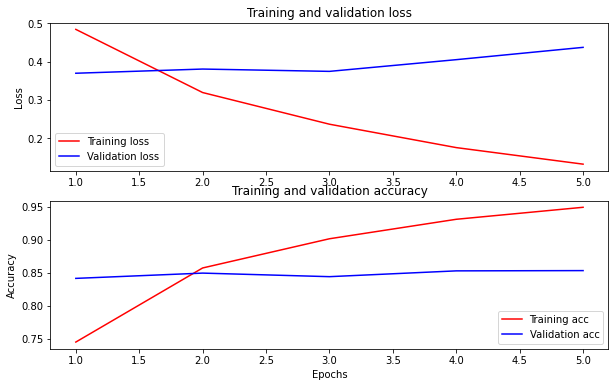

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represents the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [22]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model so you can try it side by side with the model that is still in memory.

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999201
input: The movie was great!           : score: 0.984589
input: The movie was meh.             : score: 0.865695
input: The movie was okish.           : score: 0.039927
input: The movie was terrible...      : score: 0.001525

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999201
input: The movie was great!           : score: 0.984589
input: The movie was meh.             : score: 0.865695
input: The movie was okish.           : score: 0.039927
input: The movie was terrible...      : score: 0.001525



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [25]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999201
input: The movie was great!           : score: 0.984589
input: The movie was meh.             : score: 0.865695
input: The movie was okish.           : score: 0.039927
input: The movie was terrible...      : score: 0.001525



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu) which runs on a TPU and shows you how to work with multiple inputs.